<a href="https://colab.research.google.com/github/ErickJLA/Co-Met/blob/main/Co_Met_5_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title ⚙️ Setup: IMPORT LIBRARIES & LOAD FUNCTIONS

# =============================================================================
# CELL 1: ENVIRONMENT SETUP
# Purpose: Import required libraries and authenticate Google Sheets access
# Dependencies: None
# Outputs: Authentication status, library versions, system info
# =============================================================================

import numpy as np
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
import ipywidgets as widgets
import io
import base64
from IPython.display import display, HTML, clear_output, Javascript
from scipy.stats import norm, t, chi2
import matplotlib.pyplot as plt
import datetime
import sys
import warnings
from scipy.special import gamma
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress unnecessary warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)

# --- Configuration Constants ---
REQUIRED_COLUMNS = {
    'effect_data': ['xe', 'sde', 'ne', 'xc', 'sdc', 'nc'],
    'metadata': ['id']
}

SUPPORTED_EFFECT_SIZES = {
    'lnRR': 'Log Response Ratio',
    'hedges_g': "Hedges' g (corrected SMD)",
    'cohen_d': "Cohen's d (uncorrected SMD)",
    'log_OR': 'Log Odds Ratio'
}

# --- Authentication ---
print("=" * 70)
print("CO-META - INITIALIZATION")
print("=" * 70)


# =============================================================================
# UTILITY FUNCTIONS - Extracted from original cells for reusability
# =============================================================================

# --- STATISTICAL FUNCTIONS ---

def calculate_tau_squared_DL(df, effect_col, var_col):
    """
    DerSimonian-Laird estimator for tau-squared

    Advantages:
    - Simple, fast
    - Non-iterative
    - Always converges

    Disadvantages:
    - Can underestimate tau² in small samples
    - Negative values truncated to 0
    - Less efficient than ML methods

    Parameters:
    -----------
    df : DataFrame
        Data with effect sizes and variances
    effect_col : str
        Name of effect size column
    var_col : str
        Name of variance column

    Returns:
    --------
    float : tau-squared estimate
    """
    k = len(df)
    if k < 2:
        return 0.0

    try:
        # Fixed-effects weights
        w = 1 / df[var_col]
        sum_w = w.sum()

        if sum_w <= 0:
            return 0.0

        # Fixed-effects pooled estimate
        pooled_effect = (w * df[effect_col]).sum() / sum_w

        # Q statistic
        Q = (w * (df[effect_col] - pooled_effect)**2).sum()
        df_Q = k - 1

        # C constant
        sum_w_sq = (w**2).sum()
        C = sum_w - (sum_w_sq / sum_w)

        # Tau-squared
        if C > 0 and Q > df_Q:
            tau_sq = (Q - df_Q) / C
        else:
            tau_sq = 0.0

        return max(0.0, tau_sq)

    except Exception as e:
        warnings.warn(f"Error in DL estimator: {e}")
        return 0.0



def calculate_tau_squared(df, effect_col, var_col, method='REML', **kwargs):
    """
    Unified function to calculate tau-squared using specified method

    Parameters:
    -----------
    df : DataFrame
        Data with effect sizes and variances
    effect_col : str
        Name of effect size column
    var_col : str
        Name of variance column
    method : str
        Estimation method: 'DL', 'REML', 'ML', 'PM', 'SJ'
        Default: 'REML' (recommended)
    **kwargs : dict
        Additional arguments passed to estimator

    Returns:
    --------
    float : tau-squared estimate
    dict : additional information (method used, convergence, etc.)
    """
    method = method.upper()

    estimators = {
        'DL': calculate_tau_squared_DL,
        'REML': calculate_tau_squared_REML,
        'ML': calculate_tau_squared_ML,
        'PM': calculate_tau_squared_PM,
        'SJ': calculate_tau_squared_SJ
    }

    if method not in estimators:
        warnings.warn(f"Unknown method '{method}', using REML")
        method = 'REML'

    try:
        tau_sq = estimators[method](df, effect_col, var_col, **kwargs)

        info = {
            'method': method,
            'tau_squared': tau_sq,
            'tau': np.sqrt(tau_sq),
            'success': True
        }

        return tau_sq, info

    except Exception as e:
        warnings.warn(f"Error with {method}, falling back to DL: {e}")
        tau_sq = calculate_tau_squared_DL(df, effect_col, var_col)

        info = {
            'method': 'DL',
            'tau_squared': tau_sq,
            'tau': np.sqrt(tau_sq),
            'success': False,
            'fallback': True,
            'error': str(e)
        }

        return tau_sq, info



def calculate_tau_squared_dl(df, effect_col, var_col):
    """
    Calculate Tau-squared. Uses Global Advanced Estimator (Cell 4.5) if available,
    otherwise falls back to DerSimonian-Laird (DL).
    """
    k = len(df)
    if k < 2: return 0.0

    # Try using the advanced REML estimator from Cell 4.5 first
    if 'calculate_tau_squared' in globals():
        tau_method = 'REML' # Prefer REML for consistency
        try:
            tau_sq, info = calculate_tau_squared(df, effect_col, var_col, method=tau_method)
            if info.get('success', True):
                return tau_sq
        except Exception:
            pass # Fall back to DL if REML fails (common in small cumulative steps)

    # Classic DL Method (Fallback)
    try:
        w_fixed = 1 / df[var_col]
        sum_w = w_fixed.sum()
        if sum_w <= 0: return 0.0
        pooled_effect = (w_fixed * df[effect_col]).sum() / sum_w
        Qt = (w_fixed * (df[effect_col] - pooled_effect)**2).sum()
        df_Q = k - 1
        sum_w_sq = (w_fixed**2).sum()
        C = sum_w - (sum_w_sq / sum_w)
        if C > 0 and Qt > df_Q:
            tau_squared = (Qt - df_Q) / C
        else:
            tau_squared = 0.0
        return max(0.0, tau_squared)
    except Exception:
        return 0.0


def calculate_re_pooled(df, tau_squared, effect_col, var_col, alpha=0.05):
    """Calculate Random-Effects pooled estimate with CI"""
    k = len(df)
    if k < 1: return np.nan, np.nan, np.nan, np.nan, np.nan
    try:
        w_re = 1 / (df[var_col] + tau_squared)
        sum_w_re = w_re.sum()
        if sum_w_re <= 0: return np.nan, np.nan, np.nan, np.nan, np.nan

        pooled_effect = (w_re * df[effect_col]).sum() / sum_w_re
        pooled_var = 1 / sum_w_re
        pooled_se = np.sqrt(pooled_var)

        z_crit = norm.ppf(1 - alpha / 2)
        ci_lower = pooled_effect - z_crit * pooled_se
        ci_upper = pooled_effect + z_crit * pooled_se

        # Calculate I-squared
        w_fixed = 1 / df[var_col]
        sum_w_fixed = w_fixed.sum()
        pooled_effect_fe = (w_fixed * df[effect_col]).sum() / sum_w_fixed
        Q = (w_fixed * (df[effect_col] - pooled_effect_fe)**2).sum()
        df_Q = k - 1
        I_sq = max(0, ((Q - df_Q) / Q) * 100) if Q > 0 else 0

        return pooled_effect, pooled_se, ci_lower, ci_upper, I_sq
    except Exception:
        return np.nan, np.nan, np.nan, np.nan, np.nan


def calculate_knapp_hartung_ci(yi, vi, tau_sq, pooled_effect, alpha=0.05):
    """
    Calculate Knapp-Hartung adjusted confidence interval
    """

    # Convert to numpy arrays
    yi = np.array(yi)
    vi = np.array(vi)

    # Random-effects weights
    wi_star = 1 / (vi + tau_sq)
    sum_wi_star = np.sum(wi_star)

    # Degrees of freedom
    k = len(yi)
    df = k - 1

    if df <= 0:
        # Can't use K-H with k=1
        return None

    # Calculate Q statistic (residual heterogeneity)
    Q = np.sum(wi_star * (yi - pooled_effect)**2)

    # Standard random-effects variance
    var_standard = 1 / sum_wi_star

    # Knapp-Hartung adjusted variance
    # SE_KH² = (Q / (k-1)) × (1 / Σw*)
    var_KH = (Q / df) * var_standard
    se_KH = np.sqrt(var_KH)

    # t-distribution critical value
    t_crit = t.ppf(1 - alpha/2, df)

    # Confidence interval
    ci_lower = pooled_effect - t_crit * se_KH
    ci_upper = pooled_effect + t_crit * se_KH

    # Test statistic and p-value
    t_stat = pooled_effect / se_KH
    p_value = 2 * (1 - t.cdf(abs(t_stat), df))

    return {
        'se_KH': se_KH,
        'var_KH': var_KH,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        't_stat': t_stat,
        't_crit': t_crit,
        'df': df,
        'p_value': p_value,
        'Q': Q
    }



def compare_tau_estimators(df, effect_col, var_col):
    """
    Compare all tau-squared estimators on the same dataset

    Useful for sensitivity analysis and understanding which method
    is most appropriate for your data.

    Parameters:
    -----------
    df : DataFrame
        Data with effect sizes and variances
    effect_col : str
        Name of effect size column
    var_col : str
        Name of variance column

    Returns:
    --------
    DataFrame : Comparison of all methods
    """
    methods = ['DL', 'REML', 'ML', 'PM', 'SJ']
    results = []

    for method in methods:
        try:
            tau_sq, info = calculate_tau_squared(df, effect_col, var_col, method=method)

            results.append({
                'Method': method,
                'τ²': tau_sq,
                'τ': np.sqrt(tau_sq),
                'Success': info['success']
            })
        except Exception as e:
            results.append({
                'Method': method,
                'τ²': np.nan,
                'τ': np.nan,
                'Success': False
            })

    comparison_df = pd.DataFrame(results)

    return comparison_df



def calculate_hedges_g_python(df):
    """Calculate Hedges' g using EXACT Gamma correction."""
    df = df.copy()

    # Pooled SD
    n_e, n_c = df['ne'], df['nc']
    sd_e, sd_c = df['sde'], df['sdc']
    mean_e, mean_c = df['xe'], df['xc']

    df_d = n_e + n_c - 2
    sd_pooled = np.sqrt(((n_e - 1)*sd_e**2 + (n_c - 1)*sd_c**2) / df_d)

    # Cohen's d
    d = (mean_e - mean_c) / sd_pooled

    # Hedges' correction (J) - EXACT FORMULA to match metafor
    # J = exp(lgamma(m/2) - log(sqrt(m/2)) - lgamma((m-1)/2))
    m = df_d
    J = gamma(m / 2) / (np.sqrt(m / 2) * gamma((m - 1) / 2))

    g = d * J

    # Variance of g (Exact)
    vg = ((n_e + n_c) / (n_e * n_c) + (g**2 / (2 * (n_e + n_c)))) * J**2

    return g, vg


# --- THREE-LEVEL MODEL FUNCTIONS ---

def _get_three_level_estimates(params, y_all, vcv_all, N_total, M_studies):
    """
    Core function to calculate 3-level estimates using VCV matrices.
    FIXED: Proper REML log-likelihood formula to match metafor.
    """
    try:
        tau_sq, sigma_sq = params
        # Safety check for negatives
        if tau_sq < 0: tau_sq = 1e-10
        if sigma_sq < 0: sigma_sq = 1e-10

        sum_log_det_Vi = 0.0
        sum_S = 0.0       # 1' * V_i⁻¹ * 1
        sum_Sy = 0.0      # 1' * V_i⁻¹ * y_i
        sum_ySy = 0.0     # y_i' * V_i⁻¹ * y_i

        for i in range(M_studies):
            y_i = np.asarray(y_all[i], dtype=np.float64)
            V_i = np.asarray(vcv_all[i], dtype=np.float64)
            k = len(y_i)

            # Ensure V_i is 2D
            if V_i.ndim == 1:
                V_i = np.diag(V_i)

            # --- CONSTRUCT TOTAL VARIANCE MATRIX (Sigma_i) ---
            # Sigma_i = V_i (Sampling Error) + sigma²*I (Level 2) + tau²*J (Level 3)

            # Check if V_i is diagonal (no shared controls) - use fast path
            is_diagonal = (k == 1) or np.allclose(V_i, np.diag(np.diag(V_i)))

            if is_diagonal:
                # --- FAST PATH: Sherman-Morrison Formula ---
                v_i = np.diag(V_i) if k > 1 else np.array([V_i[0, 0]])

                # A = diag(v_ij + σ²)
                A_diag = v_i + sigma_sq
                inv_A_diag = 1.0 / A_diag

                # Sherman-Morrison components
                sum_inv_A = np.sum(inv_A_diag)
                denom = 1.0 + tau_sq * sum_inv_A

                # Log Determinant: |A + tau²*J| = |A| * (1 + tau² * 1'A⁻¹1)
                log_det_A = np.sum(np.log(A_diag))
                log_det_Vi = log_det_A + np.log(denom)

                # Sherman-Morrison inverse: (A + tau²*J)⁻¹ = A⁻¹ - (tau² * A⁻¹ * J * A⁻¹) / (1 + tau² * trace(A⁻¹))
                # V⁻¹y
                inv_A_y = inv_A_diag * y_i
                sum_inv_A_y = np.sum(inv_A_y)
                w_y = inv_A_y - (tau_sq * inv_A_diag * sum_inv_A_y) / denom

                # V⁻¹1
                w_1 = inv_A_diag - (tau_sq * inv_A_diag * sum_inv_A) / denom


            else:
                # --- FULL PATH: Matrix Inversion for Shared Controls ---
                Sigma_i = V_i.copy()

                # Add Level 2 (within-study): σ² on diagonal
                # Use faster fill_diagonal logic
                np.fill_diagonal(Sigma_i, np.diag(Sigma_i) + sigma_sq)

                # Add Level 3 (between-study): τ² for all elements
                Sigma_i += tau_sq

                # --- INVERSION & DETERMINANT ---
                try:
                    # Try Cholesky first (Fastest & Most Stable)
                    L = np.linalg.cholesky(Sigma_i)
                    # Solve Ax = I is faster/stable than explicit inv(A)
                    inv_Sigma_i = np.linalg.solve(Sigma_i, np.eye(k))
                    log_det_Vi = 2.0 * np.sum(np.log(np.diag(L)))
                except np.linalg.LinAlgError:
                    # Fallback 1: Add Jitter (Ridge) and retry Cholesky
                    try:
                        Sigma_ridged = Sigma_i + 1e-6 * np.eye(k)
                        L = np.linalg.cholesky(Sigma_ridged)
                        inv_Sigma_i = np.linalg.solve(Sigma_ridged, np.eye(k))
                        log_det_Vi = 2.0 * np.sum(np.log(np.diag(L)))
                    except np.linalg.LinAlgError:
                        # Fallback 2: Pseudo-Inverse (Slowest, but guarantees result)
                        inv_Sigma_i = np.linalg.pinv(Sigma_i)
                        sign, log_det_Vi = np.linalg.slogdet(Sigma_i)
                        if sign <= 0:
                            return {'log_lik_reml': np.inf}

                ones = np.ones(k)
                w_y = np.dot(inv_Sigma_i, y_i)
                w_1 = np.dot(inv_Sigma_i, ones)

            # Accumulate across studies
            sum_log_det_Vi += log_det_Vi
            sum_S += np.sum(w_1)
            sum_Sy += np.sum(w_y)
            sum_ySy += np.dot(y_i, w_y)

        if sum_S <= 1e-10:
            return {'log_lik_reml': np.inf}

        # --- FINAL ESTIMATES ---
        mu_hat = sum_Sy / sum_S
        var_mu = 1.0 / sum_S
        se_mu = np.sqrt(var_mu)

        # Residual Sum of Squares (quadratic form)
        residual_ss = sum_ySy - (sum_Sy ** 2) / sum_S  # Equivalent but more stable

        # REML Log-Likelihood (matches metafor::rma.mv)
        # -2 * logLik = log|V| + log|X'V⁻¹X| + (y-Xμ)'V⁻¹(y-Xμ) + (n-p)*log(2π)
        # For intercept-only: X'V⁻¹X = sum_S, so log|X'V⁻¹X| = log(sum_S)
        p = 1  # Number of fixed effects (intercept only)

        log_lik_reml = -0.5 * (
            (N_total - p) * np.log(2.0 * np.pi) +  # Constant term
            sum_log_det_Vi +                        # log|V|
            np.log(sum_S) +                         # log|X'V⁻¹X|
            residual_ss                             # Residual quadratic form
        )

        # ML Log-Likelihood
        log_lik_ml = -0.5 * (
            N_total * np.log(2.0 * np.pi) +
            sum_log_det_Vi +
            residual_ss
        )

        return {
            'mu': mu_hat, 'se_mu': se_mu, 'var_mu': var_mu,
            'log_lik_reml': log_lik_reml, 'log_lik_ml': log_lik_ml,
            'tau_sq': tau_sq, 'sigma_sq': sigma_sq
        }

    except (FloatingPointError, ValueError, np.linalg.LinAlgError) as e:
        return {'log_lik_reml': np.inf}


def _negative_log_likelihood_reml(params, y_all, vcv_all, N_total, M_studies):
    """Wrapper for optimizer."""
    estimates = _get_three_level_estimates(params, y_all, vcv_all, N_total, M_studies)
    return -estimates['log_lik_reml']


def _get_three_level_estimates_loo(params, y_all, vcv_all, N_total, M_studies):
    """
    Core calculation for 3-level estimates with VCV matrix support (LOO Version).
    Silent version without ML likelihood calculation.
    """
    try:
        tau_sq, sigma_sq = params
        if tau_sq < 0: tau_sq = 1e-10
        if sigma_sq < 0: sigma_sq = 1e-10

        sum_log_det_Vi = 0.0
        sum_S = 0.0
        sum_Sy = 0.0
        sum_ySy = 0.0

        for i in range(M_studies):
            y_i = y_all[i]
            V_i = vcv_all[i]  # Now using VCV matrix
            k = len(y_i)

            # Check if diagonal (no shared controls) - use fast path
            is_diagonal = (k == 1) or np.allclose(V_i, np.diag(np.diag(V_i)))

            if is_diagonal:
                # Fast path: Sherman-Morrison
                v_i = np.diag(V_i) if k > 1 else np.array([V_i[0, 0]])

                A_diag = v_i + sigma_sq
                inv_A_diag = 1.0 / A_diag
                sum_inv_A = np.sum(inv_A_diag)
                denom = 1 + tau_sq * sum_inv_A

                log_det_A = np.sum(np.log(A_diag))
                sum_log_det_Vi += log_det_A + np.log(denom)

                inv_A_y = inv_A_diag * y_i
                sum_inv_A_y = np.sum(inv_A_y)

                w_y = inv_A_y - (tau_sq * inv_A_diag * sum_inv_A_y) / denom
                w_1 = inv_A_diag - (tau_sq * inv_A_diag * sum_inv_A) / denom
            else:
                # Full path: Matrix inversion for shared controls
                Sigma_i = V_i.copy()
                np.fill_diagonal(Sigma_i, np.diag(Sigma_i) + sigma_sq)
                Sigma_i += tau_sq

                try:
                    L = np.linalg.cholesky(Sigma_i)
                    inv_Sigma_i = np.linalg.inv(Sigma_i)
                    log_det_Vi = 2 * np.sum(np.log(np.diag(L)))
                except np.linalg.LinAlgError:
                    inv_Sigma_i = np.linalg.pinv(Sigma_i)
                    sign, log_det_Vi = np.linalg.slogdet(Sigma_i)
                    if sign <= 0:
                        log_det_Vi = 1e10

                sum_log_det_Vi += log_det_Vi

                ones = np.ones(k)
                w_y = np.dot(inv_Sigma_i, y_i)
                w_1 = np.dot(inv_Sigma_i, ones)

            sum_S += np.sum(w_1)
            sum_Sy += np.sum(w_y)
            sum_ySy += np.dot(y_i, w_y)

        if sum_S <= 1e-10: return {'log_lik_reml': np.inf}

        mu_hat = sum_Sy / sum_S
        var_mu = 1.0 / sum_S
        se_mu = np.sqrt(var_mu)
        residual_ss = sum_ySy - 2.0 * mu_hat * sum_Sy + mu_hat**2 * sum_S

        log_lik_reml = -0.5 * (sum_log_det_Vi + np.log(sum_S) + residual_ss)
        if np.isnan(log_lik_reml): return {'log_lik_reml': np.inf}

        return {'mu': mu_hat, 'se_mu': se_mu, 'log_lik_reml': log_lik_reml,
                'tau_sq': tau_sq, 'sigma_sq': sigma_sq}

    except (FloatingPointError, ValueError, np.linalg.LinAlgError):
        return {'log_lik_reml': np.inf}


def _neg_log_lik_reml_loo(params, y_all, vcv_all, N_total, M_studies):
    """Wrapper for LOO optimizer (short name version)."""
    est = _get_three_level_estimates_loo(params, y_all, vcv_all, N_total, M_studies)
    return -est['log_lik_reml']


def _negative_log_likelihood_reml_loo(params, y_all, vcv_all, N_total, M_studies):
    """Wrapper for LOO optimizer (full name version)."""
    estimates = _get_three_level_estimates_loo(params, y_all, vcv_all, N_total, M_studies)
    return -estimates['log_lik_reml']



def _neg_log_lik_reml(params, y, v, groups):
    tau2, sigma2 = params
    # Bounds are handled by optimizer, but safe-guard here for math domain errors
    if tau2 < 0: tau2 = 1e-10
    if sigma2 < 0: sigma2 = 1e-10

    unique_groups = np.unique(groups)

    log_lik = 0
    sum_S = 0
    sum_Sy = 0
    sum_ySy = 0

    for grp in unique_groups:
        mask = (groups == grp)
        y_i = y[mask]
        v_i = v[mask]

        # V_i = D + sigma2*I + tau2*J
        # A = D + sigma2*I (Diagonal matrix)
        A_diag = v_i + sigma2
        inv_A_diag = 1.0 / A_diag

        # Woodbury/Sherman-Morrison components
        # (A + uv^T)^-1 = A^-1 - (A^-1 u v^T A^-1) / (1 + v^T A^-1 u)
        # Here u = v = tau * 1

        sum_inv_A = np.sum(inv_A_diag)
        denom = 1 + tau2 * sum_inv_A

        # Log Determinant of V_i
        # det(A + uv^T) = det(A) * (1 + v^T A^-1 u)
        log_det_A = np.sum(np.log(A_diag))
        log_det_Vi = log_det_A + np.log(denom)
        log_lik += log_det_Vi

        # Inversion Operations
        inv_A_y = inv_A_diag * y_i
        # w_y = V_i^-1 * y_i
        w_y = inv_A_y - (tau2 * inv_A_diag * np.sum(inv_A_y)) / denom

        # w_1 = V_i^-1 * 1
        w_1 = inv_A_diag - (tau2 * inv_A_diag * sum_inv_A) / denom

        sum_S += np.sum(w_1)      # 1^T V^-1 1
        sum_Sy += np.sum(w_y)     # 1^T V^-1 y
        sum_ySy += np.dot(y_i, w_y) # y^T V^-1 y

    # REML Profile Likelihood Calculation
    mu = sum_Sy / sum_S
    resid = sum_ySy - 2*mu*sum_Sy + mu**2 * sum_S

    # Full REML Log Likelihood
    total_log_lik = -0.5 * (log_lik + np.log(sum_S) + resid)

    return -total_log_lik


def run_python_3level(yi, vi, study_ids):
    # 1. First Pass: L-BFGS-B (Global search)
    best_res = None
    best_fun = np.inf

    # Multiple start points to avoid local minima
    start_points = [[0.01, 0.01], [0.5, 0.1], [0.1, 0.5], [0.001, 0.001]]

    for start in start_points:
        res = minimize(_neg_log_lik_reml, x0=start, args=(yi, vi, study_ids),
                       bounds=[(1e-8, None), (1e-8, None)],
                       method='L-BFGS-B',
                       options={'ftol': 1e-12, 'gtol': 1e-12}) # High precision
        if res.success and res.fun < best_fun:
            best_fun = res.fun
            best_res = res

    if not best_res: return None

    # 2. Second Pass: Nelder-Mead (Polishing)
    # Sometimes gradient methods get stuck slightly off in flat valleys
    final_res = minimize(_neg_log_lik_reml, x0=best_res.x, args=(yi, vi, study_ids),
                         method='Nelder-Mead',
                         bounds=[(1e-8, None), (1e-8, None)],
                         options={'xatol': 1e-12, 'fatol': 1e-12})

    tau2, sigma2 = final_res.x
    return tau2, sigma2


# --- REGRESSION FUNCTIONS ---

def _estimate_variance_from_intercept_model(y_all, v_all, M_studies):
    """
    Estimate tau² and sigma² from intercept-only 3-level model.
    Used to get reliable starting values when moderator is constant within studies.
    """
    JITTER = 1e-8

    def neg_ll_intercept(params):
        tau_sq, sigma_sq = max(params[0], 1e-10), max(params[1], 1e-10)

        sum_log_det = 0.0
        sum_w = 0.0
        sum_wy = 0.0
        sum_ywy = 0.0

        for i in range(M_studies):
            y_i, v_i = y_all[i], v_all[i]
            A_diag = v_i + sigma_sq + JITTER
            inv_A = 1.0 / A_diag
            sum_inv_A = np.sum(inv_A)
            denom = 1.0 + tau_sq * sum_inv_A

            w_i = sum_inv_A - (tau_sq * sum_inv_A**2) / denom
            inv_A_y = inv_A * y_i
            sum_inv_A_y = np.sum(inv_A_y)
            wy_i = sum_inv_A_y - (tau_sq * sum_inv_A * sum_inv_A_y) / denom
            ywy_i = np.dot(y_i, inv_A_y) - (tau_sq * sum_inv_A_y**2) / denom

            sum_w += w_i
            sum_wy += wy_i
            sum_ywy += ywy_i
            sum_log_det += np.sum(np.log(A_diag)) + np.log(denom)

        rss = sum_ywy - (sum_wy**2) / sum_w
        log_lik = -0.5 * (sum_log_det + np.log(sum_w) + rss)
        return -log_lik if np.isfinite(log_lik) else 1e10

    # Multi-start optimization
    starts = [[0.1, 0.1], [1.0, 0.1], [5.0, 0.5], [0.5, 1.0], [10.0, 0.1]]
    best_res, best_fun = None, np.inf

    for start in starts:
        try:
            res = minimize(neg_ll_intercept, x0=start, method='L-BFGS-B',
                          bounds=[(1e-8, None), (1e-8, None)], options={'ftol': 1e-12})
            if res.success and res.fun < best_fun:
                best_fun, best_res = res.fun, res
        except Exception:
            continue

    if best_res is None:
        return 1.0, 0.1
    return max(best_res.x[0], 1e-8), max(best_res.x[1], 1e-8)


# =============================================================================
# CORE: _get_three_level_regression_estimates_v2 (BACKWARD COMPATIBLE)
# =============================================================================

def _get_three_level_regression_estimates_v2(params, y_all, v_all, X_all,
                                              N_total, M_studies, p_params):
    """
    Calculates betas, standard errors, p-values, and likelihood.

    BACKWARD COMPATIBLE: Returns all original keys plus new ones.
    """
    JITTER = 1e-8

    try:
        tau_sq = max(params[0], 1e-10)
        sigma_sq = max(params[1], 1e-10)

        sum_log_det_Vi = 0.0
        sum_XWX = np.zeros((p_params, p_params))
        sum_XWy = np.zeros(p_params)
        sum_yWy = 0.0

        for i in range(M_studies):
            y_i = y_all[i]
            v_i = v_all[i]
            X_i = X_all[i]

            # V_i = diag(v_i) + sigma²*I + tau²*J, inverted via Sherman-Morrison
            A_diag = v_i + sigma_sq + JITTER
            inv_A_diag = 1.0 / A_diag
            sum_inv_A = np.sum(inv_A_diag)
            denom = max(1.0 + tau_sq * sum_inv_A, JITTER)

            # Log determinant
            log_det_A = np.sum(np.log(A_diag))
            sum_log_det_Vi += log_det_A + np.log(denom)

            # Efficient X'V⁻¹X and X'V⁻¹y computation
            inv_A_X = inv_A_diag[:, None] * X_i
            inv_A_y = inv_A_diag * y_i
            sum_inv_A_X = np.sum(inv_A_X, axis=0)
            sum_inv_A_y = np.sum(inv_A_y)

            xt_invA_x = X_i.T @ inv_A_X
            correction_term = (tau_sq / denom) * np.outer(sum_inv_A_X, sum_inv_A_X)
            sum_XWX += xt_invA_x - correction_term

            xt_invA_y = X_i.T @ inv_A_y
            correction_y = (tau_sq / denom) * sum_inv_A_X * sum_inv_A_y
            sum_XWy += xt_invA_y - correction_y

            yt_invA_y = np.dot(y_i, inv_A_y)
            correction_yy = (tau_sq / denom) * (sum_inv_A_y ** 2)
            sum_yWy += yt_invA_y - correction_yy

        # Add jitter for numerical stability
        sum_XWX += JITTER * np.eye(p_params)

        try:
            betas = np.linalg.solve(sum_XWX, sum_XWy)
            var_betas = np.linalg.inv(sum_XWX)
        except np.linalg.LinAlgError:
            return {'log_lik_reml': np.inf}

        se_betas = np.sqrt(np.diag(var_betas))

        # === CORRECT DF CALCULATION ===
        # For 3-level models, metafor uses different df depending on the moderator:
        # - If moderator varies within studies: df = k_studies - p (conservative)
        # - If moderator is constant within studies (study-level): df = n_obs - p
        #
        # We detect this by checking if sigma_sq ≈ 0 (within-study variance negligible)
        # When sigma_sq → 0, the model effectively treats each observation as independent

        if sigma_sq < 1e-4:
            # Study-level moderator: use observation-based df (matches metafor)
            df = max(N_total - p_params, 1)
        else:
            # Effect-level moderator: use study-based df (conservative)
            df = max(M_studies - p_params, 1)

        t_values = betas / se_betas
        p_values = 2.0 * t_dist.sf(np.abs(t_values), df=df)

        t_crit = t_dist.ppf(0.975, df=df)
        ci_lower = betas - t_crit * se_betas
        ci_upper = betas + t_crit * se_betas

        # REML likelihood
        residual_ss = sum_yWy - np.dot(betas, sum_XWy)
        sign, log_det_XWX = np.linalg.slogdet(sum_XWX)
        if sign <= 0:
            return {'log_lik_reml': np.inf}
        log_lik_reml = -0.5 * (sum_log_det_Vi + log_det_XWX + residual_ss)

        # === RETURN: All original keys + new ones ===
        return {
            # Original keys (backward compatible)
            'betas': betas,
            'se_betas': se_betas,
            'var_betas_robust': var_betas,  # Original key name preserved
            'log_lik_reml': log_lik_reml,
            'tau_sq': tau_sq,
            'sigma_sq': sigma_sq,
            # New keys (additions)
            'var_betas': var_betas,         # Alias
            't_values': t_values,
            'p_values': p_values,
            'df': df,                        # df depends on moderator type
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'n_obs': N_total,               # For reference
            'k_studies': M_studies,         # For reference
        }

    except (FloatingPointError, ValueError, np.linalg.LinAlgError):
        return {'log_lik_reml': np.inf}


# =============================================================================
# NEGATIVE LOG-LIKELIHOOD (unchanged interface)
# =============================================================================

def _neg_log_lik_reml_reg(params, y_all, v_all, X_all, N_total, M_studies, p_params):
    """Negative REML log-likelihood for optimization."""
    tau_sq = max(params[0], 1e-10)
    sigma_sq = max(params[1], 1e-10)

    est = _get_three_level_regression_estimates_v2(
        [tau_sq, sigma_sq], y_all, v_all, X_all, N_total, M_studies, p_params
    )

    ll = est.get('log_lik_reml', np.inf)
    return -ll if np.isfinite(ll) else 1e10


def _neg_log_lik_reml_reg_constrained(params, y_all, v_all, X_all,
                                       N_total, M_studies, p_params,
                                       tau_sq_prior, penalty_weight):
    """REML likelihood with soft constraint on tau² toward prior."""
    tau_sq = max(params[0], 1e-10)
    sigma_sq = max(params[1], 1e-10)

    est = _get_three_level_regression_estimates_v2(
        [tau_sq, sigma_sq], y_all, v_all, X_all, N_total, M_studies, p_params
    )

    ll = est.get('log_lik_reml', np.inf)
    if not np.isfinite(ll):
        return 1e10

    # Penalty pulls tau² toward intercept-only estimate
    penalty = penalty_weight * (np.log(tau_sq) - np.log(tau_sq_prior))**2
    return -ll + penalty


# =============================================================================
# MAIN: _run_three_level_reml_regression_v2 (BACKWARD COMPATIBLE)
# =============================================================================

def _run_three_level_reml_regression_v2(analysis_data, moderator_col, effect_col, var_col):
    """
    3-level REML meta-regression with automatic handling of constant moderators.

    BACKWARD COMPATIBLE: Same signature, same return structure.
    Internally uses constrained optimization when moderator is constant within studies.
    """
    grouped = analysis_data.groupby('id')
    y_all, v_all, X_all = [], [], []

    for study_id, group in grouped:
        y_all.append(group[effect_col].values.astype(float))
        v_all.append(group[var_col].values.astype(float))

        # Build design matrix with intercept
        mod_values = group[moderator_col].values.astype(float)
        n_i = len(mod_values)

        # Manually construct X = [1, moderator] to ensure intercept is always present
        # sm.add_constant can fail when moderator is constant within a group
        X_i = np.column_stack([np.ones(n_i), mod_values])
        X_all.append(X_i)

    N_total = len(analysis_data)
    M_studies = len(y_all)
    p_params = X_all[0].shape[1]

    # === AUTO-DETECT: Is moderator constant within studies? ===
    is_constant_within = analysis_data.groupby('id')[moderator_col].nunique().max() == 1

    # === STAGE 1: Get tau² from intercept-only model ===
    tau_sq_prior, sigma_sq_prior = _estimate_variance_from_intercept_model(
        y_all, v_all, M_studies
    )

    # === STAGE 2: Choose optimization strategy ===
    if is_constant_within:
        # Constrained optimization to prevent tau² collapse
        starts = [
            [tau_sq_prior, sigma_sq_prior],
            [tau_sq_prior * 0.5, sigma_sq_prior],
            [tau_sq_prior * 2.0, sigma_sq_prior],
        ]
        penalty_weight = 5.0

        best_res, best_fun = None, np.inf
        for start in starts:
            try:
                res = minimize(
                    _neg_log_lik_reml_reg_constrained,
                    x0=start,
                    args=(y_all, v_all, X_all, N_total, M_studies, p_params,
                          tau_sq_prior, penalty_weight),
                    method='L-BFGS-B',
                    bounds=[(1e-8, None), (1e-8, None)],
                    options={'ftol': 1e-12, 'maxiter': 1000}
                )
                if res.fun < best_fun:
                    best_fun, best_res = res.fun, res
            except Exception:
                continue

        if best_res is None:
            # Fallback: use intercept-only estimates directly
            best_res = type('obj', (object,), {
                'x': [tau_sq_prior, sigma_sq_prior],
                'success': True,
                'fun': np.inf
            })()
    else:
        # Standard joint optimization (original behavior)
        start_points = [
            [tau_sq_prior, sigma_sq_prior],
            [0.1, 0.1],
            [1.0, 0.1],
            [5.0, 0.1],
            [10.0, 0.5],
            [0.01, 1.0],
        ]

        best_res, best_fun = None, np.inf
        for start in start_points:
            try:
                res = minimize(
                    _neg_log_lik_reml_reg, x0=start,
                    args=(y_all, v_all, X_all, N_total, M_studies, p_params),
                    method='L-BFGS-B', bounds=[(1e-8, None), (1e-8, None)],
                    options={'ftol': 1e-10}
                )
                if res.success and res.fun < best_fun:
                    best_fun, best_res = res.fun, res
            except Exception:
                continue

        if best_res is None:
            # Fallback: Nelder-Mead
            try:
                best_res = minimize(
                    _neg_log_lik_reml_reg, x0=[1.0, 1.0],
                    args=(y_all, v_all, X_all, N_total, M_studies, p_params),
                    method='Nelder-Mead'
                )
            except Exception:
                return None, None, None

    if best_res is None:
        return None, None, None

    # === STAGE 3: Polish with Nelder-Mead ===
    try:
        final_res = minimize(
            _neg_log_lik_reml_reg, x0=best_res.x,
            args=(y_all, v_all, X_all, N_total, M_studies, p_params),
            method='Nelder-Mead',
            options={'xatol': 1e-10, 'fatol': 1e-10}
        )
    except Exception:
        final_res = best_res

    # === FINAL ESTIMATES ===
    final_est = _get_three_level_regression_estimates_v2(
        final_res.x, y_all, v_all, X_all, N_total, M_studies, p_params
    )

    return final_est, (N_total, M_studies, p_params), final_res



# --- PLOTTING FUNCTIONS ---

def plot_trim_fill(data, effect_col, se_col, results, es_label):
    """Simple Forest Plot for Trim/Fill (Preview)"""
    k0 = results['k0']
    orig_est = results['pooled_original']
    fill_est = results['pooled_filled']

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Original Studies
    ax.scatter(data[effect_col], data[se_col], c='black', alpha=0.6, label='Observed Studies')

    # Plot Filled Studies
    if k0 > 0:
        se_filled = np.sqrt(results['vi_filled'])
        ax.scatter(results['yi_filled'], se_filled, c='white', edgecolors='red', marker='o', label='Imputed Studies')

    # Plot Center Lines
    ax.axvline(orig_est, color='black', linestyle='--', label=f'Original: {orig_est:.3f}')
    ax.axvline(fill_est, color='red', linestyle='-', label=f'Adjusted: {fill_est:.3f}')

    y_max = data[se_col].max() * 1.1
    ax.set_ylim(y_max, 0)
    ax.set_xlabel(es_label)
    ax.set_ylabel("Standard Error")
    ax.set_title(f"Trim-and-Fill Funnel Plot (Missing: {results['side']})")
    ax.legend()
    plt.show()

# functions

#@title 🔧 ADVANCED HETEROGENEITY ESTIMATORS

# =============================================================================
# CELL 4.5: ADVANCED TAU-SQUARED ESTIMATORS
# Purpose: Provides multiple methods for estimating between-study variance
# Dependencies: None (standalone functions)
# Used by: Cell 6 (Overall Analysis), Cell 8 (Subgroup Analysis)
# =============================================================================

import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar, minimize
from scipy.stats import chi2
import warnings

#print("="*70)
#print("HETEROGENEITY ESTIMATORS MODULE")
#print("="*70)

# --- 1. DERSIMONIAN-LAIRD (Your current method) ---

# --- 2. RESTRICTED MAXIMUM LIKELIHOOD (REML) ---

def calculate_tau_squared_REML(df, effect_col, var_col, max_iter=100, tol=1e-8):
    """
    REML estimator for tau-squared (RECOMMENDED - Gold Standard)

    Advantages:
    - Unbiased for tau²
    - Accounts for uncertainty in estimating mu
    - Better performance in small samples
    - Generally preferred in literature

    Disadvantages:
    - Iterative (slightly slower)
    - Can fail to converge in extreme cases

    Reference:
    Viechtbauer, W. (2005). Bias and efficiency of meta-analytic variance
    estimators in the random-effects model. Journal of Educational and
    Behavioral Statistics, 30(3), 261-293.

    Parameters:
    -----------
    df : DataFrame
        Data with effect sizes and variances
    effect_col : str
        Name of effect size column
    var_col : str
        Name of variance column
    max_iter : int
        Maximum iterations for optimization
    tol : float
        Convergence tolerance

    Returns:
    --------
    float : tau-squared estimate
    """
    k = len(df)
    if k < 2:
        return 0.0

    try:
        # Extract data
        yi = df[effect_col].values
        vi = df[var_col].values

        # Remove any infinite or negative variances
        valid_mask = np.isfinite(vi) & (vi > 0)
        if not valid_mask.all():
            warnings.warn(f"Removed {(~valid_mask).sum()} observations with invalid variances")
            yi = yi[valid_mask]
            vi = vi[valid_mask]
            k = len(yi)

        if k < 2:
            return 0.0

        # REML objective function (negative log-likelihood)
        def reml_objective(tau2):
            # Ensure tau2 is non-negative
            tau2 = max(0, tau2)

            # Weights
            wi = 1 / (vi + tau2)
            sum_wi = wi.sum()

            if sum_wi <= 0:
                return 1e10

            # Pooled estimate
            mu = (wi * yi).sum() / sum_wi

            # Q statistic
            Q = (wi * (yi - mu)**2).sum()

            # REML log-likelihood (negative for minimization)
            # L = -0.5 * [sum(log(vi + tau2)) + log(sum(wi)) + Q]
            log_lik = -0.5 * (
                np.sum(np.log(vi + tau2)) +
                np.log(sum_wi) +
                Q
            )

            return -log_lik  # Return negative for minimization

        # Get reasonable bounds for tau2
        # Lower bound: 0
        # Upper bound: Use variance of effect sizes as upper limit
        var_yi = np.var(yi, ddof=1) if k > 2 else 1.0
        upper_bound = max(10 * var_yi, 100)

        # Optimize
        result = minimize_scalar(
            reml_objective,
            bounds=(0, upper_bound),
            method='bounded',
            options={'maxiter': max_iter, 'xatol': tol}
        )

        if result.success:
            tau_sq = result.x
        else:
            warnings.warn("REML optimization did not converge, using DL fallback")
            tau_sq = calculate_tau_squared_DL(df, effect_col, var_col)

        return max(0.0, tau_sq)

    except Exception as e:
        warnings.warn(f"Error in REML estimator: {e}, using DL fallback")
        return calculate_tau_squared_DL(df, effect_col, var_col)


# --- 3. MAXIMUM LIKELIHOOD (ML) ---

def calculate_tau_squared_ML(df, effect_col, var_col, max_iter=100, tol=1e-8):
    """
    Maximum Likelihood estimator for tau-squared

    Advantages:
    - Efficient asymptotically
    - Produces valid estimates

    Disadvantages:
    - Biased downward (underestimates tau²)
    - Less preferred than REML
    - REML is generally recommended instead

    Parameters:
    -----------
    df : DataFrame
        Data with effect sizes and variances
    effect_col : str
        Name of effect size column
    var_col : str
        Name of variance column
    max_iter : int
        Maximum iterations
    tol : float
        Convergence tolerance

    Returns:
    --------
    float : tau-squared estimate
    """
    k = len(df)
    if k < 2:
        return 0.0

    try:
        yi = df[effect_col].values
        vi = df[var_col].values

        valid_mask = np.isfinite(vi) & (vi > 0)
        if not valid_mask.all():
            yi = yi[valid_mask]
            vi = vi[valid_mask]
            k = len(yi)

        if k < 2:
            return 0.0

        # ML objective function
        def ml_objective(tau2):
            tau2 = max(0, tau2)
            wi = 1 / (vi + tau2)
            sum_wi = wi.sum()

            if sum_wi <= 0:
                return 1e10

            mu = (wi * yi).sum() / sum_wi
            Q = (wi * (yi - mu)**2).sum()

            # ML log-likelihood (without the constant term)
            log_lik = -0.5 * (np.sum(np.log(vi + tau2)) + Q)

            return -log_lik

        var_yi = np.var(yi, ddof=1) if k > 2 else 1.0
        upper_bound = max(10 * var_yi, 100)

        result = minimize_scalar(
            ml_objective,
            bounds=(0, upper_bound),
            method='bounded',
            options={'maxiter': max_iter, 'xatol': tol}
        )

        if result.success:
            tau_sq = result.x
        else:
            warnings.warn("ML optimization did not converge, using DL fallback")
            tau_sq = calculate_tau_squared_DL(df, effect_col, var_col)

        return max(0.0, tau_sq)

    except Exception as e:
        warnings.warn(f"Error in ML estimator: {e}, using DL fallback")
        return calculate_tau_squared_DL(df, effect_col, var_col)


# --- 4. PAULE-MANDEL (PM) ---

def calculate_tau_squared_PM(df, effect_col, var_col, max_iter=100, tol=1e-8):
    """
    Paule-Mandel estimator for tau-squared

    Advantages:
    - Exact solution to Q = k-1 equation
    - Non-iterative in principle
    - Good performance

    Disadvantages:
    - Can be unstable with few studies
    - Requires iterative solution in practice

    Reference:
    Paule, R. C., & Mandel, J. (1982). Consensus values and weighting factors.
    Journal of Research of the National Bureau of Standards, 87(5), 377-385.

    Parameters:
    -----------
    df : DataFrame
        Data with effect sizes and variances
    effect_col : str
        Name of effect size column
    var_col : str
        Name of variance column
    max_iter : int
        Maximum iterations
    tol : float
        Convergence tolerance

    Returns:
    --------
    float : tau-squared estimate
    """
    k = len(df)
    if k < 2:
        return 0.0

    try:
        yi = df[effect_col].values
        vi = df[var_col].values

        valid_mask = np.isfinite(vi) & (vi > 0)
        if not valid_mask.all():
            yi = yi[valid_mask]
            vi = vi[valid_mask]
            k = len(yi)

        if k < 2:
            return 0.0

        df_Q = k - 1

        # PM objective: Find tau2 such that Q(tau2) = k - 1
        def pm_objective(tau2):
            tau2 = max(0, tau2)
            wi = 1 / (vi + tau2)
            sum_wi = wi.sum()

            if sum_wi <= 0:
                return 1e10

            mu = (wi * yi).sum() / sum_wi
            Q = (wi * (yi - mu)**2).sum()

            # We want Q = k - 1
            return (Q - df_Q)**2

        var_yi = np.var(yi, ddof=1) if k > 2 else 1.0
        upper_bound = max(10 * var_yi, 100)

        result = minimize_scalar(
            pm_objective,
            bounds=(0, upper_bound),
            method='bounded',
            options={'maxiter': max_iter, 'xatol': tol}
        )

        if result.success and result.fun < 1:  # Good convergence
            tau_sq = result.x
        else:
            # If PM fails, use DL
            tau_sq = calculate_tau_squared_DL(df, effect_col, var_col)

        return max(0.0, tau_sq)

    except Exception as e:
        warnings.warn(f"Error in PM estimator: {e}, using DL fallback")
        return calculate_tau_squared_DL(df, effect_col, var_col)


# --- 5. SIDIK-JONKMAN (SJ) ---

def calculate_tau_squared_SJ(df, effect_col, var_col):
    """
    Sidik-Jonkman estimator for tau-squared

    Advantages:
    - Simple, non-iterative
    - Good performance with few studies
    - Conservative (tends to produce larger estimates)

    Disadvantages:
    - Can be overly conservative
    - Less commonly used

    Reference:
    Sidik, K., & Jonkman, J. N. (2005). Simple heterogeneity variance
    estimation for meta-analysis. Journal of the Royal Statistical Society,
    Series C, 54(2), 367-384.

    Parameters:
    -----------
    df : DataFrame
        Data with effect sizes and variances
    effect_col : str
        Name of effect size column
    var_col : str
        Name of variance column

    Returns:
    --------
    float : tau-squared estimate
    """
    k = len(df)
    if k < 3:  # Need at least 3 studies for SJ
        return calculate_tau_squared_DL(df, effect_col, var_col)

    try:
        yi = df[effect_col].values
        vi = df[var_col].values

        valid_mask = np.isfinite(vi) & (vi > 0)
        if not valid_mask.all():
            yi = yi[valid_mask]
            vi = vi[valid_mask]
            k = len(yi)

        if k < 3:
            return calculate_tau_squared_DL(df, effect_col, var_col)

        # Weights for typical average
        wi = 1 / vi
        sum_wi = wi.sum()

        # Typical average (weighted mean)
        y_bar = (wi * yi).sum() / sum_wi

        # SJ estimator
        numerator = ((yi - y_bar)**2 / vi).sum()
        denominator = k - 1

        tau_sq = (numerator / denominator) - (k / sum_wi)

        return max(0.0, tau_sq)

    except Exception as e:
        warnings.warn(f"Error in SJ estimator: {e}, using DL fallback")
        return calculate_tau_squared_DL(df, effect_col, var_col)


# --- 6. EXPORT EXCEL ---

!pip install xlsxwriter
import xlsxwriter

# --- 1. HELPER: EXCLUSION LOG ---
def _get_exclusion_log():
    if 'ANALYSIS_CONFIG' in globals() and 'removed_records' in ANALYSIS_CONFIG:
        return ANALYSIS_CONFIG['removed_records']
    return pd.DataFrame([{'ID': 'All Data Kept', 'Reason': 'No records were removed.'}])

# --- 2. HELPER: EXCEL FORMATTER ---
def _apply_excel_formatting(writer, sheet_name, df):
    workbook = writer.book
    worksheet = writer.sheets[sheet_name]
    header_fmt = workbook.add_format({'bold': True, 'valign': 'top', 'fg_color': '#1F4E78', 'font_color': '#FFFFFF', 'border': 1})
    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num, value, header_fmt)
    for i, col in enumerate(df.columns):
        col_len = len(str(col))
        sample_vals = df[col].head(20).astype(str)
        max_val_len = sample_vals.map(len).max() if not sample_vals.empty else 0
        worksheet.set_column(i, i, min(max(col_len, max_val_len) + 2, 50))

# --- 3. HELPER: PROTOCOL SHEET FORMATTER ---
def _apply_protocol_sheet_formatting(writer, sheet_name, df):
    """
    Custom formatting for the Protocol & Settings sheet.
    - Bold headers
    - Bold Category column
    - Auto-adjust column widths for readability
    """
    workbook = writer.book
    worksheet = writer.sheets[sheet_name]

    # Define formats
    header_fmt = workbook.add_format({
        'bold': True,
        'valign': 'top',
        'fg_color': '#1F4E78',
        'font_color': '#FFFFFF',
        'border': 1
    })

    category_fmt = workbook.add_format({
        'bold': True,
        'valign': 'top'
    })

    # Apply header formatting
    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num, value, header_fmt)

    # Apply bold formatting to Category column (column 0)
    for row_num in range(1, len(df) + 1):
        cell_value = df.iloc[row_num - 1, 0]  # Category column
        worksheet.write(row_num, 0, cell_value, category_fmt)

    # Auto-adjust column widths
    for i, col in enumerate(df.columns):
        col_len = len(str(col))
        sample_vals = df[col].head(50).astype(str)
        max_val_len = sample_vals.map(len).max() if not sample_vals.empty else 0
        # Make columns wider for better readability
        col_width = min(max(col_len, max_val_len) + 3, 60)
        worksheet.set_column(i, i, col_width)


# --- 4. HELPER: SMART METADATA COLLECTOR (UPDATED) ---
def _get_protocol_metadata(report_type):
    """
    Captures comprehensive protocol settings and configuration.
    Returns a DataFrame with columns: [Category, Parameter, Value]
    """
    meta = []

    # System Information
    meta.append({'Category': 'System', 'Parameter': 'Timestamp', 'Value': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")})

    if 'ANALYSIS_CONFIG' not in globals():
        return pd.DataFrame(meta)

    ac = ANALYSIS_CONFIG

    try:
        # === ANALYSIS SETTINGS ===
        global_settings = ac.get('global_settings', {})

        # Confidence Level (convert alpha to percentage)
        alpha = global_settings.get('alpha', 0.05)
        confidence_pct = (1 - alpha) * 100
        meta.append({'Category': 'Settings', 'Parameter': 'Confidence Level', 'Value': f"{confidence_pct:.0f}%"})

        # Inference Distribution
        dist_type = global_settings.get('dist_type', 'norm')
        dist_label = 't-distribution' if dist_type == 't' else 'Normal distribution'
        meta.append({'Category': 'Settings', 'Parameter': 'Inference Distribution', 'Value': dist_label})

        # Model Selection
        overall_results = ac.get('overall_results', {})
        model_choice = overall_results.get('model_choice', 'Unknown')
        meta.append({'Category': 'Settings', 'Parameter': 'Model Selection', 'Value': model_choice})

        # Heterogeneity Estimator (tau method)
        tau_method = overall_results.get('tau_method', 'REML')
        meta.append({'Category': 'Settings', 'Parameter': 'Heterogeneity Estimator', 'Value': tau_method})

        # Knapp-Hartung Adjustment
        kh_info = overall_results.get('knapp_hartung', {})
        use_kh = kh_info.get('used', False)
        kh_label = 'Yes' if use_kh else 'No'
        meta.append({'Category': 'Settings', 'Parameter': 'Knapp-Hartung Adjustment', 'Value': kh_label})

        # === DATA PROVENANCE ===

        # Input Mode
        data_type = ac.get('data_type', 'Unknown')
        input_mode = 'Pre-Calculated' if data_type == 'pre_calculated' else 'Raw Data'
        meta.append({'Category': 'Data', 'Parameter': 'Input Mode', 'Value': input_mode})

        # Effect Size Information
        es_config = ac.get('es_config', {})
        effect_label = es_config.get('effect_label', 'Unknown')
        effect_label_short = es_config.get('effect_label_short', 'Unknown')
        meta.append({'Category': 'Data', 'Parameter': 'Effect Size Type', 'Value': f"{effect_label} ({effect_label_short})"})

        # Effect Size Column Names
        effect_col = ac.get('effect_col', es_config.get('effect_col', 'Unknown'))
        var_col = ac.get('var_col', es_config.get('var_col', 'Unknown'))
        meta.append({'Category': 'Data', 'Parameter': 'Effect Size Column', 'Value': effect_col})
        meta.append({'Category': 'Data', 'Parameter': 'Variance Column', 'Value': var_col})

        # Sample Size Information
        analysis_data = ac.get('analysis_data')
        if analysis_data is not None:
            k_total = len(analysis_data)
            meta.append({'Category': 'Data', 'Parameter': 'Total Observations (k)', 'Value': k_total})

            # Count unique studies
            if 'id' in analysis_data.columns:
                n_studies = analysis_data['id'].nunique()
                meta.append({'Category': 'Data', 'Parameter': 'Unique Studies', 'Value': n_studies})

        # === REPORT-SPECIFIC METADATA ===

        if report_type == 'cumulative' and 'cumulative_results' in ac:
            cum_df = ac['cumulative_results']
            if not cum_df.empty:
                meta.append({'Category': 'Cumulative', 'Parameter': 'Total Steps', 'Value': len(cum_df)})
                meta.append({'Category': 'Cumulative', 'Parameter': 'Year Range', 'Value': f"{int(cum_df['year'].min())} - {int(cum_df['year'].max())}"})
                meta.append({'Category': 'Cumulative', 'Parameter': 'Initial Effect (Start)', 'Value': f"{cum_df.iloc[0]['pooled_effect']:.4f}"})
                meta.append({'Category': 'Cumulative', 'Parameter': 'Final Effect (End)', 'Value': f"{cum_df.iloc[-1]['pooled_effect']:.4f}"})
                meta.append({'Category': 'Cumulative', 'Parameter': 'Method', 'Value': 'Iterative REML'})

        elif report_type == 'loo' and 'loo_3level_results' in ac:
            loo = ac['loo_3level_results']
            meta.append({'Category': 'Sensitivity', 'Parameter': 'Method', 'Value': 'Leave-One-Out (3-Level)'})
            meta.append({'Category': 'Sensitivity', 'Parameter': 'Original Effect', 'Value': f"{loo.get('original_effect', 0):.4f}"})
            meta.append({'Category': 'Sensitivity', 'Parameter': 'Significance Changers', 'Value': loo.get('n_sig_changers', 0)})

        elif report_type == 'subgroup' and 'subgroup_config' in ac:
            sub_config = ac['subgroup_config']
            analysis_type = sub_config.get('analysis_type', 'Unknown')
            moderator1 = sub_config.get('moderator1', 'Unknown')
            meta.append({'Category': 'Subgroup', 'Parameter': 'Analysis Type', 'Value': analysis_type})
            meta.append({'Category': 'Subgroup', 'Parameter': 'Moderator', 'Value': moderator1})
            if 'moderator2' in sub_config and sub_config['moderator2']:
                moderator2 = sub_config['moderator2']
                meta.append({'Category': 'Subgroup', 'Parameter': 'Second Moderator', 'Value': moderator2})

        elif report_type == 'regression' and 'meta_regression_RVE_results' in ac:
            reg = ac['meta_regression_RVE_results']
            moderator_col = reg.get('moderator_col_name', 'Unknown')
            meta.append({'Category': 'Regression', 'Parameter': 'Moderator Variable', 'Value': moderator_col})
            meta.append({'Category': 'Regression', 'Parameter': 'Model Type', 'Value': '3-Level REML'})

        elif report_type == 'spline' and 'spline_model_results' in ac:
            spline = ac['spline_model_results']
            moderator = spline.get('moderator_col', 'Unknown')
            n_knots = spline.get('n_knots', 'Unknown')
            meta.append({'Category': 'Spline', 'Parameter': 'Moderator Variable', 'Value': moderator})
            meta.append({'Category': 'Spline', 'Parameter': 'Number of Knots', 'Value': n_knots})

        elif report_type == 'publication_bias':
            meta.append({'Category': 'Publication Bias', 'Parameter': 'Tests Performed', 'Value': 'Egger Test, Trim & Fill'})

    except Exception as e:
        meta.append({'Category': 'Error', 'Parameter': 'Metadata Error', 'Value': str(e)})

    return pd.DataFrame(meta)

# --- 4. MAIN ORCHESTRATOR (UPDATED) ---
def export_analysis_report(report_type='overall', filename_prefix="MetaAnalysis"):
    if 'ANALYSIS_CONFIG' not in globals(): return

    buffer = io.BytesIO()
    with pd.ExcelWriter(buffer, engine='xlsxwriter') as writer:
        try:
            text_key = 'latest_text'

            # ... (Existing blocks for overall, subgroup, regression, spline, pub_bias) ...

            if report_type == 'overall':
                text_key = 'overall_text'
                res = ANALYSIS_CONFIG['overall_results']
                simple_res = {k:v for k,v in res.items() if not isinstance(v, dict)}
                pd.DataFrame([simple_res]).T.reset_index().to_excel(writer, sheet_name='Overall Results', index=False)

            elif report_type == 'subgroup':
                text_key = 'subgroup_text'
                if 'subgroup_results' in ANALYSIS_CONFIG:
                    ANALYSIS_CONFIG['subgroup_results']['results_df'].to_excel(writer, sheet_name='Subgroup Results', index=False)

            elif report_type == 'regression':
                text_key = 'regression_text'
                if 'meta_regression_RVE_results' in ANALYSIS_CONFIG:
                    reg = ANALYSIS_CONFIG['meta_regression_RVE_results']
                    pd.DataFrame({'Term': ['Intercept', reg['moderator_col_name']], 'Beta': reg['betas'], 'SE': reg['std_errors_robust'], 'P-Value': [reg['p_intercept'], reg['p_slope']]}).to_excel(writer, sheet_name='Regression Results', index=False)

            elif report_type == 'spline':
                text_key = 'spline_text'
                if 'spline_model_results' in ANALYSIS_CONFIG:
                    res = ANALYSIS_CONFIG['spline_model_results']
                    pd.DataFrame([{'Metric': 'Chi2', 'Value': res['omnibus_chi2']}, {'Metric': 'P-Value', 'Value': res['omnibus_p']}]).to_excel(writer, sheet_name='Spline Results', index=False)

            elif report_type == 'publication_bias':
                text_key = 'bias_text'
                if 'funnel_results' in ANALYSIS_CONFIG:
                    egg = ANALYSIS_CONFIG['funnel_results']
                    pd.DataFrame([{'Test': 'Egger', 'Intercept': egg['intercept'], 'P-Value': egg['p_value']}]).to_excel(writer, sheet_name='Eggers Test', index=False)
                if 'trimfill_results' in ANALYSIS_CONFIG:
                    tf = ANALYSIS_CONFIG['trimfill_results']
                    pd.DataFrame([{'Missing': tf['k0'], 'Original': tf['pooled_original'], 'Adjusted': tf['pooled_filled']}]).to_excel(writer, sheet_name='Trim Fill', index=False)

            # === UPDATED: CUMULATIVE RESULTS ===
            elif report_type == 'cumulative':
                text_key = 'cumulative_text'
                if 'cumulative_results' in ANALYSIS_CONFIG:
                    # 1. Full Step-by-Step Table
                    ANALYSIS_CONFIG['cumulative_results'].to_excel(writer, sheet_name='Cumulative Results', index=False)

                    # 2. Summary Table (Start vs End)
                    df = ANALYSIS_CONFIG['cumulative_results']
                    if not df.empty:
                        summary = df.iloc[[0, -1]].copy()
                        summary.insert(0, 'Stage', ['Start', 'End'])
                        summary.to_excel(writer, sheet_name='Cumulative Summary', index=False)

            # === UPDATED: LOO RESULTS ===
            elif report_type == 'loo':
                text_key = 'loo_text'
                if 'loo_3level_results' in ANALYSIS_CONFIG:
                    # 1. Full Sensitivity Table
                    res_df = ANALYSIS_CONFIG['loo_3level_results']['results_df']
                    res_df.to_excel(writer, sheet_name='Sensitivity Results', index=False)

                    # 2. Influential Studies (if any)
                    influencers = res_df[res_df['changes_sig'] == True]
                    if not influencers.empty:
                        influencers.to_excel(writer, sheet_name='Influential Studies', index=False)
                    else:
                        pd.DataFrame([{'Result': 'Robust', 'Note': 'No single study changed significance.'}]).to_excel(writer, sheet_name='Influential Studies', index=False)

            # --- COMMON SHEETS ---
            if 'analysis_data' in ANALYSIS_CONFIG:
                ANALYSIS_CONFIG['analysis_data'].to_excel(writer, sheet_name='Processed Data', index=False)
                _apply_excel_formatting(writer, 'Processed Data', ANALYSIS_CONFIG['analysis_data'])

            df_excl = _get_exclusion_log()
            df_excl.to_excel(writer, sheet_name='Data Exclusions', index=False)
            _apply_excel_formatting(writer, 'Data Exclusions', df_excl)

            # --- GENERATED TEXT ---
            final_text = ANALYSIS_CONFIG.get(text_key, "")
            if final_text:
                clean_text = _clean_html_tags(final_text)
                df_text = pd.DataFrame({'Generated Interpretation': [clean_text]})
                df_text.to_excel(writer, sheet_name='Report Text', index=False)
                writer.sheets['Report Text'].set_column(0, 0, 100)
                writer.sheets['Report Text'].set_row(1, 300, writer.book.add_format({'text_wrap': True, 'valign': 'top'}))

            # --- PROTOCOL & SETTINGS (LAST SHEET) ---
            # This comprehensive sheet captures all configuration settings used for this analysis
            df_proto = _get_protocol_metadata(report_type)
            df_proto.to_excel(writer, sheet_name='Protocol & Settings', index=False)
            _apply_protocol_sheet_formatting(writer, 'Protocol & Settings', df_proto)

        except Exception as e:
            pd.DataFrame([{'Error': str(e)}]).to_excel(writer, sheet_name='Error_Log')

    buffer.seek(0)
    b64 = base64.b64encode(buffer.read()).decode()
    filename = f"{filename_prefix}_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.xlsx"
    payload = f"var link = document.createElement('a'); link.href = 'data:application/vnd.openxmlformats-officedocument.spreadsheetml.sheet;base64,{b64}'; link.download = '{filename}'; document.body.appendChild(link); link.click(); document.body.removeChild(link);"
    display(Javascript(payload))


# --- 7. PRESET FOR PLOTS ---

PRESETS = {
    'Custom': {},

    # 1 Column: 8.5 cm -> 3.35 inches
    'Cell Press 1-Col (85mm)': {
        'width': 3.35, 'height': 3.35,
        'title': 9, 'label': 8, 'tick': 7  # Fonts must be small to fit
    },
    # 1.5 Column: 11.4 cm -> 4.49 inches
    'Cell Press 1.5-Col (114mm)': {
        'width': 4.49, 'height': 4.00,
        'title': 10, 'label': 9, 'tick': 8
    },
    # Full Width: 17.4 cm -> 6.85 inches
    'Cell Press Full (174mm)': {
        'width': 6.85, 'height': 5.50,
        'title': 11, 'label': 10, 'tick': 9
    },

    # 1 Column: 13.4 cm -> 5.28 inches
    'STAR Protocols 1-Col (134mm)': {
        'width': 5.28, 'height': 5.00,
        'title': 11, 'label': 10, 'tick': 9
    },
    # Full Width: 17.2 cm -> 6.77 inches
    'STAR Protocols Full (172mm)': {
        'width': 6.77, 'height': 6.00,
        'title': 12, 'label': 11, 'tick': 10
    },

    # 1 Column: 5.5 cm -> 2.17 inches (Very narrow!)
    'Cell 3-Col Layout (Narrow/55mm)': {
        'width': 2.17, 'height': 2.50,
        'title': 8, 'label': 7, 'tick': 6
    },

    # --- General / Thesis ---
    'Thesis (A4 Portrait)':  {'width': 6.30, 'height': 8.00, 'title': 12, 'label': 11, 'tick': 10},
    'Presentation (16:9)':   {'width': 13.3, 'height': 7.50, 'title': 18, 'label': 14, 'tick': 12}
}

preset_widget = widgets.Dropdown(
    options=list(PRESETS.keys()),
    value='Custom',
    description='📏 Preset:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

def on_preset_change(change):
    """Updates size and font sliders based on selection"""
    settings = PRESETS.get(change['new'], {})
    if not settings: return # Do nothing for 'Custom'

    # Update Widgets (checking if they exist to allow re-use across cells)
    if 'width_widget' in globals(): width_widget.value = settings['width']
    if 'height_widget' in globals(): height_widget.value = settings['height']
    if 'title_font_widget' in globals(): title_font_widget.value = settings['title']
    if 'label_font_widget' in globals(): label_font_widget.value = settings['label']
    if 'tick_font_widget' in globals(): tick_font_widget.value = settings['tick']

    # Specific handling for Cumulative Plot which uses slightly different names
    if 'title_fontsize_widget' in globals(): title_fontsize_widget.value = settings['title']
    if 'label_fontsize_widget' in globals(): label_fontsize_widget.value = settings['label']
    if 'tick_fontsize_widget' in globals(): tick_fontsize_widget.value = settings['tick']

preset_widget.observe(on_preset_change, names='value')


# --- 8. DISPLAY MODULE INFO ---
print("\n✅ Setup complete. Proceed to next cell to load data.\n")


CO-META - INITIALIZATION
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 7.2 MB/s eta 0:00:00

✅ Setup complete. Proceed to next cell to load data.



In [ ]:
#@title ⚙️ Setup: LOAD & STANDARDIZE DATA

# =============================================================================
# CELL 2: DATA INGESTION & COLUMN MAPPING (DUAL-MODE REFACTOR)
# Purpose: Load data (Sheets/CSV/Excel) and map columns to standard names.
# Modes: 1) Raw Data (Means/SDs) or 2) Pre-calculated Effect Sizes
# Output: Global 'raw_data_standardized' DataFrame
# =============================================================================

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
import io
import gspread
from google.colab import auth
from google.auth import default

# --- Configuration: Required Columns & Synonyms ---
# RAW DATA MODE: Experimental vs Control statistics
RAW_COLUMN_SPECS = {
    'id':  ['id', 'study', 'study_id', 'paper', 'author'],
    'xe':  ['xe', 'mean_e', 'mean_exp', 'x_e', 'treatment_mean'],
    'sde': ['sde', 'sd_e', 'sd_exp', 'sigma_e'],
    'ne':  ['ne', 'n_e', 'n_exp', 'sample_e'],
    'xc':  ['xc', 'mean_c', 'mean_ctrl', 'x_c', 'control_mean'],
    'sdc': ['sdc', 'sd_c', 'sd_ctrl', 'sigma_c'],
    'nc':  ['nc', 'n_c', 'n_ctrl', 'sample_c']
}

# PRE-CALCULATED MODE: Effect sizes already computed
PRECALC_COLUMN_SPECS = {
    'id':       ['id', 'study', 'study_id', 'paper', 'author'],
    'yi':       ['yi', 'effect_size', 'es', 'hedges_g', 'lnrr', 'smd', 'effect', 'g', 'd'],
    'variance': ['variance', 'vi', 'var', 'v'],
    'se':       ['se', 'standard_error', 'stderr', 'se_es'],
    'n_total':  ['n_total', 'n', 'sample_size', 'total_n', 'sample_n']
}

# Global placeholders
temp_raw_df = None
data_type_widget = None  # Will be created below

# =============================================================================
# HELPER: UNIVERSAL FILE EXTRACTOR
# =============================================================================
def get_uploaded_file_data(uploader_widget):
    """
    Robustly extracts filename and binary content from ipywidgets.FileUpload
    Handles differences between Widget versions 7.x (Colab default) and 8.x
    """
    val = uploader_widget.value
    if not val:
        return None, None

    try:
        # CASE A: Widgets 8.x (List or Tuple of dicts)
        if isinstance(val, (tuple, list)):
            file_obj = val[0]
            fname = file_obj['name']
            content = file_obj['content']

        # CASE B: Widgets 7.x (Dictionary where Key=Filename)
        elif isinstance(val, dict):
            fname = list(val.keys())[0] # Get the first key
            content = val[fname]['content']

        else:
            raise ValueError(f"Unknown widget format: {type(val)}")

        # Ensure content is bytes (sometimes it's a memoryview)
        if hasattr(content, 'tobytes'):
            content = content.tobytes()

        return fname, content

    except Exception as e:
        print(f"Debug Info - Raw Type: {type(val)}")
        raise e

# =============================================================================
# UI PART 1: DATA LOADING (Tabs)
# =============================================================================

# --- Tab 1: Google Sheets Widgets ---
btn_auth = widgets.Button(description="1. Connect Google Account", button_style='warning', icon='google')
txt_sheet_name = widgets.Text(value='tesis', description='Sheet Name:', layout=widgets.Layout(width='300px'))
btn_fetch_ws = widgets.Button(description="2. Find Worksheets", button_style='primary', disabled=True)
dd_worksheets = widgets.Dropdown(description='Worksheet:', layout=widgets.Layout(width='300px'), disabled=True)
btn_load_sheet = widgets.Button(description="3. Load Data", button_style='success', disabled=True)

gs_vbox = widgets.VBox([
    widgets.HTML("<b>Step A: Load from Google Sheets</b>"),
    btn_auth,
    widgets.HBox([txt_sheet_name, btn_fetch_ws]),
    widgets.HBox([dd_worksheets, btn_load_sheet])
])

# --- Tab 2: Local File Widgets ---
uploader = widgets.FileUpload(accept='.csv,.xlsx,.xls', multiple=False, description='Upload File')

# New: Dropdown for Excel Sheets (Hidden by default)
dd_local_sheets = widgets.Dropdown(
    description='Select Sheet:',
    layout=widgets.Layout(width='300px', display='none'),
    style={'description_width': 'initial'}
)

btn_process_file = widgets.Button(description="Process File", button_style='success', disabled=True)

local_vbox = widgets.VBox([
    widgets.HTML("<b>Step B: Upload Local File</b><br><i style='font-size:10px; color:#666'>(Supports .csv and .xlsx)</i>"),
    uploader,
    dd_local_sheets,
    btn_process_file
])

# --- Output Areas ---
log_output = widgets.Output()
mapping_output = widgets.Output()

# =============================================================================
# LOGIC PART 1: LOADERS
# =============================================================================

def on_auth_clicked(b):
    with log_output:
        print("⏳ Authenticating...")
        try:
            auth.authenticate_user()
            creds, _ = default()
            global gc
            gc = gspread.authorize(creds)
            btn_auth.button_style = 'success'
            btn_auth.description = "Connected ✓"
            btn_auth.disabled = True
            btn_fetch_ws.disabled = False
            print("✓ Authentication successful.")
        except Exception as e:
            print(f"❌ Auth failed: {e}")

def on_fetch_ws_clicked(b):
    with log_output:
        clear_output()
        if 'gc' not in globals(): return print("❌ Please connect Google Account first.")

        name = txt_sheet_name.value
        print(f"🔎 Looking for '{name}'...")
        try:
            global spreadsheet
            spreadsheet = gc.open(name)
            titles = [ws.title for ws in spreadsheet.worksheets()]
            dd_worksheets.options = titles
            dd_worksheets.disabled = False
            btn_load_sheet.disabled = False
            print(f"✓ Found {len(titles)} worksheets.")
        except Exception as e:
            print(f"❌ Error finding sheet: {e}")

def on_load_sheet_clicked(b):
    with log_output:
        print(f"📥 Downloading '{dd_worksheets.value}'...")
        try:
            ws = spreadsheet.worksheet(dd_worksheets.value)
            rows = ws.get_all_values()
            if len(rows) < 2: raise ValueError("Sheet empty or no headers.")

            global temp_raw_df
            temp_raw_df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
            initiate_mapping_interface(temp_raw_df)
        except Exception as e:
            print(f"❌ Error loading data: {e}")

# --- LOCAL FILE LOGIC (Corrected) ---

def on_file_upload(change):
    """Analyze uploaded file immediately"""
    with log_output:
        clear_output()
        try:
            # 1. Reset UI
            dd_local_sheets.layout.display = 'none'
            btn_process_file.disabled = True

            # 2. Get Safe File Data
            fname, content_bytes = get_uploaded_file_data(uploader)
            if not fname: return

            print(f"🔎 Analyzing '{fname}'...")

            # 3. If Excel, find sheets
            if fname.endswith(('.xls', '.xlsx')):
                # Use bytes wrapper
                excel_file = pd.ExcelFile(io.BytesIO(content_bytes))
                sheets = excel_file.sheet_names

                if len(sheets) > 1:
                    print(f"✓ Found {len(sheets)} sheets. Please select one below.")
                    dd_local_sheets.options = sheets
                    dd_local_sheets.layout.display = 'block'
                    dd_local_sheets.value = sheets[0]
                else:
                    print("✓ Excel file ready (1 sheet found).")
                    dd_local_sheets.options = sheets
                    dd_local_sheets.value = sheets[0]
                    dd_local_sheets.layout.display = 'block'

            else:
                print("✓ CSV file ready.")

            btn_process_file.disabled = False

        except Exception as e:
            print(f"❌ Error reading file structure: {e}")

def on_process_file_clicked(b):
    """Read the actual data based on selection"""
    with log_output:
        clear_output()
        try:
            fname, content_bytes = get_uploaded_file_data(uploader)
            content = io.BytesIO(content_bytes)

            global temp_raw_df

            if fname.endswith('.csv'):
                print("📥 Reading CSV...")
                temp_raw_df = pd.read_csv(content)
            else:
                sheet_target = dd_local_sheets.value
                print(f"📥 Reading Excel Sheet: '{sheet_target}'...")
                temp_raw_df = pd.read_excel(content, sheet_name=sheet_target)

            initiate_mapping_interface(temp_raw_df)

        except Exception as e:
            print(f"❌ File processing error: {e}")

# =============================================================================
# LOGIC PART 2: COLUMN MAPPING (The "Bridge") - REFACTORED FOR DUAL MODE
# =============================================================================

def initiate_mapping_interface(df):
    """Analyzes columns, guesses matches, and shows detailed mapping widgets."""
    global temp_raw_df
    temp_raw_df = df  # Store for later use when data type changes

    with log_output:
        print(f"✓ Data loaded! ({len(df)} rows, {len(df.columns)} columns)")
        print("⬇ Please select data type and verify column names below.")

    with mapping_output:
        clear_output()

        # --- 1. DATA TYPE SELECTION (NEW) ---
        global data_type_widget
        if data_type_widget is None:
            data_type_widget = widgets.RadioButtons(
                options=[
                    ('Raw Data (Means/SDs)', 'raw'),
                    ('Pre-calculated (Effect/SE)', 'pre_calculated')
                ],
                value='raw',
                description='Data Type:',
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='600px')
            )
            # Observer to re-render mapping when data type changes
            data_type_widget.observe(lambda change: render_column_mapping(df, change['new']), names='value')

        # Header
        header_html = """
        <h3 style='color:#2E86AB; margin-bottom:10px'>Step 2: Select Data Type & Map Columns</h3>
        <div style='background-color:#e7f2fa; padding:10px; border-radius:5px; color:#333; margin-bottom:15px'>
            <b>Choose your data type:</b><br>
            • <b>Raw Data:</b> You have means, SDs, and sample sizes for Treatment and Control groups<br>
            • <b>Pre-calculated:</b> You already have computed effect sizes (e.g., from published papers)
        </div>
        """
        display(HTML(header_html))
        display(data_type_widget)

        # Container for dynamic column mapping
        global mapping_container
        mapping_container = widgets.Output()
        display(mapping_container)

        # Initial render
        render_column_mapping(df, data_type_widget.value)

def render_column_mapping(df, data_type):
    """Renders the appropriate column mapping UI based on data type"""
    with mapping_container:
        clear_output()

        if data_type == 'raw':
            render_raw_mapping(df)
        else:
            render_precalc_mapping(df)

def render_raw_mapping(df):
    """Original column mapping for raw data"""
    COLUMN_SPECS = RAW_COLUMN_SPECS

    FIELD_INFO = {
        'id':  {'label': 'Study ID / Label:', 'desc': 'Unique name for the study or paper (e.g., "Smith 2020").'},
        'xe':  {'label': 'Experimental Mean (xe):', 'desc': 'Mean outcome for the Treatment group.'},
        'sde': {'label': 'Experimental SD (sde):', 'desc': 'Standard Deviation for the Treatment group.'},
        'ne':  {'label': 'Experimental N (ne):', 'desc': 'Sample size for the Treatment group.'},
        'xc':  {'label': 'Control Mean (xc):', 'desc': 'Mean outcome for the Control group.'},
        'sdc': {'label': 'Control SD (sdc):', 'desc': 'Standard Deviation for the Control group.'},
        'nc':  {'label': 'Control N (nc):', 'desc': 'Sample size for the Control group.'}
    }

    cols_lower = [str(c).lower().strip() for c in df.columns]
    mapping_widgets = {}
    ui_rows = []

    # Header
    ui_rows.append(widgets.HTML("<hr><h4 style='color:#2E86AB; margin-top:15px;'>Map Your Columns (Raw Data Mode)</h4>"))

    # Build Widgets
    for std_name, synonyms in COLUMN_SPECS.items():
        # Auto-Guess Logic
        guessed_val = None
        for syn in synonyms:
            if syn in cols_lower:
                guessed_val = df.columns[cols_lower.index(syn)]
                break

        # Create the Dropdown
        w = widgets.Dropdown(
            options=list(df.columns),
            value=guessed_val,
            description=FIELD_INFO[std_name]['label'],
            style={'description_width': '180px'},
            layout=widgets.Layout(width='600px')
        )
        mapping_widgets[std_name] = w

        row_box = widgets.VBox([
            w,
            widgets.HTML(f"<div style='margin-left:185px; font-size:11px; color:#666; margin-bottom:8px'><i>{FIELD_INFO[std_name]['desc']}</i></div>")
        ])
        ui_rows.append(row_box)

    # Save Button
    btn_finalize = widgets.Button(
        description="✓ Confirm Mapping & Finalize Data",
        button_style='success',
        layout=widgets.Layout(width='600px', height='40px', margin='20px 0 0 0'),
        icon='check-circle'
    )

    def on_finalize_clicked(b):
        try:
            col_map = {k: w.value for k, w in mapping_widgets.items()}

            # Check for None
            if None in col_map.values():
                missing = [k for k, v in col_map.items() if v is None]
                raise ValueError(f"Please select a column for: {', '.join(missing)}")

            # Check for duplicates
            if len(set(col_map.values())) != len(col_map.values()):
                raise ValueError("Duplicate mapping detected. You cannot map one column to two fields.")

            global raw_data_standardized
            mapped_cols = list(col_map.values())
            extra_cols = [c for c in df.columns if c not in mapped_cols]

            raw_data_standardized = df[mapped_cols + extra_cols].copy()
            raw_data_standardized.rename(columns={v: k for k, v in col_map.items()}, inplace=True)

            # Store data type in a temporary global (will be saved to ANALYSIS_CONFIG in Cell 3)
            global DATA_TYPE_SELECTED
            DATA_TYPE_SELECTED = 'raw'

            clear_output()
            display(HTML(f"""
            <div style='background-color:#d4edda; color:#155724; padding:15px; border-radius:5px; border:1px solid #c3e6cb'>
                <b>✅ SUCCESS! Data Ready (Raw Mode).</b><br>
                • {len(raw_data_standardized)} Rows loaded.<br>
                • Moderators detected: {len(extra_cols)} ({', '.join(extra_cols[:5])}...)<br>
                <br>Please proceed to the next cell to configure analysis filters.
            </div>
            """))
            display(raw_data_standardized.head(3))

        except Exception as e:
            print(f"❌ Error: {e}")

    btn_finalize.on_click(on_finalize_clicked)
    ui_rows.append(btn_finalize)

    display(widgets.VBox(ui_rows, layout=widgets.Layout(padding='10px')))

def render_precalc_mapping(df):
    """New column mapping for pre-calculated effect sizes"""
    COLUMN_SPECS = PRECALC_COLUMN_SPECS

    FIELD_INFO = {
        'id':       {'label': 'Study ID / Label:', 'desc': 'Unique identifier for each study.', 'required': True},
        'yi':       {'label': 'Effect Size (yi):', 'desc': 'The calculated effect size (e.g., Hedges\' g, lnRR, etc.).', 'required': True},
        'variance': {'label': 'Variance (vi):', 'desc': 'The variance of the effect size.', 'required': False},
        'se':       {'label': 'Standard Error (SE):', 'desc': 'The standard error of the effect size (will convert to variance if needed).', 'required': False},
        'n_total':  {'label': 'Sample Size (n_total):', 'desc': 'Total sample size (OPTIONAL - useful for diagnostics).', 'required': False}
    }

    cols_lower = [str(c).lower().strip() for c in df.columns]
    mapping_widgets = {}
    ui_rows = []

    # Header
    ui_rows.append(widgets.HTML("""
    <hr>
    <h4 style='color:#2E86AB; margin-top:15px;'>Map Your Columns (Pre-calculated Mode)</h4>
    <div style='background-color:#e3f2fd; padding:10px; border-radius:5px; margin-bottom:10px;'>
        <b>💡 About Pre-calculated Effect Sizes:</b><br>
        Use this mode if you already have calculated effect sizes (e.g., from published papers).<br>
        You'll need:<br>
        • <b>Effect Size (yi):</b> The standardized effect (g, lnRR, etc.)<br>
        • <b>Variance OR Standard Error:</b> The uncertainty measure (map at least one)<br>
        • <b>Sample Size (optional):</b> Helps with some diagnostics
    </div>
    """))

    # Build Widgets (in specific order)
    field_order = ['id', 'yi', 'variance', 'se', 'n_total']

    for std_name in field_order:
        synonyms = COLUMN_SPECS[std_name]
        info = FIELD_INFO[std_name]

        # Auto-Guess Logic
        guessed_val = None
        for syn in synonyms:
            if syn in cols_lower:
                guessed_val = df.columns[cols_lower.index(syn)]
                break

        # Add "None" option for optional fields
        options = ['None'] + list(df.columns) if not info['required'] else list(df.columns)

        # Create the Dropdown
        w = widgets.Dropdown(
            options=options,
            value=guessed_val if guessed_val is not None else ('None' if not info['required'] else None),
            description=info['label'],
            style={'description_width': '180px'},
            layout=widgets.Layout(width='600px')
        )
        mapping_widgets[std_name] = w

        # Required indicator
        req_text = " <b style='color:#c0392b;'>(Required)</b>" if info['required'] else " <i>(Optional)</i>"

        row_box = widgets.VBox([
            w,
            widgets.HTML(f"<div style='margin-left:185px; font-size:11px; color:#666; margin-bottom:8px'><i>{info['desc']}</i>{req_text}</div>")
        ])
        ui_rows.append(row_box)

    # Save Button
    btn_finalize = widgets.Button(
        description="✓ Confirm Mapping & Finalize Data",
        button_style='success',
        layout=widgets.Layout(width='600px', height='40px', margin='20px 0 0 0'),
        icon='check-circle'
    )

    def on_finalize_clicked(b):
        try:
            col_map = {k: w.value for k, w in mapping_widgets.items()}

            # Remove 'None' mappings
            col_map = {k: v for k, v in col_map.items() if v != 'None'}

            # Validation: Required fields
            if 'id' not in col_map or 'yi' not in col_map:
                raise ValueError("Please map required fields: Study ID and Effect Size (yi)")

            # Validation: Must have variance OR se
            if 'variance' not in col_map and 'se' not in col_map:
                raise ValueError("Please map either Variance (vi) OR Standard Error (SE)")

            # Check for duplicates (excluding None)
            mapped_values = list(col_map.values())
            if len(set(mapped_values)) != len(mapped_values):
                raise ValueError("Duplicate mapping detected. You cannot map one column to two fields.")

            global raw_data_standardized
            mapped_cols = list(col_map.values())
            extra_cols = [c for c in df.columns if c not in mapped_cols]

            raw_data_standardized = df[mapped_cols + extra_cols].copy()
            raw_data_standardized.rename(columns={v: k for k, v in col_map.items()}, inplace=True)

            # Store metadata for Cell 6 to use
            global DATA_TYPE_SELECTED, VARIANCE_TYPE_SELECTED
            DATA_TYPE_SELECTED = 'pre_calculated'

            # Determine which variance type was mapped
            if 'variance' in col_map and 'se' in col_map:
                VARIANCE_TYPE_SELECTED = 'both'
            elif 'variance' in col_map:
                VARIANCE_TYPE_SELECTED = 'variance'
            else:
                VARIANCE_TYPE_SELECTED = 'se'

            clear_output()
            display(HTML(f"""
            <div style='background-color:#d4edda; color:#155724; padding:15px; border-radius:5px; border:1px solid #c3e6cb'>
                <b>✅ SUCCESS! Data Ready (Pre-calculated Mode).</b><br>
                • {len(raw_data_standardized)} Rows loaded.<br>
                • Effect Size Column: {col_map['yi']}<br>
                • Variance Type: {VARIANCE_TYPE_SELECTED.upper()}<br>
                • Additional Columns: {len(extra_cols)} ({', '.join(extra_cols[:5])}...)<br>
                <br>Please proceed to the next cell to configure analysis filters.
            </div>
            """))
            display(raw_data_standardized.head(3))

        except Exception as e:
            print(f"❌ Error: {e}")

    btn_finalize.on_click(on_finalize_clicked)
    ui_rows.append(btn_finalize)

    display(widgets.VBox(ui_rows, layout=widgets.Layout(padding='10px')))

# =============================================================================
# INITIALIZE UI
# =============================================================================

# Bind inputs
btn_auth.on_click(on_auth_clicked)
btn_fetch_ws.on_click(on_fetch_ws_clicked)
btn_load_sheet.on_click(on_load_sheet_clicked)
uploader.observe(on_file_upload, names='value')
btn_process_file.on_click(on_process_file_clicked)

# Display
tabs = widgets.Tab(children=[gs_vbox, local_vbox])
tabs.set_title(0, "Google Sheets")
tabs.set_title(1, "Upload Excel/CSV")

display(HTML("<h3 style='color:#2E86AB'>Step 1: Import Data Source</h3>"))
display(tabs)
display(log_output)
display(widgets.HTML("<hr style='border-top: 1px dashed #ccc;'>"))
display(mapping_output)


,id,xe,sde,ne,xc,sdc,nc,year,Inoculation,Conditions,Crop,Bacteria,kgPot,plantsPot,plantsKg,plantsKg2,aditive,sticker,aditive2
0,25,8.1,0.63,5,8.1,0,5,1999,seed,field,Barley,Azospirillum,NA,NA,NA,NA,peat,none,yes
1,25,5,0,5,4.2,0,5,1999,seed,field,Barley,Azospirillum,NA,NA,NA,NA,peat,none,yes
2,25,9.2,0,5,8.5,0,5,1999,seed,field,Barley,Azospirillum,NA,NA,NA,NA,peat,none,yes


In [ ]:
#@title ⚙️ Setup: CONFIGURE ANALYSIS

# =============================================================================
# CELL 3: DATA CLEANING & ANALYSIS CONFIGURATION
# Purpose: Convert data types and apply GLOBAL filters (Pre-filters).
# Dependencies: Cell 2 (global 'raw_data_standardized')
# Output: Global 'ANALYSIS_CONFIG' dictionary
# Note: SKIP this cell if using Pre-calculated mode
# =============================================================================

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np

# --- CHECK IF PRE-CALCULATED MODE ---
data_type_mode = globals().get('DATA_TYPE_SELECTED', 'raw')

if data_type_mode == 'pre_calculated':
    display(HTML("""
    <div style='background-color:#fff3cd; border-left: 5px solid #ffc107; padding: 20px; border-radius:5px; margin-bottom:20px;'>
        <h3 style='color:#856404; margin-top:0;'>⏭️ SKIP THIS CELL (Pre-calculated Mode)</h3>
        <p style='color:#856404; margin-bottom:10px;'>
            This cell is for <b>Raw Data Mode</b> only (configuring filters based on means and SDs).
        </p>
        <p style='color:#856404; margin-bottom:0;'>
            <b>✓ Action:</b> Skip directly to <b>Cell 5: DETECT & SELECT EFFECT SIZE TYPE</b>
        </p>
    </div>
    """))

    # Initialize minimal ANALYSIS_CONFIG for pre-calculated mode
    if 'ANALYSIS_CONFIG' not in globals():
        ANALYSIS_CONFIG = {
            'prefilter_col': 'None',
            'prefilter_values': [],
            'factor1': 'None',
            'factor2': 'None',
            'min_papers': 1,
            'min_obs': 1,
            'clean_dataframe': raw_data_standardized.copy() if 'raw_data_standardized' in globals() else None
        }

else:
    # RAW DATA MODE: Full configuration
    # --- 1. INITIALIZATION & SAFETY CHECK ---
    if 'raw_data_standardized' not in globals():
        display(HTML("<div style='background-color:#f8d7da; color:#721c24; padding:10px; border-radius:5px;'>❌ <b>Error:</b> Data not found. Please run Cell 2 first.</div>"))
    else:
        # --- 2. DATA TYPE CONVERSION (The "Pre-Clean") ---
        # We work on a copy to preserve the original load
        df_config = raw_data_standardized.copy()

        # Force numeric conversion for statistics columns
        numeric_cols = ['xe', 'sde', 'ne', 'xc', 'sdc', 'nc']
        for col in numeric_cols:
            # Coerce errors to NaN (e.g., if someone wrote "n/a" in a number field)
            df_config[col] = pd.to_numeric(df_config[col], errors='coerce')

        # Identify Moderators (Any column that isn't a required stat or ID)
        reserved_cols = numeric_cols + ['id']
        available_moderators = [c for c in df_config.columns if c not in reserved_cols]

        # Handle case where no moderators exist
        if not available_moderators:
            available_moderators = ['None']

        # --- 3. WIDGET DEFINITIONS ---

        # A. PRE-FILTER SECTION (Global Inclusion/Exclusion)
        # --------------------------------------------------
        dd_prefilter_mod = widgets.Dropdown(
            options=['None'] + available_moderators,
            value='None',
            description='Filter Variable:',
            style={'description_width': '120px'},
            layout=widgets.Layout(width='400px')
        )

        # Container for the checkboxes (populated dynamically)
        vbox_prefilter_values = widgets.VBox([])

        def on_prefilter_change(change):
            """Updates checkboxes when a moderator is selected"""
            col = change['new']
            if col == 'None':
                vbox_prefilter_values.children = []
                return

            # Get unique values from the column
            unique_vals = df_config[col].dropna().unique()

            # Create a checkbox for each value
            checks = []
            checks.append(widgets.HTML(f"<i>Select which values of <b>{col}</b> to KEEP in the analysis:</i>"))
            for val in unique_vals:
                count = len(df_config[df_config[col] == val])
                checks.append(widgets.Checkbox(value=True, description=f"{val} (n={count})"))

            vbox_prefilter_values.children = checks

        dd_prefilter_mod.observe(on_prefilter_change, names='value')

        # B. SAVE BUTTON
        # --------------
        btn_save_config = widgets.Button(
            description="▶ Save Configuration",
            button_style='success',
            layout=widgets.Layout(width='400px', height='50px'),
            icon='check'
        )

        output_config = widgets.Output()

        def on_save_config_clicked(b):
            with output_config:
                clear_output()
                try:
                    # 1. Capture Pre-filter values
                    kept_values = []
                    if dd_prefilter_mod.value != 'None':
                        # The first child is HTML text, so we skip it [1:]
                        for cb in vbox_prefilter_values.children[1:]:
                            if cb.value:
                                # Extract value name from description "Name (n=5)"
                                val_name = cb.description.rsplit(' (n=', 1)[0]
                                kept_values.append(val_name)

                    # 2. Build Config Dictionary
                    global ANALYSIS_CONFIG
                    ANALYSIS_CONFIG = {
                        'prefilter_col': dd_prefilter_mod.value,
                        'prefilter_values': kept_values,
                        # We set defaults for legacy compatibility with Cell 4
                        'factor1': 'None',
                        'factor2': 'None',
                        'min_papers': 1,
                        'min_obs': 1,
                        'clean_dataframe': df_config
                    }

                    # 3. Success Message
                    print("="*60)
                    print("✅ CONFIGURATION SAVED")
                    print("="*60)
                    if dd_prefilter_mod.value != 'None':
                        print(f"• Global Filter: {ANALYSIS_CONFIG['prefilter_col']} ({len(kept_values)} values kept)")
                    else:
                        print("• Global Filter: None (All data included)")
                    print("\n⬇ You may now proceed to Cell 4 to clean and prepare data.")

                except Exception as e:
                    print(f"❌ Error saving config: {e}")

        btn_save_config.on_click(on_save_config_clicked)

        # --- 4. LAYOUT & DISPLAY ---

        # Create container box
        box_pre = widgets.VBox([
            widgets.HTML("<h4 style='color:#444'>Global Data Filtering (Optional)</h4><p style='font-size:11px; margin-top:0'>Exclude specific regions, species, or types from the <b>entire</b> analysis.</p>"),
            dd_prefilter_mod,
            vbox_prefilter_values
        ], layout=widgets.Layout(border='1px solid #ddd', padding='10px', margin='0 0 10px 0', width='95%'))

        # Final Display
        display(widgets.HTML(f"<h3 style='color:#2E86AB'>Step 3: Configure Analysis</h3>"))
        display(widgets.HTML(f"<i>Dataset loaded with <b>{len(df_config)}</b> rows.</i>"))
        display(box_pre)
        display(widgets.HTML("<hr>"))
        display(btn_save_config, output_config)



HTML(value="<h3 style='color:#2E86AB'>Step 3: Configure Analysis</h3>")

HTML(value='<i>Dataset loaded with <b>429</b> rows.</i>')

HTML(value='<hr>')

Button(button_style='success', description='▶ Save Configuration', icon='check', layout=Layout(height='50px', …

Output()

In [ ]:
#@title ⚙️ Setup: APPLY CONFIGURATION & PREPARE DATA

# =============================================================================
# CELL 4: APPLY CONFIGURATION & PREPARE DATA
# Purpose: Apply filters and prepare data for effect size calculation
# Note: SKIP this cell if using Pre-calculated mode
# =============================================================================

from IPython.display import display, HTML
import pandas as pd
import ipywidgets as widgets
from IPython.display import clear_output

# DECLARE GLOBALS AT THE TOP (before any assignments)
global raw_data, data_filtered


# =============================================================================
# SHARED CONTROL GROUP DETECTION FUNCTION
# =============================================================================

def detect_shared_controls(df):
    """
    Detects rows within the same study (id) that share control group data.

    Logic:
    - Group by 'id'
    - Within each study, identify rows with identical nc, xc, and sdc
    - Assign a unique shared_group_id to rows sharing controls
    - Rows that don't share controls get None

    Parameters:
    ----------
    df : pandas.DataFrame
        Dataframe with columns: id, nc, xc, sdc

    Returns:
    -------
    pandas.DataFrame
        Original dataframe with added column 'shared_group_id'
    """
    import pandas as pd
    import numpy as np

    # Create a copy to avoid modifying the original
    df = df.copy()

    # Initialize the shared_group_id column
    df['shared_group_id'] = None

    # Check if required columns exist
    required_cols = ['id', 'nc', 'xc', 'sdc']
    if not all(col in df.columns for col in required_cols):
        return df

    shared_count = 0
    group_counter = 0

    # Group by study ID
    for study_id, group in df.groupby('id'):
        # Skip if only one row in the study (no potential for sharing)
        if len(group) == 1:
            continue

        # Create a composite key for control characteristics
        # Round to handle floating point comparison issues
        group = group.copy()
        group['_control_key'] = (
            group['nc'].fillna(-999).astype(str) + '_' +
            group['xc'].fillna(-999).round(6).astype(str) + '_' +
            group['sdc'].fillna(-999).round(6).astype(str)
        )

        # Find groups of rows with identical control data
        control_groups = group.groupby('_control_key')

        for control_key, control_group in control_groups:
            # Only assign shared_group_id if 2+ rows share the same control
            if len(control_group) >= 2:
                # Create a unique group identifier
                group_counter += 1
                shared_id = f"{study_id}_shared_grp_{group_counter}"

                # Assign this ID to all rows in the dataframe that match
                df.loc[control_group.index, 'shared_group_id'] = shared_id
                shared_count += len(control_group)

    return df, shared_count

# --- CHECK IF PRE-CALCULATED MODE ---
data_type_mode = globals().get('DATA_TYPE_SELECTED', 'raw')

if data_type_mode == 'pre_calculated':
    display(HTML("""
    <div style='background-color:#fff3cd; border-left: 5px solid #ffc107; padding: 20px; border-radius:5px; margin-bottom:20px;'>
        <h3 style='color:#856404; margin-top:0;'>⏭️ SKIP THIS CELL (Pre-calculated Mode)</h3>
        <p style='color:#856404; margin-bottom:10px;'>
            This cell applies filtering rules for <b>Raw Data Mode</b>.
        </p>
        <p style='color:#856404; margin-bottom:0;'>
            <b>✓ Action:</b> Skip directly to <b>Cell 5: DETECT & SELECT EFFECT SIZE TYPE</b>
        </p>
    </div>
    """))

    # For pre-calculated mode, just pass through the data
    # No filtering needed - user's effect sizes are already calculated
    if 'raw_data_standardized' in globals():
        raw_data = raw_data_standardized.copy()
        data_filtered = raw_data_standardized.copy()

        display(HTML(f"""
        <div style='background-color:#d4edda; color:#155724; padding:15px; border-radius:5px; margin-top:10px;'>
            <b>✓ Pre-calculated Mode: Data Passed Through</b><br>
            • {len(data_filtered)} observations ready for analysis<br>
            • No filtering applied (data already processed)
        </div>
        """))
    else:
        display(HTML("""
        <div style='background-color:#f8d7da; color:#721c24; padding:15px; border-radius:5px;'>
            <b>❌ Error:</b> raw_data_standardized not found. Please run Cell 2 first.
        </div>
        """))

else:
    # RAW DATA MODE: Apply full filtering logic
    # --- UI SETUP ---
    tab_summary = widgets.Output()
    tab_removed = widgets.Output()

    tabs = widgets.Tab(children=[tab_summary, tab_removed])
    tabs.set_title(0, '📊 Data Summary')
    tabs.set_title(1, '🗑️ Removed Data')

    display(tabs)

    # Use the summary tab for the main progress updates initially
    with tab_summary:
        clear_output()
        print("⏳ Applying filters and cleaning data...")

        try:
            # --- 1. Safety Check & Legacy Translation ---
            if 'ANALYSIS_CONFIG' not in globals():
                raise NameError("Configuration not set. Please run Cell 3 and click 'Save Configuration'.")

            # Bridge: Ensure legacy keys exist for the downstream pipeline
            if 'filterCol1' not in ANALYSIS_CONFIG:
                ANALYSIS_CONFIG['filterCol1'] = ANALYSIS_CONFIG.get('factor1', 'None')
            if 'filterCol2' not in ANALYSIS_CONFIG:
                ANALYSIS_CONFIG['filterCol2'] = ANALYSIS_CONFIG.get('factor2', 'None')
            if 'minPapers' not in ANALYSIS_CONFIG:
                ANALYSIS_CONFIG['minPapers'] = ANALYSIS_CONFIG.get('min_papers', 1)
            if 'minObservations' not in ANALYSIS_CONFIG:
                ANALYSIS_CONFIG['minObservations'] = ANALYSIS_CONFIG.get('min_obs', 1)

            # --- 2. Load & Clean Data ---
            if 'clean_dataframe' not in ANALYSIS_CONFIG:
                raise ValueError("Dataframe missing from config. Please re-run Cell 3.")

            raw_data = ANALYSIS_CONFIG['clean_dataframe'].copy()
            original_rows = len(raw_data)
            cleaning_log = []
            removed_records = [] # List to store removed dataframes

            # Ensure ID is string
            if 'id' in raw_data.columns:
                raw_data['id'] = raw_data['id'].astype(str).str.strip()

            # Check Essential Cols
            essential_cols = ['xe', 'ne', 'xc', 'nc']
            missing_cols = [c for c in essential_cols if c not in raw_data.columns]
            if missing_cols:
                raise ValueError(f"Critical columns missing from data: {missing_cols}")

            # A. Drop missing values
            mask_missing = raw_data[essential_cols].isna().any(axis=1)
            if mask_missing.sum() > 0:
                dropped = raw_data[mask_missing].copy()
                dropped['Reason'] = 'Missing Essential Data (Mean or N)'
                removed_records.append(dropped)

                raw_data = raw_data[~mask_missing].copy()
                cleaning_log.append(f"Removed {mask_missing.sum()} rows with missing means or sample sizes")

            # B. Ensure N >= 1
            # First convert to numeric safely
            for col in ['ne', 'nc']:
                raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce').fillna(0).astype(int)

            mask_invalid_n = (raw_data['ne'] < 1) | (raw_data['nc'] < 1)
            if mask_invalid_n.sum() > 0:
                dropped = raw_data[mask_invalid_n].copy()
                dropped['Reason'] = 'Invalid Sample Size (N < 1)'
                removed_records.append(dropped)

                raw_data = raw_data[~mask_invalid_n].copy()
                cleaning_log.append(f"Removed {mask_invalid_n.sum()} rows where N < 1")

            final_rows = len(raw_data)

            # --- 3. Identify Moderators ---
            excluded_cols = ['id', 'xe', 'sde', 'ne', 'xc', 'sdc', 'nc']
            global available_moderators
            available_moderators = [col for col in raw_data.columns if col not in excluded_cols]

            # --- 4. Apply Pre-filter ---
            data_filtered = raw_data.copy()

            prefilter_col = ANALYSIS_CONFIG.get('prefilter_col', 'None')
            selected_values = ANALYSIS_CONFIG.get('prefilter_values', [])
            rows_dropped_filter = 0

            if prefilter_col != 'None' and selected_values:
                # Identify rows that DO NOT match the selection
                mask_filtered_out = ~data_filtered[prefilter_col].isin(selected_values)

                if mask_filtered_out.sum() > 0:
                    dropped = data_filtered[mask_filtered_out].copy()
                    dropped['Reason'] = f"Filtered by User ('{prefilter_col}')"
                    removed_records.append(dropped)

                    data_filtered = data_filtered[~mask_filtered_out].copy()
                    rows_dropped_filter = mask_filtered_out.sum()
                    cleaning_log.append(f"Filtered out {rows_dropped_filter} rows based on selection in '{prefilter_col}'")

            # --- 5. Detect Shared Controls ---
            data_filtered, n_shared = detect_shared_controls(data_filtered)
            if n_shared > 0:
                n_shared_groups = data_filtered['shared_group_id'].notna().sum()
                cleaning_log.append(f"Detected {n_shared} observations in shared control groups")

            # --- 6. Save Metadata ---
            global LOAD_METADATA
            LOAD_METADATA = {
                'timestamp': datetime.datetime.now(),
                'original_rows': original_rows,
                'final_rows_cleaned': final_rows,
                'final_rows_filtered': len(data_filtered),
                'cleaning_log': cleaning_log,
                'available_moderators': available_moderators
            }

            if removed_records:
                ANALYSIS_CONFIG['removed_records'] = pd.concat(removed_records)
            else:
                ANALYSIS_CONFIG['removed_records'] = pd.DataFrame()
            # Update Config
            ANALYSIS_CONFIG['n_observations_pre_filter'] = final_rows
            ANALYSIS_CONFIG['n_observations_post_filter'] = len(data_filtered)
            ANALYSIS_CONFIG['n_papers_post_filter'] = data_filtered['id'].nunique()

            # --- 7. RENDER TABS ---

            # --- TAB 1: SUMMARY ---
            clear_output()

            # Build Filter Info
            filter_status = "None"
            if prefilter_col != 'None':
                filter_status = f"Filtered by <b>{prefilter_col}</b> (Dropped {rows_dropped_filter} rows)"

            # Calculate total removed
            total_removed = original_rows - len(data_filtered)

            html_card = f"""
            <div style="font-family: sans-serif; border: 1px solid #c3e6cb; border-radius: 8px; overflow: hidden; max-width: 800px;">
                <div style="background-color: #d4edda; padding: 15px; color: #155724;">
                    <h3 style="margin: 0;">✅ Data Successfully Prepared</h3>
                </div>

                <div style="padding: 20px;">
                    <div style="display: flex; gap: 20px; margin-bottom: 20px;">
                        <div style="flex: 1; background: #f8f9fa; padding: 10px; border-radius: 5px; text-align: center;">
                            <div style="font-size: 24px; font-weight: bold; color: #2E86AB;">{len(data_filtered)}</div>
                            <div style="font-size: 12px; color: #666;">Rows for Analysis</div>
                        </div>
                        <div style="flex: 1; background: #f8f9fa; padding: 10px; border-radius: 5px; text-align: center;">
                            <div style="font-size: 24px; font-weight: bold; color: #2E86AB;">{data_filtered['id'].nunique()}</div>
                            <div style="font-size: 12px; color: #666;">Unique Studies</div>
                        </div>
                        <div style="flex: 1; background: #fff3cd; padding: 10px; border-radius: 5px; text-align: center;">
                            <div style="font-size: 24px; font-weight: bold; color: #856404;">{total_removed}</div>
                            <div style="font-size: 12px; color: #666;">Total Removed</div>
                        </div>
                    </div>

                    <table style="width: 100%; font-size: 13px; color: #333; border-collapse: collapse;">
                        <tr style="border-bottom: 1px solid #eee;">
                            <td style="padding: 8px; font-weight: bold;">Subgroup Analysis:</td>
                            <td style="padding: 8px;">{ANALYSIS_CONFIG['filterCol1']} & {ANALYSIS_CONFIG['filterCol2']}</td>
                        </tr>
                        <tr style="border-bottom: 1px solid #eee;">
                            <td style="padding: 8px; font-weight: bold;">Pre-Filter Status:</td>
                            <td style="padding: 8px;">{filter_status}</td>
                        </tr>
                        <tr>
                            <td style="padding: 8px; font-weight: bold;">Status:</td>
                            <td style="padding: 8px;">Ready for Meta-Analysis Models ▶</td>
                        </tr>
                    </table>
                </div>
            </div>
            """
            display(HTML(html_card))

            # --- TAB 2: REMOVED DATA ---
            with tab_removed:
                clear_output()
                if removed_records:
                    all_removed_df = pd.concat(removed_records)

                    display(HTML(f"<h4 style='color:#c0392b; margin-top:0;'>🗑️ Removed Observations ({len(all_removed_df)})</h4>"))

                    # Select useful columns to display
                    base_cols = ['id', 'Reason']
                    data_cols = ['xe', 'ne', 'xc', 'nc']
                    # Add moderator info if available
                    extra_cols = [c for c in raw_data.columns if c not in base_cols + data_cols and c in ['Year', 'Species', 'Region', prefilter_col]]
                    # Remove None/duplicates
                    extra_cols = [c for c in extra_cols if c != 'None']

                    cols_to_show = base_cols + data_cols + extra_cols
                    # Ensure columns exist
                    cols_to_show = [c for c in cols_to_show if c in all_removed_df.columns]

                    display(all_removed_df[cols_to_show])
                else:
                    display(HTML("""
                    <div style='padding:15px; background:#d4edda; color:#155724; border-radius:5px;'>
                        <b>✅ No data removed.</b><br>
                        All loaded rows passed the quality checks and filter criteria.
                    </div>
                    """))

        except Exception as e:
            clear_output()
            display(HTML(f"""
            <div style="border: 1px solid #f5c6cb; border-radius: 8px; padding: 20px; background-color: #f8d7da; color: #721c24;">
                <h3 style="margin-top: 0;">❌ Error Preparing Data</h3>
                <pre style="background: rgba(255,255,255,0.5); padding: 10px; border-radius: 5px;">{e}</pre>
            </div>
            """))
            traceback.print_exc(file=sys.stdout)




In [ ]:
#@title 🔬 DETECT & SELECT EFFECT SIZE TYPE

# =============================================================================
# CELL 5: EFFECT SIZE TYPE DETECTION AND SELECTION (DUAL-MODE REFACTOR)
# Purpose: Analyze data characteristics and recommend appropriate effect size
# Modes: 1) Raw Data (auto-detection) or 2) Pre-calculated (manual selection)
# =============================================================================

import numpy as np
import pandas as pd
import datetime
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# --- CHECK DATA TYPE MODE ---
data_type_mode = globals().get('DATA_TYPE_SELECTED', 'raw')

# =============================================================================
# MODE 1: RAW DATA - INTELLIGENT RECOMMENDATION
# =============================================================================
if data_type_mode == 'raw':
    # --- 1. STABILITY FIX: USE RAW DATA IF AVAILABLE ---
    target_df = raw_data if 'raw_data' in globals() else data_filtered

    # --- 2. ANALYZE DATA ---
    xe_stats = target_df['xe'].describe()
    xc_stats = target_df['xc'].describe()

    # Standard Deviations
    has_sde = 'sde' in target_df.columns and target_df['sde'].notna().any()
    has_sdc = 'sdc' in target_df.columns and target_df['sdc'].notna().any()
    sd_availability = target_df[['sde', 'sdc']].notna().all(axis=1).sum() if has_sde and has_sdc else 0
    sd_pct = (sd_availability / len(target_df)) * 100 if len(target_df) > 0 else 0

    # 1. Normalization Check
    control_near_one = ((target_df['xc'] >= 0.95) & (target_df['xc'] <= 1.05)).sum()
    control_exactly_one = (target_df['xc'] == 1.0).sum()
    pct_control_near_one = (control_near_one / len(target_df)) * 100
    pct_control_exactly_one = (control_exactly_one / len(target_df)) * 100

    # 2. Negative Values
    n_negative_xe = (target_df['xe'] < 0).sum()
    n_negative_xc = (target_df['xc'] < 0).sum()
    has_negative = n_negative_xe > 0 or n_negative_xc > 0

    # 3. Zero Values
    n_zero_xe = (target_df['xe'] == 0).sum()
    n_zero_xc = (target_df['xc'] == 0).sum()
    has_zero = n_zero_xe > 0 or n_zero_xc > 0

    # 4. Scale Heterogeneity
    xe_range = xe_stats['max'] - xe_stats['min']
    xc_range = xc_stats['max'] - xc_stats['min']
    scale_ratio = max(xe_range, xc_range) / (min(xe_range, xc_range) + 0.0001)

    # --- 3. RECOMMENDATION LOGIC ---
    score_lnRR = 0
    score_hedges_g = 0
    reasons = []

    # Rule 1: Negatives (The "Hard" Constraint)
    if has_negative:
        score_hedges_g += 10
        reasons.append(('Negative Values', '+++', 'Hedges g', 'Ratio metrics (lnRR) mathematically fail with negative numbers.'))
    else:
        score_lnRR += 2
        reasons.append(('All Positive', '+', 'lnRR', 'Data is compatible with ratio-based metrics.'))

    # Rule 2: Normalization
    if pct_control_exactly_one > 50:
        score_lnRR += 5
        reasons.append(('Fold-Change Data', '+++', 'lnRR', 'Controls set to 1.0 implies data is already a ratio.'))
    elif pct_control_near_one > 30:
        score_lnRR += 3
        reasons.append(('Normalized Data', '++', 'lnRR', 'Controls clustered around 1.0 suggests ratio data.'))
    elif 0.8 < xc_stats['mean'] < 1.2:
        score_lnRR += 1
        reasons.append(('Unity Baseline', '+', 'lnRR', 'Control group mean is close to 1.0.'))

    # Rule 3: Heterogeneity
    if scale_ratio > 100:
        score_lnRR += 3
        reasons.append(('High Scale Variance', '+++', 'lnRR', 'Studies measure vastly different scales. Ratios handle this best.'))
    elif scale_ratio > 10:
        score_lnRR += 2
        reasons.append(('Moderate Scale Variance', '++', 'lnRR', 'Ratios normalize scale differences effectively.'))
    else:
        score_hedges_g += 1
        reasons.append(('Consistent Scales', '+', 'Hedges g', 'Scales are similar across studies; standardized differences work well.'))

    # Rule 4: Zeros
    if has_zero:
        score_hedges_g += 2
        reasons.append(('Zero Values', '++', 'Hedges g', 'log(0) is undefined. lnRR requires adding arbitrary constants.'))

    # Rule 5: SD Availability
    if sd_pct > 80:
        score_hedges_g += 1
        reasons.append(('Good SD Data', '+', 'Hedges g', 'Hedges g requires SDs. Your data has good coverage.'))
    elif sd_pct < 20:
        reasons.append(('Missing SDs', '⚠', 'Neither', 'Hedges g requires imputation. Response Ratios might be safer if SDs are rare.'))

    # Winner
    score_diff = abs(score_lnRR - score_hedges_g)
    if score_lnRR > score_hedges_g:
        recommended_type = 'lnRR'
        confidence = "High" if score_diff >= 5 else "Moderate" if score_diff >= 3 else "Low"
    elif score_hedges_g > score_lnRR:
        recommended_type = 'hedges_g'
        confidence = "High" if score_diff >= 5 else "Moderate" if score_diff >= 3 else "Low"
    else:
        recommended_type = 'hedges_g'
        confidence = "Low"

    # --- 4. SETUP UI ---
    tab_main = widgets.Output()
    tab_patterns = widgets.Output()
    tab_logic = widgets.Output()

    tabs = widgets.Tab(children=[tab_main, tab_patterns, tab_logic])
    tabs.set_title(0, '💡 Recommendation')
    tabs.set_title(1, '📊 Data Patterns')
    tabs.set_title(2, '🧠 Decision Logic')

    # --- TAB 2: DATA PATTERNS (Educational) ---
    with tab_patterns:
        display(HTML(f"""
        <div style='padding:10px; font-size:14px; line-height:1.6;'>
            <h4 style='margin-top:0; color:#2E86AB;'>🔍 Diagnostic Checks</h4>
            <p>We analyzed <b>{len(target_df)} observations</b> to determine the statistical properties of your dataset.
            Here is what we found:</p>

            <hr>

            <b>1️⃣ Control Group Normalization</b><br>
            Values near 1.0 often indicate "Fold-Change" data (e.g., gene expression normalized to a control).<br>
            • <b>Result:</b> {pct_control_exactly_one:.1f}% of controls are exactly 1.0.<br>
            • <b>Implication:</b> {'Strong evidence for Ratio data.' if pct_control_exactly_one > 50 else 'No strong evidence of pre-normalization.'}
            <br><br>

            <b>2️⃣ Negative Values</b><br>
            Log-based metrics (like lnRR) <i>cannot</i> mathematically handle negative numbers.<br>
            • <b>Result:</b> Found {n_negative_xe + n_negative_xc} negative values.<br>
            • <b>Implication:</b> {'❌ MUST use Standardized Difference (Hedges g).' if has_negative else '✓ Compatible with Ratio metrics.'}
            <br><br>

            <b>3️⃣ Zero Values</b><br>
            Log of zero is undefined. Zeros require adding a "small constant" to work with lnRR.<br>
            • <b>Result:</b> Found {n_zero_xe + n_zero_xc} zero values.<br>
            • <b>Implication:</b> {'⚠️ lnRR will require adjustment.' if has_zero else '✓ Clean data.'}
            <br><br>

            <b>4️⃣ Scale Heterogeneity</b><br>
            Do studies measure things on the same scale (e.g., all in grams) or different scales (grams vs. tons)?<br>
            • <b>Result:</b> Largest value is {scale_ratio:.1f}× larger than the smallest range.<br>
            • <b>Implication:</b> {'High variation favors Ratios (lnRR).' if scale_ratio > 10 else 'Low variation allows Standardized Differences.'}
            <br><br>

            <b>5️⃣ Data Completeness</b><br>
            Standardized differences (Hedges' g) require Standard Deviations (SD) to calculate.<br>
            • <b>Result:</b> {sd_pct:.1f}% of rows have valid SDs.<br>
        </div>
        """))

    # --- TAB 3: LOGIC (Educational) ---
    with tab_logic:
        # Create HTML table rows
        rows_html = ""
        for r in reasons:
            rows_html += f"<tr><td><b>{r[0]}</b></td><td>{r[1]}</td><td>{r[2]}</td><td>{r[3]}</td></tr>"

        display(HTML(f"""
        <div style='padding:10px; font-size:14px;'>
            <h4 style='margin-top:0; color:#2E86AB;'>🧠 How the Algorithm Decides</h4>
            <p>We use a weighted scoring system to recommend the most statistically appropriate effect size.
            Some factors (like negative values) are "hard constraints," while others are preferences.</p>

            <table style='width:100%; border-collapse:collapse; margin-top:10px;'>
                <tr style='background-color:#f0f0f0; text-align:left; border-bottom:2px solid #ddd;'>
                    <th style='padding:8px;'>Diagnostic Factor</th>
                    <th style='padding:8px;'>Weight</th>
                    <th style='padding:8px;'>Favors</th>
                    <th style='padding:8px;'>Educational Note</th>
                </tr>
                {rows_html}
            </table>

            <div style='margin-top:20px; padding:10px; background-color:#eef; border-radius:5px;'>
                <b>Final Score:</b><br>
                📊 <b>log Response Ratio (lnRR):</b> {score_lnRR} points<br>
                📊 <b>Hedges' g (SMD):</b> {score_hedges_g} points
            </div>
        </div>
        """))

    # --- TAB 1: MAIN (Selection) ---
    with tab_main:
        # 1. Recommendation Box
        if recommended_type == 'lnRR':
            html_rec = f"""
            <div style='background-color: #d4edda; border-left: 5px solid #28a745; padding: 15px; margin-bottom: 20px;'>
                <h3 style='color: #155724; margin-top: 0;'>💡 Recommendation: log Response Ratio (lnRR)</h3>
                <p style='color: #155724; margin-bottom: 0;'><b>Why?</b> Your data appears to be <b>ratio-based</b> (e.g., fold-changes, growth rates).
                lnRR is the natural metric for this data type because it handles scale differences and has a direct biological interpretation (% change).</p>
            </div>"""
        else:
            html_rec = f"""
            <div style='background-color: #d1ecf1; border-left: 5px solid #17a2b8; padding: 15px; margin-bottom: 20px;'>
                <h3 style='color: #0c5460; margin-top: 0;'>💡 Recommendation: Hedges' g (SMD)</h3>
                <p style='color: #0c5460; margin-bottom: 0;'><b>Why?</b> Your data appears to be <b>absolute measurements</b> on potentially different scales.
                Hedges' g is ideal here because it standardizes effects into "SD units," making them comparable even if units differ.</p>
            </div>"""

        display(HTML(html_rec))

        # 2. Selection Widget
        effect_size_widget = widgets.RadioButtons(
            options=[
                ('log Response Ratio (lnRR) - for ratio/fold-change data', 'lnRR'),
                ("Hedges' g - for standardized mean differences (corrected)", 'hedges_g'),
                ("Cohen's d - for standardized mean differences (uncorrected)", 'cohen_d'),
                ('log Odds Ratio (logOR) - for binary outcomes', 'log_or')
            ],
            value=recommended_type,
            description='Select Type:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='600px')
        )

        # 3. Info Panel
        info_output = widgets.Output()
        info_panels = {
            'lnRR': "<div style='padding:10px; background:#fff; border:1px solid #ddd; color:#555; font-size:13px;'><b>🎓 About lnRR:</b> Calculates the log-ratio of means (ln(Xe/Xc)). Essential for data where 'doubling' is the same magnitude of effect as 'halving'. Commonly used in ecology for biomass, abundance, and size.</div>",
            'hedges_g': "<div style='padding:10px; background:#fff; border:1px solid #ddd; color:#555; font-size:13px;'><b>🎓 About Hedges' g:</b> A variation of Cohen's d that includes a correction factor (J) for small sample sizes. It prevents overestimation of effects in small studies, making it the gold standard for SMD in meta-analysis.</div>",
            'cohen_d': "<div style='padding:10px; background:#fff; border:1px solid #ddd; color:#555; font-size:13px;'><b>🎓 About Cohen's d:</b> The classic standardized mean difference. It is slightly biased (too high) when sample sizes are small (N < 20). Hedges' g is usually preferred.</div>",
            'log_or': "<div style='padding:10px; background:#fff; border:1px solid #ddd; color:#555; font-size:13px;'><b>🎓 About logOR:</b> The log-odds ratio. Strictly for binary 'Yes/No' or 'Event/Non-event' data. Do not use for continuous measurements like weight or length.</div>"
        }

        def update_info(change):
            with info_output:
                clear_output()
                display(HTML(info_panels[change['new']]))

        effect_size_widget.observe(update_info, names='value')
        with info_output: display(HTML(info_panels[recommended_type]))

        # 4. Confirm Button
        proceed_button = widgets.Button(
            description='✓ Confirm Selection',
            button_style='success',
            layout=widgets.Layout(width='300px', height='40px'),
            style={'font_weight': 'bold'}
        )
        proceed_output = widgets.Output()

        def on_proceed(b):
            with proceed_output:
                clear_output()
                sel = effect_size_widget.value
                print(f"✓ Confirmed Selection: {sel}")

                # --- CONFIGURATION ---
                es_configs = {
                    'lnRR': {
                        'effect_col': 'lnRR', 'var_col': 'var_lnRR', 'se_col': 'SE_lnRR',
                        'ci_lower_col': 'CI_lower_lnRR', 'ci_upper_col': 'CI_upper_lnRR',
                        'effect_label': 'log Response Ratio', 'effect_label_short': 'lnRR',
                        'has_fold_change': True, 'null_value': 0, 'scale': 'log', 'allows_negative': False
                    },
                    'hedges_g': {
                        'effect_col': 'hedges_g', 'var_col': 'Vg', 'se_col': 'SE_g',
                        'ci_lower_col': 'CI_lower_g', 'ci_upper_col': 'CI_upper_g',
                        'effect_label': "Hedges' g", 'effect_label_short': 'g',
                        'has_fold_change': False, 'null_value': 0, 'scale': 'standardized', 'allows_negative': True
                    },
                    'cohen_d': {
                        'effect_col': 'cohen_d', 'var_col': 'Vd', 'se_col': 'SE_d',
                        'ci_lower_col': 'CI_lower_d', 'ci_upper_col': 'CI_upper_d',
                        'effect_label': "Cohen's d", 'effect_label_short': 'd',
                        'has_fold_change': False, 'null_value': 0, 'scale': 'standardized', 'allows_negative': True
                    },
                    'log_or': {
                        'effect_col': 'log_OR', 'var_col': 'var_log_OR', 'se_col': 'SE_log_OR',
                        'ci_lower_col': 'CI_lower_log_OR', 'ci_upper_col': 'CI_upper_log_OR',
                        'effect_label': 'log Odds Ratio', 'effect_label_short': 'logOR',
                        'has_fold_change': True, 'null_value': 0, 'scale': 'log', 'allows_negative': False
                    }
                }

                ANALYSIS_CONFIG['effect_size_type'] = sel
                ANALYSIS_CONFIG['es_config'] = es_configs[sel]
                ANALYSIS_CONFIG['data_type'] = 'raw'  # Store mode

                # Pre-set global vars
                ANALYSIS_CONFIG['effect_col'] = es_configs[sel]['effect_col']
                ANALYSIS_CONFIG['var_col'] = es_configs[sel]['var_col']
                ANALYSIS_CONFIG['se_col'] = es_configs[sel]['se_col']

                print(f"✓ Configuration saved. Please run the next cell to calculate values.")

        proceed_button.on_click(on_proceed)

        display(widgets.VBox([
            effect_size_widget,
            info_output,
            widgets.HTML("<br>"),
            proceed_button,
            proceed_output
        ]))

    # --- DISPLAY ---
    display(tabs)

# =============================================================================
# MODE 2: PRE-CALCULATED - MANUAL SELECTION
# =============================================================================
else:
    display(HTML("""
    <div style='background-color:#fff3cd; border-left: 5px solid #ffc107; padding: 15px; margin-bottom: 20px;'>
        <h3 style='color:#856404; margin-top: 0;'>📊 Pre-calculated Effect Size Mode</h3>
        <p style='color:#856404; margin-bottom: 0;'>Since you uploaded pre-calculated effect sizes,
        we cannot analyze the raw data characteristics. Please manually select the type of effect size
        you provided below.</p>
    </div>
    """))

    # Effect Size Type Descriptions
    ES_TYPE_INFO = {
        'hedges_g': {
            'label': "Hedges' g (Standardized Mean Difference)",
            'desc': "Standardized mean difference corrected for small sample bias. Measures the difference between groups in standard deviation units. Use this for continuous outcomes measured on different scales."
        },
        'lnRR': {
            'label': 'log Response Ratio (lnRR)',
            'desc': 'The natural log of the ratio of means (ln(Treatment/Control)). Ideal for ratio-based data like fold-changes, growth rates, or proportional changes. Commonly used in ecology and biology.'
        },
        'log_or': {
            'label': 'log Odds Ratio (logOR)',
            'desc': 'The natural log of the odds ratio. Used exclusively for binary outcomes (Yes/No, Event/Non-event). NOT suitable for continuous measurements.'
        },
        'fisher_z': {
            'label': "Fisher's z (Correlation)",
            'desc': "Fisher's z-transformation of correlation coefficients. Use this if your effect sizes are correlations (Pearson's r, Spearman's rho, etc.) that have been transformed."
        },
        'cohen_d': {
            'label': "Cohen's d (Uncorrected SMD)",
            'desc': "Standardized mean difference without small sample correction. Similar to Hedges' g but may overestimate effects in small studies. Hedges' g is generally preferred."
        }
    }

    # Dropdown for effect size type
    es_type_dropdown = widgets.Dropdown(
        options=[(v['label'], k) for k, v in ES_TYPE_INFO.items()],
        value='hedges_g',
        description='Effect Size Type:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='700px')
    )

    # Dynamic info panel
    info_panel = widgets.Output()

    def update_es_info(change):
        with info_panel:
            clear_output()
            es_type = change['new']
            info = ES_TYPE_INFO[es_type]
            display(HTML(f"""
            <div style='padding:15px; background:#f8f9fa; border:1px solid #dee2e6; border-radius:5px; margin-top:10px;'>
                <b style='color:#2E86AB;'>📖 About {info['label']}:</b><br>
                <p style='margin-top:5px; margin-bottom:0; color:#555; font-size:13px;'>{info['desc']}</p>
            </div>
            """))

    es_type_dropdown.observe(update_es_info, names='value')

    # Initial display
    with info_panel:
        info = ES_TYPE_INFO['hedges_g']
        display(HTML(f"""
        <div style='padding:15px; background:#f8f9fa; border:1px solid #dee2e6; border-radius:5px; margin-top:10px;'>
            <b style='color:#2E86AB;'>📖 About {info['label']}:</b><br>
            <p style='margin-top:5px; margin-bottom:0; color:#555; font-size:13px;'>{info['desc']}</p>
        </div>
        """))

    # Confirm button
    confirm_button = widgets.Button(
        description='✓ Confirm Effect Size Type',
        button_style='success',
        layout=widgets.Layout(width='300px', height='40px', margin='20px 0 0 0'),
        icon='check-circle'
    )

    confirm_output = widgets.Output()

    def on_confirm_es_type(b):
        with confirm_output:
            clear_output()
            sel = es_type_dropdown.value
            print(f"✓ Effect Size Type Confirmed: {ES_TYPE_INFO[sel]['label']}")

            # Configuration mapping
            es_configs = {
                'hedges_g': {
                    'effect_col': 'hedges_g', 'var_col': 'Vg', 'se_col': 'SE_g',
                    'ci_lower_col': 'CI_lower_g', 'ci_upper_col': 'CI_upper_g',
                    'effect_label': "Hedges' g", 'effect_label_short': 'g',
                    'has_fold_change': False, 'null_value': 0, 'scale': 'standardized', 'allows_negative': True
                },
                'lnRR': {
                    'effect_col': 'lnRR', 'var_col': 'var_lnRR', 'se_col': 'SE_lnRR',
                    'ci_lower_col': 'CI_lower_lnRR', 'ci_upper_col': 'CI_upper_lnRR',
                    'effect_label': 'log Response Ratio', 'effect_label_short': 'lnRR',
                    'has_fold_change': True, 'null_value': 0, 'scale': 'log', 'allows_negative': False
                },
                'log_or': {
                    'effect_col': 'log_OR', 'var_col': 'var_log_OR', 'se_col': 'SE_log_OR',
                    'ci_lower_col': 'CI_lower_log_OR', 'ci_upper_col': 'CI_upper_log_OR',
                    'effect_label': 'log Odds Ratio', 'effect_label_short': 'logOR',
                    'has_fold_change': True, 'null_value': 0, 'scale': 'log', 'allows_negative': False
                },
                'fisher_z': {
                    'effect_col': 'fisher_z', 'var_col': 'var_fisher_z', 'se_col': 'SE_fisher_z',
                    'ci_lower_col': 'CI_lower_z', 'ci_upper_col': 'CI_upper_z',
                    'effect_label': "Fisher's z", 'effect_label_short': 'z',
                    'has_fold_change': False, 'null_value': 0, 'scale': 'transformed', 'allows_negative': True
                },
                'cohen_d': {
                    'effect_col': 'cohen_d', 'var_col': 'Vd', 'se_col': 'SE_d',
                    'ci_lower_col': 'CI_lower_d', 'ci_upper_col': 'CI_upper_d',
                    'effect_label': "Cohen's d", 'effect_label_short': 'd',
                    'has_fold_change': False, 'null_value': 0, 'scale': 'standardized', 'allows_negative': True
                }
            }

            # Initialize ANALYSIS_CONFIG if it doesn't exist (pre-calculated mode may skip Cell 3)
            if 'ANALYSIS_CONFIG' not in globals():
                global ANALYSIS_CONFIG
                ANALYSIS_CONFIG = {
                    'prefilter_col': 'None',
                    'prefilter_values': [],
                    'factor1': 'None',
                    'factor2': 'None',
                    'min_papers': 1,
                    'min_obs': 1
                }

            ANALYSIS_CONFIG['effect_size_type'] = sel
            ANALYSIS_CONFIG['es_config'] = es_configs[sel]
            ANALYSIS_CONFIG['data_type'] = 'pre_calculated'  # Store mode
            ANALYSIS_CONFIG['variance_type'] = globals().get('VARIANCE_TYPE_SELECTED', 'variance')

            # Pre-set global vars
            ANALYSIS_CONFIG['effect_col'] = es_configs[sel]['effect_col']
            ANALYSIS_CONFIG['var_col'] = es_configs[sel]['var_col']
            ANALYSIS_CONFIG['se_col'] = es_configs[sel]['se_col']

            print(f"✓ Configuration saved. Please run the next cell to prepare your data.")

    confirm_button.on_click(on_confirm_es_type)

    # Display UI
    display(widgets.VBox([
        es_type_dropdown,
        info_panel,
        confirm_button,
        confirm_output
    ], layout=widgets.Layout(padding='10px')))


In [ ]:
#@title 🧮 CALCULATE EFFECT SIZES

# =============================================================================
# CELL 5: EFFECT SIZE CALCULATION
# Purpose: Calculate effect sizes (lnRR, g, d, logOR), variances, and weights.
# Logic: Uses exact Gamma for Hedges' g point estimate, and large-sample
#        approximation for variance (matching R 'metafor').
# =============================================================================

import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from scipy.special import gamma

# =============================================================================
# VCV MATRIX CONSTRUCTION FUNCTION
# =============================================================================

def build_vcv_matrices(df, effect_type, var_col_name):
    """
    Constructs Variance-Covariance (VCV) matrices for studies with shared controls.

    Logic:
    - For each unique study ID:
      - If NO shared controls: Create diagonal matrix from variances (vi)
      - If HAS shared controls: Create full matrix with covariances

    Formulas (Gleser & Olkin, 2009):
    - lnRR: Cov = SD_c^2 / (N_c * Mean_c^2)
    - Hedges' g / SMD: Cov ≈ 1 / N_c (simplified approximation)

    Parameters:
    ----------
    df : pandas.DataFrame
        Dataframe with columns: id, shared_group_id, nc, xc, sdc, and variance column
    effect_type : str
        Type of effect size ('lnRR', 'hedges_g', 'cohen_d', 'log_or')
    var_col_name : str
        Name of the variance column (e.g., 'Vg', 'var_lnRR', 'Vd')

    Returns:
    -------
    dict
        Dictionary where Key = Study ID, Value = Numpy Matrix
    """
    import numpy as np
    import pandas as pd

    vcv_matrices = {}

    # Required columns check
    if var_col_name not in df.columns or 'id' not in df.columns:
        print(f"⚠️ Warning: Missing required columns for VCV construction ({var_col_name}, id)")
        return vcv_matrices

    # Group by study ID
    for study_id, study_group in df.groupby('id'):
        k = len(study_group)  # Number of effect sizes in this study

        # Create k x k matrix
        vcv = np.zeros((k, k))

        # Get indices for this study in the dataframe
        indices = study_group.index.tolist()

        # Fill diagonal with variances
        for i in range(k):
            vcv[i, i] = study_group.iloc[i][var_col_name]

        # Check if study has shared controls
        if 'shared_group_id' in study_group.columns:
            shared_groups = study_group[study_group['shared_group_id'].notna()].groupby('shared_group_id')

            for shared_id, shared_rows in shared_groups:
                # Get positions of rows sharing this control
                shared_positions = [indices.index(idx) for idx in shared_rows.index]

                # Calculate covariance for this shared control group
                if len(shared_positions) >= 2:
                    # Get control group statistics from first row (they should be identical)
                    nc = shared_rows.iloc[0]['nc']

                    if effect_type == 'lnRR':
                        # For lnRR: Cov = SD_c^2 / (N_c * Mean_c^2)
                        xc = shared_rows.iloc[0]['xc']

                        # Use imputed SD if available, otherwise use original
                        if 'sdc_imputed' in shared_rows.columns:
                            sdc = shared_rows.iloc[0]['sdc_imputed']
                        else:
                            sdc = shared_rows.iloc[0]['sdc'] if 'sdc' in shared_rows.columns else 0

                        if nc > 0 and xc != 0:
                            cov = (sdc ** 2) / (nc * (xc ** 2))
                        else:
                            cov = 0

                    elif effect_type in ['hedges_g', 'cohen_d']:
                        # For SMD: Cov ≈ 1 / N_c (simplified)
                        # More precise: Cov = 1/N_c + d1*d2/(2*N_total)
                        # Using simplified version for now
                        if nc > 0:
                            cov = 1 / nc
                        else:
                            cov = 0

                    else:
                        # For other effect types, use simplified covariance
                        if nc > 0:
                            cov = 1 / nc
                        else:
                            cov = 0

                    # Fill off-diagonal elements for this shared control group
                    for i in shared_positions:
                        for j in shared_positions:
                            if i != j:
                                vcv[i, j] = cov

        # Store the matrix
        vcv_matrices[study_id] = vcv

    return vcv_matrices


# --- 1. SETUP TABS ---
tab_summary = widgets.Output()
tab_diag = widgets.Output()
tab_stats = widgets.Output()
tab_interp = widgets.Output()
tab_removed = widgets.Output()

tabs = widgets.Tab(children=[tab_summary, tab_diag, tab_stats, tab_interp, tab_removed]) # <--- Added here
tabs.set_title(0, '📊 Summary')
tabs.set_title(1, '📉 Diagnostics')
tabs.set_title(2, '📏 Detailed Stats')
tabs.set_title(3, '🧠 Interpretation')
tabs.set_title(4, '🗑️ Removed Data')

# --- 2. CALCULATION ENGINE ---
def run_calculation():
    # Logs for different tabs
    log_diag = []
    log_summary = []

    # --- CONFIG CHECK ---
    try:
        if 'ANALYSIS_CONFIG' not in globals():
             print("❌ ERROR: ANALYSIS_CONFIG not found. Run previous config cell first.")
             return
        effect_size_type = ANALYSIS_CONFIG['effect_size_type']
        es_config = ANALYSIS_CONFIG['es_config']
        log_summary.append(f"Configuration: {es_config['effect_label']} ({es_config['effect_label_short']})")
    except KeyError as e:
        print(f"❌ ERROR: Configuration keys missing: {e}")
        return

    # --- DATA LOADING ---
    if 'data_filtered' not in globals():
        print("❌ ERROR: Data not found. Run filtering cell first.")
        return

    df = data_filtered.copy()
    initial_obs = len(df)
    initial_papers = df['id'].nunique()

    # --- VALIDATION ---
    req_cols = ['xe', 'sde', 'ne', 'xc', 'sdc', 'nc']
    missing = [c for c in req_cols if c not in df.columns]
    if missing:
        print(f"❌ ERROR: Missing columns: {missing}")
        return

    # --- IMPUTATION (SD) ---
    log_diag.append("<b>1. Standard Deviation Imputation</b>")

    # Handle zeros in SD
    if 'sde' in df.columns: df['sde'] = df['sde'].replace(0, np.nan)
    if 'sdc' in df.columns: df['sdc'] = df['sdc'].replace(0, np.nan)

    # Calculate CV
    valid_e = (df['sde'] > 0) & (df['xe'] > 0)
    valid_c = (df['sdc'] > 0) & (df['xc'] > 0)

    # Calculate median CV for imputation (use default 0.1 if no valid data)
    cv_e = (df.loc[valid_e, 'sde'] / df.loc[valid_e, 'xe']).median() if valid_e.any() else 0.1
    cv_c = (df.loc[valid_c, 'sdc'] / df.loc[valid_c, 'xc']).median() if valid_c.any() else 0.1

    df['sde_imputed'] = df['sde'].fillna(df['xe'] * cv_e)
    df['sdc_imputed'] = df['sdc'].fillna(df['xc'] * cv_c)

    n_imp_e = df['sde'].isna().sum()
    n_imp_c = df['sdc'].isna().sum()

    log_diag.append(f"• Imputed {n_imp_e} Exp SDs (using CV={cv_e:.4f})")
    log_diag.append(f"• Imputed {n_imp_c} Ctl SDs (using CV={cv_c:.4f})")

    # --- CLEANING (Negative/Zero) ---
    log_diag.append("<br><b>2. Data Cleaning</b>")

    #List to store removed rows
    removed_records = []

    if effect_size_type in ['lnRR', 'log_or']:
        # Remove negatives
        neg_mask = (df['xe'] < 0) | (df['xc'] < 0)
        n_neg = neg_mask.sum()
        if n_neg > 0:
            df = df[~neg_mask]
            log_diag.append(f"• Removed {n_neg} rows with negative values (invalid for {effect_size_type})")

        # Handle zeros
        zero_mask = (df['xe'] == 0) | (df['xc'] == 0)
        n_zero = zero_mask.sum()
        if n_zero > 0:
            df.loc[zero_mask, ['xe', 'xc']] += 0.001
            log_diag.append(f"• Adjusted {n_zero} rows with zero values (added 0.001)")

    # --- CALCULATION ---
    # Initialize dynamic column names to avoid KeyErrors later
    effect_col = es_config['effect_col']
    var_col = es_config['var_col']
    se_col = es_config['se_col']

    if effect_size_type == 'lnRR':
        df[effect_col] = np.log(df['xe'] / df['xc'])
        df[var_col] = (df['sde_imputed']**2 / (df['ne']*df['xe']**2)) + (df['sdc_imputed']**2 / (df['nc']*df['xc']**2))
        df[se_col] = np.sqrt(df[var_col])

        # Fold Change for interpretation
        df['Response_Ratio'] = np.exp(df[effect_col])
        df['fold_change'] = df.apply(lambda r: r['Response_Ratio'] if r[effect_col]>=0 else -1/r['Response_Ratio'], axis=1)
        df['Percent_Change'] = (df['Response_Ratio'] - 1) * 100

    elif effect_size_type == 'hedges_g':
        # 1. Calculate Cohen's d
        df['df'] = df['ne'] + df['nc'] - 2
        df['sp'] = np.sqrt(((df['ne']-1)*df['sde_imputed']**2 + (df['nc']-1)*df['sdc_imputed']**2) / df['df'])
        df['d'] = (df['xe'] - df['xc']) / df['sp']

        # 2. Calculate Correction Factor (J) - Exact Gamma Method
        m = df['df']
        df['J'] = gamma(m/2) / (np.sqrt(m/2) * gamma((m-1)/2))

        # 3. Calculate Hedges' g
        df[effect_col] = df['d'] * df['J']

        # 4. Calculate Variance (Large Sample Approximation)
        # Matches R (metafor) and Borenstein et al.
        df[var_col] = (1/df['ne']) + (1/df['nc']) + (df[effect_col]**2 / (2*(df['ne'] + df['nc'])))
        df[se_col] = np.sqrt(df[var_col])

    elif effect_size_type == 'cohen_d':
        df['df'] = df['ne'] + df['nc'] - 2
        df['sp'] = np.sqrt(((df['ne']-1)*df['sde_imputed']**2 + (df['nc']-1)*df['sdc_imputed']**2) / df['df'])
        df[effect_col] = (df['xe'] - df['xc']) / df['sp']
        df[var_col] = (df['ne']+df['nc']) / (df['ne']*df['nc']) + (df[effect_col]**2)/(2*(df['ne']+df['nc']))
        df[se_col] = np.sqrt(df[var_col])

    elif effect_size_type == 'log_or':
        # Simplified logOR
        df[effect_col] = np.log(df['xe'] / df['xc'])
        df[var_col] = (1/df['xe'] + 1/df['ne'] + 1/df['xc'] + 1/df['nc'])
        df[se_col] = np.sqrt(df[var_col])

    # --- CI & WEIGHTS ---
    ci_lower_col = es_config.get('ci_lower_col', f"CI_lower_{es_config['effect_label_short']}")
    ci_upper_col = es_config.get('ci_upper_col', f"CI_upper_{es_config['effect_label_short']}")

    df[ci_lower_col] = df[effect_col] - 1.96 * df[se_col]
    df[ci_upper_col] = df[effect_col] + 1.96 * df[se_col]
    df['w_fixed'] = 1 / df[var_col]

    # --- FINAL CLEANING ---
    #df = df.dropna(subset=[effect_col, var_col]).copy()
    #df = df[df[var_col] > 0].copy()

    # 1. Check for NaN results
    mask_nan = df[[effect_col, var_col]].isna().any(axis=1)
    if mask_nan.sum() > 0:
        dropped_nan = df[mask_nan].copy()
        dropped_nan['Reason'] = 'Calculation Failed (Missing Data/NaN)'
        removed_records.append(dropped_nan)
        df = df[~mask_nan].copy()

    # 2. Check for Zero Variance
    mask_zero_var = df[var_col] <= 0
    if mask_zero_var.sum() > 0:
        dropped_zero = df[mask_zero_var].copy()
        dropped_zero['Reason'] = 'Zero or Negative Variance'
        removed_records.append(dropped_zero)
        df = df[~mask_zero_var].copy()

    # --- UPDATE CONFIG ---
    ANALYSIS_CONFIG['analysis_data'] = df
    ANALYSIS_CONFIG['effect_col'] = effect_col
    ANALYSIS_CONFIG['var_col'] = var_col
    ANALYSIS_CONFIG['se_col'] = se_col
    ANALYSIS_CONFIG['ci_lower_col'] = ci_lower_col
    ANALYSIS_CONFIG['ci_upper_col'] = ci_upper_col


    # --- BUILD VCV MATRICES ---
    # Construct variance-covariance matrices for studies with shared controls
    vcv_matrices = build_vcv_matrices(df, effect_size_type, var_col)
    ANALYSIS_CONFIG['vcv_matrices'] = vcv_matrices

    # Log the number of studies with shared controls
    n_studies_with_vcv = len([k for k, v in vcv_matrices.items() if v.shape[0] > 1 or (v.shape[0] > 0 and 'shared_group_id' in df.columns and df[df['id']==k]['shared_group_id'].notna().any())])
    if n_studies_with_vcv > 0:
        log_diag.append(f"<br><b>3. VCV Matrices</b>")
        log_diag.append(f"• Built {len(vcv_matrices)} VCV matrices ({n_studies_with_vcv} studies with shared controls)")

    # --- POPULATE TABS ---

# 1. SUMMARY TAB (ENHANCED)
    with tab_summary:
        clear_output()
        final_n = len(df)
        final_papers = df['id'].nunique()

        # --- 1. KPI Cards ---
        html_sum = f"""
        <div style='display:flex; gap:20px; margin-bottom:20px;'>
            <div style='background:#e8f5e9; padding:15px; border-radius:8px; flex:1; text-align:center; border:1px solid #c3e6cb'>
                <h2 style='margin:0; color:#2e7d32;'>{final_n}</h2>
                <p style='margin:0; color:#1b5e20; font-size:12px; text-transform:uppercase; letter-spacing:1px;'>Observations</p>
            </div>
            <div style='background:#e3f2fd; padding:15px; border-radius:8px; flex:1; text-align:center; border:1px solid #bbdefb'>
                <h2 style='margin:0; color:#1565c0;'>{final_papers}</h2>
                <p style='margin:0; color:#0d47a1; font-size:12px; text-transform:uppercase; letter-spacing:1px;'>Studies</p>
            </div>
            <div style='background:#fff3e0; padding:15px; border-radius:8px; flex:1; text-align:center; border:1px solid #ffe0b2'>
                <h2 style='margin:0; color:#e65100;'>{initial_obs - final_n}</h2>
                <p style='margin:0; color:#bf360c; font-size:12px; text-transform:uppercase; letter-spacing:1px;'>Removed</p>
            </div>
        </div>
        """
        display(HTML(html_sum))

        if not df.empty:
            # --- 2. Statistics Table ---
            desc = df[effect_col].describe()
            stats_html = f"""
            <table style='width:100%; border-collapse:collapse; margin-bottom:20px;'>
                <tr style='border-bottom:2px solid #eee;'><th style='text-align:left; padding:8px; color:#555;'>Statistic</th><th style='text-align:right; padding:8px; color:#555;'>Value</th></tr>
                <tr><td style='padding:8px;'><b>Mean Effect:</b></td><td style='text-align:right; padding:8px;'>{desc['mean']:.4f}</td></tr>
                <tr style='background-color:#f9f9f9;'><td style='padding:8px;'><b>Median:</b></td><td style='text-align:right; padding:8px;'>{desc['50%']:.4f}</td></tr>
                <tr><td style='padding:8px;'><b>Min / Max:</b></td><td style='text-align:right; padding:8px;'>{desc['min']:.4f} / {desc['max']:.4f}</td></tr>
                <tr style='background-color:#f9f9f9;'><td style='padding:8px;'><b>Standard Deviation:</b></td><td style='text-align:right; padding:8px;'>{desc['std']:.4f}</td></tr>
            </table>
            """
            display(HTML(stats_html))

            # --- 3. Distribution Plot (Histogram) ---
            display(HTML("<h4 style='color:#2E86AB; margin:0 0 10px 0;'>📊 Distribution of Effect Sizes</h4>"))

            fig, ax = plt.subplots(figsize=(8, 3.5))

            # Plot Histogram
            counts, bins, patches = ax.hist(df[effect_col], bins='auto', color='#2E86AB', alpha=0.7, rwidth=0.9, edgecolor='black', linewidth=0.5)

            # Add Mean Line
            ax.axvline(desc['mean'], color='#e74c3c', linestyle='--', linewidth=2, label=f"Mean: {desc['mean']:.2f}")
            ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

            # Styling
            ax.set_xlabel(es_config['effect_label'], fontsize=10, fontweight='bold')
            ax.set_ylabel("Frequency", fontsize=10)
            ax.legend(frameon=False)
            ax.grid(axis='y', linestyle=':', alpha=0.3)

            # Remove top/right spines for cleaner look
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            plt.tight_layout()
            plt.show()

        else:
            print("⚠️ No valid data remaining.")

# 2. DIAGNOSTICS TAB
    with tab_diag:
        clear_output()

        # --- Processing Log ---
        display(HTML("<h4 style='color:#2E86AB; margin-bottom:5px;'>🔍 Processing Log</h4>"))
        for line in log_diag:
            display(HTML(f"<div style='margin-left:15px; font-size:13px;'>{line}</div>"))

        # --- Outlier Check ---
        if not df.empty:
            # Calculate IQR
            q1, q3 = df[effect_col].quantile([0.25, 0.75])
            iqr = q3 - q1
            lower_fence = q1 - 1.5 * iqr
            upper_fence = q3 + 1.5 * iqr

            # Identify Outliers
            outliers = df[(df[effect_col] < lower_fence) | (df[effect_col] > upper_fence)].copy()

            display(HTML("<hr>"))
            display(HTML("<h4 style='color:#2E86AB; margin-bottom:10px;'>⚠️ Outlier Analysis (IQR Method)</h4>"))

            if len(outliers) > 0:
                # 1. Explanation Box
                outlier_msg = f"""
                <div style='background-color:#fff3cd; border-left: 5px solid #ffc107; padding:15px; margin-bottom:15px; color:#856404;'>
                    <b>⚠️ Found {len(outliers)} Potential Outliers</b><br>
                    <div style='font-size:13px; margin-top:5px;'>
                    These observations fall outside the standard statistical range (1.5 × IQR).<br>
                    • <b>Acceptable Range:</b> {lower_fence:.3f} to {upper_fence:.3f}<br>
                    • <b>Extreme Values:</b> {outliers[effect_col].min():.3f} to {outliers[effect_col].max():.3f}<br><br>
                    <i><b>Action:</b> Check the table below. If these are typos (e.g., 100 instead of 10), fix your source file. If they are real biological variation, keep them.</i>
                    </div>
                </div>
                """
                display(HTML(outlier_msg))

                # 2. Display Table (Select useful columns)
                cols_to_show = ['id', effect_col, 'xe', 'xc', 'ne', 'nc']
                # Add 'year' if it exists for context
                if 'year' in outliers.columns:
                    cols_to_show.insert(1, 'year')

                # Filter list to only columns that actually exist
                final_cols = [c for c in cols_to_show if c in outliers.columns]

                # Sort by effect size (most extreme first)
                display(outliers[final_cols].sort_values(by=effect_col, key=abs, ascending=False))

            else:
                # Success Message
                display(HTML(f"""
                <div style='padding:15px; background:#d4edda; border-radius:4px; color:#155724; border:1px solid #c3e6cb;'>
                    <b>✓ No statistical outliers detected.</b><br>
                    All {len(df)} effect sizes fall within the expected statistical range [{lower_fence:.3f}, {upper_fence:.3f}].
                </div>
                """))

# 3. DETAILED STATS TAB (WITH INTERPRETATION GUIDE)
    with tab_stats:
        clear_output()
        if not df.empty:
            # --- 1. Calculate Statistics ---
            es_data = df[effect_col]
            skew = es_data.skew()
            kurt = es_data.kurt()

            # Normality Test (Shapiro-Wilk)
            if len(df) < 5000:
                shapiro_stat, shapiro_p = stats.shapiro(es_data)
                normality_str = f"W = {shapiro_stat:.3f}, p = {shapiro_p:.3f}"
                is_normal = shapiro_p > 0.05
            else:
                normality_str = "N > 5000 (Test omitted)"
                is_normal = True # Assume normal for large N

            norm_verdict = "Likely Normal" if is_normal else "Deviates from Normal"
            norm_color = "#28a745" if is_normal else "#dc3545"

            # --- 2. Statistics Table ---
            stats_html = f"""
            <h4 style='color:#2E86AB;'>📏 Descriptive Statistics</h4>
            <table style='width:100%; border-collapse:collapse; margin-bottom:20px; font-size:13px;'>
                <tr style='background-color:#f1f3f5; border-bottom:2px solid #dee2e6;'>
                    <th style='padding:8px; text-align:left;'>Metric</th>
                    <th style='padding:8px; text-align:right;'>Effect Size</th>
                    <th style='padding:8px; text-align:right;'>Standard Error</th>
                    <th style='padding:8px; text-align:right;'>Variance</th>
                </tr>
                <tr>
                    <td style='padding:8px; border-bottom:1px solid #eee;'><b>Count (N)</b></td>
                    <td style='padding:8px; text-align:right;'>{es_data.count()}</td>
                    <td style='padding:8px; text-align:right;'>{df[se_col].count()}</td>
                    <td style='padding:8px; text-align:right;'>{df[var_col].count()}</td>
                </tr>
                <tr style='background-color:#f9f9f9;'>
                    <td style='padding:8px; border-bottom:1px solid #eee;'><b>Mean</b></td>
                    <td style='padding:8px; text-align:right;'>{es_data.mean():.4f}</td>
                    <td style='padding:8px; text-align:right;'>{df[se_col].mean():.4f}</td>
                    <td style='padding:8px; text-align:right;'>{df[var_col].mean():.4f}</td>
                </tr>
                <tr>
                    <td style='padding:8px; border-bottom:1px solid #eee;'><b>Median</b></td>
                    <td style='padding:8px; text-align:right;'>{es_data.median():.4f}</td>
                    <td style='padding:8px; text-align:right;'>{df[se_col].median():.4f}</td>
                    <td style='padding:8px; text-align:right;'>{df[var_col].median():.4f}</td>
                </tr>
                <tr style='background-color:#f9f9f9;'>
                    <td style='padding:8px; border-bottom:1px solid #eee;'><b>Std. Dev.</b></td>
                    <td style='padding:8px; text-align:right;'>{es_data.std():.4f}</td>
                    <td style='padding:8px; text-align:right;'>{df[se_col].std():.4f}</td>
                    <td style='padding:8px; text-align:right;'>{df[var_col].std():.4f}</td>
                </tr>
                <tr>
                    <td style='padding:8px; border-bottom:1px solid #eee;'><b>Skewness</b></td>
                    <td style='padding:8px; text-align:right;'>{skew:.3f}</td>
                    <td style='padding:8px; text-align:right;'>-</td>
                    <td style='padding:8px; text-align:right;'>-</td>
                </tr>
                <tr style='background-color:#f9f9f9;'>
                    <td style='padding:8px; border-bottom:1px solid #eee;'><b>Kurtosis</b></td>
                    <td style='padding:8px; text-align:right;'>{kurt:.3f}</td>
                    <td style='padding:8px; text-align:right;'>-</td>
                    <td style='padding:8px; text-align:right;'>-</td>
                </tr>
            </table>
            """
            display(HTML(stats_html))

            # --- 3. Normality Assessment Card ---
            norm_html = f"""
            <div style='display:flex; align-items:center; background-color:#fff; border:1px solid #ddd; border-left:5px solid {norm_color}; padding:15px; border-radius:5px; margin-bottom:20px;'>
                <div style='flex:1;'>
                    <h5 style='margin:0; color:#555;'>Normality Check (Shapiro-Wilk)</h5>
                    <div style='font-size:14px; margin-top:5px;'>{normality_str}</div>
                </div>
                <div style='font-weight:bold; color:{norm_color}; font-size:16px;'>
                    {norm_verdict}
                </div>
            </div>
            """
            display(HTML(norm_html))

            # --- 4. Guidance Logic ---
            advice_items = []
            if not is_normal and len(df) < 30:
                advice_items.append("<li><b>Small, non-normal sample:</b> Random-Effects models may be unstable. Check for outliers in the 'Diagnostics' tab.</li>")
            if abs(skew) > 1:
                advice_items.append("<li><b>High Skewness:</b> The data is not symmetric. This often indicates a few strong outliers or a natural limit (e.g., values can't be negative).</li>")
            if abs(kurt) > 3:
                advice_items.append("<li><b>High Kurtosis:</b> The data has 'heavy tails' (more extreme values than expected).</li>")

            if not advice_items:
                advice_items.append("<li><b>Data looks good!</b> The distribution satisfies standard meta-analysis assumptions.</li>")

            advice_html = f"""
            <div style='background-color:#e3f2fd; padding:15px; border-radius:5px; margin-bottom:20px;'>
                <b style='color:#0d47a1;'>💡 What should I do?</b>
                <ul style='margin-top:5px; margin-bottom:0; color:#0d47a1; padding-left:20px;'>
                    {''.join(advice_items)}
                </ul>
            </div>
            """
            display(HTML(advice_html))

            # --- 5. Q-Q Plot ---
            display(HTML("<h4 style='color:#2E86AB; margin:0 0 10px 0;'>📈 Q-Q Plot (Normality Check)</h4>"))
            fig, ax = plt.subplots(figsize=(6, 4))
            stats.probplot(es_data, dist="norm", plot=ax)
            ax.get_lines()[0].set_marker('o')
            ax.get_lines()[0].set_markersize(5.0)
            ax.get_lines()[0].set_markerfacecolor('#4a90e2')
            ax.get_lines()[0].set_markeredgecolor('white')
            ax.get_lines()[1].set_linewidth(2.0)
            ax.get_lines()[1].set_color('#e74c3c')
            ax.set_title("")
            ax.set_xlabel("Theoretical Quantiles", fontsize=10)
            ax.set_ylabel("Ordered Values (Effect Sizes)", fontsize=10)
            ax.grid(True, linestyle=':', alpha=0.3)
            sns.despine()
            plt.tight_layout()
            plt.show()

            # --- 6. Data Preview ---
            display(HTML("<h4 style='color:#2E86AB; margin-top:20px;'>📋 Data Preview</h4>"))
            cols_show = ['id', 'xe', 'xc', 'ne', 'nc', effect_col, se_col]
            cols_exist = [c for c in cols_show if c in df.columns]
            display(df[cols_exist].head(5))

        else:
            print("⚠️ No valid data remaining.")

# 4. INTERPRETATION TAB (ENHANCED)
    with tab_interp:
        clear_output()
        if not df.empty:
            # --- 1. Logic: Categorize Studies ---
            null_val = es_config.get('null_value', 0)

            # A. Significance Classification
            sig_pos = ((df[ci_lower_col] > null_val)).sum()
            sig_neg = ((df[ci_upper_col] < null_val)).sum()
            non_sig = len(df) - sig_pos - sig_neg

            # B. Magnitude Classification (Cohen's Benchmarks)
            # We use absolute values to measure "strength" regardless of direction
            abs_eff = df[effect_col].abs()

            if effect_size_type in ['hedges_g', 'cohen_d']:
                # Standard benchmarks for SMD
                bins = [-1, 0.2, 0.5, 0.8, 999]
                labels = ['Negligible (<0.2)', 'Small (0.2-0.5)', 'Medium (0.5-0.8)', 'Large (>0.8)']
            else:
                # Benchmarks for lnRR (approximate)
                bins = [-1, 0.1, 0.3, 0.5, 999]
                labels = ['Negligible (<0.1)', 'Small (0.1-0.3)', 'Medium (0.3-0.5)', 'Large (>0.5)']

            mag_counts = pd.cut(abs_eff, bins=bins, labels=labels).value_counts().sort_index()

            # --- 2. HTML Headline Cards ---
            # Determine dominant direction
            if sig_pos > sig_neg:
                direction_text = "Favors Treatment"
                dir_color = "#28a745" # Green
            elif sig_neg > sig_pos:
                direction_text = "Favors Control"
                dir_color = "#dc3545" # Red
            else:
                direction_text = "Ambiguous / Balanced"
                dir_color = "#6c757d" # Gray

            html_cards = f"""
            <div style='display:flex; gap:20px; margin-bottom:20px;'>
                <div style='flex:1; background:#f8f9fa; padding:15px; border-radius:8px; border-top: 5px solid {dir_color}; box-shadow: 0 2px 4px rgba(0,0,0,0.05);'>
                    <h4 style='margin:0; color:#555; font-size:12px; text-transform:uppercase;'>Direction</h4>
                    <div style='font-size:20px; font-weight:bold; color:{dir_color}; margin-top:5px;'>{direction_text}</div>
                    <div style='font-size:12px; color:#777;'>Based on significant studies</div>
                </div>
                <div style='flex:1; background:#f8f9fa; padding:15px; border-radius:8px; border-top: 5px solid #17a2b8; box-shadow: 0 2px 4px rgba(0,0,0,0.05);'>
                    <h4 style='margin:0; color:#555; font-size:12px; text-transform:uppercase;'>Significance Rate</h4>
                    <div style='font-size:20px; font-weight:bold; color:#17a2b8; margin-top:5px;'>{((sig_pos+sig_neg)/len(df))*100:.1f}%</div>
                    <div style='font-size:12px; color:#777;'>Of studies show a clear effect</div>
                </div>
                <div style='flex:1; background:#f8f9fa; padding:15px; border-radius:8px; border-top: 5px solid #6610f2; box-shadow: 0 2px 4px rgba(0,0,0,0.05);'>
                    <h4 style='margin:0; color:#555; font-size:12px; text-transform:uppercase;'>Dominant Magnitude</h4>
                    <div style='font-size:20px; font-weight:bold; color:#6610f2; margin-top:5px;'>{mag_counts.idxmax().split(' ')[0]}</div>
                    <div style='font-size:12px; color:#777;'>Most common effect size strength</div>
                </div>
            </div>
            """
            display(HTML(html_cards))

            # --- 3. Visualizations (Pie + Bar) ---
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

            # Chart A: Significance Pie (Vote Counting)
            sizes = [sig_pos, sig_neg, non_sig]
            pie_labels = ['Sig. Positive', 'Sig. Negative', 'Non-Significant']
            colors = ['#28a745', '#dc3545', '#e2e6ea'] # Green, Red, Gray
            explode = (0.05, 0.05, 0)

            # Filter out zeros for cleaner chart
            pie_data = [(s, l, c, e) for s, l, c, e in zip(sizes, pie_labels, colors, explode) if s > 0]
            if pie_data:
                ax1.pie([x[0] for x in pie_data], labels=[x[1] for x in pie_data],
                       colors=[x[2] for x in pie_data], explode=[x[3] for x in pie_data],
                       autopct='%1.1f%%', startangle=90, textprops={'fontsize': 9})
                ax1.set_title("Vote Counting (Significance)", fontweight='bold', fontsize=11)

            # Chart B: Magnitude Bar Chart
            y_pos = np.arange(len(labels))
            ax2.barh(y_pos, mag_counts.values, color='#6610f2', alpha=0.7, edgecolor='black', height=0.6)
            ax2.set_yticks(y_pos)
            ax2.set_yticklabels(labels)
            ax2.set_xlabel("Number of Studies")
            ax2.set_title(f"Effect Magnitude Distribution ({es_config['effect_label_short']})", fontweight='bold', fontsize=11)
            ax2.grid(axis='x', linestyle='--', alpha=0.3)

            # Remove spines
            for ax in [ax1, ax2]:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                if ax == ax1: ax.axis('equal') # Equal aspect ratio ensures pie is drawn as a circle.

            plt.tight_layout()
            plt.show()

            # --- 4. Narrative Summary ---
            narrative = f"""
            <div style='margin-top:20px; padding:15px; background-color:#fff; border:1px solid #ddd; border-left:4px solid #2E86AB;'>
                <h4 style='margin-top:0; color:#2E86AB;'>📝 Automated Interpretation</h4>
                <p style='font-size:14px; line-height:1.6; color:#333;'>
                    This meta-analysis includes <b>{len(df)} observations</b>.
                    Analysis of the individual confidence intervals reveals that <b>{sig_pos} studies ({sig_pos/len(df):.1%})</b> show a statistically significant positive effect,
                    while <b>{sig_neg} studies ({sig_neg/len(df):.1%})</b> show a significant negative effect.
                    The remaining <b>{non_sig} studies ({non_sig/len(df):.1%})</b> did not reach statistical significance individually.
                </p>
                <p style='font-size:14px; line-height:1.6; color:#333; margin-bottom:0;'>
                     regarding magnitude, the most common effect size category is <b>{mag_counts.idxmax()}</b>.
                    This suggests that while results may vary, the typical strength of the observed phenomenon is often {mag_counts.idxmax().split(' ')[0].lower()}.
                </p>
            </div>
            """
            display(HTML(narrative))
# 5. REMOVED DATA TAB (ENHANCED)
    with tab_removed:
        clear_output()
        if removed_records:
            all_removed = pd.concat(removed_records)
            # Select relevant columns
            cols_to_show = ['id', 'Reason', 'xe', 'xc', 'ne', 'nc']
            extra_cols = [c for c in df.columns if c not in cols_to_show and c in ['Year', 'Species', 'Region']]
            final_cols = cols_to_show + extra_cols
            final_cols = [c for c in final_cols if c in all_removed.columns]

            display(HTML(f"<h4 style='color:#c0392b'>🗑️ {len(all_removed)} Rows Excluded from Analysis</h4>"))

            explanation_html = r"""
            <div style='background-color:#fff3cd; border-left: 5px solid #ffeeba; padding:15px; margin-bottom:20px; color:#856404;'>
                <b>💡 Common Reasons for Removal:</b>
                <ul style='margin-top:5px; margin-bottom:0; padding-left:20px;'>
                    <li><b>Calculation Failed (N=1):</b> Variance cannot be calculated if Sample Size is 1 (dividing by N-1 means dividing by zero). Hedges' g requires valid variance.</li>
                    <li><b>Zero Variance:</b> If SD is 0, the inverse-variance weight becomes infinite.</li>
                    <li><b>Negative Values:</b> Log-based metrics (lnRR) cannot process negative numbers.</li>
                </ul>
            </div>
            """
            display(HTML(explanation_html))

            # Display the table
            display(all_removed[final_cols])

        else:
            display(HTML("<div style='padding:15px; background:#d4edda; color:#155724;'><b>✅ Clean Run:</b> No observations were removed.</div>"))
# =============================================================================
# EXECUTION: MODE BRANCHING
# =============================================================================

# Check which mode we're in
data_type_mode = ANALYSIS_CONFIG.get('data_type', 'raw')

if data_type_mode == 'raw':
    # RAW MODE: Run existing calculation
    run_calculation()
    display(tabs)

else:
    # PRE-CALCULATED MODE: Standardize and validate
    # Re-populate the same tabs with pre-calculated data

    # --- CONFIG CHECK ---
    try:
        effect_size_type = ANALYSIS_CONFIG['effect_size_type']
        es_config = ANALYSIS_CONFIG['es_config']
        variance_type = ANALYSIS_CONFIG.get('variance_type', 'variance')
    except KeyError as e:
        print(f"❌ ERROR: Configuration missing: {e}")
    else:
        # --- DATA LOADING ---
        if 'data_filtered' not in globals():
            print("❌ ERROR: Data not found. Run filtering cell first.")
        else:
            df = data_filtered.copy()
            initial_obs = len(df)
            removed_records = []
            log_diag = []

            log_diag.append("<b>1. Pre-calculated Data Mode</b>")
            log_diag.append(f"• Effect Size Type: {es_config['effect_label']}")

            # --- VARIANCE HANDLING ---
            if variance_type == 'se':
                if 'se' in df.columns:
                    df['se'] = pd.to_numeric(df['se'], errors='coerce')
                    df['vi'] = df['se'] ** 2
                    log_diag.append("• Converted SE to Variance (vi = se²)")
                else:
                    print("❌ ERROR: SE column not found")
            elif variance_type == 'variance':
                if 'variance' in df.columns:
                    df['variance'] = pd.to_numeric(df['variance'], errors='coerce')
                    df['vi'] = df['variance']
                    log_diag.append("• Using Variance column")
                else:
                    print("❌ ERROR: Variance column not found")
            elif variance_type == 'both':
                if 'variance' in df.columns:
                    df['variance'] = pd.to_numeric(df['variance'], errors='coerce')
                    df['vi'] = df['variance']
                    log_diag.append("• Using Variance (both provided)")
                elif 'se' in df.columns:
                    df['se'] = pd.to_numeric(df['se'], errors='coerce')
                    df['vi'] = df['se'] ** 2
                    log_diag.append("• Using SE and converting to Variance")

            # --- STANDARDIZE NAMES ---
            effect_col = es_config['effect_col']
            var_col = es_config['var_col']
            se_col = es_config['se_col']
            ci_lower_col = es_config['ci_lower_col']
            ci_upper_col = es_config['ci_upper_col']

            if 'yi' in df.columns:
                df[effect_col] = df['yi']
            df[var_col] = df['vi']

            # Convert to numeric (coerce errors to NaN)
            df[effect_col] = pd.to_numeric(df[effect_col], errors='coerce')
            df[var_col] = pd.to_numeric(df[var_col], errors='coerce')

            log_diag.append(f"• Renamed: yi → {effect_col}, vi → {var_col}")

            # --- CRITICAL VALIDATION ---
            log_diag.append("<br><b>2. Data Validation</b>")

            # Check missing values
            mask_missing = df[[effect_col, var_col]].isna().any(axis=1)
            if mask_missing.sum() > 0:
                log_diag.append(f"• ⚠️ Removed {mask_missing.sum()} rows with missing values")
                dropped = df[mask_missing].copy()
                dropped['Reason'] = 'Missing Effect Size or Variance'
                removed_records.append(dropped)
                df = df[~mask_missing].copy()

            # Check negative variance (CRITICAL)
            mask_neg_var = df[var_col] < 0
            if mask_neg_var.sum() > 0:
                print("\n" + "="*60)
                print("❌ CRITICAL ERROR: NEGATIVE VARIANCE DETECTED")
                print("="*60)
                print(f"Found {mask_neg_var.sum()} rows with negative variance.")
                print("Variance must always be positive. Please fix your data.")
                print("\nProblematic rows:")
                print(df[mask_neg_var][['id', effect_col, var_col]].head(10))
            else:
                # Check zero variance
                mask_zero_var = df[var_col] == 0
                if mask_zero_var.sum() > 0:
                    log_diag.append(f"• ⚠️ Removed {mask_zero_var.sum()} rows with zero variance (infinite weight)")
                    dropped = df[mask_zero_var].copy()
                    dropped['Reason'] = 'Zero Variance (Infinite Weight)'
                    removed_records.append(dropped)
                    df = df[~mask_zero_var].copy()

                log_diag.append("• ✓ Validation passed")

                # --- CALCULATE DERIVED COLUMNS ---
                log_diag.append("<br><b>3. Calculate Derived Statistics</b>")

                df[se_col] = np.sqrt(df[var_col])
                df[ci_lower_col] = df[effect_col] - 1.96 * df[se_col]
                df[ci_upper_col] = df[effect_col] + 1.96 * df[se_col]
                df['w_fixed'] = 1 / df[var_col]

                log_diag.append(f"• Calculated SE, CI, and weights")

                # Handle optional n_total
                if 'n_total' not in df.columns:
                    df['n_total'] = np.nan

                # Add interpretation columns for lnRR
                if effect_size_type == 'lnRR':
                    df['Response_Ratio'] = np.exp(df[effect_col])
                    df['fold_change'] = df.apply(lambda r: r['Response_Ratio'] if r[effect_col]>=0 else -1/r['Response_Ratio'], axis=1)
                    df['Percent_Change'] = (df['Response_Ratio'] - 1) * 100
                    log_diag.append("• Added interpretation columns")

                # --- UPDATE CONFIG ---
                ANALYSIS_CONFIG['analysis_data'] = df
                ANALYSIS_CONFIG['effect_col'] = effect_col
                ANALYSIS_CONFIG['var_col'] = var_col
                ANALYSIS_CONFIG['se_col'] = se_col
                ANALYSIS_CONFIG['ci_lower_col'] = ci_lower_col
                ANALYSIS_CONFIG['ci_upper_col'] = ci_upper_col

                final_n = len(df)


                # --- BUILD VCV MATRICES ---
                vcv_matrices = build_vcv_matrices(df, effect_size_type, var_col)
                ANALYSIS_CONFIG['vcv_matrices'] = vcv_matrices
                log_diag.append(f"• Built VCV matrices for {len(vcv_matrices)} studies")

                # --- POPULATE TABS (Simplified version) ---
                with tab_summary:
                    clear_output()
                    html_sum = f"""
                    <div style='display:flex; gap:20px; margin-bottom:20px;'>
                        <div style='background:#e8f5e9; padding:15px; border-radius:8px; flex:1; text-align:center; border:1px solid #c3e6cb'>
                            <h2 style='margin:0; color:#2e7d32;'>{final_n}</h2>
                            <p style='margin:0; color:#1b5e20; font-size:12px;'>OBSERVATIONS</p>
                        </div>
                        <div style='background:#e3f2fd; padding:15px; border-radius:8px; flex:1; text-align:center; border:1px solid #bbdefb'>
                            <h2 style='margin:0; color:#1565c0;'>{df['id'].nunique()}</h2>
                            <p style='margin:0; color:#0d47a1; font-size:12px;'>STUDIES</p>
                        </div>
                        <div style='background:#fff3e0; padding:15px; border-radius:8px; flex:1; text-align:center; border:1px solid #ffe0b2'>
                            <h2 style='margin:0; color:#e65100;'>{initial_obs - final_n}</h2>
                            <p style='margin:0; color:#bf360c; font-size:12px;'>REMOVED</p>
                        </div>
                    </div>
                    <div style='background:#d1ecf1; padding:15px; border-radius:5px; color:#0c5460; margin-bottom:15px;'>
                        <b>📊 Pre-calculated Mode:</b> Data standardized and validated successfully.
                    </div>
                    """
                    display(HTML(html_sum))

                    # Show basic stats
                    desc = df[effect_col].describe()
                    display(HTML(f"<p><b>Mean Effect:</b> {desc['mean']:.4f} | <b>Median:</b> {desc['50%']:.4f} | <b>Range:</b> [{desc['min']:.4f}, {desc['max']:.4f}]</p>"))
                    display(df[['id', effect_col, se_col, var_col]].head(5))

                with tab_diag:
                    clear_output()
                    display(HTML("<h4 style='color:#2E86AB;'>Processing Log</h4>"))
                    for line in log_diag:
                        display(HTML(f"<div style='font-size:13px;'>{line}</div>"))

                with tab_removed:
                    clear_output()
                    if removed_records:
                        all_removed = pd.concat(removed_records)
                        display(HTML(f"<h4>🗑️ {len(all_removed)} Rows Removed</h4>"))
                        display(all_removed[['id', 'Reason', effect_col, var_col]].head(20))
                    else:
                        display(HTML("<div style='padding:15px; background:#d4edda;'>✅ No rows removed</div>"))

                # --- STATS TAB ---
                with tab_stats:
                    clear_output()
                    display(HTML("<h4 style='color:#2E86AB;'>📏 Descriptive Statistics</h4>"))

                    desc = df[effect_col].describe()
                    stats_html = f"""
                    <table style='width:100%; border-collapse:collapse;'>
                        <tr style='background:#f1f3f5;'><th style='padding:8px;'>Stat</th><th style='padding:8px; text-align:right;'>Value</th></tr>
                        <tr><td style='padding:8px;'>Mean</td><td style='padding:8px; text-align:right;'>{desc['mean']:.4f}</td></tr>
                        <tr><td style='padding:8px;'>Median</td><td style='padding:8px; text-align:right;'>{desc['50%']:.4f}</td></tr>
                        <tr><td style='padding:8px;'>Min / Max</td><td style='padding:8px; text-align:right;'>{desc['min']:.4f} / {desc['max']:.4f}</td></tr>
                    </table>
                    """
                    display(HTML(stats_html))
                    display(df[['id', effect_col, se_col]].head(10))

                # --- INTERPRETATION TAB ---
                with tab_interp:
                    clear_output()
                    display(HTML("<h4 style='color:#2E86AB;'>🧠 Effect Size Interpretation</h4>"))

                    null_val = es_config.get('null_value', 0)
                    sig_pos = ((df[ci_lower_col] > null_val)).sum()
                    sig_neg = ((df[ci_upper_col] < null_val)).sum()
                    non_sig = len(df) - sig_pos - sig_neg

                    display(HTML(f"""
                    <div style='background:#e3f2fd; padding:15px; border-radius:5px;'>
                        <b>Significance Summary:</b><br>
                        • Positive: {sig_pos} ({sig_pos/len(df)*100:.1f}%)<br>
                        • Negative: {sig_neg} ({sig_neg/len(df)*100:.1f}%)<br>
                        • Non-significant: {non_sig} ({non_sig/len(df)*100:.1f}%)<br>
                        <br><b>Mean Effect:</b> {df[effect_col].mean():.3f}
                    </div>
                    """))


                display(tabs)



In [ ]:
#@title 📊 OVERALL META-ANALYSIS V2

# =============================================================================
# CELL: OVERALL META-ANALYSIS (UNIFIED)
# Purpose: Calculate effects, Heterogeneity, Model Fit (AIC), and Generate Text.
# Features: Combines the rich UI/Text of V2 with the Statistical Rigor (AIC) of V2.1
# =============================================================================

import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from scipy.stats import norm, chi2, t
from scipy.optimize import minimize

# --- 1. LAYOUT & WIDGETS ---
tab_main = widgets.Output()
tab_hetero = widgets.Output()
tab_compare = widgets.Output()
tab_settings = widgets.Output()
tab_publication = widgets.Output()
tab_export = widgets.Output()

tabs = widgets.Tab(children=[tab_main, tab_hetero, tab_compare, tab_settings, tab_publication, tab_export])
tabs.set_title(0, '📊 Primary Result')
tabs.set_title(1, '📉 Heterogeneity')
tabs.set_title(2, '⚖️ Model Selection')
tabs.set_title(3, '⚙️ Settings')
tabs.set_title(4, '📝 Publication Text')
tabs.set_title(5, '💾 Export')

# Settings Widgets
alpha_widget = widgets.Dropdown(
    options=[('95% CI (α=0.05)', 0.05),
             ('99% CI (α=0.01)', 0.01),
             ('90% CI (α=0.10)', 0.10)],
    value=0.05,
    description='Confidence Level:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

model_selector = widgets.Dropdown(
    options=['Auto-Select (Best AIC)', 'Force 2-Level', 'Force 3-Level'],
    value='Auto-Select (Best AIC)',
    description='Model Selection:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)
method_options = ['REML', 'DL', 'ML']
tau_method_widget = widgets.Dropdown(options=method_options, value='REML', description='τ² Method:')
use_kh_widget = widgets.Checkbox(value=True, description='Knapp-Hartung Correction')
match_r_ll_widget = widgets.Checkbox(value=False, description='Use Full Log-Likelihood')
ci_dist_widget = widgets.Dropdown(
    options=[('t-distribution (Robust/Small Sample)', 't'),
             ('Normal distribution (z) (Match R)', 'norm')],
    value='t',
    description='Inference:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)
# --- 2. ENGINES (STATISTICAL CORE) ---

def calculate_2level_fit(df, effect_col, var_col, tau2):
    """Calculate LogLik and AIC for standard 2-level RE model."""
    y = df[effect_col].values
    v = df[var_col].values
    k = len(y)

    # Weights
    w = 1.0 / (v + tau2)
    sum_w = np.sum(w)
    mu = np.sum(w * y) / sum_w

    # Approximate REML Log-Likelihood
    resid_sq = np.sum(w * (y - mu)**2)
    ll = -0.5 * (np.sum(np.log(v + tau2)) + np.log(sum_w) + resid_sq)

    # Params = 2 (mu, tau2)
    aic = -2 * ll + 2 * 2
    return {'ll': ll, 'aic': aic}

def _run_three_level_reml(df, effect_col, var_col):
    """
    Core 3-Level Optimizer (Robust Version).
    Features: Matrix Support, Deterministic Sorting, Multi-Start Optimization.
    """
    # 1. CRITICAL: Sort to ensure alignment with VCV construction order
    df = df.sort_values('id').reset_index(drop=True)

    grouped = df.groupby('id', sort=False)
    y_all = [g[effect_col].values for _, g in grouped]

    # --- VCV MATRIX PREPARATION ---
    vcv_all = []
    vcv_dict = ANALYSIS_CONFIG.get('vcv_matrices', {})

    for study_id, group in grouped:
        # Robust Key Lookup (String vs Int)
        sid_str = str(study_id)

        if sid_str in vcv_dict:
            vcv_all.append(vcv_dict[sid_str])
        elif study_id in vcv_dict:
            vcv_all.append(vcv_dict[study_id])
        else:
            # Fallback: Create diagonal matrix
            vi = group[var_col].values
            # Validation: ensure non-empty and no NaN
            if len(vi) == 0 or np.any(np.isnan(vi)):
                raise ValueError(f"Invalid variance data for study {study_id}")
            vcv_all.append(np.diag(vi))

    # Validation check
    assert len(y_all) == len(vcv_all), f"Data mismatch: {len(y_all)} effects vs {len(vcv_all)} matrices"

    N, M = len(df), len(y_all)

    # Internal Likelihood Function (Closure captures y_all, vcv_all)
    def nll(params):
        tau2, sigma2 = params
        if tau2 < 0 or sigma2 < 0: return 1e10
        ll = 0; sum_S = 0; sum_Sy = 0; sum_ySy = 0

        for i in range(M):
            y = y_all[i]
            V_i = vcv_all[i]
            k = len(y)

            # Check if diagonal (efficiency check)
            is_diag = (k == 1) or np.allclose(V_i, np.diag(np.diag(V_i)))

            if is_diag:
                # Sherman-Morrison Path
                v = np.diag(V_i) if k > 1 else np.array([V_i[0, 0]])
                A_inv = 1.0 / (v + sigma2)
                sum_A_inv = np.sum(A_inv)
                denom = 1 + tau2 * sum_A_inv

                ll += np.sum(np.log(v + sigma2)) + np.log(denom)

                w_y = A_inv * y - (tau2 * A_inv * np.sum(A_inv * y)) / denom
                w_1 = A_inv - (tau2 * A_inv * sum_A_inv) / denom

                sum_S += np.sum(w_1)
                sum_Sy += np.sum(w_y)
                sum_ySy += np.dot(y, w_y)
            else:
                # Matrix Path
                Sigma_i = V_i.copy()
                np.fill_diagonal(Sigma_i, np.diag(Sigma_i) + sigma2)
                Sigma_i += tau2

                try:
                    # Cholesky for stability
                    L = np.linalg.cholesky(Sigma_i)
                    A_inv_mat = np.linalg.inv(Sigma_i)
                    log_det = 2 * np.sum(np.log(np.diag(L)))
                except np.linalg.LinAlgError:
                    A_inv_mat = np.linalg.pinv(Sigma_i)
                    _, log_det = np.linalg.slogdet(Sigma_i)

                ones = np.ones(k)
                w_1_vec = np.dot(A_inv_mat, ones)
                w_y_vec = np.dot(A_inv_mat, y)

                ll += log_det
                sum_S += np.sum(w_1_vec)
                sum_Sy += np.sum(w_y_vec)
                sum_ySy += np.dot(y, w_y_vec)

        mu = sum_Sy / sum_S
        resid = sum_ySy - 2*mu*sum_Sy + mu**2 * sum_S
        return 0.5 * (ll + np.log(sum_S) + resid)

    # 2. Optimization Strategy (Multi-Start)
    # Using larger start points to avoid local minima at 0
    start_points = [
        [0.01, 0.01], [0.1, 0.1], [0.5, 0.5],
        [1.0, 1.0], [1.0, 0.1], [0.1, 1.0]
    ]

    best_res = None
    best_fun = np.inf

    for start in start_points:
        try:
            res = minimize(nll, start, bounds=[(1e-8, None)]*2, method='L-BFGS-B', options={'ftol':1e-11})
            if res.success and res.fun < best_fun:
                best_fun = res.fun
                best_res = res
        except: continue

    if not best_res: return None

    tau2, sigma2 = best_res.x
    nll_val = best_res.fun
    log_lik = -nll_val
    aic = 2*3 - 2*log_lik

    # Recalculate weights at optimum
    sum_S = 0; sum_Sy = 0
    for i in range(M):
        y = y_all[i]; V_i = vcv_all[i]; k = len(y)
        is_diag = (k == 1) or np.allclose(V_i, np.diag(np.diag(V_i)))

        if is_diag:
            v = np.diag(V_i) if k > 1 else np.array([V_i[0, 0]])
            A_inv = 1.0 / (v + sigma2)
            denom = 1 + tau2 * np.sum(A_inv)
            w_y = A_inv * y - (tau2 * A_inv * np.sum(A_inv * y)) / denom
            w_1 = A_inv - (tau2 * A_inv * np.sum(A_inv)) / denom
            sum_S += np.sum(w_1); sum_Sy += np.sum(w_y)
        else:
            Sigma_i = V_i.copy()
            np.fill_diagonal(Sigma_i, np.diag(Sigma_i) + sigma2)
            Sigma_i += tau2
            try: A_inv_mat = np.linalg.inv(Sigma_i)
            except: A_inv_mat = np.linalg.pinv(Sigma_i)
            sum_S += np.sum(np.dot(A_inv_mat, np.ones(k)))
            sum_Sy += np.sum(np.dot(A_inv_mat, y))

    mu = sum_Sy / sum_S
    se = np.sqrt(1.0 / sum_S)
    total_var = tau2 + sigma2
    icc_l3 = (tau2 / total_var * 100) if total_var > 0 else 0
    icc_l2 = (sigma2 / total_var * 100) if total_var > 0 else 0

    return {'mu': mu, 'se': se, 'tau2': tau2, 'sigma2': sigma2,
            'icc_l3': icc_l3, 'icc_l2': icc_l2, 'n': N, 'm': M, 'aic': aic, 'log_lik_reml': log_lik}



# --- 3. PUBLICATION TEXT GENERATOR (MERGED) ---
def generate_publication_text(mu_p, ci_lo_p, ci_hi_p, p_p, tau2_re, I2, Q, df_Q, p_Q, k_obs, k_studies,
                               method, use_kh, res_3l, mu_re, ci_lo_re, ci_hi_re, es_config,
                               best_model, aic_2l, aic_3l):
    """
    Generate rich, publication-ready text with AIC justification and detailed interpretation.
    Combines the narrative style of V2 with the statistical logic of V2.1.
    """

    # Define CI percentage (typically 95% for meta-analysis)
    ci_pct = 95

    # 1. Determine Effect Size Description
    es_type = es_config.get('type', 'effect size')
    es_map = {
        "Hedges' g": "Effect sizes were calculated as Hedges' g, a standardized mean difference corrected for small sample bias.",
        'lnRR': "Effect sizes were expressed as log response ratios (lnRR), calculated as the natural logarithm of the ratio between treatment and control group means.",
        'SMD': "Effect sizes were calculated as standardized mean differences (SMD).",
        "Cohen's d": "Effect sizes were calculated as Cohen's d."
    }
    es_description = es_map.get(es_type, f"Effect sizes were calculated as {es_type}.")

    # 2. Significance & formatting
    sig_text = "significant" if p_p < 0.05 else "non-significant"
    p_format = f"< 0.001" if p_p < 0.001 else f"= {p_p:.3f}"

    # 3. Magnitude Interpretation (Cohen's conventions - customizable)
    abs_mu = abs(mu_p)
    if abs_mu < 0.2: effect_interp = "indicating a negligible effect"
    elif abs_mu < 0.5: effect_interp = "indicating a small effect"
    elif abs_mu < 0.8: effect_interp = "indicating a moderate effect"
    else: effect_interp = "indicating a large effect"

    # 4. Heterogeneity Interpretation
    if I2 < 25: het_interp = "indicating low heterogeneity"
    elif I2 < 50: het_interp = "indicating moderate heterogeneity"
    elif I2 < 75: het_interp = "indicating substantial heterogeneity"
    else: het_interp = "indicating considerable heterogeneity"

    # --- BUILD HTML TEXT ---
    text = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;'>Meta-Analysis Results</h3>

    <p style='text-align: justify;'>
    A total of <b>{k_obs}</b> effect sizes from <b>{k_studies}</b> independent studies were included in the meta-analysis. {es_description}
    </p>

    <p style='text-align: justify;'>
    """

    # 5. Model Selection Narrative (The AIC Logic)
    if res_3l:
        delta_aic = abs(aic_2l - aic_3l)
        if best_model == "3-Level":
            text += f"""
            To account for the dependency structure arising from multiple effect sizes nested within studies, a three-level random-effects model was compared to a standard two-level model. Model selection based on the Akaike Information Criterion (AIC) favored the <b>three-level model</b> (AIC = {aic_3l:.1f}) over the two-level model (AIC = {aic_2l:.1f}; ΔAIC = {delta_aic:.1f}), indicating significant clustering of effects within studies.
            """
        else:
            text += f"""
            A three-level random-effects model was initially fitted to account for potential dependency of effects within studies. However, model comparison based on the Akaike Information Criterion (AIC) favored the more parsimonious <b>two-level random-effects model</b> (AIC = {aic_2l:.1f}) over the three-level model (AIC = {aic_3l:.1f}; ΔAIC = {delta_aic:.1f}). Consequently, results from the standard two-level model are reported below.
            """
    else:
        text += "A standard random-effects meta-analysis was conducted. "

    # 6. Primary Results (Winner Results)
    text += f"""
    The analysis revealed a <b>{sig_text}</b> overall pooled effect of <b>{mu_p:.3f}</b> ({ci_pct:.0f}% CI [{ci_lo_p:.3f}, {ci_hi_p:.3f}], <i>p</i> {p_format}), {effect_interp}.
    </p>
    """

    # 7. Fold Change Logic (Restored from Cell 1)
    # Checks if 'has_fold_change' is in config OR if type is lnRR
    if es_config.get('has_fold_change', False) or es_type == 'lnRR':
        RR = np.exp(mu_p)
        if mu_p >= 0:
            fold_text = f"{RR:.2f}× increase"
            pct = (RR - 1) * 100
            pct_text = f"{pct:.1f}% increase"
        else:
            fold_text = f"{1/RR:.2f}× decrease"
            pct = (1 - RR) * 100
            pct_text = f"{pct:.1f}% decrease"

        text += f"""
        <p style='text-align: justify;'>
        Transforming the log-ratio back to the original scale, this corresponds to a <b>{fold_text}</b> in the outcome variable relative to the control group (equivalent to a <b>{pct_text}</b>).
        </p>
        """

    # 8. Heterogeneity Paragraph
    text += f"""
    <p style='text-align: justify;'>
    {het_interp.capitalize()} was observed among the effect sizes (<i>Q</i>({df_Q}) = {Q:.2f}, <i>p</i> < 0.001, <i>I</i>² = <b>{I2:.1f}%</b>). The between-study variance (τ²) was estimated at <b>{tau2_re:.4f}</b> using the <b>{method}</b> estimator.
    </p>
    """

    # 9. Variance Decomposition (Only if 3-Level Won)
    if best_model == "3-Level" and res_3l:
        text += f"""
        <p style='text-align: justify;'>
        Variance decomposition in the three-level model indicated that <b>{res_3l['icc_l3']:.1f}%</b> of the total heterogeneity was attributable to between-study differences (τ² = {res_3l['tau2']:.4f}), while <b>{res_3l['icc_l2']:.1f}%</b> was due to within-study variance (σ² = {res_3l['sigma2']:.4f}).
        </p>
        """

    # 10. Technical Footnote
    kh_text = f"Confidence intervals and <i>p</i>-values were adjusted using the Knapp-Hartung correction (<i>t</i>-distribution, df = {df_Q})." if use_kh else "Confidence intervals were calculated using the normal distribution."
    text += f"""
    <p style='color: #666; font-size: 0.9em; margin-top: 10px; border-top: 1px solid #eee; padding-top: 5px;'>
    <i>Statistical Note: {kh_text}</i>
    </p>
    """

    # 11. Guidance & Tips (Restored from Cell 1)
    text += f"""
    <div style='background-color: #ecf0f1; padding: 15px; border-left: 4px solid #3498db; margin-top: 20px;'>
    <h4 style='margin-top: 0; color: #2c3e50;'>Interpretation Guidance:</h4>
    <ul style='margin-bottom: 0; font-size: 0.95em;'>
    <li><b>AIC Selection:</b> The text above automatically selected the statistical model that fits your data best.</li>
    <li><b>Context:</b> Add specific biological/field context to the "small/large effect" interpretation.</li>
    <li><b>Sensitivity:</b> If I² is high (>50%), consider discussing potential sources of heterogeneity (Subgroup Analysis).</li>
    </ul>
    </div>

    <div style='background-color: #fff3cd; padding: 10px; border-left: 4px solid #ffc107; margin-top: 15px;'>
    <p style='margin: 0;'><b>💡 Tip:</b> You can copy this text directly into your manuscript. It includes the math, the method, and the justification.</p>
    </div>

    </div>"""

    return text

def generate_methods_text_overall(es_config, overall_results):
    """
    Generates a 'Materials and Methods' section with dynamic citations
    and a placeholder for the software tool itself.
    """
    import sys

    # 1. Extract Settings
    es_label = es_config.get('effect_label', 'Effect Size')
    es_short = es_config.get('effect_label_short', 'ES')
    use_kh = overall_results.get('knapp_hartung', {}).get('used', False)

    # 2. Define Citation Database
    # You can update the 'tool' entry with your actual paper/repo details later!
    db = {
        'hedges': "Hedges, L. V. (1981). Distribution theory for Glass's estimator of effect size and related estimators. <i>Journal of Educational Statistics</i>, 6(2), 107-128.",
        'lnRR': "Hedges, L. V., Gurevitch, J., & Curtis, P. S. (1999). The meta-analysis of response ratios in experimental ecology. <i>Ecology</i>, 80(4), 1150-1156.",
        'cohen': "Cohen, J. (1988). <i>Statistical power analysis for the behavioral sciences</i> (2nd ed.). Hillsdale, NJ: Erlbaum.",
        'reml': "Viechtbauer, W. (2005). Bias and efficiency of meta-analytic variance estimators in the random-effects model. <i>Journal of Educational and Behavioral Statistics</i>, 30(3), 261-293.",
        'i2': "Higgins, J. P., & Thompson, S. G. (2002). Quantifying heterogeneity in a meta-analysis. <i>Statistics in Medicine</i>, 21(11), 1539-1558.",
        'kh': "Knapp, G., & Hartung, J. (2003). Improved tests for a random effects meta-regression with a single covariate. <i>Statistics in Medicine</i>, 22(17), 2693-2710.",
        'python': "Virtanen, P., et al. (2020). SciPy 1.0: fundamental algorithms for scientific computing in Python. <i>Nature Methods</i>, 17(3), 261-272.",
        'tool': "<b>[CITATION FOR THIS TOOL]:</b> Author, A. A. (202X). <i>Co-Meta: An Interactive Pipeline for Meta-Analysis</i>. [Repository/DOI]. (Available at: https://github.com/...)"
    }

    # 3. Build Dynamic Reference List
    # We store them in order so the [1], [2] numbers in text match the list.
    active_refs = []

    # [1] Effect Size
    es_key = 'hedges' if 'Hedges' in es_label else 'lnRR' if 'Ratio' in es_label else 'cohen'
    active_refs.append(db[es_key])
    ref_es = len(active_refs)

    # [2] Model Estimator
    active_refs.append(db['reml'])
    ref_reml = len(active_refs)

    # [3] Heterogeneity
    active_refs.append(db['i2'])
    ref_i2 = len(active_refs)

    # [4] Knapp-Hartung (Conditional)
    ref_kh = None
    if use_kh:
        active_refs.append(db['kh'])
        ref_kh = len(active_refs)

    # [Next] Python
    active_refs.append(db['python'])
    ref_py = len(active_refs)

    # [Next] This Tool
    active_refs.append(db['tool'])
    ref_tool = len(active_refs)

    # 4. Build the HTML Text
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff; border: 1px solid #eee; margin-bottom: 20px;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px; margin-top: 0;'>Materials and Methods</h3>

    <p style='text-align: justify;'>
    <b>Effect Size Calculation.</b> The effect size of interest was {es_label} ({es_short}). Estimates were calculated using the standard formula [{ref_es}].
    """

    if es_key == 'hedges':
        html += " This metric includes a correction for small sample size bias (J-correction)."
    elif es_key == 'lnRR':
        html += " Log-transformation was applied to normalize the ratio of means."

    html += f"""
    </p>

    <p style='text-align: justify;'>
    <b>Meta-Analytic Model.</b> To estimate the overall pooled effect, we fitted a random-effects model using the Restricted Maximum Likelihood (REML) estimator [{ref_reml}].
    This approach accounts for both within-study sampling error and between-study heterogeneity.
    Heterogeneity was quantified using the <i>I</i>² statistic [{ref_i2}] and tested using Cochran's <i>Q</i> test.
    """

    if use_kh:
        html += f" Confidence intervals and test statistics were adjusted using the Knapp-Hartung method [{ref_kh}] to reduce Type I error rates and provide more robust inference."

    html += f"""
    </p>

    <p style='text-align: justify;'>
    <b>Software.</b> All analyses were conducted using the Python programming language (v{sys.version.split()[0]}), utilizing the SciPy library for statistical computations [{ref_py}].
    The complete analytical pipeline was implemented using the <b>Co-Meta</b> toolkit [{ref_tool}], which integrates data processing, statistical modeling, and visualization.
    </p>

    <h4 style='color: #34495e; margin-top: 20px; font-size: 11pt;'>References</h4>
    <ol style='font-size: 10pt; color: #555;'>
    """

    # 5. Print Bibliography
    for ref in active_refs:
        html += f"<li>{ref}</li>"

    html += "</ol></div>"

    return html

# --- 4. MAIN ANALYSIS CONTROLLER ---
# --- 4. MAIN ANALYSIS CONTROLLER (CORRECTED) ---
def run_analysis(change=None):
    # Clear all output tabs to prevent stacking
    for tab in [tab_main, tab_hetero, tab_compare, tab_settings, tab_publication]:
        tab.clear_output()

    # --- CONFIGURATION CHECK ---
    if 'ANALYSIS_CONFIG' not in globals():
        with tab_main: print("❌ Config missing. Run Step 1.")
        return

    # Update Global Settings based on widgets
    if 'ANALYSIS_CONFIG' in globals():
        ANALYSIS_CONFIG['settings'] = {
            'alpha': alpha_widget.value,
            'dist_type': ci_dist_widget.value,
            'use_kh': use_kh_widget.value,
            'match_r_ll': match_r_ll_widget.value,
            'model_choice': model_selector.value,
            'tau_method': tau_method_widget.value
        }

    eff_col = ANALYSIS_CONFIG.get('effect_col')
    var_col = ANALYSIS_CONFIG.get('var_col')
    es_config = ANALYSIS_CONFIG.get('es_config', {})

    # Load Data
    if 'analysis_data' in ANALYSIS_CONFIG: df = ANALYSIS_CONFIG['analysis_data'].copy()
    elif 'data_filtered' in globals(): df = data_filtered.copy()
    else: return

    # Clean Data
    df = df.dropna(subset=[eff_col, var_col])
    df = df[df[var_col] > 0]
    if len(df) == 0:
        with tab_main: print("❌ No valid data points.")
        return

    # --- A. STATISTICS ENGINE ---

    # 1. Fixed Effect (Baseline)
    w_fe = 1 / df[var_col]
    mu_fe = np.average(df[eff_col], weights=w_fe)
    se_fe = np.sqrt(1 / np.sum(w_fe))

    # Calculate Fixed Effect CIs based on user settings
    alpha = alpha_widget.value
    q = 1 - (alpha / 2)
    dist_type = ci_dist_widget.value

    # Fixed effect usually uses Normal distribution, but we can apply t if requested
    if dist_type == 't':
        crit_val_fe = t.ppf(q, len(df)-1)
    else:
        crit_val_fe = norm.ppf(q)

    ci_lower_fixed = mu_fe - crit_val_fe * se_fe
    ci_upper_fixed = mu_fe + crit_val_fe * se_fe

    # 2. Heterogeneity Stats (Standard DL based Q)
    Q = np.sum(w_fe * (df[eff_col] - mu_fe)**2)
    df_Q = len(df) - 1
    C = np.sum(w_fe) - np.sum(w_fe**2)/np.sum(w_fe)

    # Calculate I2 and p-value for Q
    p_Q = 1 - chi2.cdf(Q, df_Q)
    I2 = max(0, (Q - df_Q) / Q * 100) if Q > 0 else 0

    # 3. Calculate Tau2 based on USER SELECTION (The Fix)
    method = tau_method_widget.value

    if method == 'DL':
        tau2_re = max(0, (Q - df_Q) / C) if C > 0 else 0
    else:
        # Use the global calculator from Cell 4.5
        # Note: If running ML, this function should return ML estimate
        try:
            tau2_re, _ = calculate_tau_squared(df, eff_col, var_col, method=method)
        except Exception as e:
            print(f"Estimator error ({method}), falling back to DL: {e}")
            tau2_re = max(0, (Q - df_Q) / C) if C > 0 else 0

    # Calculate AIC for 2-Level Model using the selected Tau2
    fit_2l = calculate_2level_fit(df, eff_col, var_col, tau2_re)

    # 4. Random Effects Pooled Estimate
    w_re = 1 / (df[var_col] + tau2_re)
    mu_re = np.average(df[eff_col], weights=w_re)
    se_re = np.sqrt(1 / np.sum(w_re))

    use_kh = use_kh_widget.value

    # Knapp-Hartung Adjustment
    if use_kh and len(df) > 1:
        q_re = np.sum(w_re * (df[eff_col] - mu_re)**2)
        # HK adjustment inflates SE
        se_re = se_re * np.sqrt(max(1, q_re / df_Q))

    # Distribution Selection for 2-Level
    if dist_type == 't':
        dist = t(df_Q)
        crit_val = dist.ppf(q)
    else:
        dist = norm
        crit_val = norm.ppf(q)

    ci_lo_re = mu_re - crit_val * se_re
    ci_hi_re = mu_re + crit_val * se_re
    p_re = 2 * (1 - dist.cdf(abs(mu_re / se_re)))

    # 5. 3-Level Analysis (Nested)
    res_3l = None
    if len(df) > df['id'].nunique():
        try:
            # Note: Currently _run_three_level_reml is hardcoded to REML.
            # Ideally, pass 'method' here if the 3-level engine supports ML vs REML.
            res_3l = _run_three_level_reml(df, eff_col, var_col)
            mu_3l, se_3l = res_3l['mu'], res_3l['se']

            # Degrees of Freedom (k - 1)
            df_3l = df['id'].nunique() - 1

            # Distribution Logic for 3-Level
            if dist_type == 't':
                crit_val_3l = t.ppf(q, df_3l)
                p_3l = 2 * (1 - t.cdf(abs(mu_3l / se_3l), df_3l))
            else:
                crit_val_3l = norm.ppf(q)
                p_3l = 2 * (1 - norm.cdf(abs(mu_3l / se_3l)))

            ci_lo_3l = mu_3l - crit_val_3l * se_3l
            ci_hi_3l = mu_3l + crit_val_3l * se_3l

        except Exception as e:
            print(f"3-Level Error: {e}")
            pass

    # --- ADJUST FOR R COMPATIBILITY (CONSTANT TERM) ---
    if match_r_ll_widget.value:
        N_obs = len(df)
        const_term = -0.5 * N_obs * np.log(2 * np.pi)

        # Adjust 2-Level
        fit_2l['ll'] += const_term
        # Re-calculate AIC: 2*k - 2*LL (k=2 for standard RE)
        fit_2l['aic'] = 4 - 2 * fit_2l['ll']

        # Adjust 3-Level
        if res_3l:
            # Reconstruct AIC with constant
            # Parameters = 3 (mu, tau2, sigma2)
            log_lik_adj = res_3l['log_lik_reml'] + const_term
            res_3l['log_lik_reml'] = log_lik_adj
            res_3l['aic'] = 6 - 2 * log_lik_adj

    # --- B. MODEL SELECTION ---
    user_choice = model_selector.value
    if user_choice == 'Force 2-Level':
        best_model = "2-Level"
    elif user_choice == 'Force 3-Level':
        if res_3l:
            best_model = "3-Level"
        else:
            best_model = "2-Level"
    else:
        # Auto-Select via AIC
        best_model = "2-Level"
        if res_3l and res_3l['aic'] < fit_2l['aic'] - 2:
            best_model = "3-Level"

    # Assign Primary Results
    if best_model == "3-Level":
        mu_p, ci_lo_p, ci_hi_p, p_p = mu_3l, ci_lo_3l, ci_hi_3l, p_3l
        model_label = "3-Level REML"
        model_desc = "Adjusted for within-study dependency (AIC selected)."
    else:
        mu_p, ci_lo_p, ci_hi_p, p_p = mu_re, ci_lo_re, ci_hi_re, p_re
        model_label = f"Random-Effects ({method})"
        model_desc = f"Standard 2-Level model using {method} estimator."

    # Save Global Settings
    ANALYSIS_CONFIG['global_settings'] = {
        'alpha': alpha,
        'dist_type': dist_type,
        'ci_percent': (1 - alpha)*100
    }

    # --- SAVE RESULTS ---
    ANALYSIS_CONFIG['overall_results'] = {
        'pooled_effect_fixed': mu_fe,
        'pooled_SE_fixed': se_fe,
        'ci_lower_fixed': ci_lower_fixed,
        'ci_upper_fixed': ci_upper_fixed,

        'pooled_effect_random': mu_re,
        'pooled_SE_random_reported': se_re,
        'ci_lower_random_reported': ci_lo_re,
        'ci_upper_random_reported': ci_hi_re,
        'p_value_random_reported': p_re,

        'Qt': Q, 'I_squared': I2, 'tau_squared': tau2_re,
        'k': len(df), 'k_papers': df['id'].nunique(),
        'knapp_hartung': {'used': use_kh},
        'aic_2level': fit_2l['aic'],
        'best_model': best_model
    }

    if res_3l:
        ANALYSIS_CONFIG['three_level_results'] = {
            'status': 'completed',
            'pooled_effect': res_3l['mu'],
            'se': res_3l['se'],
            'ci_lower': ci_lo_3l,
            'ci_upper': ci_hi_3l,
            'tau_squared': res_3l['tau2'],
            'sigma_squared': res_3l['sigma2'],
            'aic': res_3l['aic']
        }

    # --- C. RENDER TABS ---
    # 1. PRIMARY RESULT TAB
    with tab_main:
        sig = "***" if p_p < 0.001 else "**" if p_p < 0.01 else "*" if p_p < 0.05 else "ns"
        color = "#28a745" if p_p < 0.05 else "#6c757d"
        ci_pct = (1 - alpha) * 100

        display(HTML(f"""
        <div style='padding: 20px;'>
        <h2 style='color: #2c3e50; margin-bottom: 20px;'>{model_label} <span style='font-size:0.5em; background: #28a745; color: white; padding: 4px 8px; border-radius: 4px; vertical-align: middle; margin-left: 10px;'>AIC WINNER 🏆</span></h2>

        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 10px; color: white; margin-bottom: 20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);'>
            <h1 style='margin: 0; font-size: 3.5em; text-align: center; font-weight: 700;'>{mu_p:.3f}</h1>
            <p style='margin: 5px 0 0 0; text-align: center; font-size: 1.2em; opacity: 0.9;'>Pooled Effect Size {sig}</p>
        </div>

        <div style='display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-bottom: 20px;'>
            <div style='background-color: #f8f9fa; padding: 20px; border-radius: 8px; border-left: 5px solid #007bff; box-shadow: 0 2px 4px rgba(0,0,0,0.05);'>
                <div style='color: #6c757d; font-size: 0.9em; text-transform: uppercase; letter-spacing: 1px;'>{ci_pct:.0f}% Confidence Interval</div>
                <div style='font-size: 1.6em; font-weight: bold; color: #2c3e50;'>[{ci_lo_p:.3f}, {ci_hi_p:.3f}]</div>
            </div>
            <div style='background-color: #f8f9fa; padding: 20px; border-radius: 8px; border-left: 5px solid {color}; box-shadow: 0 2px 4px rgba(0,0,0,0.05);'>
                <div style='color: #6c757d; font-size: 0.9em; text-transform: uppercase; letter-spacing: 1px;'>P-value</div>
                <div style='font-size: 1.6em; font-weight: bold; color: {color};'>{p_p:.4g}</div>
            </div>
        </div>

        <div style='background-color: #e7f3ff; padding: 15px; border-radius: 5px; color: #004085; font-size: 0.95em;'>
            <p style='margin: 0;'><b>ℹ️ Model Note:</b> {model_desc} (k = {len(df)} observations from {df['id'].nunique()} studies)</p>
        </div>
        </div>
        """))

    # 2. HETEROGENEITY TAB
    with tab_hetero:
        het_color = "#dc3545" if I2 > 75 else "#ffc107" if I2 > 50 else "#28a745"
        het_label = "High" if I2 > 75 else "Substantial" if I2 > 50 else "Moderate" if I2 > 25 else "Low"

        display(HTML(f"""
        <div style='padding: 20px;'>
        <h2 style='color: #2c3e50;'>Heterogeneity Assessment</h2>

        <div style='display: flex; align-items: center; gap: 20px; margin-bottom: 25px;'>
            <div style='background-color: {het_color}; padding: 20px; border-radius: 10px; color: white; min-width: 150px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);'>
                <h1 style='margin: 0; font-size: 2.5em;'>{I2:.1f}%</h1>
                <p style='margin: 5px 0 0 0;'>I² Statistic</p>
            </div>
            <div style='font-size: 1.1em; color: #555;'>
                The data shows <b>{het_label.lower()}</b> heterogeneity.<br>
                <span style='font-size: 0.9em; color: #888;'>This suggests that {I2:.1f}% of the variance is due to real differences between studies, not just sampling error.</span>
            </div>
        </div>

        <table style='width: 100%; border-collapse: collapse; border: 1px solid #dee2e6;'>
            <thead style='background-color: #f1f3f5;'>
                <tr>
                    <th style='padding: 12px; text-align: left; border-bottom: 2px solid #dee2e6;'>Statistic</th>
                    <th style='padding: 12px; text-align: left; border-bottom: 2px solid #dee2e6;'>Value</th>
                    <th style='padding: 12px; text-align: left; border-bottom: 2px solid #dee2e6;'>Interpretation</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'><b>Q-statistic</b></td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'>{Q:.2f} (df = {df_Q})</td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'>p = {p_Q:.4g} (Signif. if < 0.05)</td>
                </tr>
                <tr>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'><b>I² (Inconsistency)</b></td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'>{I2:.1f}%</td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'>{het_label} Heterogeneity</td>
                </tr>
                <tr>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'><b>τ² (Between-Study Variance)</b></td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'>{tau2_re:.4f}</td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'>Estimated via {method}</td>
                </tr>
            </tbody>
        </table>
        </div>
        """))

    # 3. MODEL COMPARISON TAB
    with tab_compare:
        c_2l = "#d4edda" if best_model == "2-Level" else "#fff"
        c_3l = "#d4edda" if best_model == "3-Level" else "#fff"
        b_2l = "🏆 Best Fit" if best_model == "2-Level" else ""
        b_3l = "🏆 Best Fit" if best_model == "3-Level" else ""

        aic_3l_disp = f"{res_3l['aic']:.1f}" if res_3l else "N/A"

        html = f"""
        <div style='padding: 20px;'>
        <h3 style='color: #2c3e50;'>Model Selection</h3>
        <p style='margin-bottom: 20px;'>We compare models using <b>AIC</b> (Akaike Information Criterion). Lower is better. The "Best Fit" is selected automatically.</p>

        <table style='width: 100%; border-collapse: collapse; box-shadow: 0 2px 10px rgba(0,0,0,0.05); margin-bottom:30px;'>
            <thead style='background-color: #2c3e50; color: white;'>
                <tr>
                    <th style='padding: 12px; text-align: left;'>Model</th>
                    <th style='padding: 12px; text-align: center;'>Pooled Effect [{ci_pct:.0f}% CI]</th>
                    <th style='padding: 12px; text-align: center;'>AIC</th>
                    <th style='padding: 12px; text-align: center;'>Verdict</th>
                </tr>
            </thead>
            <tbody>
                <tr style='background-color: #f8f9fa; color: #6c757d;'>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'><i>Fixed-Effect (Baseline)</i></td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center;'>{mu_fe:.3f} [{ci_lower_fixed:.3f}, {ci_upper_fixed:.3f}]</td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center;'>-</td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center; font-size: 0.9em;'><i>Assumes I²=0</i></td>
                </tr>
                <tr style='background-color: {c_2l};'>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'><b>2-Level Random-Effects</b></td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center;'>{mu_re:.3f} [{ci_lo_re:.3f}, {ci_hi_re:.3f}]</td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center;'><b>{fit_2l['aic']:.1f}</b></td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center;'>{b_2l}</td>
                </tr>
        """
        if res_3l:
            html += f"""
                <tr style='background-color: {c_3l};'>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6;'><b>3-Level REML (Nested)</b></td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center;'>{res_3l['mu']:.3f} [{ci_lo_3l:.3f}, {ci_hi_3l:.3f}]</td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center;'><b>{aic_3l_disp}</b></td>
                    <td style='padding: 12px; border-bottom: 1px solid #dee2e6; text-align: center;'>{b_3l}</td>
                </tr>
            """
        html += """
            </tbody>
        </table>
        </div>"""
        display(HTML(html))

        # --- Visual Sensitivity Plot ---
        display(HTML("<h4 style='color:#2E86AB; margin-left:20px; margin-top:0;'>📉 Visual Sensitivity Analysis</h4>"))

        models = ['Fixed-Effect', f'Random ({method})', '3-Level (Nested)']
        means = [mu_fe, mu_re]
        lowers = [ci_lower_fixed, ci_lo_re]
        uppers = [ci_upper_fixed, ci_hi_re]
        colors = ['#95a5a6', '#95a5a6']

        if res_3l:
            means.append(res_3l['mu'])
            lowers.append(ci_lo_3l)
            uppers.append(ci_hi_3l)
            colors.append('#95a5a6')
        else:
            models.pop()

        winner_idx = 2 if best_model == "3-Level" and res_3l else 1
        colors[winner_idx] = '#28a745'
        labels = [f"{m}\n{'★ Winner' if i==winner_idx else ''}" for i, m in enumerate(models)]

        fig, ax = plt.subplots(figsize=(8, 3))
        y_pos = np.arange(len(models))

        for i, (m, l, u, c) in enumerate(zip(means, lowers, uppers, colors)):
            ax.plot([l, u], [i, i], color=c, linewidth=2.5, marker='|', markersize=10)
            ax.plot(m, i, 'o', color=c, markersize=9, markeredgecolor='white')
            ax.text(m, i-0.25, f"{m:.3f}", ha='center', va='top', color=c, fontweight='bold', fontsize=9)

        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=10, fontweight='bold')
        ax.set_ylim(-0.5, len(models)-0.5)
        ax.invert_yaxis()

        null_val = es_config.get('null_value', 0)
        ax.axvline(null_val, color='black', linestyle=':', alpha=0.3)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(axis='x', linestyle='--', alpha=0.3)
        ax.set_xlabel(f"Pooled Effect Size ({es_config.get('effect_label_short', 'ES')})")

        plt.tight_layout()
        plt.show()

    # 4. SETTINGS TAB
    with tab_settings:
        display(HTML("<h3>Analysis Settings</h3>"))
        display(HTML("<p>Configure statistical corrections:</p>"))
        display(model_selector)
        display(tau_method_widget)
        display(use_kh_widget)
        display(ci_dist_widget)
        display(alpha_widget)
        display(match_r_ll_widget)

        btn = widgets.Button(description="Re-Run Analysis", button_style='primary', icon='refresh')
        btn.on_click(run_analysis)
        display(btn)

        display(HTML(f"""
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-top: 20px; border: 1px solid #dee2e6;'>
        <h4 style='margin-top: 0; color: #2c3e50;'>Current Data Configuration:</h4>
        <ul style='margin-bottom: 0; padding-left: 20px;'>
        <li><b>Effect Size Column:</b> <code>{eff_col}</code></li>
        <li><b>Variance Column:</b> <code>{var_col}</code></li>
        <li><b>Total Effect Sizes (k):</b> {len(df)}</li>
        <li><b>Unique Studies:</b> {df['id'].nunique()}</li>
        </ul>
        </div>
        """))

    # 5. PUBLICATION TEXT TAB
    with tab_publication:
        aic_3l_val = res_3l['aic'] if res_3l else 9999

        methods_html = generate_methods_text_overall(es_config, ANALYSIS_CONFIG['overall_results'])
        results_html = generate_publication_text(
            mu_p, ci_lo_p, ci_hi_p, p_p, tau2_re, I2, Q, df_Q, p_Q,
            len(df), df['id'].nunique(),
            method, use_kh, res_3l, mu_re, ci_lo_re, ci_hi_re, es_config,
            best_model, fit_2l['aic'], aic_3l_val
        )

        display(HTML(methods_html))
        display(HTML(results_html))

        ANALYSIS_CONFIG['overall_text'] = methods_html + "<br><hr><br>" + results_html

# Init
tau_method_widget.observe(run_analysis, 'value')
use_kh_widget.observe(run_analysis, 'value')
match_r_ll_widget.observe(run_analysis, 'value')
ci_dist_widget.observe(run_analysis, 'value')
model_selector.observe(run_analysis, 'value')
alpha_widget.observe(run_analysis, 'value')
display(tabs)
run_analysis()

tab_export = widgets.Output()
# Update tabs list safely
tabs.children = list(tabs.children)[:-1] + [tab_export] if len(tabs.children) > 5 else list(tabs.children) + [tab_export]
tabs.set_title(len(tabs.children)-1, '💾 Export')

with tab_export:
    display(HTML("<h3 style='color: #2E86AB;'>💾 Download Audit Report</h3>"))
    display(HTML("<p>Generate a full Excel audit trail including model settings, heterogeneity statistics, and the exclusion log.</p>"))

    btn_overall_export = widgets.Button(
        description="📥 Download Overall Analysis Report",
        button_style='info', icon='file-excel', layout=widgets.Layout(width='300px', height='40px')
    )

    def on_overall_export_click(b):
        export_analysis_report(report_type='overall', filename_prefix='Overall_Meta_Analysis')

    btn_overall_export.on_click(on_overall_export_click)
    display(btn_overall_export)

In [ ]:
#@title ⚙️ Subgroup Analysis - Configuration

# =============================================================================
# SUBGROUP ANALYSIS CONFIGURATION (DASHBOARD VERSION)
# Purpose: Configure moderator variables with organized tabbed interface
# Dependencies: Step 2 (overall_results, analysis_data)
# Outputs: ANALYSIS_CONFIG['subgroup_config']
# =============================================================================

import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import datetime

# --- 1. CREATE TAB LAYOUT ---
tab_config = widgets.VBox()
tab_moderators = widgets.Output()
tab_thresholds = widgets.Output()
tab_details = widgets.Output()

tabs = widgets.Tab(children=[tab_config, tab_moderators, tab_thresholds, tab_details])
tabs.set_title(0, '📋 Configuration')
tabs.set_title(1, '📊 Moderator Preview')
tabs.set_title(2, '⚙️ Thresholds')
tabs.set_title(3, '📝 Details')

# --- 2. WIDGETS ---
analysis_type_widget = widgets.RadioButtons(
    options=[('Single-Factor Analysis', 'single'), ('Two-Factor Analysis (Interaction)', 'two_way')],
    value='single', description='', layout=widgets.Layout(width='auto')
)

moderator1_widget = None
moderator2_widget = None

min_papers_widget = widgets.IntSlider(
    value=3, min=1, max=10, step=1, description='Min Papers:',
    style={'description_width': '120px'}, layout=widgets.Layout(width='400px')
)

min_obs_widget = widgets.IntSlider(
    value=5, min=2, max=20, step=1, description='Min Observations:',
    style={'description_width': '120px'}, layout=widgets.Layout(width='400px')
)

run_button = widgets.Button(
    description='💾 Save Configuration & Proceed',
    button_style='success',
    layout=widgets.Layout(width='400px', height='50px'),
    style={'font_weight': 'bold'},
    tooltip='Click to save configuration for use in the next cell'
)

run_button_output = widgets.Output()
status_output = widgets.Output()

# --- 3. INITIALIZATION ---
def initialize_configuration():
    global moderator1_widget, moderator2_widget

    with tab_details:
        clear_output()
        print("="*70)
        print("INITIALIZATION & VALIDATION")
        print("="*70)
        print(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

        try:
            effect_col = ANALYSIS_CONFIG['effect_col']
            var_col = ANALYSIS_CONFIG['var_col']
            es_config = ANALYSIS_CONFIG['es_config']
            overall_results = ANALYSIS_CONFIG['overall_results']

            print("✓ Prerequisites Check:")
            print(f"  • Effect: {es_config['effect_label']} ({es_config['effect_label_short']})")
            print(f"  • Q: {overall_results['Qt']:.4f}, I²: {overall_results['I_squared']:.2f}%")
        except KeyError as e:
            print(f"❌ ERROR: {e}")
            print("  Please run Step 2 first")
            raise

        # --- DATA LOADING (FIXED PRIORITY) ---
        # 1. Always prioritize the ANALYSIS_CONFIG (where the new data lives)
        if 'ANALYSIS_CONFIG' in globals() and 'analysis_data' in ANALYSIS_CONFIG:
            analysis_data = ANALYSIS_CONFIG['analysis_data']

            # CRITICAL FIX: Force update the global variable so it never gets stuck
            globals()['analysis_data'] = analysis_data

        # 2. Fallback if config is missing
        elif 'analysis_data' in globals():
            analysis_data = globals()['analysis_data']

        # 3. Last resort fallback
        elif 'data_filtered' in globals():
            analysis_data = globals()['data_filtered']

        else:
            print("❌ ERROR: analysis_data not found")
            raise NameError("analysis_data not defined")


        k_total, k_papers = len(analysis_data), analysis_data['id'].nunique()
        print(f"\n✓ Dataset: {k_total} obs, {k_papers} papers, {k_total/k_papers:.2f} avg")

        if k_total < 10:
            print(f"⚠️  WARNING: Limited data ({k_total} obs)")
        elif k_total < 20:
            print(f"⚠️  CAUTION: Moderate data ({k_total} obs)")

        excluded = ['xe', 'sde', 'ne', 'xc', 'sdc', 'nc', 'id', 'sde_imputed', 'sdc_imputed',
                   'cv_e', 'cv_c', 'sde_was_imputed', 'sdc_was_imputed',
                   effect_col, var_col, ANALYSIS_CONFIG.get('se_col', ''), 'w_fixed', 'w_random', 'ci_width']

        if es_config.get('has_fold_change'):
            excluded.extend(['Response_Ratio', 'RR_CI_lower', 'RR_CI_upper', 'fold_change',
                           'Percent_Change', 'Odds_Ratio', 'OR_CI_lower', 'OR_CI_upper'])

        if 'hedges_g' in effect_col or 'cohen_d' in effect_col:
            excluded.extend(['df', 'sp', 'sp_squared', 'cohen_d', 'hedges_j'])

        excluded.extend([c for c in analysis_data.columns if 'CI_' in c or 'ci_' in c])

        # NEW CODE (Smart Detection)
        available_moderators = []
        for col in analysis_data.columns:
            if col in excluded: continue

            # Check 1: Is it text/string?
            is_text = analysis_data[col].dtype == 'object'

            # Check 2: Is it a Category? (Common in R data)
            is_category = isinstance(analysis_data[col].dtype, pd.CategoricalDtype)

            # Check 3: Is it a Number behaving like a Group? (e.g. Year, Grade)
            is_group_like_number = False
            if pd.api.types.is_numeric_dtype(analysis_data[col]):
                # If it has fewer than 20 unique values, treat it as a subgroup
                if analysis_data[col].nunique() < 20 and analysis_data[col].nunique() > 1:
                    is_group_like_number = True

            # If ANY check passes, keep it
            if (is_text or is_category or is_group_like_number):
                available_moderators.append(col)

        print(f"\n✓ Found {len(available_moderators)} moderators:")
        for mod in available_moderators:
            print(f"  • {mod}: {analysis_data[mod].nunique()} categories")

        if not available_moderators:
            print("❌ ERROR: No moderators found")
            raise ValueError("No moderators available")

        moderator1_widget = widgets.Dropdown(
            options=available_moderators, value=available_moderators[0],
            description='Moderator 1:', style={'description_width': '100px'},
            layout=widgets.Layout(width='450px')
        )

        moderator2_widget = widgets.Dropdown(
            options=['None'] + available_moderators, value='None',
            description='Moderator 2:', style={'description_width': '100px'},
            layout=widgets.Layout(width='450px')
        )

        analysis_type_widget.observe(update_all_tabs, names='value')
        moderator1_widget.observe(update_all_tabs, names='value')
        moderator2_widget.observe(update_all_tabs, names='value')
        min_papers_widget.observe(update_thresholds_tab, names='value')
        min_obs_widget.observe(update_thresholds_tab, names='value')
        run_button.on_click(save_configuration)

        print("\n✓ Initialized successfully")
        return available_moderators

# --- 4. TAB UPDATES ---
def update_config_tab(change=None):
    # Clear any previous save messages
    with status_output:
        clear_output()

    items = []

    analysis_type = analysis_type_widget.value

    # 1. Header & Help (Reduced margin-bottom from 15px to 5px)
    items.append(widgets.HTML("<h3 style='margin-top:0; margin-bottom:5px;'>Configure Subgroup Analysis</h3>"))

    if analysis_type == 'single':
        help_text = """<div style='background:#e7f3ff; padding:8px; border-radius:6px; border-left:4px solid #0066cc; margin-bottom:5px;'>
            <b>📊 Single-Factor Subgroup Analysis</b><br>
            <span style='font-size:12px; color:#555;'>Test if effect varies across ONE moderator. Best for primary hypotheses (10+ obs/group).</span></div>"""
    else:
        help_text = """<div style='background:#fff3cd; padding:8px; border-radius:6px; border-left:4px solid #ff9800; margin-bottom:5px;'>
            <b>📊 Two-Factor Analysis (Interaction)</b><br>
            <span style='font-size:12px; color:#555;'>Test combinations of TWO moderators. Requires 3-5 studies/combo, 20+ total obs.</span></div>"""
    items.append(widgets.HTML(help_text))

    # 2. Controls (Reduced margin-top from 20px to 10px)
    items.append(widgets.HTML("<h4 style='margin-top:10px; margin-bottom:5px;'>1. Select Analysis Type</h4>"))
    items.append(analysis_type_widget)

    items.append(widgets.HTML("<h4 style='margin-top:10px; margin-bottom:5px;'>2. Select Moderator(s)</h4>"))
    if moderator1_widget:
        items.append(moderator1_widget)

    if analysis_type == 'two_way' and moderator2_widget:
        items.append(moderator2_widget)

    # 3. Thresholds (Reduced margins)
    items.append(widgets.HTML("<h4 style='margin-top:10px; margin-bottom:5px;'>3. Set Quality Thresholds</h4>"))
    items.append(widgets.HTML("<p style='color:#666; font-size:12px; margin:0 0 5px 0;'>Adjust in <b>⚙️ Thresholds</b> tab</p>"))

    threshold_info = widgets.HBox([
        widgets.HTML(f"<div style='padding:5px 8px; background:#f0f0f0; border-radius:4px; margin-right:10px; font-size:13px;'>"
                    f"<b>Min Papers:</b> {min_papers_widget.value}</div>"),
        widgets.HTML(f"<div style='padding:5px 8px; background:#f0f0f0; border-radius:4px; font-size:13px;'>"
                    f"<b>Min Obs:</b> {min_obs_widget.value}</div>")
    ])
    items.append(threshold_info)

    # 4. Save Section (Reduced margins)
    items.append(widgets.HTML("<h4 style='margin-top:10px; margin-bottom:5px;'>4. Save Configuration</h4>"))

    items.append(run_button)
    items.append(status_output)

    # Update Children
    tab_config.children = tuple(items)

def update_moderators_tab(change=None):
    with tab_moderators:
        clear_output()

        # --- FIX: LOAD DATA ---
        if 'ANALYSIS_CONFIG' in globals() and 'analysis_data' in ANALYSIS_CONFIG:
            analysis_data = ANALYSIS_CONFIG['analysis_data']
        elif 'analysis_data' in globals():
            analysis_data = globals()['analysis_data']
        elif 'data_filtered' in globals():
            analysis_data = globals()['data_filtered']
        else:
            return # Data not ready yet
        if moderator1_widget is None:
            print("Initializing...")
            return

        mod1 = moderator1_widget.value
        analysis_type = analysis_type_widget.value
        mod2 = moderator2_widget.value if analysis_type == 'two_way' and moderator2_widget.value != 'None' else None

        display(HTML("<h3 style='margin-top:0;'>Moderator Variable Preview</h3>"))
        display(HTML(f"<h4>📊 {mod1}</h4>"))

        mod1_counts = analysis_data[mod1].value_counts().sort_index()

        table_html = """<table style='width:100%; border-collapse:collapse;'>
            <tr style='background:#f0f0f0; border-bottom:2px solid #ddd;'>
                <th style='text-align:left; padding:8px;'>Category</th>
                <th style='text-align:right; padding:8px;'>Observations</th>
                <th style='text-align:right; padding:8px;'>Papers</th>
                <th style='text-align:right; padding:8px;'>Percent</th></tr>"""

        for category, count in mod1_counts.items():
            papers = analysis_data[analysis_data[mod1] == category]['id'].nunique()
            pct = (count / len(analysis_data)) * 100
            row_color = '#fff' if count >= 5 else '#fff3cd'
            table_html += f"""<tr style='background:{row_color}; border-bottom:1px solid #eee;'>
                <td style='padding:6px;'>{category}</td>
                <td style='text-align:right; padding:6px;'><b>{count}</b></td>
                <td style='text-align:right; padding:6px;'>{papers}</td>
                <td style='text-align:right; padding:6px;'>{pct:.1f}%</td></tr>"""

        table_html += "</table>"
        display(HTML(table_html))

        min_group = mod1_counts.min()
        if min_group < 5:
            display(HTML(f"<div style='background:#fff3cd; padding:10px; margin-top:10px; border-radius:4px;'>"
                        f"⚠️ Smallest group: {min_group} obs - consider adjusting thresholds</div>"))
        else:
            display(HTML("<div style='background:#d4edda; padding:10px; margin-top:10px; border-radius:4px;'>"
                        "✓ All groups have ≥5 observations</div>"))

        if mod2:
            display(HTML(f"<h4 style='margin-top:25px;'>📊 {mod2}</h4>"))
            mod2_counts = analysis_data[mod2].value_counts().sort_index()

            table2_html = """<table style='width:100%; border-collapse:collapse;'>
                <tr style='background:#f0f0f0; border-bottom:2px solid #ddd;'>
                    <th style='text-align:left; padding:8px;'>Category</th>
                    <th style='text-align:right; padding:8px;'>Observations</th>
                    <th style='text-align:right; padding:8px;'>Papers</th>
                    <th style='text-align:right; padding:8px;'>Percent</th></tr>"""

            for category, count in mod2_counts.items():
                papers = analysis_data[analysis_data[mod2] == category]['id'].nunique()
                pct = (count / len(analysis_data)) * 100
                table2_html += f"""<tr style='border-bottom:1px solid #eee;'>
                    <td style='padding:6px;'>{category}</td>
                    <td style='text-align:right; padding:6px;'><b>{count}</b></td>
                    <td style='text-align:right; padding:6px;'>{papers}</td>
                    <td style='text-align:right; padding:6px;'>{pct:.1f}%</td></tr>"""

            table2_html += "</table>"
            display(HTML(table2_html))

            display(HTML(f"<h4 style='margin-top:25px;'>🔀 Combination Matrix: {mod1} × {mod2}</h4>"))
            crosstab = pd.crosstab(analysis_data[mod1], analysis_data[mod2], margins=True, margins_name='Total')
            display(crosstab.style.background_gradient(cmap='Blues', subset=pd.IndexSlice[crosstab.index[:-1], crosstab.columns[:-1]]))

            n_empty = (crosstab.iloc[:-1, :-1] == 0).sum().sum()
            min_cell = crosstab.iloc[:-1, :-1].min().min()

            if n_empty > 0:
                display(HTML(f"<div style='background:#f8d7da; padding:10px; margin-top:10px; border-radius:4px;'>"
                            f"⚠️ {n_empty} empty combinations - will be excluded</div>"))
            elif min_cell < 3:
                display(HTML(f"<div style='background:#fff3cd; padding:10px; margin-top:10px; border-radius:4px;'>"
                            f"⚠️ Min cell: {min_cell} - results may be unstable</div>"))
            elif min_cell < 5:
                display(HTML(f"<div style='background:#fff3cd; padding:10px; margin-top:10px; border-radius:4px;'>"
                            f"⚠️ Some combinations limited (min: {min_cell})</div>"))
            else:
                display(HTML("<div style='background:#d4edda; padding:10px; margin-top:10px; border-radius:4px;'>"
                            "✓ All combinations have ≥5 obs</div>"))

def update_thresholds_tab(change=None):
    with tab_thresholds:
        clear_output()
        if 'ANALYSIS_CONFIG' in globals() and 'analysis_data' in ANALYSIS_CONFIG:
            analysis_data = ANALYSIS_CONFIG['analysis_data']
        elif 'analysis_data' in globals():
            analysis_data = globals()['analysis_data']
        elif 'data_filtered' in globals():
            analysis_data = globals()['data_filtered']
        else:
            return
        if moderator1_widget is None:
            print("Initializing...")
            return

        display(HTML("<h3 style='margin-top:0;'>Quality Thresholds & Impact Analysis</h3>"))
        display(HTML("""<div style='background:#f8f9fa; padding:12px; border-radius:6px; margin-bottom:15px;'>
            <b>Purpose:</b> Ensure sufficient data for reliable estimation<br>
            <span style='font-size:13px; color:#555;'>Higher = more reliable but fewer subgroups</span></div>"""))

        display(min_papers_widget)
        display(min_obs_widget)
        display(HTML("<h4 style='margin-top:25px;'>Impact on Data Retention</h4>"))

        mod1 = moderator1_widget.value
        analysis_type = analysis_type_widget.value
        mod2 = moderator2_widget.value if analysis_type == 'two_way' and moderator2_widget.value != 'None' else None
        min_papers, min_obs = min_papers_widget.value, min_obs_widget.value

        groups_meeting, groups_failing = [], []

        if analysis_type == 'single':
            for cat in analysis_data[mod1].dropna().unique():
                group_data = analysis_data[analysis_data[mod1] == cat]
                n_papers, n_obs = group_data['id'].nunique(), len(group_data)

                if n_papers >= min_papers and n_obs >= min_obs:
                    groups_meeting.append((cat, n_obs, n_papers))
                else:
                    groups_failing.append((cat, n_obs, n_papers))
        else:
            if mod2:
                for cat1 in analysis_data[mod1].dropna().unique():
                    for cat2 in analysis_data[mod2].dropna().unique():
                        cell_data = analysis_data[(analysis_data[mod1] == cat1) & (analysis_data[mod2] == cat2)]
                        n_papers, n_obs = cell_data['id'].nunique(), len(cell_data)

                        if n_papers >= min_papers and n_obs >= min_obs:
                            groups_meeting.append((f"{cat1} × {cat2}", n_obs, n_papers))
                        elif n_obs > 0:
                            groups_failing.append((f"{cat1} × {cat2}", n_obs, n_papers))

        total_retained = sum(obs for _, obs, _ in groups_meeting)
        retention_pct = (total_retained / len(analysis_data)) * 100

        cards_html = f"""<div style='display:flex; gap:15px; margin-bottom:20px;'>
            <div style='flex:1; background:#d4edda; padding:15px; border-radius:6px; text-align:center;'>
                <div style='font-size:28px; font-weight:bold; color:#155724;'>{len(groups_meeting)}</div>
                <div style='font-size:13px; color:#155724;'>Groups Meeting Criteria</div></div>
            <div style='flex:1; background:#{'#f8d7da' if len(groups_failing) > 0 else '#e2e3e5'}; padding:15px; border-radius:6px; text-align:center;'>
                <div style='font-size:28px; font-weight:bold; color:#{'#721c24' if len(groups_failing) > 0 else '#6c757d'};'>{len(groups_failing)}</div>
                <div style='font-size:13px; color:#{'#721c24' if len(groups_failing) > 0 else '#6c757d'};'>Groups Excluded</div></div>
            <div style='flex:1; background:#{'#d4edda' if retention_pct >= 75 else '#fff3cd' if retention_pct >= 50 else '#f8d7da'}; padding:15px; border-radius:6px; text-align:center;'>
                <div style='font-size:28px; font-weight:bold;'>{retention_pct:.0f}%</div>
                <div style='font-size:13px;'>Data Retained</div></div></div>"""
        display(HTML(cards_html))

        if groups_meeting:
            display(HTML("<h4>✓ Groups Meeting Criteria:</h4>"))
            meet_html = "<ul style='margin-top:5px;'>"
            for cat, obs, papers in groups_meeting:
                meet_html += f"<li><b>{cat}:</b> {obs} obs, {papers} papers</li>"
            meet_html += "</ul>"
            display(HTML(meet_html))

        if groups_failing:
            display(HTML("<h4 style='margin-top:20px;'>✗ Groups Excluded:</h4>"))
            fail_html = "<ul style='margin-top:5px; color:#721c24;'>"
            for cat, obs, papers in groups_failing:
                reason = []
                if papers < min_papers:
                    reason.append(f"papers: {papers}<{min_papers}")
                if obs < min_obs:
                    reason.append(f"obs: {obs}<{min_obs}")
                fail_html += f"<li><b>{cat}:</b> {obs} obs, {papers} papers ({', '.join(reason)})</li>"
            fail_html += "</ul>"
            display(HTML(fail_html))

        if len(groups_meeting) < 2:
            display(HTML("<div style='background:#f8d7da; padding:12px; border-radius:6px; margin-top:15px;'>"
                        "🔴 <b>ERROR:</b> Need ≥2 groups. Lower thresholds.</div>"))
        elif retention_pct < 50:
            display(HTML("<div style='background:#fff3cd; padding:12px; border-radius:6px; margin-top:15px;'>"
                        "⚠️ <b>WARNING:</b> <50% data retained. Consider lowering thresholds.</div>"))

def update_all_tabs(change=None):
    update_config_tab()
    update_moderators_tab()
    update_thresholds_tab()

# --- 5. SAVE CONFIGURATION ---
def save_configuration(button):
    with status_output:
        clear_output()

        # --- FIX: LOAD DATA INSIDE THE FUNCTION ---
        # We must explicitly retrieve the data again because this function
        # runs in a different scope than the initialization.
        if 'ANALYSIS_CONFIG' in globals() and 'analysis_data' in ANALYSIS_CONFIG:
            analysis_data = ANALYSIS_CONFIG['analysis_data']
        elif 'analysis_data' in globals():
            analysis_data = globals()['analysis_data']
        elif 'data_filtered' in globals():
            analysis_data = globals()['data_filtered']
        else:
            display(HTML("<div style='color:red'>❌ Error: Data not found. Please run Step 4/5 first.</div>"))
            return
        analysis_type = analysis_type_widget.value
        mod1 = moderator1_widget.value
        mod2 = moderator2_widget.value if analysis_type == 'two_way' and moderator2_widget.value != 'None' else None
        min_papers, min_obs = min_papers_widget.value, min_obs_widget.value

        validation_errors = []

        if analysis_type == 'two_way' and not mod2:
            validation_errors.append("Two-way requires Moderator 2")

        if mod1 == mod2:
            validation_errors.append("Moderators cannot be the same")

        valid_groups = []
        if analysis_type == 'single':
            for cat in analysis_data[mod1].dropna().unique():
                group_data = analysis_data[analysis_data[mod1] == cat]
                if group_data['id'].nunique() >= min_papers and len(group_data) >= min_obs:
                    valid_groups.append(cat)
        else:
            if mod2:
                for cat1 in analysis_data[mod1].dropna().unique():
                    for cat2 in analysis_data[mod2].dropna().unique():
                        cell_data = analysis_data[(analysis_data[mod1] == cat1) & (analysis_data[mod2] == cat2)]
                        if cell_data['id'].nunique() >= min_papers and len(cell_data) >= min_obs:
                            valid_groups.append((cat1, cat2))

        if len(valid_groups) < 2:
            validation_errors.append(f"Only {len(valid_groups)} group(s) meet criteria. Need ≥2.")

        if validation_errors:
            error_html = "<div style='background:#f8d7da; padding:15px; border-radius:6px; border-left:4px solid #dc3545;'>"
            error_html += "<h4 style='margin-top:0; color:#721c24;'>❌ Validation Failed</h4><ul style='margin-bottom:0; color:#721c24;'>"
            for err in validation_errors:
                error_html += f"<li>{err}</li>"
            error_html += "</ul></div>"
            display(HTML(error_html))
            return

        if analysis_type == 'single':
            retained_data = analysis_data[analysis_data[mod1].isin(valid_groups)]
        else:
            retained_data = analysis_data[analysis_data.apply(lambda row: (row[mod1], row[mod2]) in valid_groups, axis=1)]

        retention_pct = (len(retained_data) / len(analysis_data)) * 100

        ANALYSIS_CONFIG['subgroup_config'] = {
            'timestamp': datetime.datetime.now(),
            'analysis_type': analysis_type,
            'moderator1': mod1,
            'moderator2': mod2,
            'min_papers': min_papers,
            'min_obs': min_obs,
            'expected_groups': len(valid_groups),
            'valid_groups_list': valid_groups,
            'data_retained': len(retained_data),
            'retention_pct': retention_pct,
            'has_empty_cells': analysis_type == 'two_way' and mod2 and
                               (pd.crosstab(analysis_data[mod1], analysis_data[mod2]) == 0).sum().sum() > 0,
            'n_empty_cells': (pd.crosstab(analysis_data[mod1], analysis_data[mod2]) == 0).sum().sum()
                            if analysis_type == 'two_way' and mod2 else 0
        }

        ANALYSIS_CONFIG['subgroup_config']['moderator1_info'] = {
            'name': mod1,
            'n_categories': analysis_data[mod1].nunique(),
            'categories': sorted(analysis_data[mod1].dropna().unique().tolist())
        }

        if mod2:
            ANALYSIS_CONFIG['subgroup_config']['moderator2_info'] = {
                'name': mod2,
                'n_categories': analysis_data[mod2].nunique(),
                'categories': sorted(analysis_data[mod2].dropna().unique().tolist())
            }

        success_html = f"""<div style='background:#d4edda; padding:15px; border-radius:6px; border-left:4px solid #28a745;'>
            <h4 style='margin-top:0; color:#155724;'>✓ Configuration Saved Successfully</h4>
            <table style='width:100%; margin-top:10px;'>
                <tr><td><b>Analysis Type:</b></td><td>{analysis_type}</td></tr>
                <tr><td><b>Primary Moderator:</b></td><td>{mod1}</td></tr>
                {f'<tr><td><b>Secondary Moderator:</b></td><td>{mod2}</td></tr>' if mod2 else ''}
                <tr><td><b>Valid Groups:</b></td><td>{len(valid_groups)}</td></tr>
                <tr><td><b>Data Retained:</b></td><td>{len(retained_data)}/{len(analysis_data)} ({retention_pct:.1f}%)</td></tr>
            </table>
            <p style='margin:10px 0 0 0; color:#155724; font-size:14px;'><b>✅ Ready! Proceed to the next cell to run the subgroup analysis.</b></p></div>"""
        display(HTML(success_html))

        with tab_details:
            print("\n" + "="*70)
            print("✓ CONFIGURATION SAVED")
            print("="*70)
            print(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            print("\nConfiguration stored in ANALYSIS_CONFIG['subgroup_config']")
            print("Ready to proceed to subgroup analysis execution.")

# --- 6. INITIALIZE AND DISPLAY ---
try:
    available_mods = initialize_configuration()
    update_all_tabs()
    display(tabs)
except Exception as e:
    print(f"❌ Initialization failed: {e}")
    print("\nPlease ensure:")
    print("  1. Step 2 (Overall Meta-Analysis) has been run")
    print("  2. ANALYSIS_CONFIG is properly configured")
    print("  3. analysis_data is available")
    raise

In [ ]:
#@title 🔬 Subgroup Analysis - Execution

# =============================================================================
# CELL: SUBGROUP ANALYSIS WITH DASHBOARD
# Purpose: Run three-level meta-analysis for each subgroup with organized output.
# Enhancement: Uses tabbed interface for better readability.
# Dependencies: Step 2 (Overall Meta-Analysis), Step 3a (Configuration)
# Compatible with: Maintains same output structure as original for downstream cells
# =============================================================================

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt
import datetime
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import sys
import traceback
import warnings

# --- 0. HELPER FUNCTIONS (FROM PREVIOUS CELLS) ---
# Note: This cell expects calculate_tau_squared, _negative_log_likelihood_reml,
# and _get_three_level_estimates to be defined from previous cells (4.5, 6.5)

# If not already defined, provide fallbacks
if '_negative_log_likelihood_reml' not in dir():
    def _negative_log_likelihood_reml(params, y_all, vcv_all, N_total, M_studies):
        """Placeholder - should be defined in Cell 6.5"""
        raise NotImplementedError("Please run Cell 6.5 first to define this function")

if '_get_three_level_estimates' not in dir():
    def _get_three_level_estimates(params, y_all, vcv_all, N_total, M_studies):
        """Placeholder - should be defined in Cell 6.5"""
        raise NotImplementedError("Please run Cell 6.5 first to define this function")

if 'calculate_tau_squared' not in dir():
    def calculate_tau_squared(df, effect_col, var_col, method='REML'):
        """Fallback - should be defined in Cell 4.5"""
        # Simple DL estimator as fallback
        k = len(df)
        if k < 2: return 0.0, {}
        yi = df[effect_col].values
        vi = df[var_col].values
        wi = 1/vi
        mu = np.average(yi, weights=wi)
        Q = np.sum(wi * (yi - mu)**2)
        C = np.sum(wi) - np.sum(wi**2)/np.sum(wi)
        tau2 = max(0, (Q - (k-1)) / C) if C > 0 else 0
        return tau2, {}

def _run_three_level_reml_for_subgroup(analysis_data, effect_col, var_col):
    """
    Robust 3-Level Optimization for Subgroups with Graceful Degradation.

    Execution Strategy:
      - Plan A: Full 3-Level Model with VCV Matrices (handles shared controls)
      - Plan B: 3-Level Model with Diagonal VCV (independence assumption)
      - Plan C: 2-Level Model (single variance component, for very small N)

    Returns:
        tuple: (estimates_dict, debug_tuple) or (None, None) on failure
               estimates_dict includes 'model_type' indicating which plan succeeded
    """
    # 0. Input validation
    if analysis_data is None or len(analysis_data) == 0:
        return None, None

    # 1. Sort for deterministic alignment
    analysis_data = analysis_data.sort_values('id').reset_index(drop=True)

    grouped = analysis_data.groupby('id', sort=False)
    y_all = [np.asarray(group[effect_col].values, dtype=np.float64) for _, group in grouped]

    # Check for invalid data
    if any(len(y) == 0 or np.any(np.isnan(y)) for y in y_all):
        return None, None

    N_total = len(analysis_data)
    M_studies = len(y_all)

    # Minimum requirements
    if M_studies < 2:
        return None, None

    # Count studies with multiple observations (needed for sigma² identification)
    n_multi_obs_studies = sum(1 for y in y_all if len(y) > 1)

    # --- PREPARE VCV DATA FOR DIFFERENT PLANS ---
    vcv_dict = ANALYSIS_CONFIG.get('vcv_matrices', {})

    vcv_all_matrix = []  # Plan A: Full matrices
    vcv_all_diag = []    # Plan B: Diagonal only
    has_off_diagonal = False  # Track if we actually have shared controls

    for study_id, group in grouped:
        vi = np.asarray(group[var_col].values, dtype=np.float64)

        # Safety check
        if len(vi) == 0 or np.any(np.isnan(vi)) or np.any(vi <= 0):
            return None, None

        # Diagonal is always the fallback
        diag_matrix = np.diag(vi)
        vcv_all_diag.append(diag_matrix)

        # Try to find full matrix
        sid_str = str(study_id)
        if sid_str in vcv_dict:
            full_matrix = np.asarray(vcv_dict[sid_str], dtype=np.float64)
            vcv_all_matrix.append(full_matrix)
            if not np.allclose(full_matrix, np.diag(np.diag(full_matrix))):
                has_off_diagonal = True
        elif study_id in vcv_dict:
            full_matrix = np.asarray(vcv_dict[study_id], dtype=np.float64)
            vcv_all_matrix.append(full_matrix)
            if not np.allclose(full_matrix, np.diag(np.diag(full_matrix))):
                has_off_diagonal = True
        else:
            vcv_all_matrix.append(diag_matrix)

    # --- OPTIMIZER DEFINITIONS ---

    def run_three_level_optimizer(vcv_input):
        """Run 3-level model (2 variance components: tau², sigma²)."""
        start_points = [
            [0.01, 0.01], [0.1, 0.1], [0.5, 0.5],
            [1.0, 1.0], [1.0, 0.1], [0.1, 1.0]
        ]

        # Smart start from DL estimate
        try:
            tau_sq_dl, _ = calculate_tau_squared(analysis_data, effect_col, var_col, method='DL')
            if tau_sq_dl is not None and tau_sq_dl > 0:
                start_points.insert(0, [tau_sq_dl, 0.01])
                start_points.insert(1, [tau_sq_dl, tau_sq_dl * 0.5])
        except Exception:
            pass

        best_res = None
        best_fun = np.inf

        for start in start_points:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    """
                    res = minimize(
                        _negative_log_likelihood_reml,
                        x0=start,
                        args=(y_all, vcv_input, N_total, M_studies),
                        method='L-BFGS-B',
                        bounds=[(1e-8, 50.0), (1e-8, 50.0)],  # Upper bound for stability
                        options={'ftol': 1e-11, 'maxiter': 1000}
                    )
                    """
                    res = minimize(
                      _negative_log_likelihood_reml,
                      x0=start,
                      args=(y_all, vcv_input, N_total, M_studies),
                      method='L-BFGS-B',
                      bounds=[(1e-8, 50.0), (1e-8, 50.0)],
                      options={
                          'ftol': 1e-12,      # Tighter tolerance
                          'gtol': 1e-10,      # Gradient tolerance
                          'maxiter': 5000,    # More iterations
                          'maxfun': 10000     # More function evaluations
                      }
                      )
                if res.success and np.isfinite(res.fun) and res.fun < best_fun:
                    best_fun = res.fun
                    best_res = res
            except Exception:
                continue

        # Fallback: BFGS with transformed parameters (log-space for positivity)
        if best_res is None:
            try:
                def neg_ll_log_params(log_params, *args):
                    params = np.exp(log_params)  # Transform back
                    return _negative_log_likelihood_reml(params, *args)

                res = minimize(
                    neg_ll_log_params,
                    x0=np.log([0.1, 0.1]),
                    args=(y_all, vcv_input, N_total, M_studies),
                    method='BFGS',
                    options={'gtol': 1e-8}
                )
                if res.success and np.isfinite(res.fun):
                    # Transform result back
                    res.x = np.exp(res.x)
                    best_res = res
            except Exception:
                pass

        return best_res

    def run_two_level_optimizer(vcv_input):
        """
        Run 2-level model (single variance component: tau² only, sigma²=0).
        This is appropriate when all studies have single observations,
        or when 3-level model fails to converge.
        """
        start_points = [0.01, 0.1, 0.5, 1.0, 2.0]

        # Smart start
        try:
            tau_sq_dl, _ = calculate_tau_squared(analysis_data, effect_col, var_col, method='DL')
            if tau_sq_dl is not None and tau_sq_dl > 0:
                start_points.insert(0, tau_sq_dl)
        except Exception:
            pass

        def neg_ll_two_level(tau_sq_scalar, y_all, vcv_input, N_total, M_studies):
            """Wrapper that fixes sigma²=0."""
            params = np.array([tau_sq_scalar[0], 1e-10])  # sigma² ≈ 0
            return _negative_log_likelihood_reml(params, y_all, vcv_input, N_total, M_studies)

        best_res = None
        best_fun = np.inf

        for start in start_points:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    res = minimize(
                        neg_ll_two_level,
                        x0=[start],
                        args=(y_all, vcv_input, N_total, M_studies),
                        method='L-BFGS-B',
                        bounds=[(1e-8, 50.0)],
                        options={'ftol': 1e-11}
                    )
                if res.success and np.isfinite(res.fun) and res.fun < best_fun:
                    best_fun = res.fun
                    # Expand result to 2 parameters for consistency
                    res.x = np.array([res.x[0], 1e-10])
                    best_res = res
            except Exception:
                continue

        return best_res

    # --- EXECUTION STRATEGY ---

    best_res = None
    final_vcv = None
    model_type = None

    # Determine if 3-level model is identifiable
    # Need at least some studies with multiple observations for sigma² to be estimable
    three_level_viable = n_multi_obs_studies >= 1 and N_total > M_studies

    # Plan A: Full 3-Level with VCV Matrices (only if we have off-diagonal elements)
    if three_level_viable and has_off_diagonal:
        best_res = run_three_level_optimizer(vcv_all_matrix)
        if best_res is not None:
            final_vcv = vcv_all_matrix
            model_type = '3-level-vcv'

    # Plan B: 3-Level with Diagonal (independence assumption)
    if best_res is None and three_level_viable:
        best_res = run_three_level_optimizer(vcv_all_diag)
        if best_res is not None:
            final_vcv = vcv_all_diag
            model_type = '3-level-diag'

    # Plan C: 2-Level Model (single variance component)
    if best_res is None:
        best_res = run_two_level_optimizer(vcv_all_diag)
        if best_res is not None:
            final_vcv = vcv_all_diag
            model_type = '2-level'

    # All plans failed
    if best_res is None:
        return None, None

    # --- FINAL CALCULATION ---
    try:
        final_estimates = _get_three_level_estimates(
            best_res.x, y_all, final_vcv, N_total, M_studies
        )

        # Add metadata about which model was used
        final_estimates['model_type'] = model_type
        final_estimates['n_studies'] = M_studies
        final_estimates['n_observations'] = N_total
        final_estimates['n_multi_obs_studies'] = n_multi_obs_studies
        final_estimates['optimizer_success'] = best_res.success
        final_estimates['optimizer_message'] = getattr(best_res, 'message', '')

        return final_estimates, (y_all, final_vcv, N_total, M_studies)

    except Exception as e:
        return None, None

    # --- EXECUTION STRATEGY ---

    # Attempt 1: Plan A (Full Matrix)
    best_res = run_optimizer(vcv_all_matrix)
    final_vcv = vcv_all_matrix

    # Attempt 2: Plan B (Diagonal Fallback) if Plan A failed
    if best_res is None:
        # print("⚠️ Matrix optimization failed. Falling back to diagonal independence model.")
        best_res = run_optimizer(vcv_all_diag)
        final_vcv = vcv_all_diag

    if best_res is None:
        return None, None

    # Final Calculation
    try:
        final_estimates = _get_three_level_estimates(
            best_res.x, y_all, final_vcv, N_total, M_studies
        )
        return final_estimates, (y_all, final_vcv, N_total, M_studies)
    except Exception:
        return None, None



# --- 0.5 PUBLICATION TEXT GENERATOR FOR SUBGROUPS ---
def generate_subgroup_publication_text(results_df, moderator1, moderator2, QM, df_QM, p_value_QM,
                                       R_squared, Qt_overall, QE_sum, df_QE):
    """Generate publication-ready text for subgroup analysis"""

    M_groups = len(results_df)
    sig_QM = "significant" if p_value_QM < 0.05 else "non-significant"
    p_format_QM = f"< 0.001" if p_value_QM < 0.001 else f"= {p_value_QM:.3f}"

    # Get confidence level from global settings
    if 'ANALYSIS_CONFIG' in globals():
        global_settings = ANALYSIS_CONFIG.get('global_settings', {})
        alpha = global_settings.get('alpha', 0.05)
        ci_pct = (1 - alpha) * 100
    else:
        ci_pct = 95  # Default to 95% if ANALYSIS_CONFIG not available

    # R² interpretation
    if R_squared < 25:
        r2_interp = "low R² value suggests that this moderator explains only a small proportion of heterogeneity, and other unmeasured factors likely contribute to the observed variation in effect sizes"
    elif R_squared < 50:
        r2_interp = "moderate R² value indicates that this moderator partially explains the heterogeneity, though substantial unexplained variation remains"
    else:
        r2_interp = "high R² value indicates that this moderator is a substantial source of heterogeneity in the meta-analysis"

    # Build text
    text = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff;'>

<h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;'>Subgroup Analysis Results</h3>

<p style='text-align: justify;'>
To explore sources of heterogeneity, we conducted a subgroup analysis based on <b>{moderator1}</b>"""

    if moderator2:
        text += f""" and <b>{moderator2}</b>. We examined the interaction between these two moderators"""

    text += f""". The dataset included <b>{M_groups}</b> subgroups with sufficient data for analysis (minimum of 2 studies per subgroup).
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Overall Test for Subgroup Differences</h4>

<p style='text-align: justify;'>
The test for subgroup differences was <b>{sig_QM}</b> (<i>Q</i><sub>M</sub>({df_QM}) = <b>{QM:.2f}</b>, <i>p</i> {p_format_QM}), """

    if p_value_QM < 0.05:
        text += f"""indicating that the moderator variable significantly explained variation in effect sizes across studies. The moderator accounted for <b>{R_squared:.1f}%</b> of the total heterogeneity (R² = {R_squared:.1f}%).
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Heterogeneity Partitioning</h4>

<p style='text-align: justify;'>
Heterogeneity was partitioned into between-group (<i>Q</i><sub>M</sub>({df_QM}) = {QM:.2f}) and within-group components (<i>Q</i><sub>E</sub>({df_QE}) = {QE_sum:.2f}) from the total heterogeneity (<i>Q</i><sub>T</sub>({Qt_overall - 1:.0f}) = {Qt_overall:.2f}). The {r2_interp}.
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Individual Subgroup Results</h4>

<p style='text-align: justify;'>
Results by subgroup were as follows (Table 1):
</p>

<ul style='line-height: 2.0;'>
"""
    else:
        text += f"""suggesting that the moderator variable did not significantly explain variation in effect sizes across studies. The moderator accounted for only <b>{R_squared:.1f}%</b> of the total heterogeneity (R² = {R_squared:.1f}%).
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Heterogeneity Partitioning</h4>

<p style='text-align: justify;'>
Heterogeneity was partitioned into between-group (<i>Q</i><sub>M</sub>({df_QM}) = {QM:.2f}) and within-group components (<i>Q</i><sub>E</sub>({df_QE}) = {QE_sum:.2f}) from the total heterogeneity (<i>Q</i><sub>T</sub>({Qt_overall - 1:.0f}) = {Qt_overall:.2f}). The {r2_interp}.
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Individual Subgroup Results</h4>

<p style='text-align: justify;'>
Results by subgroup were as follows (Table 1):
</p>

<ul style='line-height: 2.0;'>
"""

    # Individual subgroup results
    for _, row in results_df.iterrows():
        group_name = row['group']
        k = int(row['k'])
        n_papers = int(row['n_papers'])
        effect = row['pooled_effect_re']
        ci_l = row['ci_lower_re']
        ci_h = row['ci_upper_re']
        p_val = row['p_value_re']
        I2 = row['I_squared']
        tau2 = row['tau_squared']
        sigma2 = row['sigma_squared']

        sig_text = "significant" if p_val < 0.05 else "non-significant"
        p_format = f"< 0.001" if p_val < 0.001 else f"= {p_val:.3f}"

        het_text = "with" if I2 >= 50 else "without"

        text += f"""<li><b>{group_name}:</b> Based on {k} effect sizes from {n_papers} studies, the pooled effect was <b>{effect:.3f}</b> ({ci_pct:.0f}% CI [{ci_l:.3f}, {ci_h:.3f}], <i>p</i> {p_format}), {het_text} substantial heterogeneity (<i>I</i>² = {I2:.1f}%, τ² = {tau2:.4f}, σ² = {sigma2:.4f}).</li>
"""

    text += "</ul>"

    # Comparative statements
    max_effect_row = results_df.loc[results_df['pooled_effect_re'].idxmax()]
    min_effect_row = results_df.loc[results_df['pooled_effect_re'].idxmin()]

    text += f"""
<h4 style='color: #34495e; margin-top: 25px;'>Comparative Interpretation</h4>

<p style='text-align: justify;'>
The largest effect was observed for <b>{max_effect_row['group']}</b> ({max_effect_row['pooled_effect_re']:.3f}, {ci_pct:.0f}% CI [{max_effect_row['ci_lower_re']:.3f}, {max_effect_row['ci_upper_re']:.3f}])"""

    if M_groups > 1:
        text += f""", while <b>{min_effect_row['group']}</b> showed the {'smallest' if min_effect_row['pooled_effect_re'] > 0 else 'most negative'} effect ({min_effect_row['pooled_effect_re']:.3f}, {ci_pct:.0f}% CI [{min_effect_row['ci_lower_re']:.3f}, {min_effect_row['ci_upper_re']:.3f}])"""

    text += "."
    text += "</p>"

    # Interpretation based on Q_M significance
    if p_value_QM < 0.05:
        text += f"""
<p style='text-align: justify;'>
These results demonstrate that <b>{moderator1}</b>"""
        if moderator2:
            text += f""" and <b>{moderator2}</b>"""
        text += f""" is an important moderator of the outcome, with differential effects observed across subgroups. [<i>Add mechanistic explanation or theoretical context specific to your research domain</i>]
</p>
"""
    else:
        text += f"""
<p style='text-align: justify;'>
Although numerical differences were observed among subgroups, these differences were not statistically significant. This suggests that <b>{moderator1}</b>"""
        if moderator2:
            text += f""" and <b>{moderator2}</b>"""
        text += f""" may not be a primary driver of heterogeneity in this meta-analysis, or that insufficient statistical power limits our ability to detect subgroup differences. [<i>Consider discussing alternative explanations or limitations</i>]
</p>
"""

    # Within-subgroup heterogeneity
    avg_I2 = results_df['I_squared'].mean()

    text += f"""
<h4 style='color: #34495e; margin-top: 25px;'>Within-Subgroup Heterogeneity</h4>

<p style='text-align: justify;'>
"""

    if avg_I2 >= 50:
        text += f"""Substantial heterogeneity remained within subgroups on average (<i>Q</i><sub>E</sub> = {QE_sum:.2f}), indicating that additional moderators not examined in this analysis likely contribute to variation in effect sizes. Future research should investigate [<i>suggest other potential moderators based on your domain knowledge</i>].
"""
    else:
        text += f"""Residual heterogeneity within subgroups was low to moderate on average, suggesting that the moderator variable successfully captured much of the systematic variation in effect sizes.
"""

    text += """</p>

<h4 style='color: #34495e; margin-top: 25px;'>Statistical Methods</h4>

<p style='text-align: justify;'>
Each subgroup analysis employed a three-level random-effects model to account for the nested structure of effect sizes within studies, providing robust estimates that accommodate within-study dependencies. All analyses were conducted using [<i>specify your software/package</i>].
</p>

<hr style='margin: 30px 0; border: none; border-top: 1px solid #bdc3c7;'>

<div style='background-color: #ecf0f1; padding: 20px; border-left: 4px solid #3498db; margin-top: 25px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>📊 Table 1. Summary of Subgroup Analysis Results</h4>
<table style='width: 100%; border-collapse: collapse; margin-top: 15px; background-color: white;'>
<thead style='background-color: #34495e; color: white;'>
<tr>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: left;'>Subgroup</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>k</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>Studies</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>Effect</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>{ci_pct:.0f}% CI</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'><i>p</i>-value</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'><i>I</i>²</th>
</tr>
</thead>
<tbody>
"""

    for idx, row in results_df.iterrows():
        bg_color = "#f8f9fa" if idx % 2 == 0 else "white"
        sig_style = "font-weight: bold;" if row['p_value_re'] < 0.05 else ""

        text += f"""<tr style='background-color: {bg_color};'>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>{row['group']}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{int(row['k'])}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{int(row['n_papers'])}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center; {sig_style}'>{row['pooled_effect_re']:.3f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>[{row['ci_lower_re']:.3f}, {row['ci_upper_re']:.3f}]</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{row['p_value_re']:.3g}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{row['I_squared']:.1f}%</td>
</tr>
"""

    text += f"""</tbody>
</table>
<p style='margin-top: 10px; font-size: 0.9em; color: #6c757d;'><i>Note:</i> k = number of effect sizes; Studies = number of independent studies; CI = confidence interval; <i>I</i>² = heterogeneity statistic.</p>
</div>

<hr style='margin: 30px 0; border: none; border-top: 1px solid #bdc3c7;'>

<div style='background-color: #ecf0f1; padding: 15px; border-left: 4px solid #3498db; margin-top: 20px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>Interpretation Guidance:</h4>
<ul style='margin-bottom: 0;'>
<li>Customize subgroup descriptions based on your specific moderator variables and research context</li>
<li>Add domain-specific interpretations of why certain subgroups show different effects</li>
<li>Include relevant post-hoc pairwise comparisons if appropriate for your analysis</li>
<li>Discuss potential confounding factors or limitations (e.g., unbalanced sample sizes across subgroups)</li>
<li>Link findings to your theoretical framework or prior research in the field</li>
<li>Consider conducting sensitivity analyses to test the robustness of subgroup differences</li>
</ul>
</div>

<div style='background-color: #fff3cd; padding: 10px; border-left: 4px solid #ffc107; margin-top: 15px;'>
<p style='margin: 0;'><b>💡 Tip:</b> Select all text (Ctrl+A / Cmd+A), copy (Ctrl+C / Cmd+C), and paste into your word processor. Most formatting will be preserved. Edit the [<i>bracketed notes</i>] to add your specific interpretations.</p>
</div>

</div>"""

    return text

# --- 1. LAYOUT & WIDGETS ---
tab_results = widgets.Output()
tab_hetero = widgets.Output()
tab_details = widgets.Output()
tab_config = widgets.Output()
tab_publication = widgets.Output()

tab_export = widgets.Output()
tabs = widgets.Tab(children=[tab_results, tab_hetero, tab_details, tab_config, tab_publication, tab_export])

# Set titles (update indices as needed)
tabs.set_title(0, '📊 Results Summary')
tabs.set_title(1, '📉 Heterogeneity')
tabs.set_title(2, '🔍 Subgroup Details')
tabs.set_title(3, '⚙️ Configuration')
tabs.set_title(4, '📝 Publication Text')
tabs.set_title(5, '💾 Export')

def generate_methods_text_subgroup(es_config, subgroup_results):
    """
    Generates a 'Materials and Methods' section for Subgroup Analysis.
    """
    import sys

    # 1. Extract Settings
    mod1 = subgroup_results.get('moderator1', 'Moderator')
    mod2 = subgroup_results.get('moderator2')
    n_groups = len(subgroup_results.get('results_df', []))

    # 2. Define Citation Database
    db = {
        'borenstein': "Borenstein, M., Hedges, L. V., Higgins, J. P., & Rothstein, H. R. (2009). <i>Introduction to Meta-Analysis</i>. Chichester, UK: John Wiley & Sons.",
        'viechtbauer': "Viechtbauer, W. (2010). Conducting meta-analyses in R with the metafor package. <i>Journal of Statistical Software</i>, 36(3), 1-48.",
        'q_test': "Cochran, W. G. (1954). The combination of estimates from different experiments. <i>Biometrics</i>, 10(1), 101-129.",
        'r2': "Raudenbush, S. W. (2009). Analyzing effect sizes: Random-effects models. In H. Cooper, L. V. Hedges, & J. C. Valentine (Eds.), <i>The Handbook of Research Synthesis and Meta-Analysis</i> (2nd ed., pp. 295-315). New York: Russell Sage Foundation.",
        'tool': "<b>[CITATION FOR THIS TOOL]:</b> Author, A. A. (202X). <i>Co-Meta: An Interactive Pipeline for Meta-Analysis</i>. [Repository/DOI]."
    }

    # 3. Build HTML
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff; border: 1px solid #eee; margin-bottom: 20px;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px; margin-top: 0;'>Materials and Methods</h3>

    <p style='text-align: justify;'>
    <b>Subgroup Analysis.</b> To investigate potential sources of heterogeneity, we conducted a mixed-effects subgroup analysis [1].
    The categorical moderator(s) tested were <b>{mod1}</b>"""

    if mod2:
        html += f" and <b>{mod2}</b>"

    html += f""". The analysis partitioned the total heterogeneity into within-group variance and between-group variance.
    </p>

    <p style='text-align: justify;'>
    <b>Statistical Tests.</b> Differences between subgroups were assessed using the omnibus <i>Q</i>-test for moderation ($Q_M$) [2].
    A significant $Q_M$ indicates that the effect sizes vary systematically across the categories of the moderator.
    We also calculated the $R^2$ statistic [3] to quantify the proportion of between-study variance explained by the moderator.
    </p>

    <p style='text-align: justify;'>
    <b>Model Specification.</b> A separate random-effects model was fitted within each of the {n_groups} subgroups to estimate group-specific pooled effects and heterogeneity ($I^2$, $\\tau^2$).
    Common between-study variance was not assumed; each subgroup was allowed to have its own heterogeneity estimate.
    All computations were performed using the Co-Meta toolkit [4].
    </p>

    <h4 style='color: #34495e; margin-top: 20px; font-size: 11pt;'>References</h4>
    <ol style='font-size: 10pt; color: #555;'>
        <li>{db['borenstein']}</li>
        <li>{db['q_test']}</li>
        <li>{db['r2']}</li>
        <li>{db['tool']}</li>
    </ol>
    </div>"""

    return html

# --- 2. MAIN ANALYSIS FUNCTION ---
def run_subgroup_analysis():
    """Main analysis engine that populates all tabs"""

    # Clear all tabs
    for tab in [tab_results, tab_hetero, tab_details, tab_config, tab_publication]:
        tab.clear_output()

    # --- TAB 4: CONFIGURATION (Display first for context) ---
    with tab_config:
        display(HTML("<h3>⚙️ Analysis Configuration</h3>"))

        try:
            if 'ANALYSIS_CONFIG' not in globals():
                display(HTML("<div style='color: red;'>❌ ANALYSIS_CONFIG not found. Run previous cells first.</div>"))
                return

            # Load configuration
            config_html = "<div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin: 10px 0;'>"
            config_html += f"<b>Timestamp:</b> {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}<br>"

            if 'subgroup_config' in ANALYSIS_CONFIG:
                sc = ANALYSIS_CONFIG['subgroup_config']
                config_html += f"<b>Analysis Type:</b> {sc['analysis_type']}<br>"
                config_html += f"<b>Moderator 1:</b> {sc['moderator1']}<br>"
                if sc.get('moderator2'):
                    config_html += f"<b>Moderator 2:</b> {sc['moderator2']}<br>"
                config_html += f"<b>Number of Subgroups:</b> {len(sc['valid_groups_list'])}<br>"

            if 'effect_col' in ANALYSIS_CONFIG:
                config_html += f"<b>Effect Column:</b> {ANALYSIS_CONFIG['effect_col']}<br>"
                config_html += f"<b>Variance Column:</b> {ANALYSIS_CONFIG['var_col']}<br>"

            config_html += "</div>"
            display(HTML(config_html))

            # Check prerequisites
            required = ['overall_results', 'three_level_results', 'subgroup_config']
            missing = [k for k in required if k not in ANALYSIS_CONFIG]

            if missing:
                display(HTML(f"<div style='color: red;'>❌ Missing: {', '.join(missing)}</div>"))
                display(HTML("<p>Please run:</p><ul><li>Step 2: Overall Meta-Analysis</li><li>Step 3a: Subgroup Configuration</li></ul>"))
                return

            display(HTML("<div style='color: green;'>✅ All prerequisites met</div>"))

        except Exception as e:
            display(HTML(f"<div style='color: red;'>❌ Configuration Error: {e}</div>"))
            return

# --- MAIN ANALYSIS ---
    try:
        # Load data
        if 'analysis_data' in globals():
            analysis_data = globals()['analysis_data'].copy()
        elif 'data_filtered' in globals():
            analysis_data = globals()['data_filtered'].copy()
        else:
            with tab_results:
                display(HTML("<div style='color: red;'>❌ Data not found</div>"))
            return

        # Load configuration
        effect_col = ANALYSIS_CONFIG['effect_col']
        var_col = ANALYSIS_CONFIG['var_col']
        es_config = ANALYSIS_CONFIG['es_config']
        overall_results = ANALYSIS_CONFIG['overall_results']
        subgroup_config = ANALYSIS_CONFIG['subgroup_config']

        # --- Load Global Settings  ---
        global_settings = ANALYSIS_CONFIG.get('global_settings', {})
        alpha = global_settings.get('alpha', 0.05)
        dist_type = global_settings.get('dist_type', 'norm')
        ci_pct = (1 - alpha) * 100

        analysis_type = subgroup_config['analysis_type']
        moderator1 = subgroup_config['moderator1']
        moderator2 = subgroup_config.get('moderator2')
        valid_groups_list = subgroup_config['valid_groups_list']

        # Clean moderator columns
        analysis_data[moderator1] = analysis_data[moderator1].astype(str).str.strip()
        if moderator2:
            analysis_data[moderator2] = analysis_data[moderator2].astype(str).str.strip()

        # --- TAB 3: SUBGROUP DETAILS (Stream progress) ---
        with tab_details:
            display(HTML("<h3>🔍 Subgroup Analysis Progress</h3>"))
            details_output = widgets.Output()
            display(details_output)

        subgroup_results_list = []
        total_Q_within_fe = 0.0

        # Analyze each subgroup
        for idx, group_item in enumerate(valid_groups_list, 1):
            with tab_details:
                with details_output:
                    # Get group data
                    if analysis_type == 'single':
                        group_name = str(group_item)
                        group_data = analysis_data[analysis_data[moderator1] == group_name].copy()
                    else:
                        group_tuple = group_item
                        group_name = f"{group_tuple[0]} x {group_tuple[1]}"
                        group_data = analysis_data[
                            (analysis_data[moderator1] == group_tuple[0]) &
                            (analysis_data[moderator2] == group_tuple[1])
                        ].copy()

                    print(f"\n{'='*60}")
                    print(f"Subgroup {idx}/{len(valid_groups_list)}: {group_name}")
                    print(f"{'='*60}")

                    k_group = len(group_data)
                    n_papers_group = group_data['id'].nunique()
                    print(f"📊 Observations: {k_group} | Studies: {n_papers_group}")

                    # Run Robust Model (Plan A -> B -> C)
                    print("🔄 Running optimization...")
                    output = _run_three_level_reml_for_subgroup(group_data, effect_col, var_col)

                    if output is None or output[0] is None:
                        print("❌ Optimization failed (Insufficient data)")
                        continue

                    estimates, _ = output

                    # Extract results
                    mu_re = estimates['mu']
                    se_re = estimates['se_mu']
                    var_re = estimates['var_mu']
                    model_used = estimates.get('model_type', 'Unknown')

                    # Determine critical value
                    q_val = 1 - (alpha / 2)
                    df_sub = max(1, n_papers_group - 1)

                    if dist_type == 't':
                        crit_val = t.ppf(q_val, df_sub)
                        p_value_re = 2 * (1 - t.cdf(abs(mu_re / se_re), df_sub))
                    else:
                        crit_val = norm.ppf(q_val)
                        p_value_re = 2 * (1 - norm.cdf(abs(mu_re / se_re)))

                    ci_lower_re = mu_re - crit_val * se_re
                    ci_upper_re = mu_re + crit_val * se_re

                    tau_sq_re = estimates['tau_sq']
                    sigma_sq_re = estimates['sigma_sq']

                    # Calculate I-squared
                    mean_v_i = np.mean(group_data[var_col])
                    total_variance_est = tau_sq_re + sigma_sq_re + mean_v_i
                    I_squared_re = ((tau_sq_re + sigma_sq_re) / total_variance_est) * 100 if total_variance_est > 0 else 0

                    # FE model for Q-statistics
                    w_fe = 1 / group_data[var_col]
                    sum_w_fe = w_fe.sum()
                    pooled_effect_fe = (w_fe * group_data[effect_col]).sum() / sum_w_fe
                    Q_within_group = (w_fe * (group_data[effect_col] - pooled_effect_fe)**2).sum()
                    total_Q_within_fe += Q_within_group

                    # Fold change
                    if es_config.get('has_fold_change', False):
                        RR = np.exp(mu_re)
                        fold_change_re = RR if mu_re >= 0 else -1/RR
                    else:
                        fold_change_re = np.nan

                    print(f"✅ Effect: {mu_re:.3f} | Model: {model_used}")

                    # Store results
                    result_dict = {
                        'group': group_name,
                        'k': k_group,
                        'n_papers': n_papers_group,
                        'pooled_effect_re': mu_re,
                        'pooled_se_re': se_re,
                        'pooled_var_re': var_re,
                        'ci_lower_re': ci_lower_re,
                        'ci_upper_re': ci_upper_re,
                        'p_value_re': p_value_re,
                        'I_squared': I_squared_re,
                        'tau_squared': tau_sq_re,
                        'sigma_squared': sigma_sq_re,
                        'fold_change_re': fold_change_re,
                        'Q_within': Q_within_group,
                        'df_Q': k_group - 1,
                        'model_type': model_used  # <--- Storing the Plan type
                    }

                    if analysis_type == 'two_way':
                        result_dict[moderator1] = group_tuple[0]
                        result_dict[moderator2] = group_tuple[1]

                    subgroup_results_list.append(result_dict)

        # Create results DataFrame
        results_df = pd.DataFrame(subgroup_results_list)

        if results_df.empty:
            with tab_results:
                display(HTML("<div style='color: red;'>❌ No subgroups were successfully analyzed</div>"))
            return

        # --- HETEROGENEITY PARTITIONING ---
        Qt_overall = overall_results['Qt']
        k_overall = overall_results['k']
        Qe_sum = results_df['Q_within'].sum()
        df_Qe = results_df['df_Q'].sum()
        M_groups = len(results_df)
        df_QM = M_groups - 1
        QM = max(0, Qt_overall - Qe_sum)
        p_value_QM = 1 - chi2.cdf(QM, df_QM) if df_QM > 0 else np.nan
        R_squared = max(0, (QM / Qt_overall) * 100) if Qt_overall > 0 else 0

        # --- TAB 1: RESULTS SUMMARY (UPDATED) ---
        with tab_results:
            display(HTML("<h3>📊 Subgroup Analysis Results</h3>"))

            # Summary stats
            summary_html = "<div style='background-color: #e7f3ff; padding: 15px; border-radius: 5px; margin: 10px 0;'>"
            summary_html += f"<b>Moderator:</b> {moderator1}"
            if moderator2:
                summary_html += f" × {moderator2}"
            summary_html += f"<br><b>Subgroups Analyzed:</b> {len(results_df)}<br>"
            summary_html += f"<b>Test for Subgroup Differences:</b> Q<sub>M</sub> = {QM:.2f} (df={df_QM}, p = {p_value_QM:.4g})<br>"
            summary_html += f"<b>Variance Explained (R²):</b> {R_squared:.1f}%"
            summary_html += "</div>"
            display(HTML(summary_html))

            # Results table
            table_html = "<table style='width: 100%; border-collapse: collapse; margin: 20px 0; font-size: 13px;'>"
            table_html += "<thead style='background-color: #f8f9fa;'><tr>"
            table_html += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: left;'>Subgroup</th>"
            table_html += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>k</th>"
            table_html += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>Studies</th>"
            table_html += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>Effect</th>"
            table_html += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>" + f"{ci_pct:.0f}% CI" + "</th>"
            table_html += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>p-value</th>"
            table_html += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>I²</th>"
            table_html += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>Model*</th>" # New Column
            table_html += "</tr></thead><tbody>"

            for _, row in results_df.iterrows():
                sig = "***" if row['p_value_re'] < 0.001 else "**" if row['p_value_re'] < 0.01 else "*" if row['p_value_re'] < 0.05 else ""
                sig_style = "font-weight: bold; color: #28a745;" if sig else ""

                # Format Model Type for Display
                mod_type = row.get('model_type', 'Unk')
                if '3-level-vcv' in mod_type: mod_disp = "3L-VCV"
                elif '3-level-diag' in mod_type: mod_disp = "3L-Diag"
                elif '2-level' in mod_type: mod_disp = "2L"
                else: mod_disp = mod_type

                table_html += "<tr>"
                table_html += f"<td style='border: 1px solid #dee2e6; padding: 8px;'>{row['group']}</td>"
                table_html += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{row['k']}</td>"
                table_html += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{row['n_papers']}</td>"
                table_html += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center; {sig_style}'>{row['pooled_effect_re']:.3f} {sig}</td>"
                table_html += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>[{row['ci_lower_re']:.3f}, {row['ci_upper_re']:.3f}]</td>"
                table_html += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{row['p_value_re']:.4g}</td>"
                table_html += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{row['I_squared']:.1f}%</td>"
                table_html += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center; color: #666; font-size: 11px;'>{mod_disp}</td>"
                table_html += "</tr>"

            table_html += "</tbody></table>"
            display(HTML(table_html))

            # Significance legend with Model explanation
            legend = """<div style='font-size: 0.9em; color: #555; margin-top: 10px; background-color: #f8f9fa; padding: 10px; border-radius: 4px;'>
            <b>Legend:</b> *** p < 0.001; ** p < 0.01; * p < 0.05<br>
            <b>Model Codes:</b><br>
            • <b>3L-VCV (Plan A):</b> 3-Level model with full Variance-Covariance Matrix (Shared Controls).<br>
            • <b>3L-Diag (Plan B):</b> 3-Level model assuming independence (fallback for stability).<br>
            • <b>2L (Plan C):</b> 2-Level model (single variance component) used for very small subgroups.
            </div>"""
            display(HTML(legend))

        # --- TAB 2: HETEROGENEITY ---
        with tab_hetero:
            display(HTML("<h3>📉 Heterogeneity Partitioning</h3>"))

            # Explanation
            explanation = "<div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin: 10px 0;'>"
            explanation += "<p><b>Understanding Heterogeneity Decomposition:</b></p>"
            explanation += "<ul>"
            explanation += "<li><b>Q<sub>T</sub> (Total):</b> Overall heterogeneity across all studies</li>"
            explanation += "<li><b>Q<sub>M</sub> (Between-Groups):</b> Heterogeneity explained by the moderator</li>"
            explanation += "<li><b>Q<sub>E</sub> (Within-Groups):</b> Residual heterogeneity within subgroups</li>"
            explanation += "<li><b>R²:</b> Proportion of total heterogeneity explained by the moderator</li>"
            explanation += "</ul></div>"
            display(HTML(explanation))

            # Q-statistics table
            q_table = "<table style='width: 100%; border-collapse: collapse; margin: 20px 0;'>"
            q_table += "<thead style='background-color: #f8f9fa;'><tr>"
            q_table += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: left;'>Component</th>"
            q_table += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>Q</th>"
            q_table += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>df</th>"
            q_table += "<th style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>p-value</th>"
            q_table += "</tr></thead><tbody>"

            q_table += "<tr>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px;'><b>Total (Q<sub>T</sub>)</b></td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{Qt_overall:.2f}</td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{k_overall-1}</td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>—</td>"
            q_table += "</tr>"

            sig_qm = "***" if p_value_QM < 0.001 else "**" if p_value_QM < 0.01 else "*" if p_value_QM < 0.05 else "ns"
            sig_style = "font-weight: bold; color: #28a745;" if sig_qm != "ns" else ""

            q_table += "<tr style='background-color: #e7f3ff;'>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px;'><b>Between-Groups (Q<sub>M</sub>)</b></td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center; {sig_style}'>{QM:.2f}</td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{df_QM}</td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center; {sig_style}'>{p_value_QM:.4g} {sig_qm}</td>"
            q_table += "</tr>"

            q_table += "<tr>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px;'><b>Within-Groups (Q<sub>E</sub>)</b></td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{Qe_sum:.2f}</td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>{df_Qe}</td>"
            q_table += f"<td style='border: 1px solid #dee2e6; padding: 8px; text-align: center;'>—</td>"
            q_table += "</tr>"

            q_table += "</tbody></table>"
            display(HTML(q_table))

            # R-squared interpretation
            r2_html = "<div style='background-color: #fff3cd; padding: 15px; border-radius: 5px; margin: 10px 0;'>"
            r2_html += f"<p style='margin: 0; font-size: 1.1em;'><b>Variance Explained (R²): {R_squared:.1f}%</b></p>"
            r2_html += f"<p style='margin: 5px 0 0 0;'>The moderator <b>{moderator1}</b>"
            if moderator2:
                r2_html += f" × <b>{moderator2}</b>"
            r2_html += f" explains {R_squared:.1f}% of the total heterogeneity."

            if R_squared < 25:
                r2_html += " <span style='color: #856404;'>(Low explanatory power)</span>"
            elif R_squared < 50:
                r2_html += " <span style='color: #856404;'>(Moderate explanatory power)</span>"
            else:
                r2_html += " <span style='color: #155724;'>(High explanatory power)</span>"

            r2_html += "</p></div>"
            display(HTML(r2_html))

        # --- SAVE RESULTS ---
        ANALYSIS_CONFIG['subgroup_results'] = {
            'timestamp': datetime.datetime.now(),
            'results_df': results_df,
            'analysis_type': analysis_type,
            'moderator1': moderator1,
            'moderator2': moderator2,
            'Qt_overall': Qt_overall,
            'QM': QM,
            'Qe': Qe_sum,
            'df_QM': df_QM,
            'df_Qe': df_Qe,
            'p_value_QM': p_value_QM,
            'R_squared': R_squared
        }


        # --- TAB 4: PUBLICATION TEXT ---
        with tab_publication:
            display(HTML("<h3 style='color: #2c3e50;'>📝 Publication-Ready Results Text</h3>"))
            display(HTML("<p style='color: #6c757d;'>Copy and paste this formatted text into your manuscript:</p>"))

            # A. Generate METHODS Text (New)
            methods_html = generate_methods_text_subgroup(es_config, ANALYSIS_CONFIG['subgroup_results'])

            # B. Generate RESULTS Text (Existing)
            results_html = generate_subgroup_publication_text(
                results_df, moderator1, moderator2, QM, df_QM, p_value_QM,
                R_squared, Qt_overall, Qe_sum, df_Qe
            )

            # C. Display Both
            display(HTML(methods_html))
            display(HTML(results_html))

            # D. Save Combined Text for Audit Report
            ANALYSIS_CONFIG['subgroup_text'] = methods_html + "<br><hr><br>" + results_html

        with tab_details:
            with details_output:
                print(f"\n{'='*60}")
                print("✅ ANALYSIS COMPLETE")
                print(f"{'='*60}")
                print("Results saved to ANALYSIS_CONFIG['subgroup_results']")
                print("▶️  Ready for next step: Forest Plot visualization")

    except Exception as e:
        error_html = f"<div style='color: red; background-color: #f8d7da; padding: 15px; border-radius: 5px; margin: 10px 0;'>"
        error_html += f"<b>❌ Error:</b> {type(e).__name__}<br>"
        error_html += f"<b>Message:</b> {str(e)}<br>"
        error_html += f"<pre>{traceback.format_exc()}</pre>"
        error_html += "</div>"
        with tab_results:
            display(HTML(error_html))

# --- 3. INITIAL CHECK & DISPLAY ---
try:
    # Display tabs immediately
    display(tabs)

    # Run analysis
    run_subgroup_analysis()

except Exception as e:
    print(f"❌ Initialization Error: {e}")
    traceback.print_exc()

with tab_export:
    display(HTML("<h3 style='color: #2E86AB;'>💾 Download Audit Report</h3>"))
    display(HTML("<p>Generate an Excel file containing the subgroup table, heterogeneity breakdown, and specific group data.</p>"))

    btn_sub_export = widgets.Button(
        description="📥 Download Subgroup Report",
        button_style='info', icon='file-excel', layout=widgets.Layout(width='300px', height='40px')
    )

    def on_sub_export_click(b):
        export_analysis_report(report_type='subgroup', filename_prefix='Subgroup_Analysis')

    btn_sub_export.on_click(on_sub_export_click)
    display(btn_sub_export)


In [ ]:
#@title 📊 Dynamic Forest Plot preset
# =============================================================================
# CELL 9: PUBLICATION-READY FOREST PLOT
# Purpose: Create customizable forest plots for meta-analysis results
# Fix: Updated result keys to match the robust Cell 6 output.
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import datetime
from matplotlib.patches import Patch, Rectangle
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# --- 1. LOAD CONFIGURATION ---
print("="*70)
print("FOREST PLOT CONFIGURATION")
print("="*70)

try:
    if 'ANALYSIS_CONFIG' not in locals() and 'ANALYSIS_CONFIG' not in globals():
        raise NameError("ANALYSIS_CONFIG not found.")

    subgroup_results = ANALYSIS_CONFIG.get('subgroup_results', {})
    overall_results = ANALYSIS_CONFIG['overall_results']
    es_config = ANALYSIS_CONFIG['es_config']

    # Determine if we have subgroup analysis
    has_subgroups = bool(subgroup_results) and 'results_df' in subgroup_results

    if has_subgroups:
        analysis_type = subgroup_results['analysis_type']
        moderator1 = subgroup_results['moderator1']
        moderator2 = subgroup_results.get('moderator2', None)
        results_df = subgroup_results['results_df']

        # Set dynamic defaults
        if analysis_type == 'two_way':
            default_title = f'Forest Plot: {moderator1} × {moderator2}'
            default_y_label = moderator2
        else:
            default_title = f'Forest Plot: {moderator1}'
            default_y_label = moderator1
    else:
        # Overall only (no subgroups)
        analysis_type = 'overall_only'
        default_title = 'Forest Plot: Overall Effect'
        default_y_label = 'Study'
        moderator1 = None
        moderator2 = None

    default_x_label = es_config.get('effect_label', "Effect Size")

    print(f"✓ Analysis type: {analysis_type}")
    print(f"✓ Has subgroups: {has_subgroups}")
    print(f"✓ Configuration loaded successfully")

except (KeyError, NameError) as e:
    print(f"❌ ERROR: Failed to load configuration: {e}")
    print("   Please run Cell 6 (overall analysis) first")
    raise

# --- 2. DEFINE CUSTOMIZATION WIDGETS ---

# ========== TAB 1: PLOT STYLE ==========
style_header = widgets.HTML("<h3 style='color: #2E86AB;'>Plot Style & Layout</h3>")

model_widget = widgets.Dropdown(
    options=[('Random-Effects', 'RE'), ('Fixed-Effects', 'FE')],
    value='RE',
    description='Model:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

width_widget = widgets.FloatSlider(
    value=8.0, min=6.0, max=14.0, step=0.5,
    description='Plot Width (in):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

height_widget = widgets.FloatSlider(
    value=0.4, min=0.2, max=1.0, step=0.05,
    description='Height per Row (in):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

title_fontsize_widget = widgets.IntSlider(
    value=12, min=8, max=18, step=1,
    description='Title Font Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

label_fontsize_widget = widgets.IntSlider(
    value=11, min=8, max=16, step=1,
    description='Axis Label Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

tick_fontsize_widget = widgets.IntSlider(
    value=9, min=6, max=14, step=1,
    description='Tick Label Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

annot_fontsize_widget = widgets.IntSlider(
    value=8, min=6, max=12, step=1,
    description='Annotation Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

color_scheme_widget = widgets.Dropdown(
    options=[
        ('Grayscale (Publication)', 'gray'),
        ('Color (Presentation)', 'color'),
        ('Black & White Only', 'bw')
    ],
    value='gray',
    description='Color Scheme:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

marker_style_widget = widgets.Dropdown(
    options=[
        ('Circle/Diamond (●/◆)', 'circle_diamond'),
        ('Square/Diamond (■/◆)', 'square_diamond'),
        ('Circle/Star (●/★)', 'circle_star')
    ],
    value='circle_diamond',
    description='Marker Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

ci_style_widget = widgets.Dropdown(
    options=[
        ('Solid Line', 'solid'),
        ('Dashed Line', 'dashed'),
        ('Solid with Caps', 'caps')
    ],
    value='solid',
    description='CI Line Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

style_tab = widgets.VBox([
    style_header,
    preset_widget,
    model_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Dimensions:</b>"),
    width_widget,
    height_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Typography:</b>"),
    title_fontsize_widget,
    label_fontsize_widget,
    tick_fontsize_widget,
    annot_fontsize_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Visual Style:</b>"),
    color_scheme_widget,
    marker_style_widget,
    ci_style_widget
])

# ========== TAB 2: TEXT & LABELS ==========
text_header = widgets.HTML("<h3 style='color: #2E86AB;'>Text & Labels</h3>")

show_title_widget = widgets.Checkbox(
    value=True,
    description='Show Plot Title',
    indent=False,
    layout=widgets.Layout(width='450px')
)

title_widget = widgets.Text(
    value=default_title,
    description='Plot Title:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

xlabel_widget = widgets.Text(
    value=default_x_label,
    description='X-Axis Label:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

ylabel_widget = widgets.Text(
    value=default_y_label,
    description='Y-Axis Label:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

show_ylabel_widget = widgets.Checkbox(
    value=True,
    description='Show Y-Axis Label',
    indent=False,
    layout=widgets.Layout(width='450px')
)

text_tab = widgets.VBox([
    text_header,
    show_title_widget,
    title_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    xlabel_widget,
    show_ylabel_widget,
    ylabel_widget
])

# ========== TAB 3: ANNOTATIONS ==========
annot_header = widgets.HTML("<h3 style='color: #2E86AB;'>Annotations</h3>")

show_k_widget = widgets.Checkbox(
    value=True,
    description='Show k (observations)',
    indent=False,
    layout=widgets.Layout(width='450px')
)

show_papers_widget = widgets.Checkbox(
    value=True,
    description='Show paper count',
    indent=False,
    layout=widgets.Layout(width='450px')
)

show_fold_change_widget = widgets.Checkbox(
    value=es_config.get('has_fold_change', False),
    description='Show Fold-Change',
    indent=False,
    layout=widgets.Layout(width='450px')
)

annot_pos_widget = widgets.Dropdown(
    options=[
        ('Right of CI', 'right'),
        ('Above Marker', 'above'),
        ('Below Marker', 'below')
    ],
    value='right',
    description='Position:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

annot_offset_widget = widgets.FloatSlider(
    value=0.0, min=-1.0, max=1.0, step=0.05,
    description='H-Offset:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px'),
    readout_format='.2f'
)

group_label_box = widgets.VBox()
# Group label widgets (always defined, conditionally displayed)
group_label_h_offset_widget = widgets.FloatSlider(
    value=0.0, min=-2.0, max=2.0, step=0.1,
    description='Group H-Offset:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

group_label_v_offset_widget = widgets.FloatSlider(
    value=0.0, min=-5.0, max=5.0, step=0.5,
    description='Group V-Offset:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

group_label_fontsize_widget = widgets.IntSlider(
    value=10, min=6, max=20, step=1,
    description='Group Fontsize:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Only display group label widgets for two-way analysis
if has_subgroups and analysis_type == 'two_way':
    group_label_box = widgets.VBox([
        widgets.HTML("<h4>Group Label Positioning (Two-Way Only)</h4>"),
        group_label_h_offset_widget,
        group_label_v_offset_widget,
        group_label_fontsize_widget
    ])
else:
    group_label_box = widgets.VBox()


annot_tab = widgets.VBox([
    annot_header,
    widgets.HTML("<b>Show in Annotations:</b>"),
    show_k_widget,
    show_papers_widget,
    show_fold_change_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Position:</b>"),
    annot_pos_widget,
    annot_offset_widget,
    group_label_box
])

# ========== TAB 4: AXES & SCALE ==========
axes_header = widgets.HTML("<h3 style='color: #2E86AB;'>Axes & Scaling</h3>")

auto_scale_widget = widgets.Checkbox(
    value=True,
    description='Auto-Scale X-Axis',
    indent=False,
    layout=widgets.Layout(width='450px')
)

x_min_widget = widgets.FloatText(
    value=-2.0,
    description='X-Min:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='220px', visibility='hidden')
)

x_max_widget = widgets.FloatText(
    value=2.0,
    description='X-Max:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='220px', visibility='hidden')
)

manual_scale_box = widgets.HBox([x_min_widget, x_max_widget])

def toggle_manual_scale(change):
    if change['new']:
        x_min_widget.layout.visibility = 'hidden'
        x_max_widget.layout.visibility = 'hidden'
    else:
        x_min_widget.layout.visibility = 'visible'
        x_max_widget.layout.visibility = 'visible'

auto_scale_widget.observe(toggle_manual_scale, names='value')

show_grid_widget = widgets.Checkbox(
    value=True,
    description='Show Grid',
    indent=False,
    layout=widgets.Layout(width='450px')
)

grid_style_widget = widgets.Dropdown(
    options=[
        ('Dashed (Light)', 'dashed_light'),
        ('Dotted (Light)', 'dotted_light'),
        ('Solid (Light)', 'solid_light')
    ],
    value='dashed_light',
    description='Grid Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

show_null_line_widget = widgets.Checkbox(
    value=True,
    description='Show Null Effect Line',
    indent=False,
    layout=widgets.Layout(width='450px')
)

show_fold_axis_widget = widgets.Checkbox(
    value=es_config.get('has_fold_change', False) and show_fold_change_widget.value,
    description='Show Fold-Change Axis (Top)',
    indent=False,
    layout=widgets.Layout(width='450px')
)

axes_tab = widgets.VBox([
    axes_header,
    auto_scale_widget,
    manual_scale_box,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Grid & Reference Lines:</b>"),
    show_grid_widget,
    grid_style_widget,
    show_null_line_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    show_fold_axis_widget
])

# ========== TAB 5: EXPORT OPTIONS ==========
export_header = widgets.HTML("<h3 style='color: #2E86AB;'>Export Options</h3>")

save_pdf_widget = widgets.Checkbox(
    value=True,
    description='Save as PDF',
    indent=False,
    layout=widgets.Layout(width='450px')
)

save_png_widget = widgets.Checkbox(
    value=True,
    description='Save as PNG',
    indent=False,
    layout=widgets.Layout(width='450px')
)

png_dpi_widget = widgets.IntSlider(
    value=300, min=150, max=600, step=50,
    description='PNG DPI:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

filename_prefix_widget = widgets.Text(
    value='ForestPlot',
    description='Filename Prefix:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

transparent_bg_widget = widgets.Checkbox(
    value=False,
    description='Transparent Background',
    indent=False,
    layout=widgets.Layout(width='450px')
)

export_tab = widgets.VBox([
    export_header,
    save_pdf_widget,
    save_png_widget,
    png_dpi_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    filename_prefix_widget,
    transparent_bg_widget
])

# ========== TAB 6: LABEL EDITOR ==========
label_editor_header = widgets.HTML("<h3 style='color: #2E86AB;'>Label Editor</h3>")
label_editor_desc = widgets.HTML(
    "<p style='color: #666;'><i>Customize display names for all groups and subgroups in the plot</i></p>"
)

print(f"\n🔍 Identifying labels for editor...")

unique_labels = set()
label_widgets_dict = {}

try:
    if has_subgroups:
        if analysis_type == 'single':
            unique_labels.update(results_df['group'].astype(str).unique())
        else:  # two_way
            unique_labels.update(results_df[moderator1].astype(str).unique())
            unique_labels.update(results_df[moderator2].astype(str).unique())

    unique_labels.add('Overall')
    sorted_labels = sorted(list(unique_labels))

    print(f"  ✓ Found {len(sorted_labels)} unique labels")

    label_editor_widgets = []
    for label in sorted_labels:
        widget_label = f"Overall Effect:" if label == 'Overall' else f"{label}:"
        text_widget = widgets.Text(
            value=str(label),
            description=widget_label,
            layout=widgets.Layout(width='500px'),
            style={'description_width': '200px'}
        )
        label_editor_widgets.append(text_widget)
        label_widgets_dict[str(label)] = text_widget

    label_editor_tab = widgets.VBox([
        label_editor_header,
        label_editor_desc,
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        widgets.HTML(
            "<p><b>Instructions:</b> Edit the text on the right to change how labels appear in the plot. "
            "The original coded names are shown on the left.</p>"
        ),
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        *label_editor_widgets
    ])

    print(f"  ✓ Label editor created")

except Exception as e:
    print(f"  ⚠️  Error creating label editor: {e}")
    label_editor_tab = widgets.VBox([
        label_editor_header,
        widgets.HTML("<p style='color: red;'>Error creating label editor.</p>")
    ])
    label_widgets_dict = {}

# ========== CREATE TAB WIDGET ==========
tab_children = [style_tab, text_tab, annot_tab, axes_tab, export_tab, label_editor_tab]
tab = widgets.Tab(children=tab_children)
tab.set_title(0, '🎨 Style')
tab.set_title(1, '📝 Text')
tab.set_title(2, '🏷️ Annotations')
tab.set_title(3, '📏 Axes')
tab.set_title(4, '💾 Export')
tab.set_title(5, '✏️ Labels')

# --- 3. DEFINE PLOT GENERATION FUNCTION ---
plot_output = widgets.Output()

def generate_plot(b):
    with plot_output:
        clear_output(wait=True)

        print("\n" + "="*70)
        print("GENERATING FOREST PLOT")
        print("="*70)
        print(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

        try:
            # --- GET WIDGET VALUES ---
            plot_model = model_widget.value
            plot_width = width_widget.value
            height_per_row = height_widget.value
            title_fontsize = title_fontsize_widget.value
            label_fontsize = label_fontsize_widget.value
            tick_fontsize = tick_fontsize_widget.value
            annot_fontsize = annot_fontsize_widget.value
            color_scheme = color_scheme_widget.value
            marker_style = marker_style_widget.value
            ci_style = ci_style_widget.value

            show_title = show_title_widget.value
            graph_title = title_widget.value
            x_label = xlabel_widget.value
            show_ylabel = show_ylabel_widget.value
            y_label = ylabel_widget.value

            show_k = show_k_widget.value
            show_papers = show_papers_widget.value
            show_fold_change = show_fold_change_widget.value
            annot_pos = annot_pos_widget.value
            annot_offset = annot_offset_widget.value

            auto_scale = auto_scale_widget.value
            x_min_manual = x_min_widget.value
            x_max_manual = x_max_widget.value
            show_grid = show_grid_widget.value
            grid_style = grid_style_widget.value
            show_null_line = show_null_line_widget.value
            show_fold_axis = show_fold_axis_widget.value

            save_pdf = save_pdf_widget.value
            save_png = save_png_widget.value
            png_dpi = png_dpi_widget.value
            filename_prefix = filename_prefix_widget.value
            transparent_bg = transparent_bg_widget.value

            # Group label offsets (two-way only)
            if has_subgroups and analysis_type == 'two_way':
                group_label_h_offset = group_label_h_offset_widget.value
                group_label_v_offset = group_label_v_offset_widget.value
                group_label_fontsize = group_label_fontsize_widget.value
            else:
                group_label_h_offset = 0
                group_label_v_offset = 0
                group_label_fontsize = 10

            # --- BUILD LABEL MAPPING FROM EDITOR ---
            label_mapping = {}
            for original_label, widget in label_widgets_dict.items():
                custom_label = widget.value
                label_mapping[original_label] = custom_label
                label_mapping[str(original_label)] = custom_label

            print(f"📊 Configuration:")
            print(f"  Model: {plot_model}")
            print(f"  Dimensions: {plot_width}\" × auto")
            print(f"  Color scheme: {color_scheme}")
            print(f"  Has subgroups: {has_subgroups}")

            # Show custom labels if any were changed
            changed_labels = {k: v for k, v in label_mapping.items() if k != v}
            if changed_labels:
                print(f"\n📝 Custom labels ({len(changed_labels)} changed):")
                for orig, custom in list(changed_labels.items())[:5]:
                    print(f"  '{orig}' → '{custom}'")
                if len(changed_labels) > 5:
                    print(f"  ... and {len(changed_labels)-5} more")

            overall_label_text = label_mapping.get('Overall', 'Overall Effect')

            # --- DETERMINE COLUMN NAMES BASED ON MODEL ---
            if plot_model == 'FE':
                effect_col = 'pooled_effect_fe'
                se_col = 'pooled_se_fe'
                ci_lower_col = 'ci_lower_fe'
                ci_upper_col = 'ci_upper_fe'
                fold_col = 'fold_change_fe'

                overall_effect_key = 'pooled_effect_fixed'
                overall_se_key = 'pooled_SE_fixed'
                overall_ci_lower_key = 'ci_lower_fixed'
                overall_ci_upper_key = 'ci_upper_fixed'
                overall_fold_key = 'pooled_fold_fixed' # Assuming this exists
            else:  # RE
                effect_col = 'pooled_effect_re'
                se_col = 'pooled_se_re'
                ci_lower_col = 'ci_lower_re'
                ci_upper_col = 'ci_upper_re'
                fold_col = 'fold_change_re'

                overall_effect_key = 'pooled_effect_random'
                # FIX: Use keys that exist in Cell 6 output
                overall_se_key = 'pooled_SE_random_reported'
                overall_ci_lower_key = 'ci_lower_random_reported'
                overall_ci_upper_key = 'ci_upper_random_reported'
                overall_fold_key = 'pooled_fold_random'

            # --- PREPARE DATA ---
            if has_subgroups:
                plot_df_subgroups = results_df.copy()

                plot_df_subgroups = plot_df_subgroups.rename(columns={
                    effect_col: 'EffectSize',
                    se_col: 'SE',
                    ci_lower_col: 'CI_Lower',
                    ci_upper_col: 'CI_Upper',
                    fold_col: 'FoldChange',
                    'k': 'k',
                    'n_papers': 'nPapers'
                })

                if analysis_type == 'two_way':
                    plot_df_subgroups['GroupVar'] = plot_df_subgroups[moderator1].astype(str)
                    plot_df_subgroups['LabelVar'] = plot_df_subgroups[moderator2].astype(str)
                else:  # single
                    plot_df_subgroups['GroupVar'] = 'Subgroup'
                    plot_df_subgroups['LabelVar'] = plot_df_subgroups['group'].astype(str)

                required_cols = ['GroupVar', 'LabelVar', 'k', 'nPapers',
                               'EffectSize', 'SE', 'CI_Lower', 'CI_Upper', 'FoldChange']
                plot_df_subgroups = plot_df_subgroups[required_cols]
                plot_df_subgroups.dropna(subset=['EffectSize', 'SE'], inplace=True)

                print(f"  Subgroups: {len(plot_df_subgroups)}")
            else:
                plot_df_subgroups = pd.DataFrame(columns=[
                    'GroupVar', 'LabelVar', 'k', 'nPapers',
                    'EffectSize', 'SE', 'CI_Lower', 'CI_Upper', 'FoldChange'
                ])

            # --- ADD OVERALL EFFECT ---
            overall_effect_val = overall_results[overall_effect_key]
            # FIX: Safely get values or default to Z-test version if reported missing
            overall_se_val = overall_results.get(overall_se_key, overall_results.get('pooled_SE_random_Z'))
            overall_ci_lower_val = overall_results.get(overall_ci_lower_key, overall_results.get('ci_lower_random_Z'))
            overall_ci_upper_val = overall_results.get(overall_ci_upper_key, overall_results.get('ci_upper_random_Z'))

            overall_k_val = overall_results['k']
            overall_papers_val = overall_results['k_papers']
            overall_fold_val = overall_results.get(overall_fold_key, np.nan)

            overall_row = pd.DataFrame([{
                'GroupVar': 'Overall',
                'LabelVar': 'Overall',
                'k': overall_k_val,
                'nPapers': overall_papers_val,
                'EffectSize': overall_effect_val,
                'SE': overall_se_val,
                'CI_Lower': overall_ci_lower_val,
                'CI_Upper': overall_ci_upper_val,
                'FoldChange': overall_fold_val
            }])

            print(f"  Overall: k={overall_k_val}, papers={overall_papers_val}")

            # --- COMBINE DATA (OVERALL ON TOP) ---
            plot_df = pd.concat([overall_row, plot_df_subgroups], ignore_index=True)

            plot_df['SortKey_Group'] = plot_df['GroupVar'].apply(
                lambda x: 'AAAAA' if x == 'Overall' else str(x)
            )
            plot_df['SortKey_Label'] = plot_df['LabelVar'].apply(
                lambda x: 'AAAAA' if x == 'Overall' else str(x)
            )
            plot_df.sort_values(by=['SortKey_Group', 'SortKey_Label'], inplace=True)
            plot_df.reset_index(drop=True, inplace=True)

            if plot_df.empty:
                print("❌ ERROR: No data to plot")
                return

            print(f"  Total rows: {len(plot_df)}")

            # --- CALCULATE PLOT DIMENSIONS ---
            num_rows = len(plot_df)
            y_positions = np.arange(num_rows)

            base_height = 2.5
            plot_height = max(base_height, num_rows * height_per_row + 1.5)

            y_margin_top = 0.75
            y_margin_bottom = 0.75
            y_lim_bottom = y_positions[0] - y_margin_bottom
            y_lim_top = y_positions[-1] + y_margin_top

            # --- Y-TICK LABELS (USE CUSTOM MAPPING) ---
            y_tick_labels = []
            for i, row in plot_df.iterrows():
                if row['GroupVar'] == 'Overall':
                    y_tick_labels.append(overall_label_text)
                else:
                    original_label = str(row['LabelVar'])
                    display_label = label_mapping.get(original_label, original_label)
                    y_tick_labels.append(display_label)

            # --- CALCULATE X-AXIS LIMITS (FIXED - USE ALL DATA) ---
            min_ci = plot_df['CI_Lower'].min()
            max_ci = plot_df['CI_Upper'].max()
            min_effect = plot_df['EffectSize'].min()
            max_effect = plot_df['EffectSize'].max()

            plot_min = min(min_ci, 0)
            plot_max = max(max_ci, 0)
            x_range = plot_max - plot_min

            if x_range == 0:
                x_range = 1

            print(f"\n📏 Data range:")
            print(f"  Effect sizes: [{min_effect:.3f}, {max_effect:.3f}]")
            print(f"  CI range: [{min_ci:.3f}, {max_ci:.3f}]")
            print(f"  Plot range: [{plot_min:.3f}, {plot_max:.3f}]")

            # --- ESTIMATE ANNOTATION SPACE NEEDED ---
            max_k = int(plot_df['k'].max())
            max_np = int(plot_df['nPapers'].max()) if 'nPapers' in plot_df.columns else 0

            annot_parts = []
            if show_k:
                annot_parts.append(f"k={max_k}")
            if show_papers:
                annot_parts.append(f"({max_np})")
            if show_fold_change and es_config.get('has_fold_change', False):
                max_fold = plot_df['FoldChange'].abs().max() if 'FoldChange' in plot_df.columns else 10
                annot_parts.append(f"[-{max_fold:.2f}×]")

            example_annot = " ".join(annot_parts) if annot_parts else "k=100 (10)"

            char_width_fraction = (annot_fontsize / 8.0) * 0.006
            annot_space_fraction = len(example_annot) * char_width_fraction

            print(f"  Annotation example: '{example_annot}' ({len(example_annot)} chars)")

            # --- CALCULATE SPACE FOR GROUP LABELS (TWO-WAY) ---
            group_label_space = 0
            if has_subgroups and analysis_type == 'two_way':
                max_group_len = 0
                for group_val in plot_df[plot_df['GroupVar'] != 'Overall']['GroupVar'].unique():
                    custom_label = label_mapping.get(str(group_val), str(group_val))
                    max_group_len = max(max_group_len, len(custom_label))

                char_width_group = (group_label_fontsize / 8.0) * 0.006
                group_label_space = max_group_len * char_width_group

                print(f"  Group label max: {max_group_len} chars")

            # --- AUTO-SCALE CALCULATION ---
            if auto_scale:
                left_padding = 0.05
                annot_distance = 0.015
                right_padding = 0.03

                total_right_fraction = (annot_distance +
                                       annot_space_fraction +
                                       group_label_space +
                                       right_padding)

                x_min_auto = plot_min - x_range * left_padding
                x_max_auto = plot_max + x_range * (total_right_fraction / (1 - total_right_fraction))

                x_limits = (x_min_auto, x_max_auto)
                print(f"  X-axis (auto): [{x_min_auto:.3f}, {x_max_auto:.3f}]")
            else:
                x_limits = (x_min_manual, x_max_manual)
                print(f"  X-axis (manual): [{x_min_manual:.3f}, {x_max_manual:.3f}]")

            # --- DETERMINE COLORS AND MARKERS ---
            if color_scheme == 'gray':
                subgroup_color = 'dimgray'
                overall_color = 'black'
                ci_color_subgroup = 'gray'
                ci_color_overall = 'black'
            elif color_scheme == 'color':
                subgroup_color = '#4A90E2'
                overall_color = '#E74C3C'
                ci_color_subgroup = '#4A90E2'
                ci_color_overall = '#E74C3C'
            else:  # bw
                subgroup_color = 'black'
                overall_color = 'black'
                ci_color_subgroup = 'black'
                ci_color_overall = 'black'

            if marker_style == 'circle_diamond':
                subgroup_marker = 'o'
                overall_marker = 'D'
            elif marker_style == 'square_diamond':
                subgroup_marker = 's'
                overall_marker = 'D'
            else:  # circle_star
                subgroup_marker = 'o'
                overall_marker = '*'

            subgroup_marker_size = 6
            overall_marker_size = 8
            subgroup_ci_width = 1.5
            overall_ci_width = 2.0

            if ci_style == 'solid':
                capsize = 0
            elif ci_style == 'dashed':
                capsize = 0
            else:  # caps
                capsize = 4

            # --- CREATE FIGURE ---
            fig, ax = plt.subplots(figsize=(plot_width, plot_height))

            if transparent_bg:
                fig.patch.set_alpha(0)
                ax.patch.set_alpha(0)

            print(f"\n🎨 Plotting {num_rows} rows...")

            # --- PLOT DATA POINTS AND ERROR BARS ---
            for i, row in plot_df.iterrows():
                is_overall = (row['GroupVar'] == 'Overall')

                marker = overall_marker if is_overall else subgroup_marker
                msize = overall_marker_size if is_overall else subgroup_marker_size
                color = overall_color if is_overall else subgroup_color
                ci_color = ci_color_overall if is_overall else ci_color_subgroup
                ci_width = overall_ci_width if is_overall else subgroup_ci_width
                zorder = 5 if is_overall else 3

                linestyle = '-' if ci_style != 'dashed' else '--'

                ax.errorbar(
                    x=row['EffectSize'],
                    y=y_positions[i],
                    xerr=[[row['EffectSize'] - row['CI_Lower']],
                          [row['CI_Upper'] - row['EffectSize']]],
                    fmt='none',
                    capsize=capsize,
                    color=ci_color,
                    linewidth=ci_width,
                    linestyle=linestyle,
                    alpha=0.9,
                    zorder=zorder-1
                )

                ax.plot(
                    row['EffectSize'],
                    y_positions[i],
                    marker=marker,
                    markersize=msize,
                    markerfacecolor=color,
                    markeredgecolor='black' if color_scheme != 'bw' else 'black',
                    markeredgewidth=1.0,
                    linestyle='none',
                    zorder=zorder
                )

            # --- SET AXIS LIMITS FIRST ---
            ax.set_xlim(x_limits[0], x_limits[1])
            ax.set_ylim(y_lim_top, y_lim_bottom)  # Inverted

            final_xlims = ax.get_xlim()
            final_xrange = final_xlims[1] - final_xlims[0]

            print(f"  Final X-axis: [{final_xlims[0]:.3f}, {final_xlims[1]:.3f}]")

            # --- ADD ANNOTATIONS ---
            print(f"  Adding annotations...")

            annot_x_offset = annot_distance * final_xrange

            for i, row in plot_df.iterrows():
                is_overall = (row['GroupVar'] == 'Overall')
                font_weight = 'bold' if is_overall else 'normal'

                annot_parts = []
                if show_k:
                    annot_parts.append(f"k={int(row['k'])}")
                if show_papers and pd.notna(row['nPapers']):
                    annot_parts.append(f"({int(row['nPapers'])})")
                if show_fold_change and pd.notna(row['FoldChange']) and es_config.get('has_fold_change', False):
                    fold_sign = "+" if row['FoldChange'] > 0 else ""
                    annot_parts.append(f"[{fold_sign}{row['FoldChange']:.2f}×]")

                annotation_text = " ".join(annot_parts) if annot_parts else ""

                if annotation_text:
                    if annot_pos == 'right':
                        x_pos = row['CI_Upper'] + annot_x_offset + (annot_offset * final_xrange * 0.1)
                        y_pos = y_positions[i]
                        va = 'center'
                        ha = 'left'
                    elif annot_pos == 'above':
                        x_pos = row['EffectSize'] + (annot_offset * final_xrange * 0.1)
                        y_pos = y_positions[i] - 0.2
                        va = 'bottom'
                        ha = 'center'
                    else:  # below
                        x_pos = row['EffectSize'] + (annot_offset * final_xrange * 0.1)
                        y_pos = y_positions[i] + 0.2
                        va = 'top'
                        ha = 'center'

                    ax.text(
                        x_pos, y_pos,
                        annotation_text,
                        va=va, ha=ha,
                        fontsize=annot_fontsize,
                        fontweight=font_weight,
                        clip_on=False
                    )

            # --- ADD GROUP LABELS (TWO-WAY) ---
            if has_subgroups and analysis_type == 'two_way':
                print(f"  Adding group labels...")

                current_group = None
                first_subgroup_idx = 1 if 'Overall' in plot_df['GroupVar'].values else 0
                group_label_x_base = final_xlims[1] - (right_padding * final_xrange)

                for i, row in plot_df.iterrows():
                    group_val = str(row['GroupVar'])

                    if group_val != 'Overall' and group_val != current_group:
                        if i > first_subgroup_idx:
                            ax.axhline(
                                y=y_positions[i] - 0.5,
                                color='darkgray',
                                linewidth=0.8,
                                linestyle='-',
                                xmin=0.01,
                                xmax=0.99,
                                zorder=1
                            )

                        group_indices = plot_df[plot_df['GroupVar'] == group_val].index
                        label_y = (y_positions[group_indices[0]] + y_positions[group_indices[-1]]) / 2.0

                        label_x = group_label_x_base + (group_label_h_offset * final_xrange * 0.05)
                        label_y = label_y + group_label_v_offset

                        display_group_label = label_mapping.get(group_val, group_val)

                        ax.text(
                            label_x, label_y,
                            display_group_label,
                            va='center',
                            ha='right',
                            fontweight='bold',
                            fontsize=group_label_fontsize,
                            color='black',
                            clip_on=False
                        )

                        current_group = group_val

            # --- ADD SEPARATOR LINE BELOW OVERALL ---
            if len(plot_df) > 1:
                separator_y = y_positions[0] + 0.5
                ax.axhline(
                    y=separator_y,
                    color='black',
                    linewidth=1.5,
                    linestyle='-'
                )

            # --- CUSTOMIZE AXES ---
            print(f"  Customizing axes...")

            if show_null_line:
                ax.axvline(
                    x=0,
                    color='black',
                    linestyle='-',
                    linewidth=1.5,
                    alpha=0.8,
                    zorder=1
                )

            ax.set_xlabel(x_label, fontsize=label_fontsize, fontweight='bold')
            if show_ylabel:
                ax.set_ylabel(y_label, fontsize=label_fontsize, fontweight='bold')

            if show_title:
                ax.set_title(graph_title, fontweight='bold', fontsize=title_fontsize, pad=15)

            ax.set_yticks(y_positions)
            ax.set_yticklabels(y_tick_labels, fontsize=tick_fontsize)
            ax.tick_params(axis='x', labelsize=tick_fontsize)

            if show_grid:
                if grid_style == 'dashed_light':
                    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
                elif grid_style == 'dotted_light':
                    ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.5)
                else:  # solid_light
                    ax.grid(axis='x', alpha=0.2, linestyle='-', linewidth=0.5)

            # --- ADD FOLD-CHANGE AXIS (TOP) ---
            if show_fold_axis and es_config.get('has_fold_change', False):
                print(f"  Adding fold-change axis...")

                ax2 = ax.twiny()

                fold_ticks_lnRR = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
                fold_ticks_RR = np.exp(fold_ticks_lnRR)

                valid_mask = ((fold_ticks_lnRR >= final_xlims[0]) &
                             (fold_ticks_lnRR <= final_xlims[1]))
                fold_ticks_lnRR = fold_ticks_lnRR[valid_mask]
                fold_ticks_RR = fold_ticks_RR[valid_mask]

                ax2.set_xlim(final_xlims[0], final_xlims[1])
                ax2.set_xticks(fold_ticks_lnRR)

                fold_labels = []
                for rr in fold_ticks_RR:
                    if rr < 1:
                        fold_labels.append(f"{1/rr:.1f}× ↓")
                    elif rr > 1:
                        fold_labels.append(f"{rr:.1f}× ↑")
                    else:
                        fold_labels.append("1×")

                ax2.set_xticklabels(fold_labels, fontsize=tick_fontsize)
                ax2.set_xlabel("Fold-Change", fontsize=label_fontsize, fontweight='bold')

            # --- FINALIZE PLOT ---
            fig.tight_layout()

            # --- SAVE FILES ---
            print(f"\n💾 Saving files...")

            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            base_filename = f"{filename_prefix}_{plot_model}_{timestamp}"

            saved_files = []

            if save_pdf:
                pdf_filename = f"{base_filename}.pdf"
                fig.savefig(pdf_filename, bbox_inches='tight', transparent=transparent_bg)
                saved_files.append(pdf_filename)
                print(f"  ✓ {pdf_filename}")

            if save_png:
                png_filename = f"{base_filename}.png"
                fig.savefig(png_filename, dpi=png_dpi, bbox_inches='tight', transparent=transparent_bg)
                saved_files.append(png_filename)
                print(f"  ✓ {png_filename} (DPI: {png_dpi})")

            plt.show()

            print(f"\n" + "="*70)
            print("✅ FOREST PLOT COMPLETE")
            print("="*70)
            print(f"Files: {', '.join(saved_files)}")

        except Exception as e:
            print(f"\n❌ ERROR: {e}")
            import traceback
            traceback.print_exc()

# --- 4. CREATE BUTTON AND DISPLAY ---
plot_button = widgets.Button(
    description='📊 Generate Forest Plot',
    button_style='success',
    layout=widgets.Layout(width='450px', height='50px'),
    style={'font_weight': 'bold', 'font_size': '14px'}
)

plot_button.on_click(generate_plot)

print("\n" + "="*70)
print("✅ FOREST PLOT INTERFACE READY")
print("="*70)
print("👆 Customize your plot using the tabs above, then click Generate")
print("\n📝 Tips:")
print("  • Use the 'Labels' tab to rename coded variables")
print("  • Auto-scale considers ALL data points for proper spacing")
print("  • Annotations and group labels will fit within the plot")
print("="*70 + "\n")

display(widgets.VBox([
    widgets.HTML("<h3 style='color: #2E86AB;'>📊 Forest Plot Generator</h3>"),
    widgets.HTML("<p style='color: #666;'>Create publication-ready forest plots with full customization</p>"),
    widgets.HTML("<hr style='margin: 15px 0;'>"),
    tab,
    widgets.HTML("<hr style='margin: 15px 0;'>"),
    plot_button,
    plot_output
]))

In [ ]:
#@title 🍎 Orchard Plot (ENHANCED)
# =============================================================================
# CELL 15: PUBLICATION-READY ORCHARD PLOT
# Purpose: Create customizable orchard plots for meta-analysis results
# Enhanced: Full GUI matching Dynamic Forest Plot functionality
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
from scipy.stats import t, norm

# --- 1. INITIALIZATION ---
print("="*70)
print("ORCHARD PLOT CONFIGURATION")
print("="*70)

try:
    if 'ANALYSIS_CONFIG' not in globals():
        raise NameError("ANALYSIS_CONFIG not found. Run previous cells first.")

    # Load Raw Data
    if 'analysis_data' in globals():
        df_orchard = analysis_data.copy()
    elif 'data_filtered' in globals():
        df_orchard = data_filtered.copy()
    else:
        df_orchard = ANALYSIS_CONFIG.get('cleaned_data', ANALYSIS_CONFIG.get('data'))

    if df_orchard is None:
        raise ValueError("Analysis data not found.")

    # Load Results & Config
    overall_res = ANALYSIS_CONFIG['overall_results']
    es_config = ANALYSIS_CONFIG.get('es_config', {})

    if 'subgroup_results' in ANALYSIS_CONFIG and 'results_df' in ANALYSIS_CONFIG['subgroup_results']:
        subgroup_config = ANALYSIS_CONFIG['subgroup_results']
        res_orchard = subgroup_config['results_df'].copy()

        analysis_type = subgroup_config.get('analysis_type', 'single')
        mod1_name = subgroup_config.get('moderator1', 'Subgroup')
        mod2_name = subgroup_config.get('moderator2', None)
        has_subgroups = True

        # Sort Subgroups
        if analysis_type == 'two_way' and mod2_name:
            if mod1_name in res_orchard.columns and mod2_name in res_orchard.columns:
                res_orchard = res_orchard.sort_values([mod1_name, mod2_name]).reset_index(drop=True)
            default_title = f"Orchard Plot: {mod1_name} × {mod2_name}"
            default_y_label = mod2_name
        else:
            res_orchard = res_orchard.sort_values('group').reset_index(drop=True)
            default_title = f"Orchard Plot: {mod1_name}"
            default_y_label = mod1_name
    else:
        # No subgroups
        res_orchard = pd.DataFrame()
        mod1_name = 'Subgroup'
        mod2_name = None
        has_subgroups = False
        analysis_type = 'single'
        default_title = "Orchard Plot: Overall Effect"
        default_y_label = "Groups"

    default_x_label = es_config.get('effect_label', "Effect Size")

    # --- ADD OVERALL ROW ---
    overall_row = pd.DataFrame([{
        'group': 'Overall',
        'pooled_effect_re': overall_res['pooled_effect_random'],
        'pooled_se_re': overall_res.get('pooled_SE_random_reported', 0.1),
        'tau_squared': overall_res.get('tau_squared', 0),
        'sigma_squared': overall_res.get('sigma_squared', 0),
        'k': overall_res['k'],
        'n_papers': overall_res.get('k_papers', overall_res['k']),
        mod1_name: 'Overall',
        mod2_name: 'Overall' if mod2_name else None
    }])

    # Combine: Overall first, then subgroups
    plot_df_final = pd.concat([overall_row, res_orchard], ignore_index=True)

    # Setup Columns for Raw Data
    effect_col = es_config.get('es_col', 'hedges_g')
    var_col = es_config.get('var_col', 'Vg')
    df_orchard = df_orchard.dropna(subset=[effect_col, var_col])

    # --- UPDATED: Dynamic Inference (Row-by-Row) ---
    # 1. Get Global Settings
    if 'ANALYSIS_CONFIG' in globals():
        gs = ANALYSIS_CONFIG.get('global_settings', {})
        alpha = gs.get('alpha', 0.05)
        dist_type = gs.get('dist_type', 'norm')
    else:
        alpha = 0.05
        dist_type = 'norm'

    q_val = 1 - (alpha / 2)

    # 2. Define helper to get critical value per subgroup
    def get_critical_value(row):
        if dist_type == 't':
            # Degrees of Freedom = Number of Papers - 1 (Conservative for 3-Level)
            # Fallback to 'k' if 'n_papers' is missing
            n = row.get('n_papers', row.get('k', 2))
            df = max(1, int(n) - 1)
            return t.ppf(q_val, df)
        else:
            # Normal Distribution (Z)
            return norm.ppf(q_val)

    # 3. Apply to create a dynamic 'crit_val' column
    plot_df_final['crit_val'] = plot_df_final.apply(get_critical_value, axis=1)

    # 4. Calculate PIs and CIs using the dynamic critical value
    sigma_sq = plot_df_final.get('sigma_squared', plot_df_final.get('sigma_2', 0)).fillna(0)
    plot_df_final['PI_SD'] = np.sqrt(plot_df_final['pooled_se_re']**2 + plot_df_final['tau_squared'] + sigma_sq)

    # Use the dynamic 'crit_val' instead of 1.96
    plot_df_final['PI_Lower'] = plot_df_final['pooled_effect_re'] - plot_df_final['crit_val'] * plot_df_final['PI_SD']
    plot_df_final['PI_Upper'] = plot_df_final['pooled_effect_re'] + plot_df_final['crit_val'] * plot_df_final['PI_SD']

    plot_df_final['CI_Lower'] = plot_df_final['pooled_effect_re'] - plot_df_final['crit_val'] * plot_df_final['pooled_se_re']
    plot_df_final['CI_Upper'] = plot_df_final['pooled_effect_re'] + plot_df_final['crit_val'] * plot_df_final['pooled_se_re']
    # -----------------------------------------------
    print(f"✓ Analysis type: {analysis_type}")
    print(f"✓ Has subgroups: {has_subgroups}")
    print(f"✓ Total groups: {len(plot_df_final)}")
    print(f"✓ Configuration loaded successfully")

except Exception as e:
    print(f"❌ Initialization Error: {e}")
    import traceback
    traceback.print_exc()
    plot_df_final = None

# --- 2. DEFINE CUSTOMIZATION WIDGETS ---

# ========== TAB 1: STYLE & LAYOUT ==========
style_header = widgets.HTML("<h3 style='color: #2E86AB;'>🎨 Style & Layout</h3>")

# Dimensions Section
width_widget = widgets.FloatSlider(
    value=10.0, min=6.0, max=16.0, step=0.5,
    description='Plot Width (in):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

height_widget = widgets.FloatSlider(
    value=max(6.0, len(plot_df_final)*0.6 if plot_df_final is not None else 6.0),
    min=4.0, max=30.0, step=0.5,
    description='Plot Height (in):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Typography Section
title_fontsize_widget = widgets.IntSlider(
    value=14, min=8, max=24, step=1,
    description='Title Font Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

label_fontsize_widget = widgets.IntSlider(
    value=12, min=8, max=18, step=1,
    description='Axis Label Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

tick_fontsize_widget = widgets.IntSlider(
    value=10, min=6, max=16, step=1,
    description='Tick Label Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

annot_fontsize_widget = widgets.IntSlider(
    value=9, min=6, max=14, step=1,
    description='Annotation Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Visual Style Section
color_scheme_widget = widgets.Dropdown(
    options=[
        ('Viridis (Default)', 'viridis'),
        ('Plasma', 'plasma'),
        ('Coolwarm', 'coolwarm'),
        ('Grayscale (Publication)', 'gray'),
        ('Color Palette (Tab10)', 'tab10'),
        ('Color Palette (Set2)', 'Set2'),
        ('Black & White Only', 'bw')
    ],
    value='viridis',
    description='Color Scheme:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

marker_style_widget = widgets.Dropdown(
    options=[
        ('Circle/Diamond (●/◆)', 'circle_diamond'),
        ('Square/Diamond (■/◆)', 'square_diamond'),
        ('Circle/Star (●/★)', 'circle_star')
    ],
    value='circle_diamond',
    description='Marker Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

ci_style_widget = widgets.Dropdown(
    options=[
        ('Solid Line', 'solid'),
        ('Dashed Line', 'dashed'),
        ('Solid with Caps', 'caps')
    ],
    value='solid',
    description='CI Line Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Orientation Section
orientation_widget = widgets.Dropdown(
    options=[('Horizontal', 'h'), ('Vertical', 'v')],
    value='h',
    description='Orientation:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

style_tab = widgets.VBox([
    style_header,
    widgets.HTML("<b>Dimensions:</b>"),
    width_widget,
    height_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Typography:</b>"),
    title_fontsize_widget,
    label_fontsize_widget,
    tick_fontsize_widget,
    annot_fontsize_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Visual Style:</b>"),
    color_scheme_widget,
    marker_style_widget,
    ci_style_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Orientation:</b>"),
    orientation_widget
])

# ========== TAB 2: TEXT & LABELS ==========
text_header = widgets.HTML("<h3 style='color: #2E86AB;'>📝 Text & Labels</h3>")

show_title_widget = widgets.Checkbox(
    value=True,
    description='Show Plot Title',
    indent=False,
    layout=widgets.Layout(width='450px')
)

title_widget = widgets.Text(
    value=default_title,
    description='Plot Title:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

xlabel_widget = widgets.Text(
    value=default_x_label,
    description='X-Axis Label:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

show_ylabel_widget = widgets.Checkbox(
    value=True,
    description='Show Y-Axis Label',
    indent=False,
    layout=widgets.Layout(width='450px')
)

ylabel_widget = widgets.Text(
    value=default_y_label,
    description='Y-Axis Label:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

text_tab = widgets.VBox([
    text_header,
    widgets.HTML("<b>Title:</b>"),
    show_title_widget,
    title_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Axis Labels:</b>"),
    xlabel_widget,
    show_ylabel_widget,
    ylabel_widget
])

# ========== TAB 3: ORCHARD ELEMENTS ==========
orchard_header = widgets.HTML("<h3 style='color: #2E86AB;'>🍎 Orchard Elements</h3>")

# Raw Data Points Section
point_alpha_widget = widgets.FloatSlider(
    value=0.5, min=0.1, max=1.0, step=0.05,
    description='Point Alpha:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

point_size_widget = widgets.IntSlider(
    value=50, min=10, max=200, step=5,
    description='Point Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

jitter_widget = widgets.FloatSlider(
    value=0.10, min=0.01, max=0.4, step=0.01,
    description='Jitter Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

scale_points_widget = widgets.Checkbox(
    value=True,
    description='Scale Points by Weight',
    indent=False,
    layout=widgets.Layout(width='450px')
)

# Pooled Effects Visualization Section
show_pi_widget = widgets.Checkbox(
    value=True,
    description='Show PI - Prediction Interval (Trunk)',
    indent=False,
    layout=widgets.Layout(width='450px')
)

pi_linewidth_widget = widgets.FloatSlider(
    value=4.0, min=1.0, max=8.0, step=0.5,
    description='PI Line Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

pi_alpha_widget = widgets.FloatSlider(
    value=0.3, min=0.1, max=1.0, step=0.05,
    description='PI Alpha:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

show_ci_widget = widgets.Checkbox(
    value=True,
    description='Show CI - Confidence Interval (Fruit)',
    indent=False,
    layout=widgets.Layout(width='450px')
)

ci_linewidth_widget = widgets.FloatSlider(
    value=2.0, min=1.0, max=5.0, step=0.5,
    description='CI Line Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Annotations Section
show_k_widget = widgets.Checkbox(
    value=True,
    description='Show k (observations)',
    indent=False,
    layout=widgets.Layout(width='450px')
)

show_papers_widget = widgets.Checkbox(
    value=True,
    description='Show Paper Count',
    indent=False,
    layout=widgets.Layout(width='450px')
)

show_effect_value_widget = widgets.Checkbox(
    value=False,
    description='Show Effect Size Value',
    indent=False,
    layout=widgets.Layout(width='450px')
)

annot_pos_widget = widgets.Dropdown(
    options=[
        ('Right of Interval', 'right'),
        ('Above Marker', 'above'),
        ('Below Marker', 'below')
    ],
    value='right',
    description='Position:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

annot_h_offset_widget = widgets.FloatSlider(
    value=0.0, min=-1.0, max=1.0, step=0.05,
    description='H-Offset:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px'),
    readout_format='.2f'
)

annot_v_offset_widget = widgets.FloatSlider(
    value=0.0, min=-1.0, max=1.0, step=0.05,
    description='V-Offset:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px'),
    readout_format='.2f'
)

# Group Organization Section
group_gap_widget = widgets.FloatSlider(
    value=1.0, min=0.0, max=3.0, step=0.25,
    description='Group Gap:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

show_inner_labels_widget = widgets.Checkbox(
    value=True,
    description='Show Inner Group Labels',
    indent=False,
    layout=widgets.Layout(width='450px')
)

group_label_h_offset_widget = widgets.FloatSlider(
    value=0.0, min=-2.0, max=2.0, step=0.1,
    description='Group H-Offset:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

group_label_v_offset_widget = widgets.FloatSlider(
    value=0.0, min=-2.0, max=2.0, step=0.1,
    description='Group V-Offset:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

group_label_fontsize_widget = widgets.IntSlider(
    value=12, min=6, max=20, step=1,
    description='Group Fontsize:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

orchard_tab = widgets.VBox([
    orchard_header,
    widgets.HTML("<b>Raw Data Points (Leaves):</b>"),
    point_alpha_widget,
    point_size_widget,
    jitter_widget,
    scale_points_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Pooled Effects Visualization:</b>"),
    show_pi_widget,
    pi_linewidth_widget,
    pi_alpha_widget,
    show_ci_widget,
    ci_linewidth_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Annotations:</b>"),
    show_k_widget,
    show_papers_widget,
    show_effect_value_widget,
    annot_pos_widget,
    annot_h_offset_widget,
    annot_v_offset_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Group Organization:</b>"),
    group_gap_widget,
    show_inner_labels_widget,
    group_label_h_offset_widget,
    group_label_v_offset_widget,
    group_label_fontsize_widget
])

# ========== TAB 4: AXES & GRID ==========
axes_header = widgets.HTML("<h3 style='color: #2E86AB;'>📏 Axes & Grid</h3>")

# Axis Scaling Section
auto_scale_widget = widgets.Checkbox(
    value=True,
    description='Auto-Scale Axis',
    indent=False,
    layout=widgets.Layout(width='450px')
)

axis_min_widget = widgets.FloatText(
    value=-2.0,
    description='Axis Min:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='220px', visibility='hidden')
)

axis_max_widget = widgets.FloatText(
    value=2.0,
    description='Axis Max:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='220px', visibility='hidden')
)

manual_scale_box = widgets.HBox([axis_min_widget, axis_max_widget])

def toggle_manual_scale(change):
    if change['new']:
        axis_min_widget.layout.visibility = 'hidden'
        axis_max_widget.layout.visibility = 'hidden'
    else:
        axis_min_widget.layout.visibility = 'visible'
        axis_max_widget.layout.visibility = 'visible'

auto_scale_widget.observe(toggle_manual_scale, names='value')

# Grid & Reference Lines Section
show_grid_widget = widgets.Checkbox(
    value=True,
    description='Show Grid',
    indent=False,
    layout=widgets.Layout(width='450px')
)

grid_style_widget = widgets.Dropdown(
    options=[
        ('Dashed (Light)', 'dashed'),
        ('Dotted (Light)', 'dotted'),
        ('Solid (Light)', 'solid')
    ],
    value='dashed',
    description='Grid Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

show_null_line_widget = widgets.Checkbox(
    value=True,
    description='Show Null Effect Line',
    indent=False,
    layout=widgets.Layout(width='450px')
)

null_line_style_widget = widgets.Dropdown(
    options=[
        ('Solid', 'solid'),
        ('Dashed', 'dashed')
    ],
    value='solid',
    description='Null Line Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

null_line_width_widget = widgets.FloatSlider(
    value=1.5, min=0.5, max=3.0, step=0.25,
    description='Null Line Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Separator Lines Section
show_separators_widget = widgets.Checkbox(
    value=True,
    description='Show Group Separators',
    indent=False,
    layout=widgets.Layout(width='450px')
)

separator_width_widget = widgets.FloatSlider(
    value=0.8, min=0.5, max=2.0, step=0.1,
    description='Separator Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

separator_style_widget = widgets.Dropdown(
    options=[
        ('Solid', 'solid'),
        ('Dashed', 'dashed')
    ],
    value='solid',
    description='Separator Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

axes_tab = widgets.VBox([
    axes_header,
    widgets.HTML("<b>Axis Scaling:</b>"),
    auto_scale_widget,
    manual_scale_box,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Grid & Reference Lines:</b>"),
    show_grid_widget,
    grid_style_widget,
    show_null_line_widget,
    null_line_style_widget,
    null_line_width_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Separator Lines:</b>"),
    show_separators_widget,
    separator_width_widget,
    separator_style_widget
])

# ========== TAB 5: EXPORT OPTIONS ==========
export_header = widgets.HTML("<h3 style='color: #2E86AB;'>💾 Export Options</h3>")

save_pdf_widget = widgets.Checkbox(
    value=True,
    description='Save as PDF',
    indent=False,
    layout=widgets.Layout(width='450px')
)

save_png_widget = widgets.Checkbox(
    value=True,
    description='Save as PNG',
    indent=False,
    layout=widgets.Layout(width='450px')
)

png_dpi_widget = widgets.IntSlider(
    value=300, min=150, max=600, step=50,
    description='PNG DPI:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

filename_widget = widgets.Text(
    value='OrchardPlot',
    description='Filename Prefix:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

transparent_bg_widget = widgets.Checkbox(
    value=False,
    description='Transparent Background',
    indent=False,
    layout=widgets.Layout(width='450px')
)

include_timestamp_widget = widgets.Checkbox(
    value=True,
    description='Include Timestamp',
    indent=False,
    layout=widgets.Layout(width='450px')
)

export_tab = widgets.VBox([
    export_header,
    widgets.HTML("<b>File Formats:</b>"),
    save_pdf_widget,
    save_png_widget,
    png_dpi_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>File Settings:</b>"),
    filename_widget,
    transparent_bg_widget,
    include_timestamp_widget
])

# ========== TAB 6: LABEL EDITOR ==========
label_editor_header = widgets.HTML("<h3 style='color: #2E86AB;'>✏️ Label Editor</h3>")
label_editor_desc = widgets.HTML(
    "<p style='color: #666;'><i>Customize display names for all groups and subgroups in the plot</i></p>"
)

print(f"\n🔍 Identifying labels for editor...")

unique_labels = set()
label_widgets_dict = {}

try:
    if has_subgroups and plot_df_final is not None:
        if analysis_type == 'single':
            unique_labels.update(res_orchard['group'].astype(str).unique())
        else:  # two_way
            unique_labels.update(plot_df_final[mod1_name].astype(str).unique())
            unique_labels.update(plot_df_final[mod2_name].astype(str).unique())

    unique_labels.add('Overall')
    sorted_labels = sorted(list(unique_labels))

    print(f"  ✓ Found {len(sorted_labels)} unique labels")

    label_editor_widgets = []
    for label in sorted_labels:
        widget_label = f"Overall Effect:" if label == 'Overall' else f"{label}:"
        text_widget = widgets.Text(
            value=str(label),
            description=widget_label,
            layout=widgets.Layout(width='500px'),
            style={'description_width': '200px'}
        )
        label_editor_widgets.append(text_widget)
        label_widgets_dict[str(label)] = text_widget

    label_editor_tab = widgets.VBox([
        label_editor_header,
        label_editor_desc,
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        widgets.HTML(
            "<p><b>Instructions:</b> Edit the text on the right to change how labels appear in the plot. "
            "The original coded names are shown on the left.</p>"
        ),
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        *label_editor_widgets
    ])

    print(f"  ✓ Label editor created")

except Exception as e:
    print(f"  ⚠️  Error creating label editor: {e}")
    label_editor_tab = widgets.VBox([
        label_editor_header,
        widgets.HTML("<p style='color: red;'>Error creating label editor.</p>")
    ])
    label_widgets_dict = {}

# ========== CREATE TAB WIDGET ==========
tab_children = [style_tab, text_tab, orchard_tab, axes_tab, export_tab, label_editor_tab]
tab = widgets.Tab(children=tab_children)
tab.set_title(0, '🎨 Style')
tab.set_title(1, '📝 Text')
tab.set_title(2, '🍎 Orchard')
tab.set_title(3, '📏 Axes')
tab.set_title(4, '💾 Export')
tab.set_title(5, '✏️ Labels')

# --- 3. DEFINE PLOT GENERATION FUNCTION ---
plot_output = widgets.Output()

def generate_orchard_plot(b):
    with plot_output:
        clear_output(wait=True)

        print("\n" + "="*70)
        print("GENERATING ORCHARD PLOT")
        print("="*70)
        print(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

        if plot_df_final is None:
            print("❌ ERROR: No data available")
            return

        try:
            # --- GET WIDGET VALUES ---
            plot_width = width_widget.value
            plot_height = height_widget.value
            title_fontsize = title_fontsize_widget.value
            label_fontsize = label_fontsize_widget.value
            tick_fontsize = tick_fontsize_widget.value
            annot_fontsize = annot_fontsize_widget.value
            color_scheme = color_scheme_widget.value
            marker_style = marker_style_widget.value
            ci_style = ci_style_widget.value
            orientation = orientation_widget.value

            show_title = show_title_widget.value
            graph_title = title_widget.value
            x_label = xlabel_widget.value
            show_ylabel = show_ylabel_widget.value
            y_label = ylabel_widget.value

            point_alpha = point_alpha_widget.value
            point_size = point_size_widget.value
            jitter_amount = jitter_widget.value
            scale_points = scale_points_widget.value

            show_pi = show_pi_widget.value
            pi_linewidth = pi_linewidth_widget.value
            pi_alpha = pi_alpha_widget.value
            show_ci = show_ci_widget.value
            ci_linewidth = ci_linewidth_widget.value

            show_k = show_k_widget.value
            show_papers = show_papers_widget.value
            show_effect_value = show_effect_value_widget.value
            annot_pos = annot_pos_widget.value
            annot_h_offset = annot_h_offset_widget.value
            annot_v_offset = annot_v_offset_widget.value

            group_gap = group_gap_widget.value
            show_inner_labels = show_inner_labels_widget.value
            group_label_h_offset = group_label_h_offset_widget.value
            group_label_v_offset = group_label_v_offset_widget.value
            group_label_fontsize = group_label_fontsize_widget.value

            auto_scale = auto_scale_widget.value
            axis_min_manual = axis_min_widget.value
            axis_max_manual = axis_max_widget.value
            show_grid = show_grid_widget.value
            grid_style = grid_style_widget.value
            show_null_line = show_null_line_widget.value
            null_line_style = null_line_style_widget.value
            null_line_width = null_line_width_widget.value

            show_separators = show_separators_widget.value
            separator_width = separator_width_widget.value
            separator_style = separator_style_widget.value

            save_pdf = save_pdf_widget.value
            save_png = save_png_widget.value
            png_dpi = png_dpi_widget.value
            filename_prefix = filename_widget.value
            transparent_bg = transparent_bg_widget.value
            include_timestamp = include_timestamp_widget.value

            # --- BUILD LABEL MAPPING ---
            label_mapping = {}
            for original_label, widget in label_widgets_dict.items():
                custom_label = widget.value
                label_mapping[original_label] = custom_label
                label_mapping[str(original_label)] = custom_label

            print(f"📊 Configuration:")
            print(f"  Dimensions: {plot_width}\" × {plot_height}\"")
            print(f"  Orientation: {orientation}")
            print(f"  Color scheme: {color_scheme}")
            print(f"  Has subgroups: {has_subgroups}")

            # Show custom labels if any were changed
            changed_labels = {k: v for k, v in label_mapping.items() if k != v}
            if changed_labels:
                print(f"\n📝 Custom labels ({len(changed_labels)} changed):")
                for orig, custom in list(changed_labels.items())[:5]:
                    print(f"  '{orig}' → '{custom}'")
                if len(changed_labels) > 5:
                    print(f"  ... and {len(changed_labels)-5} more")

            # --- PREPARE DATA ---
            plot_df = plot_df_final.copy()
            raw_df = df_orchard.copy()

            # --- PREPARE MATCH KEYS ---
            if has_subgroups:
                if analysis_type == 'two_way' and mod2_name:
                    raw_df['MatchKey'] = raw_df[mod1_name].astype(str) + " x " + raw_df[mod2_name].astype(str)
                    if len(set(raw_df['MatchKey']).intersection(set(plot_df['group']))) == 0:
                        raw_df['MatchKey'] = raw_df[mod1_name].astype(str) + " × " + raw_df[mod2_name].astype(str)
                else:
                    raw_df['MatchKey'] = raw_df[mod1_name].astype(str)
            else:
                raw_df['MatchKey'] = 'Overall'

            # --- CALCULATE POSITIONS & GAPS ---
            is_horiz = (orientation == 'h')
            groups = plot_df['group'].tolist()

            if is_horiz:
                groups = groups[::-1]

            y_locs = []
            display_labels = []
            group_centers = {}

            cursor = 0
            last_mod1 = None
            separators = []
            current_group_locs = []

            for grp in groups:
                is_overall = (grp == 'Overall')

                # Identify Mod1 and Mod2
                if is_overall:
                    curr_mod1 = "Overall"
                    curr_mod2 = "Overall"
                elif analysis_type == 'two_way' and mod1_name in plot_df.columns:
                    row = plot_df[plot_df['group'] == grp].iloc[0]
                    curr_mod1 = str(row[mod1_name])
                    curr_mod2 = str(row[mod2_name])
                else:
                    curr_mod1 = "Subgroups"
                    curr_mod2 = grp

                # Gap Logic
                if last_mod1 is not None and curr_mod1 != last_mod1:
                    if last_mod1 not in group_centers and current_group_locs:
                        group_centers[last_mod1] = np.mean(current_group_locs)
                    current_group_locs = []

                    cursor += group_gap
                    sep_pos = cursor - (group_gap/2) - 0.5
                    separators.append(sep_pos)

                y_locs.append(cursor)
                current_group_locs.append(cursor)

                # Apply label mapping
                display_label = label_mapping.get(str(curr_mod2), curr_mod2)
                display_labels.append(display_label)

                last_mod1 = curr_mod1
                cursor += 1

            # Catch last group center
            if last_mod1 not in group_centers and current_group_locs:
                group_centers[last_mod1] = np.mean(current_group_locs)

            print(f"  Total groups: {len(groups)}")
            print(f"  Separators: {len(separators)}")

            # --- DETERMINE COLOR SCHEME ---
            if color_scheme == 'gray':
                cmap = plt.cm.gray
            elif color_scheme == 'bw':
                cmap = plt.cm.binary
            else:
                cmap = plt.get_cmap(color_scheme)

            # --- DETERMINE MARKER STYLES ---
            if marker_style == 'circle_diamond':
                subgroup_marker = 'o'
                overall_marker = 'D'
            elif marker_style == 'square_diamond':
                subgroup_marker = 's'
                overall_marker = 'D'
            else:  # circle_star
                subgroup_marker = 'o'
                overall_marker = '*'

            # --- CREATE FIGURE ---
            fig, ax = plt.subplots(figsize=(plot_width, plot_height))

            if transparent_bg:
                fig.patch.set_alpha(0)
                ax.patch.set_alpha(0)

            print(f"\n🎨 Plotting {len(groups)} groups...")

            # --- PLOT DATA ---
            for i, (grp, pos) in enumerate(zip(groups, y_locs)):
                row = plot_df[plot_df['group'] == grp].iloc[0]
                is_overall = (grp == 'Overall')

                # Color
                if is_overall:
                    if color_scheme == 'bw' or color_scheme == 'gray':
                        col = 'black'
                    else:
                        col = 'black'
                    marker = overall_marker
                    alpha_trunk = 1.0
                elif analysis_type == 'two_way' and mod1_name in plot_df.columns:
                    unique_mod1 = sorted(plot_df[plot_df['group']!='Overall'][mod1_name].unique().astype(str).tolist())
                    if is_horiz:
                        unique_mod1 = unique_mod1[::-1]
                    try:
                        c_idx = unique_mod1.index(str(row[mod1_name]))
                    except:
                        c_idx = 0
                    col = cmap(c_idx / max(1, len(unique_mod1)-1))
                    marker = subgroup_marker
                    alpha_trunk = pi_alpha
                else:
                    col = cmap(i/max(1, len(groups)-1))
                    marker = subgroup_marker
                    alpha_trunk = pi_alpha

                # Trunk (PI)
                if show_pi:
                    trunk_lw = pi_linewidth if not is_overall else pi_linewidth * 1.2
                    if is_horiz:
                        ax.plot([row['PI_Lower'], row['PI_Upper']], [pos, pos],
                               color=col, alpha=alpha_trunk, lw=trunk_lw,
                               solid_capstyle='round', zorder=1)
                    else:
                        ax.plot([pos, pos], [row['PI_Lower'], row['PI_Upper']],
                               color=col, alpha=alpha_trunk, lw=trunk_lw,
                               solid_capstyle='round', zorder=1)

                # Leaves (Raw Data)
                if is_overall:
                    sub_data = raw_df
                else:
                    sub_data = raw_df[raw_df['MatchKey'] == grp]

                if not sub_data.empty:
                    rng = np.random.default_rng(42+i)
                    jitter = rng.uniform(-jitter_amount, jitter_amount, size=len(sub_data))
                    sizes = point_size
                    if scale_points:
                        w = 1 / sub_data[var_col]
                        sizes = point_size * (w / w.mean())
                        sizes = sizes.clip(10, point_size*3)

                    pt_col = 'gray' if is_overall else col
                    pt_alpha = point_alpha * 0.5 if is_overall else point_alpha

                    if is_horiz:
                        ax.scatter(sub_data[effect_col], np.full(len(sub_data), pos)+jitter,
                                 s=sizes, color=pt_col, alpha=pt_alpha, edgecolor='none', zorder=2)
                    else:
                        ax.scatter(np.full(len(sub_data), pos)+jitter, sub_data[effect_col],
                                 s=sizes, color=pt_col, alpha=pt_alpha, edgecolor='none', zorder=2)

                # Fruit (CI and Mean)
                msize = point_size * 2.5 if is_overall else point_size * 2

                if show_ci:
                    ci_lw = ci_linewidth if not is_overall else ci_linewidth * 1.2
                    ci_ls = '-' if ci_style == 'solid' else '--'
                    ci_capsize = 4 if ci_style == 'caps' else 0

                    if is_horiz:
                        ax.plot([row['CI_Lower'], row['CI_Upper']], [pos, pos],
                               color='black', lw=ci_lw, linestyle=ci_ls, zorder=3)
                        if ci_capsize > 0:
                            ax.plot([row['CI_Lower'], row['CI_Lower']], [pos-0.1, pos+0.1],
                                   color='black', lw=ci_lw, zorder=3)
                            ax.plot([row['CI_Upper'], row['CI_Upper']], [pos-0.1, pos+0.1],
                                   color='black', lw=ci_lw, zorder=3)
                    else:
                        ax.plot([pos, pos], [row['CI_Lower'], row['CI_Upper']],
                               color='black', lw=ci_lw, linestyle=ci_ls, zorder=3)
                        if ci_capsize > 0:
                            ax.plot([pos-0.1, pos+0.1], [row['CI_Lower'], row['CI_Lower']],
                                   color='black', lw=ci_lw, zorder=3)
                            ax.plot([pos-0.1, pos+0.1], [row['CI_Upper'], row['CI_Upper']],
                                   color='black', lw=ci_lw, zorder=3)

                # Plot mean marker
                if is_horiz:
                    ax.plot(row['pooled_effect_re'], pos, marker=marker,
                           markersize=np.sqrt(msize)*1.5, color=col,
                           markeredgecolor='black', markeredgewidth=1.5, zorder=4)
                else:
                    ax.plot(pos, row['pooled_effect_re'], marker=marker,
                           markersize=np.sqrt(msize)*1.5, color=col,
                           markeredgecolor='black', markeredgewidth=1.5, zorder=4)

                # Annotations
                if show_k or show_papers or show_effect_value:
                    annot_parts = []
                    if show_k:
                        annot_parts.append(f"k={int(row['k'])}")
                    if show_papers and pd.notna(row.get('n_papers')):
                        annot_parts.append(f"({int(row['n_papers'])})")
                    if show_effect_value:
                        annot_parts.append(f"ES={row['pooled_effect_re']:.2f}")

                    annotation_text = " ".join(annot_parts)
                    font_w = 'bold' if is_overall else 'normal'

                    if is_horiz:
                        if annot_pos == 'right':
                            label_x = (row['PI_Upper'] if show_pi else row['CI_Upper']) + annot_h_offset
                            label_y = pos + annot_v_offset
                            ha, va = 'left', 'center'
                        elif annot_pos == 'above':
                            label_x = row['pooled_effect_re'] + annot_h_offset
                            label_y = pos - 0.2 + annot_v_offset
                            ha, va = 'center', 'bottom'
                        else:  # below
                            label_x = row['pooled_effect_re'] + annot_h_offset
                            label_y = pos + 0.2 + annot_v_offset
                            ha, va = 'center', 'top'

                        ax.text(label_x, label_y, annotation_text,
                               fontsize=annot_fontsize, fontweight=font_w,
                               ha=ha, va=va, clip_on=False)
                    else:
                        if annot_pos == 'right':
                            label_x = pos + annot_h_offset
                            label_y = (row['PI_Upper'] if show_pi else row['CI_Upper']) + annot_v_offset
                            ha, va = 'center', 'bottom'
                        else:
                            label_x = pos + annot_h_offset
                            label_y = row['pooled_effect_re'] + annot_v_offset
                            ha, va = 'center', 'center'

                        ax.text(label_x, label_y, annotation_text,
                               fontsize=annot_fontsize, fontweight=font_w,
                               ha=ha, va=va, clip_on=False)

            # --- ADD SEPARATORS ---
            if show_separators:
                sep_ls = '-' if separator_style == 'solid' else '--'
                for sep in separators:
                    if is_horiz:
                        ax.axhline(sep, color='black', linestyle=sep_ls,
                                  lw=separator_width, alpha=1.0)
                    else:
                        ax.axvline(sep, color='black', linestyle=sep_ls,
                                  lw=separator_width, alpha=1.0)

            # --- ADD INNER LABELS ---
            if show_inner_labels:
                for mod1_label, center_pos in group_centers.items():
                    if mod1_label == 'Overall':
                        continue

                    # Apply label mapping
                    display_mod1_label = label_mapping.get(str(mod1_label), mod1_label)

                    if is_horiz:
                        label_x = 0.98 + group_label_h_offset * 0.01
                        label_y = center_pos + group_label_v_offset
                        ax.text(label_x, label_y, display_mod1_label,
                               transform=ax.get_yaxis_transform(),
                               ha='right', va='center', fontweight='bold',
                               fontsize=group_label_fontsize)
                    else:
                        label_x = center_pos + group_label_h_offset
                        label_y = 0.98 + group_label_v_offset * 0.01
                        ax.text(label_x, label_y, display_mod1_label,
                               transform=ax.get_xaxis_transform(),
                               ha='center', va='top', fontweight='bold',
                               fontsize=group_label_fontsize)

            # --- AXIS SETTINGS ---
            if is_horiz:
                ax.set_yticks(y_locs)
                # Bold the 'Overall' label
                labels_formatted = [
                    r"$\bf{" + l.replace(' ', r'\ ') + "}$" if l == label_mapping.get('Overall', 'Overall') else l
                    for l in display_labels
                ]
                ax.set_yticklabels(labels_formatted, fontsize=tick_fontsize)
                ax.set_xlabel(x_label, fontweight='bold', fontsize=label_fontsize)
                if show_ylabel:
                    ax.set_ylabel(y_label, fontweight='bold', fontsize=label_fontsize)

                # Null line
                if show_null_line:
                    null_ls = '-' if null_line_style == 'solid' else '--'
                    ax.axvline(0, color='black', lw=null_line_width, linestyle=null_ls)

                # Grid
                if show_grid:
                    grid_ls = '--' if grid_style == 'dashed' else (':' if grid_style == 'dotted' else '-')
                    ax.grid(axis='x', linestyle=grid_ls, alpha=0.3)

                # Axis limits
                if auto_scale:
                    # Auto scale
                    pass
                else:
                    ax.set_xlim(axis_min_manual, axis_max_manual)

            else:  # Vertical
                ax.set_xticks(y_locs)
                ax.set_xticklabels(display_labels, fontsize=tick_fontsize, rotation=45, ha='right')
                ax.set_ylabel(x_label, fontweight='bold', fontsize=label_fontsize)

                # Null line
                if show_null_line:
                    null_ls = '-' if null_line_style == 'solid' else '--'
                    ax.axhline(0, color='black', lw=null_line_width, linestyle=null_ls)

                # Grid
                if show_grid:
                    grid_ls = '--' if grid_style == 'dashed' else (':' if grid_style == 'dotted' else '-')
                    ax.grid(axis='y', linestyle=grid_ls, alpha=0.3)

                # Axis limits
                if auto_scale:
                    pass
                else:
                    ax.set_ylim(axis_min_manual, axis_max_manual)

            # Title
            if show_title:
                ax.set_title(graph_title, fontweight='bold', fontsize=title_fontsize, pad=15)

            ax.tick_params(labelsize=tick_fontsize)
            sns.despine(trim=True)
            plt.tight_layout()

            # --- SAVE FILES ---
            print(f"\n💾 Saving files...")

            saved_files = []

            if include_timestamp:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                base_filename = f"{filename_prefix}_{timestamp}"
            else:
                base_filename = filename_prefix

            if save_pdf:
                pdf_filename = f"{base_filename}.pdf"
                fig.savefig(pdf_filename, bbox_inches='tight', transparent=transparent_bg)
                saved_files.append(pdf_filename)
                print(f"  ✓ {pdf_filename}")

            if save_png:
                png_filename = f"{base_filename}.png"
                fig.savefig(png_filename, dpi=png_dpi, bbox_inches='tight', transparent=transparent_bg)
                saved_files.append(png_filename)
                print(f"  ✓ {png_filename} (DPI: {png_dpi})")

            plt.show()

            print(f"\n" + "="*70)
            print("✅ ORCHARD PLOT COMPLETE")
            print("="*70)
            print(f"Files: {', '.join(saved_files)}")

        except Exception as e:
            print(f"\n❌ ERROR: {e}")
            import traceback
            traceback.print_exc()

# --- 4. CREATE BUTTON AND DISPLAY ---
plot_button = widgets.Button(
    description='🌳 Generate Orchard Plot',
    button_style='success',
    layout=widgets.Layout(width='450px', height='50px'),
    style={'font_weight': 'bold'}
)

plot_button.on_click(generate_orchard_plot)

print("\n" + "="*70)
print("✅ ORCHARD PLOT INTERFACE READY")
print("="*70)
print("👆 Customize your plot using the tabs above, then click Generate")
print("\n📝 Tips:")
print("  • Use the 'Labels' tab to rename coded variables")
print("  • Adjust point size and jitter for optimal data visibility")
print("  • PI (Trunk) shows prediction interval, CI (Fruit) shows pooled effect")
print("  • Auto-scale considers all data for proper spacing")
print("="*70 + "\n")

display(widgets.VBox([
    widgets.HTML("<h3 style='color: #2E86AB;'>🍎 Orchard Plot Generator (Enhanced)</h3>"),
    widgets.HTML("<p style='color: #666;'>Create publication-ready orchard plots with full customization</p>"),
    widgets.HTML("<hr style='margin: 15px 0;'>"),
    tab,
    widgets.HTML("<hr style='margin: 15px 0;'>"),
    plot_button,
    plot_output
]))

In [ ]:

# =============================================================================
# COMPONENT 1: _get_gls_estimates (FULL REWRITE with VCV support)
# =============================================================================

def _get_gls_estimates(params, y_all, vcv_all, X_all, N_total, M_studies, p_params):
    """
    Calculates Fixed Effects (Betas) using Generalized Least Squares (GLS).

    Supports:
      - Full VCV matrices for shared controls
      - Diagonal matrices (independence assumption)
      - Sherman-Morrison optimization for diagonal case

    Parameters:
    -----------
    params : array-like
        [tau_sq, sigma_sq] - variance components
    y_all : list of arrays
        Effect sizes for each study
    vcv_all : list of 2D arrays
        Sampling covariance matrices for each study (k_i × k_i)
    X_all : list of 2D arrays
        Design matrices for each study (k_i × p)
    N_total : int
        Total number of observations
    M_studies : int
        Number of studies
    p_params : int
        Number of fixed effect parameters (including intercept)

    Returns:
    --------
    dict with keys:
        'betas', 'cov_beta', 'se_betas', 'log_lik_reml', 'tau_sq', 'sigma_sq'
        Returns {'log_lik_reml': -np.inf} on failure
    """
    try:
        tau_sq, sigma_sq = params

        # Safety constraints
        tau_sq = max(tau_sq, 1e-10)
        sigma_sq = max(sigma_sq, 1e-10)

        # Accumulators for GLS normal equations
        # β = (X'Σ⁻¹X)⁻¹ X'Σ⁻¹y
        sum_Xt_invS_X = np.zeros((p_params, p_params))
        sum_Xt_invS_y = np.zeros(p_params)

        # Accumulators for likelihood
        sum_log_det = 0.0
        sum_y_invS_y = 0.0

        for i in range(M_studies):
            y_i = np.asarray(y_all[i], dtype=np.float64)
            X_i = np.asarray(X_all[i], dtype=np.float64)
            V_i = np.asarray(vcv_all[i], dtype=np.float64)
            k = len(y_i)

            # Ensure V_i is 2D
            if V_i.ndim == 1:
                V_i = np.diag(V_i)

            # Check if V_i is diagonal (use fast path)
            is_diagonal = (k == 1) or np.allclose(V_i, np.diag(np.diag(V_i)))

            if is_diagonal:
                # =============================================================
                # FAST PATH: Sherman-Morrison Formula
                # Σ_i = diag(v_i + σ²) + τ²J  where J is all-ones matrix
                # =============================================================
                v_i = np.diag(V_i) if k > 1 else np.array([V_i[0, 0]])

                # A = diag(v_i + σ²)
                A_diag = v_i + sigma_sq
                inv_A_diag = 1.0 / A_diag

                # Sherman-Morrison: (A + τ²J)⁻¹ = A⁻¹ - (τ² A⁻¹ J A⁻¹)/(1 + τ² tr(A⁻¹))
                sum_inv_A = np.sum(inv_A_diag)
                denom = 1.0 + tau_sq * sum_inv_A

                if denom <= 0:
                    return {'log_lik_reml': -np.inf}

                # Log determinant: log|A + τ²J| = log|A| + log(1 + τ² 1'A⁻¹1)
                log_det = np.sum(np.log(A_diag)) + np.log(denom)

                # Σ⁻¹X using Sherman-Morrison
                # invS_X[j,:] = inv_A_diag[j] * X_i[j,:] - (τ²/denom) * inv_A_diag[j] * (sum over l of inv_A_diag[l] * X_i[l,:])
                invA_X = X_i * inv_A_diag[:, np.newaxis]  # Element-wise: each row scaled
                sum_invA_X = np.sum(invA_X, axis=0)  # Column sums
                invS_X = invA_X - (tau_sq / denom) * np.outer(inv_A_diag, sum_invA_X)

                # Σ⁻¹y using Sherman-Morrison
                invA_y = y_i * inv_A_diag
                sum_invA_y = np.sum(invA_y)
                invS_y = invA_y - (tau_sq / denom) * inv_A_diag * sum_invA_y

            else:
                # =============================================================
                # FULL PATH: Direct Matrix Inversion for Shared Controls
                # Σ_i = V_i + σ²I + τ²J
                # =============================================================
                Sigma_i = V_i.copy()

                # Add Level 2: σ² on diagonal
                Sigma_i = Sigma_i + sigma_sq * np.eye(k)

                # Add Level 3: τ² to all elements (compound symmetry)
                Sigma_i = Sigma_i + tau_sq * np.ones((k, k))

                # Inversion with numerical stability
                try:
                    # Check for positive definiteness
                    eigvals = np.linalg.eigvalsh(Sigma_i)
                    if np.min(eigvals) < 1e-10:
                        # Add ridge for stability
                        Sigma_i = Sigma_i + 1e-8 * np.eye(k)

                    L = np.linalg.cholesky(Sigma_i)
                    # Solve via Cholesky (more stable than explicit inverse)
                    #inv_Sigma_i = scipy.linalg.cho_solve((L, True), np.eye(k)) // old
                    inv_Sigma_i = np.linalg.solve(Sigma_i, np.eye(k))
                    log_det = 2.0 * np.sum(np.log(np.diag(L)))

                except np.linalg.LinAlgError:
                    # Fallback: pseudo-inverse
                    try:
                        inv_Sigma_i = np.linalg.pinv(Sigma_i)
                        sign, log_det = np.linalg.slogdet(Sigma_i)
                        if sign <= 0:
                            return {'log_lik_reml': -np.inf}
                    except:
                        return {'log_lik_reml': -np.inf}

                # Compute weighted quantities
                invS_X = inv_Sigma_i @ X_i
                invS_y = inv_Sigma_i @ y_i

            # =============================================================
            # Accumulate across studies
            # =============================================================
            sum_Xt_invS_X += X_i.T @ invS_X      # X'Σ⁻¹X
            sum_Xt_invS_y += X_i.T @ invS_y      # X'Σ⁻¹y
            sum_y_invS_y += np.dot(y_i, invS_y)  # y'Σ⁻¹y
            sum_log_det += log_det

        # =============================================================
        # Solve GLS Normal Equations: β = (X'Σ⁻¹X)⁻¹ X'Σ⁻¹y
        # =============================================================
        try:
            # Add small ridge for numerical stability
            ridge = 1e-10 * np.eye(p_params)
            cov_beta = np.linalg.inv(sum_Xt_invS_X + ridge)
            betas = cov_beta @ sum_Xt_invS_y
        except np.linalg.LinAlgError:
            # Heavier ridge if needed
            try:
                cov_beta = np.linalg.inv(sum_Xt_invS_X + 1e-6 * np.eye(p_params))
                betas = cov_beta @ sum_Xt_invS_y
            except:
                return {'log_lik_reml': -np.inf}

        # =============================================================
        # REML Log-Likelihood
        # =============================================================
        # RSS = y'Σ⁻¹y - 2β'X'Σ⁻¹y + β'X'Σ⁻¹Xβ
        #     = sum_y_invS_y - β'X'Σ⁻¹y  (simplified using normal equations)
        rss = sum_y_invS_y - np.dot(betas, sum_Xt_invS_y)

        # Ensure RSS is non-negative (numerical precision)
        rss = max(rss, 0.0)

        # log|X'Σ⁻¹X|
        sign, log_det_XtSX = np.linalg.slogdet(sum_Xt_invS_X)
        if sign <= 0:
            log_det_XtSX = -50  # Penalize but don't crash

        # REML log-likelihood (matches metafor::rma.mv)
        # -2 * logLik_REML = (N-p)*log(2π) + log|Σ| + log|X'Σ⁻¹X| + RSS
        log_lik_reml = -0.5 * (
            (N_total - p_params) * np.log(2.0 * np.pi) +
            sum_log_det +
            log_det_XtSX +
            rss
        )

        # =============================================================
        # Standard Errors for Betas
        # =============================================================
        se_betas = np.sqrt(np.diag(cov_beta))

        # Check for valid SEs
        if np.any(np.isnan(se_betas)) or np.any(se_betas <= 0):
            se_betas = np.full(p_params, np.nan)

        return {
            'betas': betas,
            'cov_beta': cov_beta,
            'se_betas': se_betas,
            'log_lik_reml': log_lik_reml,
            'tau_sq': tau_sq,
            'sigma_sq': sigma_sq,
            'rss': rss,
            'sum_log_det': sum_log_det
        }

    except Exception as e:
        return {'log_lik_reml': -np.inf}


# =============================================================================
# COMPONENT 2: _neg_log_lik_reml_reg (Updated wrapper)
# =============================================================================

def _neg_log_lik_reml_reg(params, y_all, vcv_all, X_all, N_total, M_studies, p_params):
    """
    Negative REML log-likelihood for optimization.

    Now accepts vcv_all (list of matrices) instead of v_all (list of vectors).
    """
    tau_sq = max(params[0], 1e-10)
    sigma_sq = max(params[1], 1e-10)

    est = _get_gls_estimates(
        [tau_sq, sigma_sq], y_all, vcv_all, X_all, N_total, M_studies, p_params
    )

    ll = est.get('log_lik_reml', -np.inf)

    if not np.isfinite(ll):
        return 1e10

    return -ll


def _neg_log_lik_reml_reg_constrained(params, y_all, vcv_all, X_all, N_total, M_studies,
                                       p_params, tau_sq_prior, penalty_weight):
    """
    Constrained REML for constant-within-study moderators.
    Adds penalty to prevent tau² from collapsing to zero.
    """
    base_nll = _neg_log_lik_reml_reg(params, y_all, vcv_all, X_all, N_total, M_studies, p_params)

    # Penalty: discourage tau² from going too far from the intercept-only estimate
    tau_sq = max(params[0], 1e-10)
    penalty = penalty_weight * (np.log(tau_sq) - np.log(tau_sq_prior)) ** 2

    return base_nll + penalty

#==============================================================================
# Meta regression function
#==============================================================================
import scipy.linalg
from scipy.optimize import minimize, minimize_scalar

def _run_three_level_reml_regression_v2(analysis_data, moderator_col, effect_col, var_col):
    """
    Robust 3-level REML meta-regression with Fallback Strategy.

    Strategies:
      - Plan A: Full 3-Level GLS with VCV Matrices
      - Plan B: 3-Level GLS with Diagonal (Independence)
      - Plan C: Aggregated 2-Level Regression (Fallback for Study-Level Moderators)
    """

    # =================================================================
    # 1. DATA PREPARATION
    # =================================================================
    analysis_data = analysis_data.sort_values(['id']).reset_index(drop=True)
    vcv_dict = ANALYSIS_CONFIG.get('vcv_matrices', {})

    grouped = analysis_data.groupby('id', sort=False)

    y_all = []
    vcv_all_matrix = []
    vcv_all_diag = []
    X_all = []
    study_ids = []

    for study_id, group in grouped:
        k = len(group)
        study_ids.append(study_id)

        y_i = group[effect_col].values.astype(np.float64)
        y_all.append(y_i)

        vi = group[var_col].values.astype(np.float64)
        vcv_all_diag.append(np.diag(vi))

        sid_str = str(study_id)
        if sid_str in vcv_dict:
            V_i = np.asarray(vcv_dict[sid_str], dtype=np.float64)
            if V_i.shape[0] != k: V_i = np.diag(vi)
        elif study_id in vcv_dict:
            V_i = np.asarray(vcv_dict[study_id], dtype=np.float64)
            if V_i.shape[0] != k: V_i = np.diag(vi)
        else:
            V_i = np.diag(vi)
        vcv_all_matrix.append(V_i)

        mod_values = group[moderator_col].values.astype(np.float64)
        X_i = np.column_stack([np.ones(k), mod_values])
        X_all.append(X_i)

    N_total = len(analysis_data)
    M_studies = len(y_all)
    p_params = 2

    if M_studies < 2 or N_total < 3:
        return None, None, None

    is_constant_within = analysis_data.groupby('id')[moderator_col].nunique().max() == 1

    mod_range = analysis_data[moderator_col].max() - analysis_data[moderator_col].min()
    if mod_range < 1e-10:
        return None, None, None

    tau_sq_prior, sigma_sq_prior = _estimate_variance_from_intercept_model_vcv(
        y_all, vcv_all_matrix, M_studies
    )

    # =================================================================
    # 2. OPTIMIZER DEFINITION
    # =================================================================

    def run_optimizer(vcv_input, constrained=False):
        best_res = None
        best_fun = np.inf

        if constrained:
            starts = [
                [tau_sq_prior, sigma_sq_prior],
                [tau_sq_prior * 0.5, sigma_sq_prior],
                [tau_sq_prior * 2.0, sigma_sq_prior],
                [0.1, 0.1],
                [0.5, 0.01],
            ]
            penalty = 5.0

            for start in starts:
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        res = minimize(
                            _neg_log_lik_reml_reg_constrained,
                            x0=start,
                            args=(y_all, vcv_input, X_all, N_total, M_studies, p_params,
                                  tau_sq_prior, penalty),
                            method='L-BFGS-B',
                            bounds=[(1e-8, 50.0), (1e-8, 50.0)],
                            options={'ftol': 1e-11, 'maxiter': 2000}
                        )
                    if res.fun < best_fun and np.isfinite(res.fun):
                        best_fun = res.fun
                        best_res = res
                except:
                    continue
        else:
            starts = [
                [tau_sq_prior, sigma_sq_prior],
                [0.01, 0.01], [0.1, 0.1], [1.0, 0.1], [0.1, 1.0], [0.5, 0.5]
            ]
            for start in starts:
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        res = minimize(
                            _neg_log_lik_reml_reg,
                            x0=start,
                            args=(y_all, vcv_input, X_all, N_total, M_studies, p_params),
                            method='L-BFGS-B',
                            bounds=[(1e-8, 50.0), (1e-8, 50.0)],
                            options={'ftol': 1e-11, 'maxiter': 2000}
                        )
                    if res.fun < best_fun and np.isfinite(res.fun):
                        best_fun = res.fun
                        best_res = res
                except:
                    continue

        return best_res

    # =================================================================
    # 3. EXECUTION: PLAN A -> B -> C
    # =================================================================

    best_res = None
    final_vcv = None
    model_type = "Unknown"
    plan_c_result = None  # NEW: Store Plan C result separately

    # --- Plan A: Full Matrix ---
    has_off_diag = any(not np.allclose(m, np.diag(np.diag(m))) for m in vcv_all_matrix)

    if has_off_diag:
        best_res = run_optimizer(vcv_all_matrix, constrained=is_constant_within)
        if best_res is not None:
            final_vcv = vcv_all_matrix
            model_type = "3-Level VCV" if not is_constant_within else "3-Level VCV (Constrained)"

    # --- Plan B: Diagonal ---
    if best_res is None:
        best_res = run_optimizer(vcv_all_diag, constrained=is_constant_within)
        if best_res is not None:
            final_vcv = vcv_all_diag
            model_type = "3-Level Diagonal" if not is_constant_within else "3-Level Diagonal (Constrained)"

    # --- Plan C: Aggregated 2-Level ---
    # CRITICAL: This returns DIRECTLY, not through _get_gls_estimates
    if best_res is None and is_constant_within:
        plan_c_result = _run_aggregated_2level_regression(
            y_all, vcv_all_diag, X_all, M_studies, tau_sq_prior
        )

        if plan_c_result is not None:
            # Add model type and return immediately
            plan_c_result['model_type'] = "2-Level Aggregated (Fallback)"
            plan_c_result['is_constant_within'] = True
            plan_c_result['n_studies'] = M_studies
            plan_c_result['n_obs'] = N_total

            info = (N_total, M_studies, p_params)
            fake_opt_result = type('obj', (object,), {
                'x': np.array([plan_c_result['tau_sq'], plan_c_result['sigma_sq']]),
                'success': True,
                'fun': 0.0
            })()

            return plan_c_result, info, fake_opt_result

    # All plans failed
    if best_res is None:
        return None, None, None

    # =================================================================
    # 4. FINAL CALCULATION (Plans A & B only)
    # =================================================================

    try:
        # Polish with Nelder-Mead
        try:
            final_res = minimize(
                _neg_log_lik_reml_reg,
                x0=best_res.x,
                args=(y_all, final_vcv, X_all, N_total, M_studies, p_params),
                method='Nelder-Mead',
                options={'xatol': 1e-10, 'fatol': 1e-10, 'maxiter': 1000}
            )
            if np.isfinite(final_res.fun) and final_res.fun < best_res.fun:
                best_res = final_res
        except:
            pass

        # Calculate final estimates
        final_est = _get_gls_estimates(
            best_res.x, y_all, final_vcv, X_all, N_total, M_studies, p_params
        )

        if final_est.get('log_lik_reml', -np.inf) == -np.inf:
            return None, None, None

        betas = final_est['betas']
        se_betas = final_est['se_betas']

        # Robust SEs
        try:
            var_betas_robust = _compute_robust_var_betas(
                betas, y_all, final_vcv, X_all, final_est['tau_sq'], final_est['sigma_sq']
            )
            se_betas_robust = np.sqrt(np.diag(var_betas_robust))
            # Use robust SEs if they're valid
            if np.all(np.isfinite(se_betas_robust)) and np.all(se_betas_robust > 0):
                se_betas = se_betas_robust
            else:
                var_betas_robust = final_est['cov_beta']
        except:
            var_betas_robust = final_est['cov_beta']

        # Degrees of freedom
        if is_constant_within:
            df = max(1, M_studies - p_params)
        else:
            df = max(1, N_total - M_studies - p_params + 1)

        # Inference
        t_stats = betas / se_betas
        p_values = 2 * (1 - t.cdf(np.abs(t_stats), df))

        # Confidence intervals
        alpha = ANALYSIS_CONFIG.get('global_settings', {}).get('alpha', 0.05)
        crit_val = t.ppf(1 - alpha/2, df)
        ci_lower = betas - crit_val * se_betas
        ci_upper = betas + crit_val * se_betas

        final_est.update({
            'df': df,
            't_stats': t_stats,
            'p_values': p_values,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'var_betas_robust': var_betas_robust,
            'se_betas': se_betas,
            'model_type': model_type,
            'is_constant_within': is_constant_within,
            'n_studies': M_studies,
            'n_obs': N_total,
            'optimizer_converged': getattr(best_res, 'success', False)
        })

        return final_est, (N_total, M_studies, p_params), best_res

    except Exception as e:
        return None, None, None


# =============================================================================
# NEW HELPER: Plan C - Aggregated 2-Level Regression
# =============================================================================

def _run_aggregated_2level_regression(y_all, vcv_all, X_all, M_studies, tau_sq_prior):
    """
    Runs a 2-level (study-level) meta-regression when 3-level fails.

    This aggregates multiple effects per study into a single weighted mean,
    then performs standard random-effects meta-regression.

    Returns a complete estimates dictionary matching _get_gls_estimates output.
    """
    try:
        # =============================================================
        # 1. AGGREGATE TO STUDY LEVEL
        # =============================================================

        agg_y = []      # Aggregated effect sizes
        agg_v = []      # Aggregated variances
        agg_mod = []    # Moderator values (constant within study)

        for i in range(M_studies):
            y_i = y_all[i]
            V_i = vcv_all[i]
            X_i = X_all[i]

            # Get variances (diagonal of VCV)
            if V_i.ndim == 1:
                v_i = V_i
            else:
                v_i = np.diag(V_i)

            # Weights = inverse variance
            w_i = 1.0 / v_i
            sum_w = np.sum(w_i)

            # Weighted mean effect size
            mu_agg = np.sum(y_i * w_i) / sum_w

            # Variance of the weighted mean
            # For independent effects: Var(weighted mean) = 1 / sum(weights)
            # For correlated effects, this is an approximation
            v_agg = 1.0 / sum_w

            # Moderator (take first value - it's constant within study)
            mod_val = X_i[0, 1]

            agg_y.append(mu_agg)
            agg_v.append(v_agg)
            agg_mod.append(mod_val)

        agg_y = np.array(agg_y)
        agg_v = np.array(agg_v)
        agg_mod = np.array(agg_mod)

        # =============================================================
        # 2. OPTIMIZE TAU² (Between-Study Variance)
        # =============================================================

        def neg_reml_2level(tau_sq):
            """Negative REML log-likelihood for 2-level model."""
            tau_sq = max(tau_sq, 1e-10)

            # Total variance = sampling variance + tau²
            total_v = agg_v + tau_sq
            weights = 1.0 / total_v

            # Weighted least squares
            X = np.column_stack([np.ones(M_studies), agg_mod])
            W = np.diag(weights)

            try:
                XtWX = X.T @ W @ X
                XtWy = X.T @ W @ agg_y

                # Check for singularity
                if np.linalg.cond(XtWX) > 1e10:
                    return 1e10

                betas = np.linalg.solve(XtWX, XtWy)

                # Residuals
                resid = agg_y - X @ betas

                # REML log-likelihood components
                log_det_V = np.sum(np.log(total_v))
                sign, log_det_XtWX = np.linalg.slogdet(XtWX)
                rss = resid.T @ W @ resid

                # REML: -2 * logLik = log|V| + log|X'V⁻¹X| + RSS
                neg_2_loglik = log_det_V + log_det_XtWX + rss

                return 0.5 * neg_2_loglik

            except:
                return 1e10

        # Multi-start optimization
        starts = [tau_sq_prior, 0.01, 0.1, 0.5, 1.0, 2.0]
        best_tau_sq = tau_sq_prior
        best_nll = np.inf

        for start in starts:
            try:
                res = minimize_scalar(
                    neg_reml_2level,
                    bounds=(1e-10, 50.0),
                    method='bounded',
                    options={'xatol': 1e-10}
                )
                if res.fun < best_nll:
                    best_nll = res.fun
                    best_tau_sq = res.x
            except:
                continue

        tau_sq = max(best_tau_sq, 1e-10)

        # =============================================================
        # 3. COMPUTE FINAL ESTIMATES
        # =============================================================

        total_v = agg_v + tau_sq
        weights = 1.0 / total_v

        X = np.column_stack([np.ones(M_studies), agg_mod])
        W = np.diag(weights)

        XtWX = X.T @ W @ X
        XtWy = X.T @ W @ agg_y

        # Coefficients
        cov_beta = np.linalg.inv(XtWX)
        betas = cov_beta @ XtWy
        se_betas = np.sqrt(np.diag(cov_beta))

        # Residuals and RSS
        resid = agg_y - X @ betas
        rss = resid.T @ W @ resid

        # Log-likelihood (for reporting)
        log_det_V = np.sum(np.log(total_v))
        sign, log_det_XtWX = np.linalg.slogdet(XtWX)
        log_lik_reml = -0.5 * (
            (M_studies - 2) * np.log(2 * np.pi) +
            log_det_V +
            log_det_XtWX +
            rss
        )

        # Degrees of freedom
        df = max(1, M_studies - 2)

        # Inference
        t_stats = betas / se_betas
        p_values = 2 * (1 - t.cdf(np.abs(t_stats), df))

        # Confidence intervals
        alpha = ANALYSIS_CONFIG.get('global_settings', {}).get('alpha', 0.05)
        crit_val = t.ppf(1 - alpha/2, df)
        ci_lower = betas - crit_val * se_betas
        ci_upper = betas + crit_val * se_betas

        return {
            'betas': betas,
            'cov_beta': cov_beta,
            'se_betas': se_betas,
            'var_betas_robust': cov_beta,  # No robust SEs for 2-level
            'tau_sq': tau_sq,
            'sigma_sq': 0.0,  # No within-study variance in 2-level
            'log_lik_reml': log_lik_reml,
            'rss': rss,
            'df': df,
            't_stats': t_stats,
            'p_values': p_values,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'optimizer_converged': True
        }

    except Exception as e:
        return None
# =============================================================================
# COMPONENT 4: Helper Functions
# =============================================================================

def _estimate_variance_from_intercept_model_vcv(y_all, vcv_all, M_studies):
    """
    Get variance component starting values from intercept-only model.
    Uses method-of-moments (similar to DerSimonian-Laird).
    """
    try:
        # Simple weighted mean for starting point
        weights = []
        effects = []

        for i in range(M_studies):
            y_i = y_all[i]
            V_i = vcv_all[i]

            # Use inverse of total variance as weight
            if V_i.ndim == 1:
                w_i = 1.0 / np.mean(V_i)
            else:
                w_i = 1.0 / np.mean(np.diag(V_i))

            weights.append(w_i * len(y_i))
            effects.extend(y_i)

        weights = np.array(weights)
        effects = np.array(effects)

        # Weighted mean
        overall_mean = np.average([np.mean(y) for y in y_all], weights=weights)

        # Between-study variance (tau²) - variance of study means
        study_means = np.array([np.mean(y) for y in y_all])
        tau_sq = np.var(study_means, ddof=1)
        tau_sq = max(tau_sq, 0.01)

        # Within-study variance (sigma²) - average within-study variance
        within_vars = []
        for y_i in y_all:
            if len(y_i) > 1:
                within_vars.append(np.var(y_i, ddof=1))

        if within_vars:
            sigma_sq = np.mean(within_vars)
        else:
            sigma_sq = 0.01

        sigma_sq = max(sigma_sq, 0.01)

        return tau_sq, sigma_sq

    except Exception:
        return 0.1, 0.1


def _compute_robust_var_betas(betas, y_all, vcv_all, X_all, tau_sq, sigma_sq):
    """
    Compute robust (sandwich) variance estimator for beta coefficients.

    Var_robust(β) = (X'Σ⁻¹X)⁻¹ (X'Σ⁻¹ e e' Σ⁻¹X) (X'Σ⁻¹X)⁻¹

    where e = y - Xβ are the residuals.
    """
    M_studies = len(y_all)
    p_params = len(betas)

    # Recompute (X'Σ⁻¹X)⁻¹
    sum_Xt_invS_X = np.zeros((p_params, p_params))

    # Middle term: sum over studies of X_i'Σ_i⁻¹ e_i e_i' Σ_i⁻¹ X_i
    meat = np.zeros((p_params, p_params))

    for i in range(M_studies):
        y_i = np.asarray(y_all[i], dtype=np.float64)
        X_i = np.asarray(X_all[i], dtype=np.float64)
        V_i = np.asarray(vcv_all[i], dtype=np.float64)
        k = len(y_i)

        if V_i.ndim == 1:
            V_i = np.diag(V_i)

        # Build Σ_i
        Sigma_i = V_i + sigma_sq * np.eye(k) + tau_sq * np.ones((k, k))

        try:
            inv_Sigma_i = np.linalg.inv(Sigma_i)
        except:
            inv_Sigma_i = np.linalg.pinv(Sigma_i)

        # Residuals for this study
        e_i = y_i - X_i @ betas

        # Accumulate bread
        invS_X = inv_Sigma_i @ X_i
        sum_Xt_invS_X += X_i.T @ invS_X

        # Accumulate meat: X_i' Σ⁻¹ e_i e_i' Σ⁻¹ X_i
        invS_e = inv_Sigma_i @ e_i
        meat += np.outer(X_i.T @ invS_e, X_i.T @ invS_e)

    # Sandwich: bread⁻¹ × meat × bread⁻¹
    try:
        bread_inv = np.linalg.inv(sum_Xt_invS_X)
        var_robust = bread_inv @ meat @ bread_inv
    except:
        var_robust = np.eye(p_params) * 0.01

    return var_robust


In [ ]:
#@title 📈 Meta-Regression

# =============================================================================
# CELL: META-REGRESSION WITH DASHBOARD
# Purpose: Run meta-regression with organized, publication-ready output.
# Enhancement: Tabbed interface for results, diagnostics, details, and publication text.
# Note: Use the dedicated plot cell for visualization (allows full customization).
# =============================================================================

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np
import datetime
from scipy.stats import t, norm, chi2
import scipy.stats as stats
from scipy.optimize import minimize_scalar, minimize
import statsmodels.api as sm
from scipy.stats import t as t_dist


print("✅ High-Precision Regression Engine Ready (Robust Mode).")

# --- 1. LAYOUT & WIDGETS ---
tab_results = widgets.Output()
tab_diagnostics = widgets.Output()
tab_details = widgets.Output()
tab_publication = widgets.Output()

tab_export = widgets.Output()
tabs = widgets.Tab(children=[tab_results, tab_diagnostics, tab_details, tab_publication, tab_export])
tabs.set_title(0, '📊 Results')
tabs.set_title(1, '🔍 Diagnostics')
tabs.set_title(2, '⚙️ Model Details')
tabs.set_title(3, '📝 Publication Text')
tabs.set_title(4, '💾 Export')

# --- 2. HELPER FUNCTIONS ---

def _run_aggregated_re_regression(agg_df, moderator_col, effect_col, var_col):
    """
    Runs a standard Random-Effects Meta-Regression (2-Level).
    Used when the moderator is constant within studies.
    """
    y = agg_df[effect_col].values
    v = agg_df[var_col].values
    X = sm.add_constant(agg_df[moderator_col].values)

    def re_nll(tau2):
        if tau2 < 0: tau2 = 0
        weights = 1.0 / (v + tau2)
        try:
            wls = sm.WLS(y, X, weights=weights).fit()
            betas = wls.params
            resid = y - wls.fittedvalues
            ll = -0.5 * (np.sum(np.log(v + tau2)) +
                         np.log(np.linalg.det(X.T @ np.diag(weights) @ X)) +
                         np.sum((resid**2) * weights))
            return -ll
        except:
            return np.inf

    res = minimize_scalar(re_nll, bounds=(0, 100), method='bounded')
    tau2_est = res.x

    weights_final = 1.0 / (v + tau2_est)
    final_model = sm.WLS(y, X, weights=weights_final).fit()

    return {
        'betas': final_model.params,
        'se_betas': final_model.bse,
        'p_values': final_model.pvalues,
        'tau_sq': tau2_est,
        'model_type': 'Aggregated Random-Effects (2-Level)',
        'n_obs': len(agg_df),
        'resid_df': final_model.df_resid,
        'fitted': final_model.fittedvalues,
        'resid': final_model.resid_pearson,
        'model': final_model
    }

def get_potential_moderators(df):
    valid_mods = []
    exclude = ['id', 'w_fixed', 'w_random']
    if 'ANALYSIS_CONFIG' in globals():
        exclude.extend([
            ANALYSIS_CONFIG.get('effect_col'),
            ANALYSIS_CONFIG.get('var_col'),
            ANALYSIS_CONFIG.get('se_col')
        ])

    for col in df.columns:
        if col in exclude or col is None: continue
        if pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() > 1: valid_mods.append(col)
        elif df[col].dtype == 'object':
            try:
                nums = pd.to_numeric(df[col], errors='coerce')
                if nums.notna().sum() >= 3 and nums.nunique() > 1:
                    valid_mods.append(col)
            except: pass
    return sorted(list(set(valid_mods)))

def get_analysis_data():
    if 'analysis_data' in globals(): return analysis_data
    elif 'data_filtered' in globals(): return data_filtered
    else: return None

def calculate_r_squared(tau2_null, tau2_model):
    """Calculate pseudo R-squared for variance explained"""
    if tau2_null <= 0:
        return 0.0
    r2 = max(0, (tau2_null - tau2_model) / tau2_null * 100)
    return r2

def calculate_influence_diagnostics(model_results, reg_df, moderator_col, effect_col, var_col):
    """Calculate Cook's distance and other influence metrics"""
    try:
        n = len(reg_df)
        # For aggregated models, use statsmodels diagnostics
        if 'model' in model_results:
            from statsmodels.stats.outliers_influence import OLSInfluence
            influence = OLSInfluence(model_results['model'])
            cooks_d = influence.cooks_distance[0]
            return {
                'cooks_d': cooks_d,
                'has_influential': np.any(cooks_d > 4/n)
            }
        else:
            # For 3-level, calculate manually
            return {'cooks_d': np.zeros(n), 'has_influential': False}
    except:
        return {'cooks_d': np.zeros(len(reg_df)), 'has_influential': False}

def generate_publication_text(mod_col, beta0, beta1, se0, se1, p0, p1, ci0, ci1,
                               tau2, sigma2, k_studies, n_obs, model_type,
                               r2, resid_het, df_resid, ci_level=95):
    """Generate publication-ready text for meta-regression"""

    sig_text = "significantly predicted" if p1 < 0.05 else "did not significantly predict"
    p_format = f"< 0.001" if p1 < 0.001 else f"= {p1:.3f}"
    direction = "increased" if beta1 > 0 else "decreased"

    # Model type description
    if "2-Level" in model_type or "Aggregated" in model_type:
        model_desc = "two-level aggregated random-effects meta-regression"
        variance_note = f"Between-study variance (τ²) was estimated at {tau2:.4f}."
        cluster_note = ""
    else:
        model_desc = "three-level random-effects meta-regression with cluster-robust variance estimation"
        variance_note = f"Between-study variance (τ²) was {tau2:.4f} and within-study variance (σ²) was {sigma2:.4f}."
        cluster_note = " Cluster-robust standard errors were computed to account for the nested structure of effect sizes within studies."

    # Residual heterogeneity interpretation
    if resid_het < 25:
        het_text = "low"
        het_interp = "suggesting that the moderator successfully captured most of the systematic variation in effect sizes"
    elif resid_het < 50:
        het_text = "moderate"
        het_interp = "suggesting that additional unmeasured factors may contribute to the variation in effect sizes"
    else:
        het_text = "substantial"
        het_interp = "indicating that additional moderators not examined in this analysis likely contribute to variation in effect sizes"

    text = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff;'>

<h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;'>Meta-Regression Results</h3>

<p style='text-align: justify;'>
We conducted a meta-regression to examine whether <b>{mod_col}</b> moderated the effect sizes. A {model_desc} was employed to account for dependencies in the data.{cluster_note} The analysis included <b>k = {k_studies}</b> studies with <b>n = {n_obs}</b> effect sizes.
</p>

<p style='text-align: justify;'>
The moderator <b>{sig_text}</b> effect sizes (β₁ = <b>{beta1:.3f}</b>, SE = {se1:.3f}, <i>t</i>({df_resid}) = {beta1/se1:.2f}, <i>p</i> {p_format}, {ci_level:.0f}% CI [{ci1[0]:.3f}, {ci1[1]:.3f}]). """

    if p1 < 0.05:
        text += f"""For every one-unit increase in {mod_col}, the effect size {direction} by <b>{abs(beta1):.3f}</b> units on average.
</p>

<p style='text-align: justify;'>
This finding suggests that <b>{mod_col}</b> is an important moderator of the outcome. """
        if r2 > 0:
            text += f"""The moderator explained <b>{r2:.1f}%</b> of the between-study heterogeneity. """
        text += f"""[<i>Add domain-specific interpretation: Why might {mod_col} influence the effect? Link to theory or prior research.</i>]
</p>
"""
    else:
        text += f"""The relationship between {mod_col} and effect sizes was not statistically significant.
</p>

<p style='text-align: justify;'>
No significant linear relationship was detected between <b>{mod_col}</b> and effect sizes, suggesting that {mod_col} may not be a primary source of heterogeneity in this meta-analysis. """
        if k_studies < 10:
            text += f"""However, the small number of studies (k = {k_studies}) may have limited statistical power to detect a relationship. """
        text += f"""[<i>Discuss alternative explanations: Could the relationship be non-linear? Are there confounding factors? Should subgroup analysis be considered?</i>]
</p>
"""

    text += f"""
<p style='text-align: justify;'>
{variance_note} Residual heterogeneity remained <b>{het_text}</b> (τ²<sub>residual</sub> = {tau2:.4f}"""

    if resid_het > 0:
        text += f""", <i>I</i>²<sub>residual</sub> = {resid_het:.1f}%"""

    text += f"""), {het_interp}.
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Statistical Methods</h4>

<p style='text-align: justify;'>
All meta-regression analyses were conducted using {model_desc}. Restricted maximum likelihood (REML) was used to estimate variance components. The intercept (β₀ = {beta0:.3f}, {ci_level:.0f}% CI [{ci0[0]:.3f}, {ci0[1]:.3f}]) represents the expected effect size when {mod_col} equals zero. Confidence intervals and <i>p</i>-values were based on a <i>t</i>-distribution with {df_resid} degrees of freedom.
</p>

<hr style='margin: 30px 0; border: none; border-top: 1px solid #bdc3c7;'>

<div style='background-color: #ecf0f1; padding: 20px; border-left: 4px solid #3498db; margin-top: 25px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>📊 Table 1. Meta-Regression Coefficients</h4>
<table style='width: 100%; border-collapse: collapse; margin-top: 15px; background-color: white;'>
<thead style='background-color: #34495e; color: white;'>
<tr>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: left;'>Predictor</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>β</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>SE</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'><i>t</i></th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>df</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'><i>p</i>-value</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>{ci_level:.0f}% CI</th>
</tr>
</thead>
<tbody>
<tr style='background-color: #f8f9fa;'>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Intercept</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{beta0:.3f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{se0:.3f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{beta0/se0:.2f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{df_resid}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{"<0.001" if p0 < 0.001 else f"{p0:.3f}"}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>[{ci0[0]:.3f}, {ci0[1]:.3f}]</td>
</tr>
<tr style='background-color: white;'>
<td style='border: 1px solid #bdc3c7; padding: 8px;'><b>{mod_col}</b></td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center; {"font-weight: bold;" if p1 < 0.05 else ""}'>{beta1:.3f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{se1:.3f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{beta1/se1:.2f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{df_resid}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center; {"font-weight: bold;" if p1 < 0.05 else ""}'>{"<0.001" if p1 < 0.001 else f"{p1:.3f}"}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>[{ci1[0]:.3f}, {ci1[1]:.3f}]</td>
</tr>
</tbody>
</table>
<p style='margin-top: 10px; font-size: 0.9em; color: #6c757d;'><i>Note:</i> Results from {model_desc}. k = number of studies; n = number of effect sizes; τ² = between-study variance"""

    if sigma2 > 0:
        text += f"""; σ² = within-study variance"""

    text += f""".</p>
</div>

<hr style='margin: 30px 0; border: none; border-top: 1px solid #bdc3c7;'>

<div style='background-color: #ecf0f1; padding: 15px; border-left: 4px solid #3498db; margin-top: 20px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>Interpretation Guidance:</h4>
<ul style='margin-bottom: 0;'>
<li>Customize the interpretation based on your specific research domain and theoretical framework</li>
<li>Add context about why {mod_col} might theoretically influence the effect sizes</li>
<li>Discuss the practical significance of the slope magnitude (not just statistical significance)</li>
<li>Consider whether the relationship might be non-linear (quadratic, threshold effects, etc.)</li>
<li>Link findings to prior research or meta-analyses in your field</li>
<li>If non-significant, discuss statistical power and whether a larger sample might detect an effect</li>
</ul>
</div>

<div style='background-color: #fff3cd; padding: 10px; border-left: 4px solid #ffc107; margin-top: 15px;'>
<p style='margin: 0;'><b>💡 Tip:</b> Select all text (Ctrl+A / Cmd+A), copy (Ctrl+C / Cmd+C), and paste into your word processor. Edit the [<i>bracketed notes</i>] to add your domain-specific interpretations. Delete sections not relevant to your journal's requirements.</p>
</div>

</div>"""

    return text

def generate_methods_text_regression(es_config, reg_results):
    """
    Generates a 'Materials and Methods' section for Meta-Regression
    with dynamic citations based on the model type (RVE vs Standard).
    """
    import sys

    # 1. Extract Settings
    mod_col = reg_results.get('moderator_col_name', 'the moderator')
    model_type = reg_results.get('model_type', '3-Level')

    # 2. Define Citation Database
    db = {
        'thompson': "Thompson, S. G., & Higgins, J. P. (2002). How should meta-regression analyses be undertaken and interpreted? <i>Statistics in Medicine</i>, 21(11), 1559-1573.",
        'rve': "Hedges, L. V., Tipton, E., & Johnson, M. C. (2010). Robust variance estimation in meta-regression with dependent effect size estimates. <i>Research Synthesis Methods</i>, 1(1), 39-65.",
        '3level': "Van den Noortgate, W., López-López, J. A., Marín-Martínez, F., & Sánchez-Meca, J. (2013). Three-level meta-analysis of dependent effect sizes. <i>Behavior Research Methods</i>, 45(2), 576-594.",
        'knapp': "Knapp, G., & Hartung, J. (2003). Improved tests for a random effects meta-regression with a single covariate. <i>Statistics in Medicine</i>, 22(17), 2693-2710.",
        'tool': "<b>[CITATION FOR THIS TOOL]:</b> Author, A. A. (202X). <i>Co-Meta: An Interactive Pipeline for Meta-Analysis</i>. [Repository/DOI]."
    }

    # 3. Determine Citations based on Model Type
    active_refs = []
    model_desc = ""

    if "Cluster-Robust" in model_type or "3-Level" in model_type:
        model_desc = "To account for the nested structure of the data (multiple effect sizes per study), we employed a multi-level meta-regression model [1]."
        active_refs.append(db['3level'])

        model_desc += " Standard errors and hypothesis tests were computed using Cluster-Robust Variance Estimation (RVE) to handle dependencies [2]."
        active_refs.append(db['rve'])
    else:
        model_desc = "We examined the relationship between effect size and the moderator using a mixed-effects meta-regression model [1]."
        active_refs.append(db['thompson'])

        model_desc += " The Knapp-Hartung adjustment was used for hypothesis testing to improve the accuracy of significance levels [2]."
        active_refs.append(db['knapp'])

    # Add Tool Citation
    active_refs.append(db['tool'])
    ref_tool = len(active_refs)

    # 4. Build HTML
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff; border: 1px solid #eee; margin-bottom: 20px;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px; margin-top: 0;'>Materials and Methods</h3>

    <p style='text-align: justify;'>
    <b>Meta-Regression.</b> We conducted a meta-regression analysis to investigate whether the variation in effect sizes could be explained by the continuous moderator <b>{mod_col}</b>.
    {model_desc}
    </p>

    <p style='text-align: justify;'>
    <b>Model Specification.</b> The model estimated the intercept (β₀, expected effect when {mod_col} is zero) and the slope (β₁, the change in effect size per unit increase in {mod_col}).
    Between-study heterogeneity was quantified using the residual <i>I</i>² statistic, representing the proportion of variance not explained by the moderator.
    All analyses were performed using the Co-Meta toolkit [{ref_tool}].
    </p>

    <h4 style='color: #34495e; margin-top: 20px; font-size: 11pt;'>References</h4>
    <ol style='font-size: 10pt; color: #555;'>
    """

    for ref in active_refs:
        html += f"<li>{ref}</li>"

    html += "</ol></div>"

    return html
# --- 3. WIDGET SETUP ---
df_reg = get_analysis_data()
reg_options = get_potential_moderators(df_reg) if df_reg is not None else ['Data not loaded']
if not reg_options: reg_options = ['No numeric moderators found']

moderator_widget = widgets.Dropdown(
    options=reg_options, description='Moderator:',
    style={'description_width': 'initial'}, layout=widgets.Layout(width='400px')
)

run_reg_btn = widgets.Button(description="▶ Run Meta-Regression", button_style='success', icon='play')

# --- 4. MAIN ANALYSIS FUNCTION (FIXED) ---
def run_regression(b):
    global ANALYSIS_CONFIG
    # Clear all tabs
    for tab in [tab_results, tab_diagnostics, tab_details, tab_publication]:
        tab.clear_output()

    # --- Load Global Settings ---
    global_settings = ANALYSIS_CONFIG.get('global_settings', {})
    alpha = global_settings.get('alpha', 0.05)
    dist_type = global_settings.get('dist_type', 't')
    ci_level = (1 - alpha) * 100

    mod_col = moderator_widget.value
    df_working = get_analysis_data()

    if df_working is None:
        with tab_results:
            display(HTML("<div style='color: red;'>❌ Error: Data not found. Run Step 1 first.</div>"))
        return

    if mod_col in ['No numeric moderators found', 'Data not loaded']:
        with tab_results:
            display(HTML("<div style='color: red;'>❌ Error: No valid moderator selected.</div>"))
        return

    if 'ANALYSIS_CONFIG' in globals():
        effect_col = ANALYSIS_CONFIG.get('effect_col', 'hedges_g')
        var_col = ANALYSIS_CONFIG.get('var_col', 'Vg')
    else:
        effect_col = 'hedges_g'
        var_col = 'Vg'

    # Data Prep
    reg_df = df_working.copy()
    reg_df[mod_col] = pd.to_numeric(reg_df[mod_col], errors='coerce')
    reg_df = reg_df.dropna(subset=[mod_col, effect_col, var_col]).copy()
    reg_df = reg_df[reg_df[var_col] > 0]

    if len(reg_df) < 3:
        with tab_results:
            display(HTML(f"<div style='color: red;'>❌ Error: Insufficient data (n={len(reg_df)}). Need at least 3 observations.</div>"))
        return

    # Check for constant moderator
    studies_with_variation = reg_df.groupby('id')[mod_col].nunique()
    varying_studies = (studies_with_variation > 1).sum()
    k_studies = reg_df['id'].nunique()
    n_obs = len(reg_df)

    # Determine if we have a true multilevel structure
    has_multiple_effects_per_study = (reg_df.groupby('id').size() > 1).any()

    # =================================================================
    # DECISION LOGIC
    # =================================================================

    if not has_multiple_effects_per_study:
        # Only 1 effect per study → true 2-level structure
        reg_df['wi'] = 1 / reg_df[var_col]

        def agg_func(x):
            return pd.Series({
                effect_col: np.average(x[effect_col], weights=x['wi']),
                var_col: 1 / np.sum(x['wi']),
                mod_col: x[mod_col].iloc[0]
            })

        try:
            agg_df = reg_df.groupby('id').apply(agg_func, include_groups=False).reset_index()
        except TypeError:
            agg_df = reg_df.groupby('id').apply(agg_func).reset_index()

        # Run 2-level regression
        res = _run_aggregated_re_regression(agg_df, mod_col, effect_col, var_col)

        beta0, beta1 = res['betas']
        se0, se1 = res['se_betas']
        p0, p1 = res['p_values']
        tau_sq = res['tau_sq']
        sigma_sq = 0.0
        df_resid = res['resid_df']
        model_type = res['model_type']
        fitted = res['fitted']
        resid = res['resid']
        var_betas_robust = np.array([[se0**2, 0], [0, se1**2]])
        reg_df_for_plot = agg_df

    else:
        # Multiple effects per study → USE 3-LEVEL MODEL

        if '_run_three_level_reml_regression_v2' not in globals():
            with tab_results:
                display(HTML("<div style='color: red;'>❌ Error: Run Cell 9.5 (High-Precision Regression Engine) first.</div>"))
            return

        est, info, opt_result = _run_three_level_reml_regression_v2(
            reg_df, mod_col, effect_col, var_col
        )

        if est is None:
            with tab_results:
                display(HTML("<div style='color: red;'>❌ Optimization Failed. Try a different moderator or check your data.</div>"))
            return

        # Safety check: ensure we got 2 coefficients
        if 'betas' not in est or len(est['betas']) != 2:
            with tab_results:
                n_betas = len(est.get('betas', []))
                display(HTML(f"<div style='color: red;'>❌ Error: Expected 2 coefficients, got {n_betas}.</div>"))
            return

        beta0, beta1 = est['betas']
        se0, se1 = est['se_betas']
        tau_sq = est['tau_sq']
        sigma_sq = est['sigma_sq']
        var_betas_robust = est.get('var_betas_robust', est.get('cov_beta'))

        # Use df and p-values from estimation
        if 'df' in est and 'p_values' in est:
            df_resid = est['df']
            p0, p1 = est['p_values']
        else:
            df_resid = max(1, k_studies - 2)
            t_stat0 = beta0 / se0
            t_stat1 = beta1 / se1
            p0 = 2 * (1 - t.cdf(abs(t_stat0), df_resid))
            p1 = 2 * (1 - t.cdf(abs(t_stat1), df_resid))

        # ============================================================
        # UPDATED: Get model_type from estimation result
        # ============================================================
        model_type = est.get('model_type', '3-Level REML')

        # Add fallback indicator if Plan C was used
        if 'Aggregated' in model_type or 'Fallback' in model_type:
            # For aggregated models, we should use aggregated data for plotting
            # But for simplicity, we'll still use reg_df and note the model type
            pass

        reg_df_for_plot = reg_df

        # Calculate fitted and residuals
        X_mod = reg_df[mod_col].values
        fitted = beta0 + beta1 * X_mod
        resid = reg_df[effect_col].values - fitted

    # --- Dynamic Inference ---
    q_val = 1 - (alpha / 2)

    if dist_type == 't':
        crit_val = t.ppf(q_val, df_resid)
    else:
        crit_val = norm.ppf(q_val)
        p0 = 2 * (1 - norm.cdf(abs(beta0 / se0)))
        p1 = 2 * (1 - norm.cdf(abs(beta1 / se1)))

    ci0 = [beta0 - crit_val * se0, beta0 + crit_val * se0]
    ci1 = [beta1 - crit_val * se1, beta1 + crit_val * se1]

    # Calculate R-squared
    if 'overall_results' in ANALYSIS_CONFIG:
        tau2_null = ANALYSIS_CONFIG['overall_results'].get('tau_squared', tau_sq)
    else:
        tau2_null = tau_sq
    r2 = calculate_r_squared(tau2_null, tau_sq)

    # Residual heterogeneity
    if tau_sq > 0:
        mean_v = np.mean(reg_df_for_plot[var_col])
        total_var = tau_sq + sigma_sq + mean_v
        resid_i2 = ((tau_sq + sigma_sq) / total_var) * 100 if total_var > 0 else 0
    else:
        resid_i2 = 0

    # Calculate influence diagnostics
    influence_metrics = calculate_influence_diagnostics(
        {} if has_multiple_effects_per_study else res,
        reg_df_for_plot, mod_col, effect_col, var_col
    )
    # --- TAB 1: RESULTS ---
    with tab_results:
        sig = "***" if p1 < 0.001 else "**" if p1 < 0.01 else "*" if p1 < 0.05 else "ns"
        color = "#28a745" if p1 < 0.05 else "#6c757d"

        html = f"""
        <div style='padding: 20px;'>
        <h2 style='color: #2c3e50; margin-bottom: 20px;'>Meta-Regression: {mod_col}</h2>

        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 10px; color: white; margin-bottom: 20px;'>
            <div style='text-align: center;'>
                <div style='font-size: 0.9em; margin-bottom: 10px;'>SLOPE COEFFICIENT (β₁)</div>
                <h1 style='margin: 0; font-size: 3em;'>{beta1:.4f}</h1>
                <p style='margin: 10px 0 0 0; font-size: 1.2em;'>{sig}</p>
            </div>
        </div>

        <div style='display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;'>
            <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; border-left: 4px solid #007bff;'>
                <div style='color: #6c757d; font-size: 0.9em;'>{ci_level:.0f}% Confidence Interval</div>
                <div style='font-size: 1.3em; font-weight: bold;'>[{ci1[0]:.4f}, {ci1[1]:.4f}]</div>
            </div>
            <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; border-left: 4px solid {color};'>
                <div style='color: #6c757d; font-size: 0.9em;'>P-value</div>
                <div style='font-size: 1.3em; font-weight: bold; color: {color};'>{p1:.4g}</div>
            </div>
        </div>

        <div style='background-color: #e7f3ff; padding: 20px; border-radius: 5px; margin-bottom: 20px;'>
            <h4 style='margin-top: 0; color: #2c3e50;'>Interpretation</h4>
            <p style='margin: 0; font-size: 1.05em;'>
                For every 1-unit increase in <b>{mod_col}</b>, the effect size {'<b>increases</b>' if beta1 > 0 else '<b>decreases</b>'} by <b>{abs(beta1):.4f}</b> units.
                {'This relationship is <b style="color: #28a745;">statistically significant</b>.' if p1 < 0.05 else 'This relationship is <b>not statistically significant</b>.'}
            </p>
        </div>

        <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Coefficient Table</h3>
        <table style='width: 100%; border-collapse: collapse; margin: 20px 0;'>
            <thead style='background-color: #2c3e50; color: white;'>
                <tr>
                    <th style='padding: 12px; text-align: left; border: 1px solid #dee2e6;'>Term</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>Estimate (β)</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>SE</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>t-value</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>p-value</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>95% CI</th>
                </tr>
            </thead>
            <tbody>
                <tr style='background-color: #f8f9fa;'>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Intercept</b></td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{beta0:.4f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{se0:.4f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{beta0/se0:.2f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{p0:.4g}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>[{ci0[0]:.4f}, {ci0[1]:.4f}]</td>
                </tr>
                <tr>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>{mod_col}</b></td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6; {"font-weight: bold; color: #28a745;" if p1 < 0.05 else ""}'>{beta1:.4f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{se1:.4f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{beta1/se1:.2f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6; {"font-weight: bold; color: #28a745;" if p1 < 0.05 else ""}'>{p1:.4g}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>[{ci1[0]:.4f}, {ci1[1]:.4f}]</td>
                </tr>
            </tbody>
        </table>

        <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Model Summary</h3>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px;'>
            <p style='margin: 5px 0;'><b>Model Type:</b> {model_type}</p>
            <p style='margin: 5px 0;'><b>Studies (k):</b> {k_studies}</p>
            <p style='margin: 5px 0;'><b>Observations (n):</b> {n_obs}</p>
            <p style='margin: 5px 0;'><b>Degrees of Freedom:</b> {df_resid}</p>
            <p style='margin: 5px 0;'><b>Between-Study Variance (τ²):</b> {tau_sq:.4f}</p>
            """

        if sigma_sq > 0:
            html += f"<p style='margin: 5px 0;'><b>Within-Study Variance (σ²):</b> {sigma_sq:.4f}</p>"

        if r2 > 0:
            html += f"<p style='margin: 5px 0;'><b>Variance Explained (R²):</b> {r2:.1f}%</p>"

        html += f"""
            <p style='margin: 5px 0;'><b>Residual I²:</b> {resid_i2:.1f}%</p>
        </div>

        <div style='background-color: #fff3cd; padding: 15px; border-radius: 5px; border-left: 4px solid #ffc107; margin-top: 20px;'>
            <p style='margin: 0;'><b>📊 Next Step:</b> Use the dedicated plot cell to visualize this regression relationship with full customization options.</p>
        </div>
        </div>
        """

        display(HTML(html))

    # --- TAB 2: DIAGNOSTICS ---
    with tab_diagnostics:
        display(HTML("<h3 style='color: #2c3e50;'>🔍 Model Diagnostics</h3>"))

        # Residuals summary
        resid_std = resid / np.sqrt(np.var(resid))

        diag_html = f"""
        <div style='padding: 20px;'>

        <h4 style='color: #34495e;'>Residual Analysis</h4>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 20px;'>
            <p style='margin: 5px 0;'><b>Residual Range:</b> [{np.min(resid):.4f}, {np.max(resid):.4f}]</p>
            <p style='margin: 5px 0;'><b>Mean Residual:</b> {np.mean(resid):.4f} (should be ≈ 0)</p>
            <p style='margin: 5px 0;'><b>SD of Residuals:</b> {np.std(resid):.4f}</p>
        </div>

        <h4 style='color: #34495e;'>Influence Diagnostics</h4>
        """

        if influence_metrics['has_influential']:
            influential_indices = np.where(influence_metrics['cooks_d'] > 4/n_obs)[0]
            diag_html += f"""
            <div style='background-color: #fff3cd; padding: 15px; border-radius: 5px; border-left: 4px solid #ffc107; margin-bottom: 20px;'>
                <p style='margin: 0;'><b>⚠️ Warning:</b> {len(influential_indices)} potentially influential observation(s) detected (Cook's D > {4/n_obs:.4f}).</p>
                <p style='margin: 10px 0 0 0;'>Influential points: {', '.join(map(str, influential_indices))}</p>
            </div>
            """
        else:
            diag_html += """
            <div style='background-color: #d4edda; padding: 15px; border-radius: 5px; border-left: 4px solid #28a745; margin-bottom: 20px;'>
                <p style='margin: 0;'><b>✓ Good:</b> No highly influential observations detected.</p>
            </div>
            """

        diag_html += f"""
        <h4 style='color: #34495e;'>Heterogeneity Assessment</h4>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 20px;'>
            <p style='margin: 5px 0;'><b>Residual Heterogeneity (I²):</b> {resid_i2:.1f}%</p>
            """

        if r2 > 0:
            diag_html += f"<p style='margin: 5px 0;'><b>Heterogeneity Explained (R²):</b> {r2:.1f}%</p>"

        diag_html += f"""
            <p style='margin: 10px 0 0 0;'><i>Lower residual heterogeneity suggests the moderator explains variation well.</i></p>
        </div>

        <h4 style='color: #34495e;'>Model Assumptions</h4>
        <table style='width: 100%; border-collapse: collapse;'>
            <thead style='background-color: #f8f9fa;'>
                <tr>
                    <th style='padding: 10px; text-align: left; border: 1px solid #dee2e6;'>Assumption</th>
                    <th style='padding: 10px; text-align: left; border: 1px solid #dee2e6;'>Assessment</th>
                    <th style='padding: 10px; text-align: left; border: 1px solid #dee2e6;'>Status</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Linearity</b></td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>Check scatter plot in dedicated plot cell</td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>⚠️ Visual check needed</td>
                </tr>
                <tr style='background-color: #f8f9fa;'>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Independence</b></td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>{'Cluster-robust SE used' if sigma_sq > 0 else 'Aggregated to study level'}</td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>✓ Accounted for</td>
                </tr>
                <tr>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Normality</b></td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>Residuals approximately normal (t-distribution)</td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>✓ Assumed</td>
                </tr>
                <tr style='background-color: #f8f9fa;'>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Homoscedasticity</b></td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>Weighted by inverse variance</td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>✓ Weighted regression</td>
                </tr>
            </tbody>
        </table>

        <div style='background-color: #e7f3ff; padding: 15px; border-radius: 5px; margin-top: 20px;'>
            <p style='margin: 0;'><b>💡 Recommendation:</b> Use the dedicated plot cell to create residual plots and visually assess linearity and homoscedasticity assumptions.</p>
        </div>
        </div>
        """

        display(HTML(diag_html))

    # --- TAB 3: MODEL DETAILS ---
    with tab_details:
        display(HTML("<h3 style='color: #2c3e50;'>⚙️ Model Details & Specifications</h3>"))

        details_html = f"""
        <div style='padding: 20px;'>

        <h4 style='color: #34495e;'>Model Specification</h4>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 20px; font-family: monospace;'>
            """

        if sigma_sq > 0:
            details_html += f"""
            <p style='margin: 5px 0;'><b>Three-Level Model:</b></p>
            <p style='margin: 5px 0; padding-left: 20px;'>y<sub>ij</sub> = β₀ + β₁X<sub>i</sub> + u<sub>i</sub> + e<sub>ij</sub></p>
            <p style='margin: 5px 0; padding-left: 20px;'>where:</p>
            <p style='margin: 5px 0; padding-left: 40px;'>• y<sub>ij</sub> = effect size j in study i</p>
            <p style='margin: 5px 0; padding-left: 40px;'>• X<sub>i</sub> = moderator value for study i</p>
            <p style='margin: 5px 0; padding-left: 40px;'>• u<sub>i</sub> ~ N(0, τ²) = between-study random effect</p>
            <p style='margin: 5px 0; padding-left: 40px;'>• e<sub>ij</sub> ~ N(0, σ²) = within-study random effect</p>
            """
        else:
            details_html += f"""
            <p style='margin: 5px 0;'><b>Two-Level Aggregated Model:</b></p>
            <p style='margin: 5px 0; padding-left: 20px;'>y<sub>i</sub> = β₀ + β₁X<sub>i</sub> + u<sub>i</sub></p>
            <p style='margin: 5px 0; padding-left: 20px;'>where:</p>
            <p style='margin: 5px 0; padding-left: 40px;'>• y<sub>i</sub> = aggregated effect size for study i</p>
            <p style='margin: 5px 0; padding-left: 40px;'>• X<sub>i</sub> = moderator value for study i</p>
            <p style='margin: 5px 0; padding-left: 40px;'>• u<sub>i</sub> ~ N(0, τ²) = between-study random effect</p>
            <p style='margin: 10px 0 0 0;'><i>Note: Data aggregated to study level because moderator was constant within studies.</i></p>
            """

        details_html += f"""
        </div>

        <h4 style='color: #34495e;'>Variance-Covariance Matrix</h4>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 20px;'>
            <table style='margin: 10px auto; border-collapse: collapse;'>
                <tr>
                    <td style='padding: 10px; border: 1px solid #dee2e6; text-align: center;'>{var_betas_robust[0,0]:.6f}</td>
                    <td style='padding: 10px; border: 1px solid #dee2e6; text-align: center;'>{var_betas_robust[0,1]:.6f}</td>
                </tr>
                <tr>
                    <td style='padding: 10px; border: 1px solid #dee2e6; text-align: center;'>{var_betas_robust[1,0]:.6f}</td>
                    <td style='padding: 10px; border: 1px solid #dee2e6; text-align: center;'>{var_betas_robust[1,1]:.6f}</td>
                </tr>
            </table>
            <p style='margin: 10px 0 0 0; text-align: center; font-size: 0.9em;'><i>Var(β₀) and Var(β₁) on diagonal; Cov(β₀,β₁) on off-diagonal</i></p>
        </div>

        <h4 style='color: #34495e;'>Variance Components</h4>
        <table style='width: 100%; border-collapse: collapse; margin-bottom: 20px;'>
            <thead style='background-color: #f8f9fa;'>
                <tr>
                    <th style='padding: 10px; text-align: left; border: 1px solid #dee2e6;'>Component</th>
                    <th style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>Value</th>
                    <th style='padding: 10px; text-align: left; border: 1px solid #dee2e6;'>Description</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>τ²</b></td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{tau_sq:.4f}</td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>Between-study variance (residual)</td>
                </tr>
                """

        if sigma_sq > 0:
            details_html += f"""
                <tr style='background-color: #f8f9fa;'>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>σ²</b></td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{sigma_sq:.4f}</td>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'>Within-study variance</td>
                </tr>
            """

        details_html += f"""
            </tbody>
        </table>

        <h4 style='color: #34495e;'>Degrees of Freedom</h4>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 20px;'>
            <p style='margin: 5px 0;'><b>df:</b> {df_resid}</p>
            <p style='margin: 5px 0;'><b>Calculation:</b> """

        if sigma_sq > 0:
            details_html += f"Number of studies (k = {k_studies}) - Number of parameters (2) = {df_resid}"
        else:
            details_html += f"Number of observations (n = {n_obs}) - Number of parameters (2) = {df_resid}"

        details_html += f"""</p>
            <p style='margin: 10px 0 0 0;'><i>Used for t-distribution in hypothesis testing and confidence intervals</i></p>
        </div>

        <h4 style='color: #34495e;'>Standard Error Details</h4>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 20px;'>
            """

        if sigma_sq > 0:
            details_html += """
            <p style='margin: 5px 0;'><b>Cluster-Robust Standard Errors</b></p>
            <p style='margin: 5px 0;'>Standard errors account for clustering of effect sizes within studies, providing more conservative estimates when multiple effect sizes come from the same study.</p>
            """
        else:
            details_html += """
            <p style='margin: 5px 0;'><b>Standard Random-Effects Standard Errors</b></p>
            <p style='margin: 5px 0;'>Standard errors from aggregated two-level model. Data was aggregated to study level because the moderator was constant within each study.</p>
            """

        details_html += f"""
        </div>

        <h4 style='color: #34495e;'>Data Summary</h4>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px;'>
            <p style='margin: 5px 0;'><b>Original data:</b> {len(df_working)} observations</p>
            <p style='margin: 5px 0;'><b>After cleaning:</b> {len(reg_df)} observations</p>
            <p style='margin: 5px 0;'><b>Used in analysis:</b> {n_obs} {'studies' if varying_studies == 0 else 'observations'}</p>
            <p style='margin: 5px 0;'><b>Moderator range:</b> [{reg_df_for_plot[mod_col].min():.3f}, {reg_df_for_plot[mod_col].max():.3f}]</p>
            <p style='margin: 5px 0;'><b>Effect size range:</b> [{reg_df_for_plot[effect_col].min():.3f}, {reg_df_for_plot[effect_col].max():.3f}]</p>
        </div>
        </div>
        """

        display(HTML(details_html))

# --- SAVE RESULTS (MOVED BEFORE PUBLICATION TEXT) ---
    if 'ANALYSIS_CONFIG' not in globals():
        ANALYSIS_CONFIG = {}

    ANALYSIS_CONFIG['meta_regression_RVE_results'] = {
        'reg_df': reg_df_for_plot,
        'moderator_col_name': mod_col,
        'effect_col': effect_col,
        'betas': [beta0, beta1],
        'var_betas_robust': var_betas_robust,
        'std_errors_robust': [se0, se1],
        'p_slope': p1,
        'p_intercept': p0,  # NEW: also save intercept p-value
        'R_squared_adj': r2,
        'df_robust': df_resid,
        'fitted': fitted,
        'resid': resid,
        # NEW: Save variance components for validation
        'tau_sq': tau_sq,
        'sigma_sq': sigma_sq,
        'model_type': model_type,
        'k_studies': k_studies,
        'n_obs': n_obs,
    }
    ANALYSIS_CONFIG['var_col'] = var_col

    # --- TAB 4: PUBLICATION TEXT ---
    with tab_publication:
        display(HTML("<h3 style='color: #2c3e50;'>📝 Publication-Ready Results Text</h3>"))
        display(HTML("<p style='color: #6c757d;'>Copy and paste this formatted text into your manuscript:</p>"))

        # A. Generate METHODS Text (New)
        methods_html = generate_methods_text_regression(
            ANALYSIS_CONFIG.get('es_config', {}),
            ANALYSIS_CONFIG['meta_regression_RVE_results']
        )

        # B. Generate RESULTS Text (Existing)
        results_html = generate_publication_text(
            mod_col, beta0, beta1, se0, se1, p0, p1, ci0, ci1,
            tau_sq, sigma_sq, k_studies, n_obs, model_type,
            r2, resid_i2, df_resid
        )

        # C. Display Both
        display(HTML(methods_html))
        display(HTML(results_html))

        # D. Save Combined Text for Audit Report
        ANALYSIS_CONFIG['regression_text'] = methods_html + "<br><hr><br>" + results_html


run_reg_btn.on_click(run_regression)

# --- 5. DISPLAY UI ---
display(HTML("<h3>📊 Meta-Regression Analysis (V2)</h3>"))
display(HTML("<p style='color: #6c757d;'>Select a moderator variable and run the analysis. Results will appear in organized tabs below.</p>"))
display(widgets.VBox([moderator_widget, run_reg_btn]))
display(tabs)

with tab_export:
    display(HTML("<h3 style='color: #2E86AB;'>💾 Download Audit Report</h3>"))
    display(HTML("<p>Generate a full Excel audit trail including regression coefficients, diagnostics, and model settings.</p>"))

    btn_reg_export = widgets.Button(
        description="📥 Download Regression Report",
        button_style='info', icon='file-excel', layout=widgets.Layout(width='300px', height='40px')
    )

    def on_reg_export_click(b):
        export_analysis_report(report_type='regression', filename_prefix='Meta_Regression_Audit')

    btn_reg_export.on_click(on_reg_export_click)
    display(btn_reg_export)


✅ High-Precision Regression Engine Ready (Robust Mode).


In [ ]:
#@title 📈 META-REGRESSION PLOT

# =============================================================================
# CELL 11 (REPLACEMENT): META-REGRESSION PLOT
# Purpose: Visualize the meta-regression results from Cell 10
# Method: Creates a bubble plot with cluster-robust confidence bands
# Dependencies: Cell 10 (meta_regression_RVE_results)
# Outputs: Publication-ready plot (PDF/PNG)
# =============================================================================

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import t
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import sys
import traceback
import warnings

# --- 1. WIDGET DEFINITIONS ---
# Initialize lists
available_color_moderators = ['None']
analysis_data_init = None
default_x_label = "Moderator"
default_y_label = "Effect Size"
default_title = "Meta-Regression Plot"
label_widgets_dict = {} # Dictionary to store label widgets

try:
    if 'ANALYSIS_CONFIG' not in globals():
        raise NameError("ANALYSIS_CONFIG not found")

    if 'analysis_data' in globals():
        analysis_data_init = analysis_data.copy()
    elif 'data_filtered' in globals():
        analysis_data_init = data_filtered.copy()
    else:
        raise ValueError("No data found")

    if 'meta_regression_RVE_results' in ANALYSIS_CONFIG:
        reg_results = ANALYSIS_CONFIG['meta_regression_RVE_results']
        es_config = ANALYSIS_CONFIG['es_config']
        default_x_label = reg_results['moderator_col_name']
        default_y_label = es_config['effect_label']
        default_title = f"Meta-Regression: {default_y_label} vs. {default_x_label}"

    # Find categorical moderators for color AND labels
    excluded_cols = [
        ANALYSIS_CONFIG.get('effect_col'), ANALYSIS_CONFIG.get('var_col'),
        ANALYSIS_CONFIG.get('se_col'), 'w_fixed', 'w_random', 'id',
        'xe', 'sde', 'ne', 'xc', 'sdc', 'nc',
        ANALYSIS_CONFIG.get('ci_lower_col'), ANALYSIS_CONFIG.get('ci_upper_col')
    ]
    excluded_cols = [col for col in excluded_cols if col is not None]

    categorical_cols = analysis_data_init.select_dtypes(include=['object', 'category']).columns
    available_color_moderators.extend([
        col for col in categorical_cols
        if col not in excluded_cols and analysis_data_init[col].nunique() <= 10
    ])

    # *** NEW: Find all unique labels for the Label Editor ***
    all_categorical_labels = set()
    for col in available_color_moderators:
        if col != 'None' and col in analysis_data_init.columns:
            # Add the column name itself (e.g., "Crop")
            all_categorical_labels.add(col)
            # Add all unique values in that column (e.g., "B", "C", "R", "W")
            all_categorical_labels.update(analysis_data_init[col].astype(str).str.strip().unique())

    # Remove any empty strings
    all_categorical_labels.discard('')
    all_categorical_labels.discard('nan')

except Exception as e:
    print(f"⚠️  Initialization Error: {e}. Please run previous cells.")


# --- Widget Interface ---
header = widgets.HTML(
    "<h3 style='color: #2E86AB;'>Meta-Regression Plot Setup</h3>"
    "<p style='color: #666;'><i>Visualize the relationship between moderator and effect size</i></p>"
)

# ========== TAB 1: PLOT STYLE ==========
show_title_widget = widgets.Checkbox(value=True, description='Show Plot Title', indent=False)
title_widget = widgets.Text(value=default_title, description='Plot Title:',
                            layout=widgets.Layout(width='450px'), style={'description_width': '120px'})
xlabel_widget = widgets.Text(value=default_x_label, description='X-Axis Label:',
                             layout=widgets.Layout(width='450px'), style={'description_width': '120px'})
ylabel_widget = widgets.Text(value=default_y_label, description='Y-Axis Label:',
                             layout=widgets.Layout(width='450px'), style={'description_width': '120px'})
width_widget = widgets.FloatSlider(value=8.0, min=5.0, max=14.0, step=0.5, description='Plot Width (in):',
                                   continuous_update=False, style={'description_width': '120px'},
                                   layout=widgets.Layout(width='450px'))
height_widget = widgets.FloatSlider(value=6.0, min=4.0, max=12.0, step=0.5, description='Plot Height (in):',
                                    continuous_update=False, style={'description_width': '120px'},
                                    layout=widgets.Layout(width='450px'))

style_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Labels & Size</h4>"),
    show_title_widget, title_widget, xlabel_widget, ylabel_widget, width_widget, height_widget
])

# ========== TAB 2: DATA POINTS ==========
color_mod_widget = widgets.Dropdown(options=available_color_moderators, value='None', description='Color By:',
                                    style={'description_width': '120px'}, layout=widgets.Layout(width='450px'))
point_color_widget = widgets.Dropdown(options=['gray', 'blue', 'red', 'green', 'purple', 'orange'], value='gray',
                                      description='Point Color:', style={'description_width': '120px'},
                                      layout=widgets.Layout(width='450px'))
bubble_base_widget = widgets.IntSlider(value=20, min=0, max=200, step=10, description='Min Bubble Size:',
                                       continuous_update=False, style={'description_width': '120px'},
                                       layout=widgets.Layout(width='450px'))
bubble_range_widget = widgets.IntSlider(value=800, min=100, max=2000, step=100, description='Max Bubble Size:',
                                        continuous_update=False, style={'description_width': '120px'},
                                        layout=widgets.Layout(width='450px'))
bubble_alpha_widget = widgets.FloatSlider(value=0.6, min=0.1, max=1.0, step=0.1, description='Transparency:',
                                          continuous_update=False, style={'description_width': '120px'},
                                          layout=widgets.Layout(width='450px'))

points_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Data Points</h4>"),
    color_mod_widget, point_color_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Bubble Size (by precision):</b>"),
    bubble_base_widget, bubble_range_widget, bubble_alpha_widget
])

# ========== TAB 3: REGRESSION LINE ==========
show_ci_widget = widgets.Checkbox(value=True, description='Show 95% Confidence Band', indent=False)
line_color_widget = widgets.Dropdown(options=['red', 'blue', 'black', 'green', 'purple'], value='red',
                                     description='Line Color:', style={'description_width': '120px'},
                                     layout=widgets.Layout(width='450px'))
line_width_widget = widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.5, description='Line Width:',
                                        continuous_update=False, style={'description_width': '120px'},
                                        layout=widgets.Layout(width='450px'))
ci_alpha_widget = widgets.FloatSlider(value=0.3, min=0.1, max=0.8, step=0.1, description='CI Transparency:',
                                      continuous_update=False, style={'description_width': '120px'},
                                      layout=widgets.Layout(width='450px'))
show_equation_widget = widgets.Checkbox(value=True, description='Show Regression Equation & P-value', indent=False)
show_r2_widget = widgets.Checkbox(value=True, description='Show R² Value', indent=False)

regline_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Regression Line</h4>"),
    line_color_widget, line_width_widget, show_ci_widget, ci_alpha_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    show_equation_widget, show_r2_widget
])

# ========== TAB 4: LAYOUT & EXPORT ==========
show_grid_widget = widgets.Checkbox(value=True, description='Show Grid', indent=False)
show_null_line_widget = widgets.Checkbox(value=True, description='Show Null Effect Line (y=0)', indent=False)
legend_loc_widget = widgets.Dropdown(options=['best', 'upper right', 'upper left', 'lower left', 'lower right'],
                                     value='best', description='Legend Position:',
                                     style={'description_width': '120px'}, layout=widgets.Layout(width='450px'))
legend_fontsize_widget = widgets.IntSlider(value=10, min=6, max=14, step=1, description='Legend Font:',
                                           continuous_update=False, style={'description_width': '120px'},
                                           layout=widgets.Layout(width='450px'))
save_pdf_widget = widgets.Checkbox(value=True, description='Save as PDF', indent=False)
save_png_widget = widgets.Checkbox(value=True, description='Save as PNG', indent=False)
png_dpi_widget = widgets.IntSlider(value=300, min=150, max=600, step=50, description='PNG DPI:',
                                   continuous_update=False, style={'description_width': '120px'},
                                   layout=widgets.Layout(width='450px'))
filename_prefix_widget = widgets.Text(value='MetaRegression_Plot', description='Filename Prefix:',
                                      layout=widgets.Layout(width='450px'), style={'description_width': '120px'})
transparent_bg_widget = widgets.Checkbox(value=False, description='Transparent Background', indent=False)

layout_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Layout & Legend</h4>"),
    show_grid_widget, show_null_line_widget, legend_loc_widget, legend_fontsize_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<h4 style='color: #2E86AB;'>Export</h4>"),
    save_pdf_widget, save_png_widget, png_dpi_widget, filename_prefix_widget, transparent_bg_widget
])

# ========== TAB 5: LABELS (NEW) ==========
label_editor_widgets = []
for label in sorted(list(all_categorical_labels)):
    text_widget = widgets.Text(
        value=str(label),
        description=f"{label}:",
        layout=widgets.Layout(width='500px'),
        style={'description_width': '200px'}
    )
    label_editor_widgets.append(text_widget)
    label_widgets_dict[str(label)] = text_widget # Store widget by its original name

label_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Edit Plot Labels</h4>"),
    widgets.HTML("<p style='color: #666;'><i>Rename raw data values (e.g., 'W') to publication-ready labels (e.g., 'Wheat').</i></p>"),
    *label_editor_widgets
])


# --- Assemble Tabs ---
tab = widgets.Tab(children=[style_tab, points_tab, regline_tab, layout_tab, label_tab])
tab.set_title(0, '🎨 Style'); tab.set_title(1, '⚫ Points'); tab.set_title(2, '📈 Regression')
tab.set_title(3, '💾 Layout/Export'); tab.set_title(4, '✏️ Labels')

run_plot_button = widgets.Button(
    description='📊 Generate Regression Plot',
    button_style='success',
    layout=widgets.Layout(width='450px', height='50px'),
    style={'font_weight': 'bold'}
)
plot_output = widgets.Output()

# --- 2. PLOTTING FUNCTION ---
@run_plot_button.on_click
def generate_regression_plot(b):
    """Generate meta-regression scatter plot with regression line"""
    with plot_output:
        clear_output(wait=True)

        print("="*70)
        print("GENERATING CLUSTER-ROBUST META-REGRESSION PLOT")
        print("="*70)
        print(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

        try:
            # --- Get Global Settings ---
            gs = ANALYSIS_CONFIG.get('global_settings', {})
            alpha = gs.get('alpha', 0.05)
            dist_type = gs.get('dist_type', 't')
            ci_pct = (1 - alpha) * 100

            # --- 1. Load Data & Config ---
            print("STEP 1: LOADING RESULTS FROM CELL 10")
            print("---------------------------------")
            if 'meta_regression_RVE_results' not in ANALYSIS_CONFIG:
                raise ValueError("No meta-regression results found. Please re-run Cell 10.")

            reg_results = ANALYSIS_CONFIG['meta_regression_RVE_results']
            es_config = ANALYSIS_CONFIG['es_config']

            plot_data = reg_results['reg_df'].copy()
            moderator_col = reg_results['moderator_col_name']
            effect_col = reg_results['effect_col']
            var_col = ANALYSIS_CONFIG['var_col']

            b0, b1 = reg_results['betas']
            var_betas_robust = reg_results['var_betas_robust']
            R_sq = reg_results['R_squared_adj']
            p_slope = reg_results['p_slope']
            df_robust = reg_results['df_robust']

            print(f"  ✓ Loaded results for moderator: {moderator_col}")
            print(f"  ✓ Found {len(plot_data)} data points to plot.")

            # --- 2. Get Widget Values (*** FIX: ADDED .value TO ALL ***) ---
            show_title = show_title_widget.value
            graph_title = title_widget.value
            x_label = xlabel_widget.value
            y_label = ylabel_widget.value
            plot_width = width_widget.value
            plot_height = height_widget.value

            color_mod_name = color_mod_widget.value
            point_color = point_color_widget.value
            bubble_base = bubble_base_widget.value
            bubble_range = bubble_range_widget.value
            bubble_alpha = bubble_alpha_widget.value

            show_ci = show_ci_widget.value
            line_color = line_color_widget.value
            line_width = line_width_widget.value
            ci_alpha = ci_alpha_widget.value
            show_equation = show_equation_widget.value
            show_r2 = show_r2_widget.value

            show_grid = show_grid_widget.value
            show_null_line = show_null_line_widget.value
            legend_loc = legend_loc_widget.value
            legend_fontsize = legend_fontsize_widget.value

            save_pdf = save_pdf_widget.value
            save_png = save_png_widget.value
            png_dpi = png_dpi_widget.value
            filename_prefix = filename_prefix_widget.value
            transparent_bg = transparent_bg_widget.value
            # *** END FIX ***

            print(f"\n📊 Configuration:")
            print(f"  Plot size: {plot_width}\\\" × {plot_height}\\\"")
            print(f"  Color by: {color_mod_name}")

            # --- 2b. Build Label Mapping ---
            label_mapping = {orig: w.value for orig, w in label_widgets_dict.items()}

            # --- 3. Prepare Data for Plotting ---
            print("\nSTEP 2: PREPARING PLOT DATA")
            print("---------------------------------")

            if 'weights' not in plot_data.columns:
                tau_sq_overall = ANALYSIS_CONFIG['overall_results']['tau_squared']
                plot_data['weights'] = 1 / (plot_data[var_col] + tau_sq_overall)

            min_w = plot_data['weights'].min()
            max_w = plot_data['weights'].max()

            if max_w > min_w:
                plot_data['BubbleSize'] = bubble_base + (
                    ((plot_data['weights'] - min_w) / (max_w - min_w)) * bubble_range
                )
            else:
                plot_data['BubbleSize'] = bubble_base + bubble_range / 2

            print(f"  ✓ Bubble sizes calculated (Range: {plot_data['BubbleSize'].min():.0f} to {plot_data['BubbleSize'].max():.0f})")

            # --- Handle Color Coding (*** FIX: Corrected logic ***) ---
            c_values = point_color
            cmap = None
            norm = None
            unique_cats = []

            if color_mod_name != 'None':
                if color_mod_name in analysis_data_init.columns:
                    # Merge color data from the original dataframe based on index
                    color_data = analysis_data_init[[color_mod_name]].copy()
                    plot_data = plot_data.merge(color_data, left_index=True, right_index=True, how='left',
                                                suffixes=('', '_color'))

                    # Use the merged column
                    color_col_merged = f"{color_mod_name}"
                    plot_data[color_col_merged] = plot_data[color_col_merged].fillna('N/A').astype(str).str.strip()
                    plot_data['color_codes'], unique_cats = pd.factorize(plot_data[color_col_merged])
                    c_values = plot_data['color_codes']
                    cmap = 'tab10' # A good categorical colormap
                    norm = plt.Normalize(vmin=0, vmax=len(unique_cats)-1)
                    print(f"  ✓ Applying color based on '{color_mod_name}' ({len(unique_cats)} categories)")
                else:
                    print(f"  ⚠️  Color moderator '{color_mod_name}' not found, using default.")
                    color_mod_name = 'None'
            # *** END COLOR FIX ***

            # --- 4. Create Figure ---
            print("\nSTEP 3: GENERATING PLOT")
            print("---------------------------------")
            fig, ax = plt.subplots(figsize=(plot_width, plot_height))
            if transparent_bg:
                fig.patch.set_alpha(0)
                ax.patch.set_alpha(0)

            # --- Plot Data Points ---
            ax.scatter(
                x=plot_data[moderator_col],
                y=plot_data[effect_col],
                s=plot_data['BubbleSize'],
                c=c_values,
                cmap=cmap,
                norm=norm,
                alpha=bubble_alpha,
                edgecolors='black',
                linewidths=0.5,
                zorder=3
            )

            # --- Plot Regression Line & Confidence Band ---
            x_min = plot_data[moderator_col].min()
            x_max = plot_data[moderator_col].max()
            x_range_val = x_max - x_min
            x_padding = x_range_val * 0.05 if x_range_val > 0 else 1

            x_line = np.linspace(x_min - x_padding, x_max + x_padding, 100)
            y_line = b0 + b1 * x_line

            ax.plot(x_line, y_line, color=line_color, linewidth=line_width, zorder=2, label="Regression Line")

            if show_ci:
                X_line_pred = sm.add_constant(x_line, prepend=True)
                se_line = np.array([
                    np.sqrt(np.array([1, x]) @ var_betas_robust @ np.array([1, x]).T)
                    for x in x_line
                ])
                # --- Dynamic Critical Value ---
                q_val = 1 - (alpha / 2)
                if dist_type == 't':
                    crit_val = t.ppf(q_val, df=df_robust)
                else:
                    crit_val = norm.ppf(q_val)
                # ---------------------------------------

                y_ci_upper = y_line + crit_val * se_line
                y_ci_lower = y_line - crit_val * se_line
                ax.fill_between(x_line, y_ci_lower, y_ci_upper,
                                color=line_color, alpha=ci_alpha, zorder=1, label=f"95% CI (Robust, df={df_robust})")
                print("  ✓ Plotted regression line and robust confidence band.")

            # --- Customize Axes ---
            if show_null_line:
                ax.axhline(es_config.get('null_value', 0), color='gray', linestyle='--', linewidth=1.0, zorder=0)

            ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
            ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
            if show_title:
                ax.set_title(graph_title, fontsize=14, fontweight='bold', pad=15)
            if show_grid:
                ax.grid(True, linestyle=':', alpha=0.4, zorder=0)

            # --- Add Equation and R² ---
            if show_equation or show_r2:
                text_lines = []
                if show_equation:
                    sign = "+" if b1 >= 0 else ""
                    sig_marker = "***" if p_slope < 0.001 else "**" if p_slope < 0.01 else "*" if p_slope < 0.05 else "ns"
                    eq_text = f"y = {b0:.3f} {sign} {b1:.3f}x"
                    p_text = f"p (slope) = {p_slope:.3g} {sig_marker}"
                    text_lines.append(eq_text)
                    text_lines.append(p_text)
                if show_r2:
                    r2_text = f"R² (adj) ≈ {R_sq:.1f}%"
                    text_lines.append(r2_text)

                ax.text(
                    0.05, 0.95, "\n".join(text_lines),
                    transform=ax.transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'),
                    zorder=10
                )

            # --- Create Legend ---
            handles, labels = ax.get_legend_handles_labels()

            # *** FIX: Use Label Mapping ***
            if color_mod_name != 'None':
                for i, cat in enumerate(unique_cats):
                    display_label = label_mapping.get(cat, cat) # Get new label
                    color_val = plt.get_cmap(cmap)(norm(i))
                    handles.append(mpatches.Patch(color=color_val, label=display_label, alpha=bubble_alpha, ec='black', lw=0.5))
                    labels.append(display_label)

            handles.append(plt.scatter([], [], s=bubble_base + bubble_range/2, c='gray' if color_mod_name == 'None' else 'lightgray',
                                       alpha=bubble_alpha, ec='black', lw=0.5))
            labels.append("Weight (1 / (vᵢ + τ²))")

            display_legend_title = label_mapping.get(color_mod_name, color_mod_name)

            ax.legend(handles=handles, labels=labels, loc=legend_loc,
                      fontsize=legend_fontsize, framealpha=0.9,
                      title=display_legend_title if color_mod_name != 'None' else None)
            # *** END FIX ***

            fig.tight_layout()
            plt.show()

            # --- 5. Save Files ---
            print(f"\nSTEP 4: SAVING FILES")
            print("---------------------------------")

            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            base_filename = f"{filename_prefix}_{moderator_col.replace(' ','_')}_{timestamp}"

            saved_files = []
            if save_pdf:
                pdf_filename = f"{base_filename}.pdf"
                fig.savefig(pdf_filename, bbox_inches='tight', transparent=transparent_bg)
                saved_files.append(pdf_filename)
                print(f"  ✓ {pdf_filename}")
            if save_png:
                png_filename = f"{base_filename}.png"
                fig.savefig(png_filename, dpi=png_dpi, bbox_inches='tight', transparent=transparent_bg)
                saved_files.append(png_filename)
                print(f"  ✓ {png_filename} (DPI: {png_dpi})")

            print(f"\n" + "="*70)
            print("✅ PLOT GENERATION COMPLETE")
            print("="*70)

        except Exception as e:
            print(f"\n❌ AN ERROR OCCURRED:\n")
            print(f"  Type: {type(e).__name__}")
            print(f"  Message: {e}")
            print("\n  Traceback:")
            traceback.print_exc(file=sys.stdout)
            print("\n" + "="*70)
            print("ANALYSIS FAILED. See error message above.")
            print("Please check your data and configuration.")
            print("="*70)


# --- 6. DISPLAY WIDGETS ---
try:
    if 'ANALYSIS_CONFIG' not in globals() or 'meta_regression_RVE_results' not in ANALYSIS_CONFIG:
        print("="*70)
        print("⚠️  PREREQUISITE NOT MET")
        print("="*70)
        print("Please run Cell 10 (Meta-Regression) successfully before running this cell.")
    else:
        print("="*70)
        print("✅ ROBUST META-REGRESSION PLOTTER READY")
        print("="*70)
        print("  ✓ Results from Cell 10 are loaded.")
        print("  ✓ Customize your plot using the tabs below and click 'Generate'.")

        # Hook up widget events
        def on_color_mod_change(change):
            point_color_widget.layout.display = 'none' if change['new'] != 'None' else 'flex'
        color_mod_widget.observe(on_color_mod_change, names='value')

        display(widgets.VBox([
            header,
            widgets.HTML("<hr style='margin: 15px 0;'>"),
            widgets.HTML("<b>Plot Options:</b>"),
            tab,
            widgets.HTML("<hr style='margin: 15px 0;'>"),
            run_plot_button,
            plot_output
        ]))

except Exception as e:
    print(f"❌ An error occurred during initialization: {e}")
    print("Please ensure the notebook has been run in order.")

In [ ]:
def _run_robust_spline_analysis(df, moderator_col, effect_col, var_col, df_spline=3):
    """
    Robust 3-Level Spline Analysis.
    Uses VCV Matrices and fixed variance components from linear meta-regression.
    """
    # 1. Run Robust Linear Meta-Regression to get stable Tau^2 and Sigma^2
    #print("   Step 1: Estimating variance components via linear meta-regression...")
    lin_est, lin_info, _ = _run_three_level_reml_regression_v2(
        df, moderator_col, effect_col, var_col
    )

    if lin_est is None:
        return None, "Linear model failed to converge"

    fixed_tau2 = lin_est['tau_sq']
    fixed_sigma2 = lin_est['sigma_sq']

    # 2. Prepare Spline Design Matrix
    # We need to sort df exactly like _run_three_level... does to match matrices
    df_sorted = df.sort_values('id').reset_index(drop=True)

    # Generate Basis
    # Standardize moderator for numerical stability
    mod_vals = df_sorted[moderator_col].values
    mod_mean = np.mean(mod_vals)
    mod_std = np.std(mod_vals)
    z_vals = (mod_vals - mod_mean) / mod_std

    try:
        # Create basis matrix (Natural Cubic Spline)
        import patsy
        formula = f"cr(x, df={df_spline}) - 1" # -1 removes intercept (we add it manually)
        basis_matrix = patsy.dmatrix(formula, {"x": z_vals}, return_type='matrix')
        basis_matrix = np.asarray(basis_matrix)
    except Exception as e:
        return None, f"Patsy error: {e}"

    # 3. Prepare Inputs for GLS
    # We need to group X, y, and VCV by study, just like the regression driver
    grouped = df_sorted.groupby('id', sort=False)
    vcv_dict = ANALYSIS_CONFIG.get('vcv_matrices', {})

    y_all = []
    vcv_all = []
    X_all = []

    global_idx = 0
    for study_id, group in grouped:
        k = len(group)

        # y
        y_all.append(group[effect_col].values)

        # VCV (Logic matches regression driver)
        sid_str = str(study_id)
        if sid_str in vcv_dict:
            V_i = np.asarray(vcv_dict[sid_str])
            if V_i.shape[0] != k: V_i = np.diag(group[var_col].values)
        elif study_id in vcv_dict:
            V_i = np.asarray(vcv_dict[study_id])
            if V_i.shape[0] != k: V_i = np.diag(group[var_col].values)
        else:
            V_i = np.diag(group[var_col].values)
        vcv_all.append(V_i)

        # X (Spline Basis + Intercept)
        # Slice the global basis matrix for this study
        basis_i = basis_matrix[global_idx : global_idx + k, :]
        X_i = np.column_stack([np.ones(k), basis_i])
        X_all.append(X_i)

        global_idx += k

    N_total = len(df_sorted)
    M_studies = len(y_all)
    p_params = X_all[0].shape[1]

    # 4. Run GLS (Fixed Variance)
    # We pass the FIXED tau/sigma to the estimator
    #print("   Step 2: Fitting spline coefficients using GLS...")
    spline_est = _get_gls_estimates(
        [fixed_tau2, fixed_sigma2], y_all, vcv_all, X_all, N_total, M_studies, p_params
    )

    # 5. Omnibus Test (Wald Test)
    # Test if all spline coefs (excluding intercept) are 0
    betas = spline_est['betas']
    cov_beta = spline_est['cov_beta']

    # Parameters to test: indices 1 to end (0 is intercept)
    b_test = betas[1:]
    cov_test = cov_beta[1:, 1:]

    try:
        chi2_stat = b_test.T @ np.linalg.inv(cov_test) @ b_test
        df_test = len(b_test)
        p_val = 1 - chi2.cdf(chi2_stat, df_test)
    except:
        chi2_stat, df_test, p_val = 0, 0, 1.0

    # Add metadata
    spline_est.update({
        'mod_mean': mod_mean,
        'mod_std': mod_std,
        'formula': formula,
        'reg_df': df_sorted, # Important for plotting
        'moderator_col': moderator_col,
        'omnibus_chi2': chi2_stat,
        'omnibus_df': df_test,
        'omnibus_p': p_val,
        'df_spline': df_spline,
        'model_type': "3-Level Spline (Robust Matrix)"
    })

    return spline_est, None

In [ ]:
#@title 🌊 3-Level Spline Analysis

# =============================================================================
# CELL: SPLINE ANALYSIS WITH DASHBOARD
# Purpose: Non-linear meta-regression using natural cubic splines.
# Enhancement: Tabbed interface for results, diagnostics, details, and publication text.
# Method: Uses plug-in τ² from linear model to prevent overfitting.
# Note: Use dedicated plot cell for visualization.
# =============================================================================

import numpy as np
import pandas as pd
from scipy.stats import t, chi2, norm
from scipy.optimize import minimize_scalar
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import warnings

# Check for patsy
try:
    import patsy
    PATSY_AVAILABLE = True
except ImportError:
    PATSY_AVAILABLE = False

# --- 1. LAYOUT & WIDGETS ---
tab_results = widgets.Output()
tab_diagnostics = widgets.Output()
tab_details = widgets.Output()
tab_publication = widgets.Output()

tab_export = widgets.Output()
tabs = widgets.Tab(children=[tab_results, tab_diagnostics, tab_details, tab_publication, tab_export])

tabs.set_title(0, '📊 Results')
tabs.set_title(1, '🔍 Diagnostics')
tabs.set_title(2, '⚙️ Model Details')
tabs.set_title(3, '📝 Publication Text')
tabs.set_title(4, '💾 Export')

# --- 2. HELPER FUNCTIONS ---

def _run_aggregated_spline_re(agg_df, moderator_col, effect_col, var_col, df_spline, mod_mean, mod_std, fixed_tau2):
    """
    Runs a Random-Effects Spline Model using a FIXED Tau^2.
    This prevents the optimizer from crashing on flat likelihood surfaces.
    """
    agg_df = agg_df.reset_index(drop=True)
    mod_z = (agg_df[moderator_col] - mod_mean) / mod_std
    formula = f"cr(x, df={df_spline}) - 1"

    try:
        basis_matrix = patsy.dmatrix(formula, {"x": mod_z}, return_type='dataframe')
    except Exception as e:
        return None, f"Basis Error: {e}"

    y = agg_df[effect_col].values
    v = agg_df[var_col].values
    basis_matrix.index = agg_df.index
    X = sm.add_constant(basis_matrix)
    weights = 1.0 / (v + fixed_tau2 + 1e-8)

    try:
        final_model = sm.WLS(y, X, weights=weights).fit()
        resid = y - final_model.fittedvalues

        XTWX = X.T @ np.diag(weights) @ X
        sign, logdet = np.linalg.slogdet(XTWX)
        if sign <= 0: logdet = 0

        ll = -0.5 * (np.sum(np.log(v + fixed_tau2 + 1e-8)) +
                     logdet +
                     np.sum((resid**2) * weights))

        return {
            'betas': final_model.params.values,
            'var_betas': final_model.cov_params().values,
            'tau_sq': fixed_tau2,
            'sigma_sq': 0.0,
            'log_lik_reml': ll,
            'mod_mean': mod_mean,
            'mod_std': mod_std,
            'formula': formula,
            'model_type': 'Spline Model (Plug-in Tau²)',
            'X_design': X,
            'fitted': final_model.fittedvalues,
            'resid': resid,
            'model': final_model
        }, None
    except Exception as e:
        return None, f"Final Fit Error: {e}"

def estimate_linear_tau2(agg_df, moderator_col, effect_col, var_col):
    """Estimate tau² from linear model for plug-in approach"""
    X_lin = sm.add_constant(agg_df[moderator_col])
    y_agg = agg_df[effect_col].values
    v_agg = agg_df[var_col].values

    def lin_nll(t2):
        if t2 < 0: t2 = 0
        w = 1/(v_agg + t2)
        try:
            res = sm.WLS(y_agg, X_lin, weights=w).fit()
            ll = -0.5*(np.sum(np.log(v_agg+t2)) +
                      np.log(np.linalg.det(X_lin.T@np.diag(w)@X_lin)) +
                      np.sum(res.resid**2 * w))
            return -ll
        except:
            return np.inf

    opt_lin = minimize_scalar(lin_nll, bounds=(0, 100), method='bounded')

    # Also fit linear model for comparison
    w_opt = 1/(v_agg + opt_lin.x)
    lin_model = sm.WLS(y_agg, X_lin, weights=w_opt).fit()
    lin_ll = -lin_nll(opt_lin.x)

    return opt_lin.x, lin_ll, lin_model

def get_numeric_mods_robust(df):
    if df is None: return []
    valid_mods = []
    technical_cols = ['id', 'xe', 'xc', 'ne', 'nc', 'sde', 'sdc', 'w_fixed', 'w_random',
                     'df', 'sp', 'sp_squared', 'hedges_j', 'weights', 'wi']
    if 'ANALYSIS_CONFIG' in globals():
        technical_cols.extend([ANALYSIS_CONFIG.get('effect_col'),
                              ANALYSIS_CONFIG.get('var_col'),
                              ANALYSIS_CONFIG.get('se_col')])
    for col in df.columns:
        if col in technical_cols or col is None: continue
        if pd.api.types.is_numeric_dtype(df[col]):
            valid_mods.append(col)
        elif df[col].dtype == 'object':
            try:
                if pd.to_numeric(df[col], errors='coerce').notna().sum() >= 3:
                    valid_mods.append(col)
            except:
                pass
    return sorted(list(set(valid_mods)))

def get_analysis_data():
    if 'analysis_data' in globals(): return analysis_data
    elif 'data_filtered' in globals(): return data_filtered
    else: return None

def generate_spline_publication_text(mod_col, df_spline, chi2_stat, df_test, p_omnibus,
                                     tau2, k_studies, ll_spline, ll_linear,
                                     model_type, n_coefs):
    """Generate publication-ready text for spline analysis"""

    sig_text = "significant" if p_omnibus < 0.05 else "non-significant"
    p_format = f"< 0.001" if p_omnibus < 0.001 else f"= {p_omnibus:.3f}"

    # Calculate AIC/BIC for model comparison
    aic_linear = -2*ll_linear + 2*2  # 2 parameters (intercept + slope)
    aic_spline = -2*ll_spline + 2*n_coefs
    bic_linear = -2*ll_linear + np.log(k_studies)*2
    bic_spline = -2*ll_spline + np.log(k_studies)*n_coefs

    better_model = "spline" if aic_spline < aic_linear else "linear"

    text = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff;'>

<h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;'>Spline Meta-Regression Results</h3>

<h4 style='color: #34495e; margin-top: 25px;'>Statistical Methods</h4>

<p style='text-align: justify;'>
To examine potential non-linear relationships between <b>{mod_col}</b> and effect sizes, we conducted a spline meta-regression analysis using natural cubic splines with <b>{df_spline} degrees of freedom</b>. The spline model allows the relationship to vary smoothly across the range of the moderator, capturing potential non-linearities that a simple linear model might miss.
</p>

<p style='text-align: justify;'>
We employed a random-effects framework with heterogeneity variance (τ²) fixed at the value estimated from the linear meta-regression model (τ² = <b>{tau2:.4f}</b>). This "plug-in" approach prevents overfitting and ensures stable variance estimates, as spline models can sometimes produce unrealistic variance estimates when both regression coefficients and variance components are estimated simultaneously. The analysis included <b>k = {k_studies}</b> studies.
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Non-Linearity Test</h4>

<p style='text-align: justify;'>
An omnibus test for non-linearity was conducted by testing whether the spline basis coefficients (excluding the intercept) were jointly different from zero. This test evaluates whether the data support a non-linear relationship beyond what a simple linear model would predict.
</p>

<p style='text-align: justify;'>
The omnibus test for non-linearity was <b>{sig_text}</b> (χ²({df_test}) = <b>{chi2_stat:.2f}</b>, <i>p</i> {p_format}). """

    if p_omnibus < 0.05:
        text += f"""This indicates that the relationship between {mod_col} and effect sizes exhibits <b>significant non-linear patterns</b>. The spline model provides a better fit to the data compared to a simple linear model.
</p>

<p style='text-align: justify;'>
[<i>Describe the nature of the non-linearity based on visual inspection of the spline plot: Does the effect increase then plateau? Is there a threshold effect? Are there diminishing returns? Quadratic pattern? Provide domain-specific interpretation.</i>]
</p>
"""
    else:
        text += f"""This suggests that a simple linear relationship may adequately describe the association between {mod_col} and effect sizes. While we fitted a flexible spline model, the data do not provide strong evidence for non-linear patterns.
</p>

<p style='text-align: justify;'>
The lack of significant non-linearity could indicate that: (1) the relationship is genuinely linear across the observed range of {mod_col}, (2) sample size may be insufficient to detect subtle non-linear patterns, or (3) the range of {mod_col} values may be too narrow to reveal non-linear trends. [<i>Add domain-specific interpretation based on your theoretical expectations.</i>]
</p>
"""

    # Model comparison section
    text += f"""
<h4 style='color: #34495e; margin-top: 25px;'>Model Comparison</h4>

<p style='text-align: justify;'>
We compared the spline model to a simpler linear meta-regression using information criteria. The Akaike Information Criterion (AIC) penalizes model complexity while rewarding fit, with lower values indicating better models.
</p>

<div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin: 15px 0;'>
<p style='margin: 5px 0;'><b>Linear Model:</b> AIC = {aic_linear:.2f}, BIC = {bic_linear:.2f}</p>
<p style='margin: 5px 0;'><b>Spline Model:</b> AIC = {aic_spline:.2f}, BIC = {bic_spline:.2f}</p>
<p style='margin: 5px 0;'><b>Preferred Model:</b> {better_model.capitalize()} (lower AIC)</p>
</div>

<p style='text-align: justify;'>
{'The spline model provides a better fit (lower AIC), supporting the presence of non-linear patterns.' if better_model == 'spline' else 'The linear model is preferred (lower AIC), suggesting that added complexity of the spline does not substantially improve model fit.'}
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Practical Implications</h4>

<p style='text-align: justify;'>
[<i>Discuss what these findings mean for your research domain. For example:</i>]
</p>

<ul style='line-height: 2.0;'>
<li><i>If non-linear:</i> "The non-linear relationship suggests that the effect of {mod_col} varies across its range. [Describe pattern: e.g., 'Effects are strongest at moderate levels', 'There appears to be a threshold at X value', 'Diminishing returns are observed at higher levels']"</li>
<li><i>If linear:</i> "The linear relationship suggests a consistent, proportional association between {mod_col} and outcomes across its observed range."</li>
<li><i>Implications for practice:</i> "These findings suggest that [practical recommendations based on the shape of the relationship]"</li>
</ul>

<h4 style='color: #34495e; margin-top: 25px;'>Model Specification</h4>

<p style='text-align: justify;'>
The spline model was fitted as: y<sub>i</sub> = β₀ + f({mod_col}<sub>i</sub>) + u<sub>i</sub>, where f(·) represents the natural cubic spline function with {df_spline} degrees of freedom, and u<sub>i</sub> ~ N(0, τ²) represents between-study random effects. The moderator was standardized (mean-centered and scaled) before spline basis generation to improve numerical stability.
</p>

<hr style='margin: 30px 0; border: none; border-top: 1px solid #bdc3c7;'>

<div style='background-color: #ecf0f1; padding: 20px; border-left: 4px solid #3498db; margin-top: 25px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>📊 Table 1. Spline Model Summary</h4>
<table style='width: 100%; border-collapse: collapse; margin-top: 15px; background-color: white;'>
<thead style='background-color: #34495e; color: white;'>
<tr>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: left;'>Statistic</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>Value</th>
</tr>
</thead>
<tbody>
<tr style='background-color: #f8f9fa;'>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Number of studies (k)</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{k_studies}</td>
</tr>
<tr>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Spline degrees of freedom</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{df_spline}</td>
</tr>
<tr style='background-color: #f8f9fa;'>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Between-study variance (τ²)</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{tau2:.4f}</td>
</tr>
<tr>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Omnibus test for non-linearity</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>χ²({df_test}) = {chi2_stat:.2f}, <i>p</i> {p_format}</td>
</tr>
<tr style='background-color: #f8f9fa;'>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Model comparison (vs. linear)</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{better_model.capitalize()} model preferred</td>
</tr>
</tbody>
</table>
</div>

<hr style='margin: 30px 0; border: none; border-top: 1px solid #bdc3c7;'>

<div style='background-color: #ecf0f1; padding: 15px; border-left: 4px solid #3498db; margin-top: 20px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>Interpretation Guidance:</h4>
<ul style='margin-bottom: 0;'>
<li>Examine the spline plot (dedicated plot cell) to understand the shape of the non-linear relationship</li>
<li>Identify key features: thresholds, plateaus, peaks, or inflection points</li>
<li>Compare spline predictions to linear predictions to see where they diverge</li>
<li>Consider whether non-linearity has practical significance beyond statistical significance</li>
<li>Link the pattern to theoretical mechanisms in your field</li>
<li>Discuss whether the observed range of {mod_col} is sufficient to reveal the full non-linear pattern</li>
<li>Consider sensitivity to df choice (try df=3, 4, 5 to see if pattern is robust)</li>
</ul>
</div>

<div style='background-color: #fff3cd; padding: 10px; border-left: 4px solid #ffc107; margin-top: 15px;'>
<p style='margin: 0;'><b>💡 Tip:</b> Select all text (Ctrl+A / Cmd+A), copy (Ctrl+C / Cmd+C), and paste into your word processor. Edit the [<i>bracketed notes</i>] to add your specific interpretations of the non-linear pattern.</p>
</div>

</div>"""

    return text

def generate_methods_text_spline(es_config, spline_results):
    """
    Generates a 'Materials and Methods' section for Spline Analysis.
    """
    import sys

    # 1. Extract Settings
    mod_col = spline_results.get('moderator_col', 'the moderator')
    df_spline = spline_results.get('df_spline', 3)

    # 2. Define Citation Database
    db = {
        'splines': "Durrleman, S., & Simon, R. (1989). Flexible regression models with cubic splines. <i>Statistics in Medicine</i>, 8(5), 551-561.",
        'harrell': "Harrell, F. E. (2001). <i>Regression Modeling Strategies</i>. New York: Springer.",
        'aic': "Burnham, K. P., & Anderson, D. R. (2002). <i>Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach</i> (2nd ed.). New York: Springer-Verlag.",
        'plugin': "Jackson, D., White, I. R., & Thompson, S. G. (2010). Extending DerSimonian and Laird's methodology to perform multivariate random effects meta-analyses. <i>Statistics in Medicine</i>, 29(12), 1282-1297.",
        'tool': "<b>[CITATION FOR THIS TOOL]:</b> Author, A. A. (202X). <i>Co-Meta: An Interactive Pipeline for Meta-Analysis</i>. [Repository/DOI]."
    }

    # 3. Build HTML
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff; border: 1px solid #eee; margin-bottom: 20px;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px; margin-top: 0;'>Materials and Methods</h3>

    <p style='text-align: justify;'>
    <b>Spline Meta-Regression.</b> To detect potential non-linear relationships between the effect size and <b>{mod_col}</b>, we fitted a Restricted Cubic Spline model [1].
    Restricted (natural) cubic splines are linear beyond the boundary knots, preventing unrealistic behavior at the tails of the distribution [2].
    The model was specified with {df_spline} degrees of freedom.
    </p>

    <p style='text-align: justify;'>
    <b>Variance Estimation.</b> To ensure numerical stability and prevent overfitting in the flexible spline model, we employed a \"plug-in\" approach for the between-study variance ($\tau^2$).
    The $\tau^2$ value was estimated from the linear random-effects model and held fixed during the spline optimization [3].
    </p>

    <p style='text-align: justify;'>
    <b>Hypothesis Testing.</b> Non-linearity was assessed using an omnibus Wald-type $\chi^2$ test, evaluating whether the non-linear spline coefficients were jointly significantly different from zero.
    Model fit was compared between the linear and spline models using the Akaike Information Criterion (AIC) [4].
    All analyses were performed using the Co-Meta toolkit [5].
    </p>

    <h4 style='color: #34495e; margin-top: 20px; font-size: 11pt;'>References</h4>
    <ol style='font-size: 10pt; color: #555;'>
        <li>{db['splines']}</li>
        <li>{db['harrell']}</li>
        <li>{db['plugin']}</li>
        <li>{db['aic']}</li>
        <li>{db['tool']}</li>
    </ol>
    </div>"""

    return html

# --- 3. UI WIDGETS ---
df_spline_in = get_analysis_data()
opts = get_numeric_mods_robust(df_spline_in) if df_spline_in is not None else ['Data not loaded']

mod_widget = widgets.Dropdown(
    options=opts,
    description='Moderator:',
    layout=widgets.Layout(width='400px')
)

df_widget = widgets.IntSlider(
    value=3,
    min=3,
    max=6,
    description='Spline df:',
    style={'description_width': 'initial'}
)

run_spline_btn = widgets.Button(
    description='▶ Run Spline Analysis',
    button_style='success',
    icon='play'
)

# --- 4. MAIN ANALYSIS FUNCTION ---
def run_spline(b):
    global ANALYSIS_CONFIG

    # Clear all tabs
    for tab in [tab_results, tab_diagnostics, tab_details, tab_publication]:
        tab.clear_output()

    if not PATSY_AVAILABLE:
        with tab_results:
            display(HTML("<div style='color: red;'>❌ Error: 'patsy' package not installed. Install with: pip install patsy</div>"))
        return

    mod_col = mod_widget.value
    df_k = df_widget.value

    df_working = get_analysis_data()
    if df_working is None:
        with tab_results:
            display(HTML("<div style='color: red;'>❌ Error: Data not found. Run Step 1 first.</div>"))
        return

    if 'ANALYSIS_CONFIG' not in globals():
        with tab_results:
            display(HTML("<div style='color: red;'>❌ Error: Config not found. Run Step 1 first.</div>"))
        return

    eff_col = ANALYSIS_CONFIG.get('effect_col', 'hedges_g')
    var_col = ANALYSIS_CONFIG.get('var_col', 'Vg')

    # Prep data
    df = df_working.copy()
    df[mod_col] = pd.to_numeric(df[mod_col], errors='coerce')
    df = df.dropna(subset=[mod_col, eff_col, var_col])
    df = df[df[var_col] > 0]

    if len(df) < 3:
        with tab_results:
            display(HTML(f"<div style='color: red;'>❌ Error: Insufficient data (n={len(df)}). Need at least 3 observations.</div>"))
        return

    # --- 1. RUN ROBUST SPLINE ANALYSIS ---
    with tab_results:
        print("⏳ Running Robust Spline Analysis...")

    est, err = _run_robust_spline_analysis(
        df, mod_col, eff_col, var_col, df_spline=df_k
    )

    if err:
        with tab_results:
            clear_output()
            display(HTML(f"<div style='color: red;'>❌ {err}</div>"))
        return

    # --- 2. GET LINEAR MODEL STATS (FOR COMPARISON) ---
    # We re-run the linear regression driver to get its AIC/LogLik
    lin_est, _, _ = _run_three_level_reml_regression_v2(
        df, mod_col, eff_col, var_col
    )

    if lin_est:
        ll_linear = lin_est['log_lik_reml']
        # AIC = 2k - 2ln(L). k=2 for linear (intercept + slope)
        aic_linear = 2*2 - 2*ll_linear
    else:
        ll_linear = np.nan
        aic_linear = np.nan

    # --- 3. EXTRACT RESULTS ---
    betas = est['betas']
    ll_spline = est['log_lik_reml']

    # Calculate Spline AIC. k = number of betas (df + 1 intercept)
    aic_spline = 2*len(betas) - 2*ll_spline

    chi2_stat = est['omnibus_chi2']
    df_test = est['omnibus_df']
    p_omnibus = est['omnibus_p']
    fixed_tau2 = est['tau_sq']

    # --- 4. SAVE RESULTS (CORRECTED) ---
    if 'ANALYSIS_CONFIG' not in globals():
        ANALYSIS_CONFIG = {}

    # FIX: Use est['cov_beta'] and est['reg_df'] instead of undefined variables
    ANALYSIS_CONFIG['spline_model_results'] = est
    # Add linear stats for the text generator
    ANALYSIS_CONFIG['spline_model_results']['ll_linear'] = ll_linear

    # --- 5. RENDER RESULTS TAB ---
    with tab_results:
        clear_output()
        sig = "***" if p_omnibus < 0.001 else "**" if p_omnibus < 0.01 else "*" if p_omnibus < 0.05 else "ns"
        color = "#28a745" if p_omnibus < 0.05 else "#6c757d"

        # Determine preferred model
        preferred = "Spline" if (not np.isnan(aic_linear) and aic_spline < aic_linear) else "Linear"

        html = f"""
        <div style='padding: 20px;'>
        <h2 style='color: #2c3e50; margin-bottom: 20px;'>Spline Meta-Regression: {mod_col}</h2>

        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 10px; color: white; margin-bottom: 20px;'>
            <div style='text-align: center;'>
                <div style='font-size: 0.9em; margin-bottom: 10px;'>OMNIBUS TEST FOR NON-LINEARITY</div>
                <h1 style='margin: 0; font-size: 2.5em;'>{"Significant" if p_omnibus < 0.05 else "Not Significant"}</h1>
                <p style='margin: 10px 0 0 0; font-size: 1.2em;'>p {p_omnibus:.4g} {sig}</p>
            </div>
        </div>

        <div style='display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;'>
            <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; border-left: 4px solid #007bff;'>
                <div style='color: #6c757d; font-size: 0.9em;'>Chi-Square Statistic</div>
                <div style='font-size: 1.5em; font-weight: bold;'>χ²({df_test}) = {chi2_stat:.2f}</div>
            </div>
            <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; border-left: 4px solid {color};'>
                <div style='color: #6c757d; font-size: 0.9em;'>P-value</div>
                <div style='font-size: 1.5em; font-weight: bold; color: {color};'>{p_omnibus:.4g}</div>
            </div>
        </div>

        <div style='background-color: #e7f3ff; padding: 20px; border-radius: 5px; margin-bottom: 20px;'>
            <h4 style='margin-top: 0; color: #2c3e50;'>Interpretation</h4>
            <p style='margin: 0; font-size: 1.05em;'>
        """

        if p_omnibus < 0.05:
            html += f"""The relationship between <b>{mod_col}</b> and effect sizes exhibits <b style='color: #28a745;'>significant non-linear patterns</b>.
                A flexible spline model fits the data better than a simple linear relationship.
                Examine the spline plot to understand the nature of this non-linearity."""
        else:
            html += f"""No significant evidence of non-linearity was detected.
                A simple linear relationship may adequately describe the association between <b>{mod_col}</b> and effect sizes.
                The added complexity of the spline model does not significantly improve fit."""

        html += f"""
            </p>
        </div>

        <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Model Comparison</h3>
        <table style='width: 100%; border-collapse: collapse; margin: 20px 0;'>
            <thead style='background-color: #2c3e50; color: white;'>
                <tr>
                    <th style='padding: 12px; text-align: left; border: 1px solid #dee2e6;'>Model</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>Parameters</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>Log-Likelihood</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>AIC</th>
                    <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>Preferred</th>
                </tr>
            </thead>
            <tbody>
                <tr style='background-color: #f8f9fa;'>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Linear</b></td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>2</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{ll_linear:.2f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{aic_linear:.2f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{"✓" if preferred == "Linear" else ""}</td>
                </tr>
                <tr>
                    <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Spline (df={df_k})</b></td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{len(betas)}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{ll_spline:.2f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{aic_spline:.2f}</td>
                    <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{"✓" if preferred == "Spline" else ""}</td>
                </tr>
            </tbody>
        </table>

        <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Model Summary</h3>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px;'>
            <p style='margin: 5px 0;'><b>Model Type:</b> {est.get('model_type', 'Spline')}</p>
            <p style='margin: 5px 0;'><b>Studies (k):</b> {est.get('reg_df', pd.DataFrame()).shape[0]}</p>
            <p style='margin: 5px 0;'><b>Spline Degrees of Freedom:</b> {df_k}</p>
            <p style='margin: 5px 0;'><b>Number of Coefficients:</b> {len(betas)} (1 intercept + {len(betas)-1} spline terms)</p>
            <p style='margin: 5px 0;'><b>Between-Study Variance (τ²):</b> {fixed_tau2:.4f} (fixed from linear model)</p>
        </div>

        <div style='background-color: #fff3cd; padding: 15px; border-radius: 5px; border-left: 4px solid #ffc107; margin-top: 20px;'>
            <p style='margin: 0;'><b>📊 Next Step:</b> Use the dedicated spline plot cell to visualize the non-linear relationship and identify key features (thresholds, plateaus, etc.).</p>
        </div>
        </div>
        """

        display(HTML(html))

    # --- TAB 2: DIAGNOSTICS ---
    with tab_diagnostics:
        clear_output()
        # Simple diagnostics display
        resid = est['resid']
        diag_html = f"""
        <div style='padding: 20px;'>
        <h4 style='color: #34495e;'>Residual Analysis</h4>
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px;'>
            <p><b>Mean Residual:</b> {np.mean(resid):.4f}</p>
            <p><b>SD Residual:</b> {np.std(resid):.4f}</p>
            <p><b>Range:</b> [{np.min(resid):.3f}, {np.max(resid):.3f}]</p>
        </div>
        </div>
        """
        display(HTML(diag_html))

    # --- TAB 3: DETAILS ---
    with tab_details:
        clear_output()
        details_html = f"""
        <div style='padding: 20px;'>
        <h4 style='color: #34495e;'>Coefficient Estimates</h4>
        <p><i>See Results tab for Omnibus Test</i></p>
        </div>
        """
        display(HTML(details_html))

    # --- TAB 4: PUBLICATION TEXT ---
    with tab_publication:
        clear_output()
        display(HTML("<h3 style='color: #2c3e50;'>📝 Publication-Ready Results Text</h3>"))
        display(HTML("<p style='color: #6c757d;'>Copy and paste this formatted text into your manuscript:</p>"))

        # A. Generate METHODS Text
        methods_html = generate_methods_text_spline(
            ANALYSIS_CONFIG.get('es_config', {}),
            est
        )

        # B. Generate RESULTS Text
        results_html = generate_spline_publication_text(
            mod_col, df_k, chi2_stat, df_test, p_omnibus,
            fixed_tau2, est.get('reg_df', pd.DataFrame()).shape[0],
            ll_spline, ll_linear,
            est.get('model_type', 'Spline'), len(betas)
        )

        display(HTML(methods_html))
        display(HTML(results_html))

        ANALYSIS_CONFIG['spline_text'] = methods_html + "<br><hr><br>" + results_html
run_spline_btn.on_click(run_spline)

# --- 5. DISPLAY UI ---
display(HTML("<h3>🌊 Spline Meta-Regression Analysis (V2)</h3>"))
display(HTML("<p style='color: #6c757d;'>Test for non-linear relationships using natural cubic splines. Results appear in organized tabs below.</p>"))
display(widgets.VBox([mod_widget, df_widget, run_spline_btn]))
display(tabs)

# --- ADD THIS CODE TO THE END OF THE CELL ---
with tab_export:
    display(HTML("<h3 style='color: #2E86AB;'>💾 Download Audit Report</h3>"))
    display(HTML("<p>Download the Spline analysis results, including the non-linearity test and model comparison statistics.</p>"))

    btn_spline_export = widgets.Button(
        description="📥 Download Spline Report",
        button_style='info',
        icon='file-excel',
        layout=widgets.Layout(width='300px', height='40px')
    )

    def on_spline_export_click(b):
        if 'pub_text' in locals():
            ANALYSIS_CONFIG['latest_text'] = pub_text

        export_analysis_report(report_type='spline', filename_prefix='Spline_Analysis_Audit')

    btn_spline_export.on_click(on_spline_export_click)
    display(btn_spline_export)


<>:356: SyntaxWarning: invalid escape sequence '\c'
<>:356: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-2552347624.py:356: SyntaxWarning: invalid escape sequence '\c'
  options=opts,


   Step 1: Estimating variance components via linear meta-regression...
   Step 2: Fitting spline coefficients using GLS...


In [ ]:
#@title 📊 Spline Plot
# =============================================================================
# CELL 11b: ADVANCED SPLINE PLOTTER
# Purpose: Visualize results from Cell 11 with full customization.
# Features: Tabs for Style, Points, Curve, Layout, and Label Editing.
# Compatibility: Works with the new Robust/Aggregated Spline results.
# =============================================================================

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import t
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output
import traceback
import patsy

# --- 1. INITIALIZATION & CONFIG LOADING ---
available_color_moderators = ['None']
analysis_data_init = None
default_x_label = "Moderator"
default_y_label = "Effect Size"
default_title = "Natural Cubic Spline Analysis"
label_widgets_dict = {}

try:
    if 'ANALYSIS_CONFIG' not in globals():
        raise NameError("ANALYSIS_CONFIG not found")

    # Get data for dropdowns
    if 'analysis_data' in globals():
        analysis_data_init = analysis_data.copy()
    elif 'data_filtered' in globals():
        analysis_data_init = data_filtered.copy()
    else:
        # Fallback to reg_df if main data missing
        if 'spline_model_results' in ANALYSIS_CONFIG:
            analysis_data_init = ANALYSIS_CONFIG['spline_model_results']['reg_df'].copy()

    # Load Defaults from Results
    if 'spline_model_results' in ANALYSIS_CONFIG:
        spline_results = ANALYSIS_CONFIG['spline_model_results']
        es_config = ANALYSIS_CONFIG.get('es_config', {})
        default_x_label = spline_results.get('moderator_col', 'Moderator')
        default_y_label = es_config.get('effect_label', 'Effect Size')
        default_title = f"Spline Regression: {default_y_label} vs. {default_x_label}"

    # Identify Categorical Moderators for Coloring
    if analysis_data_init is not None:
        excluded_cols = [
            ANALYSIS_CONFIG.get('effect_col'), ANALYSIS_CONFIG.get('var_col'),
            ANALYSIS_CONFIG.get('se_col'), 'w_fixed', 'w_random', 'id',
            'xe', 'sde', 'ne', 'xc', 'sdc', 'nc'
        ]

        for col in analysis_data_init.columns:
            if col in excluded_cols or col is None: continue
            # Check if categorical (object or category) and reasonable size
            if analysis_data_init[col].dtype == 'object' or isinstance(analysis_data_init[col].dtype, pd.CategoricalDtype):
                if analysis_data_init[col].nunique() <= 15: # Limit to reasonable number of colors
                    available_color_moderators.append(col)

    # Find unique labels for Editor
    all_categorical_labels = set()
    for col in available_color_moderators:
        if col != 'None' and col in analysis_data_init.columns:
            all_categorical_labels.add(col)
            unique_vals = analysis_data_init[col].astype(str).str.strip().unique()
            all_categorical_labels.update(unique_vals)

    all_categorical_labels.discard('')
    all_categorical_labels.discard('nan')

except Exception as e:
    print(f"⚠️  Initialization Warning: {e}")

# --- 2. WIDGET DEFINITIONS ---

# === TAB 1: STYLE ===
show_title_widget = widgets.Checkbox(value=True, description='Show Plot Title', indent=False)
title_widget = widgets.Text(value=default_title, description='Title:', layout=widgets.Layout(width='450px'))
xlabel_widget = widgets.Text(value=default_x_label, description='X Label:', layout=widgets.Layout(width='450px'))
ylabel_widget = widgets.Text(value=default_y_label, description='Y Label:', layout=widgets.Layout(width='450px'))
width_widget = widgets.FloatSlider(value=10.0, min=5.0, max=16.0, step=0.5, description='Width (in):', continuous_update=False)
height_widget = widgets.FloatSlider(value=6.0, min=4.0, max=12.0, step=0.5, description='Height (in):', continuous_update=False)

style_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Labels & Dimensions</h4>"),
    show_title_widget, title_widget,
    xlabel_widget, ylabel_widget,
    widgets.HTML("<hr style='margin: 5px 0;'>"),
    preset_widget,
    width_widget, height_widget
])

# === TAB 2: POINTS ===
show_points_widget = widgets.Checkbox(value=True, description='Show Data Points', indent=False)
color_mod_widget = widgets.Dropdown(options=available_color_moderators, value='None', description='Color By:', layout=widgets.Layout(width='400px'))
point_color_widget = widgets.Dropdown(options=['gray', 'steelblue', 'black', 'red', 'green', 'purple'], value='gray', description='Color:')
point_size_widget = widgets.IntSlider(value=40, min=10, max=150, step=5, description='Size:')
point_alpha_widget = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1, description='Opacity:')

points_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Data Points</h4>"),
    show_points_widget,
    color_mod_widget,
    point_color_widget,
    point_size_widget,
    point_alpha_widget
])

# === TAB 3: CURVE ===
curve_color_widget = widgets.Dropdown(options=['blue', 'red', 'black', 'green', 'purple'], value='blue', description='Line Color:')
curve_width_widget = widgets.FloatSlider(value=2.5, min=0.5, max=6.0, step=0.5, description='Line Width:')
show_ci_widget = widgets.Checkbox(value=True, description='Show 95% Confidence Band', indent=False)
ci_alpha_widget = widgets.FloatSlider(value=0.15, min=0.05, max=0.5, step=0.05, description='CI Opacity:')
show_stats_widget = widgets.Checkbox(value=True, description='Show Stats (P-value/R²)', indent=False)

curve_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Spline Curve</h4>"),
    curve_color_widget, curve_width_widget,
    widgets.HTML("<hr style='margin: 5px 0;'>"),
    show_ci_widget, ci_alpha_widget,
    show_stats_widget
])

# === TAB 4: LAYOUT ===
show_grid_widget = widgets.Checkbox(value=True, description='Show Grid', indent=False)
show_null_line_widget = widgets.Checkbox(value=True, description='Show Null Line (y=0)', indent=False)
legend_loc_widget = widgets.Dropdown(options=['best', 'upper right', 'upper left', 'lower right', 'lower left', 'none'], value='best', description='Legend:')
save_pdf_widget = widgets.Checkbox(value=True, description='Save as PDF', indent=False)
save_png_widget = widgets.Checkbox(value=True, description='Save as PNG', indent=False)
filename_prefix_widget = widgets.Text(value='Spline_Plot', description='Filename:', layout=widgets.Layout(width='300px'))

layout_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Layout & Export</h4>"),
    show_grid_widget, show_null_line_widget, legend_loc_widget,
    widgets.HTML("<hr style='margin: 5px 0;'>"),
    save_pdf_widget, save_png_widget, filename_prefix_widget
])

# === TAB 5: LABELS (Dynamic) ===
label_editor_widgets = []
label_widgets_dict = {}

if all_categorical_labels:
    for label in sorted(list(all_categorical_labels)):
        w = widgets.Text(value=str(label), description=f"{label}:", layout=widgets.Layout(width='400px'))
        label_editor_widgets.append(w)
        label_widgets_dict[str(label)] = w
else:
    label_editor_widgets.append(widgets.Label("No categorical labels found to edit."))

labels_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Label Editor</h4>"),
    widgets.HTML("<i>Rename data categories for the legend:</i>"),
    *label_editor_widgets
])

# Assemble Tabs
tabs = widgets.Tab(children=[style_tab, points_tab, curve_tab, layout_tab, labels_tab])
tabs.set_title(0, '🎨 Style')
tabs.set_title(1, '⚫ Points')
tabs.set_title(2, '🌊 Curve')
tabs.set_title(3, '💾 Layout')
tabs.set_title(4, '✏️ Labels')

run_plot_btn = widgets.Button(
    description='📊 Generate Spline Plot',
    button_style='success',
    layout=widgets.Layout(width='450px', height='50px'),
    style={'font_weight': 'bold'}
)
plot_output = widgets.Output()

# --- 3. PLOTTING LOGIC ---
def generate_spline_plot(b):
    with plot_output:
        clear_output(wait=True)

        try:
            # --- Get Global Settings ---
            gs = ANALYSIS_CONFIG.get('global_settings', {})
            alpha = gs.get('alpha', 0.05)
            dist_type = gs.get('dist_type', 'norm')
            ci_pct = (1 - alpha) * 100

            # 1. Load Results
            if 'ANALYSIS_CONFIG' not in globals() or 'spline_model_results' not in ANALYSIS_CONFIG:
                print("❌ Error: Please run the Spline Analysis (Cell 11) first.")
                return

            res = ANALYSIS_CONFIG['spline_model_results']
            df = res['reg_df'].copy() # Dataframe used in model

            # Extract Model info
            betas = res['betas']
            cov = res['var_betas']
            formula = res['formula']
            mod_mean = res['mod_mean']
            mod_std = res['mod_std']
            mod_col = res['moderator_col']
            eff_col = ANALYSIS_CONFIG['effect_col']

            # 2. Re-calculate Curve (High Resolution)
            x_min, x_max = df[mod_col].min(), df[mod_col].max()
            padding = (x_max - x_min) * 0.05
            x_grid = np.linspace(x_min - padding, x_max + padding, 200)
            x_grid_z = (x_grid - mod_mean) / mod_std

            # Generate Basis for Grid
            try:
                # We need to match the column structure of the model
                # The model might have dropped columns (collinearity), so we need to be careful.
                pred_matrix = patsy.dmatrix(formula, {"x": x_grid_z}, return_type='dataframe')
                X_pred_full = sm.add_constant(pred_matrix)

                # Filter columns to match what the model used
                # If 'kept_cols' or similar isn't saved, we assume simple match by length or name if possible
                # But simpler: matrix multiplication handles it if shapes match
                # Check shape
                if X_pred_full.shape[1] != len(betas):
                    # Try to align by column names if available, otherwise simple slice
                    if hasattr(res, 'get') and res.get('X_design_cols') is not None:
                        # Robust matching using saved column names
                        cols = res['X_design_cols']
                        # Make sure X_pred_full has these columns (it should if formula is same)
                        # Note: patsy names might differ slightly if not careful, but usually stable
                        X_pred = X_pred_full.values[:, :len(betas)] # Fallback
                    else:
                         # Fallback: Assume the first K columns are the ones kept
                         X_pred = X_pred_full.values[:, :len(betas)]
                else:
                    X_pred = X_pred_full.values

                # Calculate
                y_pred = X_pred @ betas
                pred_var = np.sum((X_pred @ cov) * X_pred, axis=1)
                pred_se = np.sqrt(pred_var)

                # --- UPDATED: Dynamic Critical Value ---
                q_val = 1 - (alpha / 2)
                if dist_type == 't':
                    # Splines often use Z, but if T is requested, we need a DF.
                    # We can use (k_studies - n_params) as a conservative estimate
                    df_spline_resid = max(1, len(df) - len(betas))
                    crit_val = t.ppf(q_val, df_spline_resid)
                else:
                    crit_val = norm.ppf(q_val)
                # ---------------------------------------

                ci_lower = y_pred - crit_val * pred_se
                ci_upper = y_pred + crit_val * pred_se

            except Exception as e:
                print(f"❌ Error calculating curve: {e}")
                print("   (Did the model structure change?)")
                return

            # 3. Prepare Plot
            fig, ax = plt.subplots(figsize=(width_widget.value, height_widget.value))

            # Handle Colors & Labels
            color_col = color_mod_widget.value
            label_map = {k: v.value for k, v in label_widgets_dict.items()}

            # --- Plot Points ---
            if show_points_widget.value:
                if color_col != 'None' and color_col in analysis_data_init.columns:
                    # Merge color data back if not in reg_df (reg_df might be aggregated)
                    # If aggregated, we might lose the categorical info unless we merge back by ID
                    # For simplicity, we try to use what's in df

                    # Check if color_col exists in df, if not, try merge
                    plot_df = df
                    if color_col not in plot_df.columns:
                        # Try to recover color info from initial data
                        # This assumes 1-to-1 mapping if aggregated
                        temp_merge = analysis_data_init[['id', color_col]].drop_duplicates()
                        plot_df = plot_df.merge(temp_merge, on='id', how='left')

                    # Get unique categories
                    categories = plot_df[color_col].dropna().unique()
                    cmap = plt.get_cmap('tab10')

                    for i, cat in enumerate(categories):
                        cat_str = str(cat)
                        display_label = label_map.get(cat_str, cat_str)
                        mask = plot_df[color_col] == cat

                        ax.scatter(plot_df.loc[mask, mod_col], plot_df.loc[mask, eff_col],
                                  color=cmap(i % 10), alpha=point_alpha_widget.value,
                                  s=point_size_widget.value, label=display_label,
                                  edgecolors='k', linewidth=0.5)

                    # Legend title
                    legend_title = label_map.get(color_col, color_col)

                else:
                    # Single color
                    ax.scatter(df[mod_col], df[eff_col],
                              color=point_color_widget.value, alpha=point_alpha_widget.value,
                              s=point_size_widget.value, label='Observations',
                              edgecolors='k', linewidth=0.5)
                    legend_title = None

            # --- Plot Curve ---
            ax.plot(x_grid, y_pred, color=curve_color_widget.value,
                   linewidth=curve_width_widget.value, label='Spline Fit')

            if show_ci_widget.value:
                ax.fill_between(x_grid, ci_lower, ci_upper,
                               color=curve_color_widget.value, alpha=ci_alpha_widget.value,
                               label=f'{ci_pct:.0f}% CI')

            # --- Decoration ---
            if show_null_line_widget.value:
                ax.axhline(0, color='black', linestyle=':', linewidth=1.5, alpha=0.6)

            if show_grid_widget.value:
                ax.grid(True, linestyle=':', alpha=0.4)

            if show_title_widget.value:
                ax.set_title(title_widget.value, fontsize=14, fontweight='bold', pad=15)

            ax.set_xlabel(xlabel_widget.value, fontsize=12, fontweight='bold')
            ax.set_ylabel(ylabel_widget.value, fontsize=12, fontweight='bold')

            if legend_loc_widget.value != 'none':
                ax.legend(loc=legend_loc_widget.value, title=legend_title, frameon=True, fancybox=True)

            # Stats annotation
            if show_stats_widget.value:
                # Try to get stats from results
                p_val = res.get('f_pvalue', None)
                tau2 = res.get('tau_sq', None)

                stats_text = []
                if p_val is not None:
                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                    stats_text.append(f"P-value: {p_val:.4g} {sig}")
                if tau2 is not None:
                    stats_text.append(f"τ²: {tau2:.3f}")

                if stats_text:
                    ax.text(0.05, 0.95, "\n".join(stats_text), transform=ax.transAxes,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            plt.tight_layout()

            # --- Export ---
            ts = datetime.datetime.now().strftime("%H%M%S")
            fn = filename_prefix_widget.value

            if save_pdf_widget.value:
                plt.savefig(f"{fn}_{ts}.pdf", bbox_inches='tight')
                print(f"💾 Saved: {fn}_{ts}.pdf")

            if save_png_widget.value:
                plt.savefig(f"{fn}_{ts}.png", dpi=png_dpi_widget.value, bbox_inches='tight')
                print(f"💾 Saved: {fn}_{ts}.png")

            plt.show()
            print(f"✅ Plot Generated (n={len(df)})")

        except Exception as e:
            print(f"❌ Plotting Error: {e}")
            traceback.print_exc()

run_plot_btn.on_click(generate_spline_plot)


# Header
header = widgets.HTML("""
    <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                padding: 20px; border-radius: 10px; margin-bottom: 20px;'>
        <h2 style='color: white; margin: 0; text-align: center;'>
            📊 Cell 11b: Publication-Ready Spline Plot
        </h2>
        <p style='color: rgba(255,255,255,0.9); margin: 5px 0 0 0; text-align: center; font-size: 14px;'>
            Visualize spline analysis results with full customization
        </p>
    </div>
""")

# --- 4. DISPLAY ---
display(widgets.VBox([
    header,
    tabs,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    run_plot_btn,
    plot_output
]))

In [ ]:
#@title 📉 Publication Bias Diagnostics

# =============================================================================
# CELL: PUBLICATION BIAS DIAGNOSTICS WITH DASHBOARD
# Purpose: Test for publication bias using Egger's test and Trim-and-Fill
# Enhancement: Tabbed interface for organized results and publication text
# Note: Use Cells 12b and 14b for visualizations (funnel plots)
# Variables preserved for plotting cells: funnel_results, trimfill_results
# =============================================================================

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, t, rankdata
import statsmodels.api as sm
import datetime
from scipy.optimize import minimize
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import warnings

# --- 1. LAYOUT & WIDGETS ---
tab_egger = widgets.Output()
tab_trimfill = widgets.Output()
tab_combined = widgets.Output()
tab_publication = widgets.Output()

tab_export = widgets.Output()
tabs = widgets.Tab(children=[tab_egger, tab_trimfill, tab_combined, tab_publication, tab_export])

tabs.set_title(0, '📊 Egger\'s Test')
tabs.set_title(1, '📉 Trim-and-Fill')
tabs.set_title(2, '🔍 Combined Assessment')
tabs.set_title(3, '📝 Publication Text')
tabs.set_title(4, '💾 Export')

# --- 2. HELPER FUNCTIONS ---


def _run_robust_eggers_test(analysis_data, effect_col, var_col, se_col):
    """Runs Egger's Test using 3-Level Meta-Regression on SE."""
    grouped = analysis_data.groupby('id')
    y_all, v_all, X_all = [], [], []

    for _, group in grouped:
        y_all.append(group[effect_col].values)
        v_all.append(group[var_col].values)
        X_i = sm.add_constant(group[se_col].values, prepend=True)
        X_all.append(X_i)

    N_total = len(analysis_data)
    M_studies = len(y_all)
    p_params = 2

    # Optimization
    best_res = None
    best_fun = np.inf
    start_points = [[0.1, 0.1], [1.0, 0.1], [5.0, 0.1]]

    for start in start_points:
        res = minimize(_neg_log_lik_reml_reg, x0=start, args=(y_all, v_all, X_all, N_total, M_studies, p_params),
                       method='L-BFGS-B', bounds=[(1e-8, None), (1e-8, None)], options={'ftol': 1e-10})
        if res.success and res.fun < best_fun:
            best_fun = res.fun
            best_res = res

    if not best_res:
        return None

    final_res = minimize(_neg_log_lik_reml_reg, x0=best_res.x, args=(y_all, v_all, X_all, N_total, M_studies, p_params),
                         method='Nelder-Mead', options={'xatol': 1e-10, 'fatol': 1e-10})

    return _get_three_level_regression_estimates_v2(final_res.x, y_all, v_all, X_all, N_total, M_studies, p_params)

def trimfill_analysis(data, effect_col, var_col, estimator='L0', side='auto', max_iter=100):
    """Duval & Tweedie Trim-and-Fill Method."""
    yi = data[effect_col].values
    vi = data[var_col].values
    ni = len(yi)

    sort_indices = np.argsort(yi)
    yi = yi[sort_indices]
    vi = vi[sort_indices]

    if side == 'auto':
        wi = 1/vi
        pooled_fe = np.sum(wi * yi) / np.sum(wi)
        skew = np.sum(wi * (yi - pooled_fe)**3)
        side = 'left' if skew > 0 else 'right'

    k0 = 0
    iter_safe = 0

    while iter_safe < max_iter:
        n_curr = ni - k0

        if side == 'left':
            yi_curr = yi[:n_curr]
            vi_curr = vi[:n_curr]
        else:
            yi_curr = yi[k0:]
            vi_curr = vi[k0:]

        wi_curr = 1 / vi_curr
        pooled_fe = np.sum(wi_curr * yi_curr) / np.sum(wi_curr)

        residuals = yi - pooled_fe
        signed_res = residuals if side == 'left' else -residuals
        abs_res = np.abs(signed_res)
        ranks = rankdata(abs_res, method='average')

        pos_ranks = np.where(signed_res > 0, ranks, 0)
        Sn = np.sum(pos_ranks)

        k0_new = int(round((4 * Sn - ni * (ni + 1)) / (2 * ni - 1)))
        k0_new = max(0, k0_new)

        if k0_new == k0:
            break

        k0 = k0_new
        k0 = min(k0, ni - 2)
        iter_safe += 1

    if k0 > 0:
        if side == 'left':
            idx_fill = slice(ni - k0, ni)
        else:
            idx_fill = slice(0, k0)

        yi_excess = yi[idx_fill]
        vi_excess = vi[idx_fill]

        yi_filled = 2 * pooled_fe - yi_excess
        vi_filled = vi_excess

        yi_final = np.concatenate([yi, yi_filled])
        vi_final = np.concatenate([vi, vi_filled])
    else:
        yi_final = yi
        vi_final = vi
        yi_filled = []
        vi_filled = []

    wi_final = 1 / vi_final
    pooled_final = np.sum(wi_final * yi_final) / np.sum(wi_final)
    var_final = 1 / np.sum(wi_final)
    se_final = np.sqrt(var_final)

    wi_orig = 1 / vi
    pooled_orig = np.sum(wi_orig * yi) / np.sum(wi_orig)
    se_orig = np.sqrt(1 / np.sum(wi_orig))

# ---  Dynamic Inference ---
    # 1. Get Settings
    if 'ANALYSIS_CONFIG' in globals():
        gs = ANALYSIS_CONFIG.get('global_settings', {})
        alpha_val = gs.get('alpha', 0.05)
        dist_type = gs.get('dist_type', 'norm')
    else:
        alpha_val = 0.05
        dist_type = 'norm'

    q_val = 1 - (alpha_val / 2)

    # 2. Calculate Original CI
    k_orig = len(yi)
    if dist_type == 't':
        crit_val_orig = t.ppf(q_val, max(1, k_orig - 1))
    else:
        crit_val_orig = norm.ppf(q_val)

    ci_lo_orig = pooled_orig - crit_val_orig * se_orig
    ci_hi_orig = pooled_orig + crit_val_orig * se_orig

    # 3. Calculate Filled CI (Different N if studies added)
    k_final = len(yi_final)
    if dist_type == 't':
        crit_val_final = t.ppf(q_val, max(1, k_final - 1))
    else:
        crit_val_final = norm.ppf(q_val)

    ci_lo_fill = pooled_final - crit_val_final * se_final
    ci_hi_fill = pooled_final + crit_val_final * se_final
    # ----------------------------------

    return {
        'k0': k0,
        'side': side,
        'pooled_original': pooled_orig,
        'se_original': se_orig,
        'ci_lower_original': ci_lo_orig,
        'ci_upper_original': ci_hi_orig,
        'pooled_filled': pooled_final,
        'se_filled': se_final,
        'ci_lower_filled': ci_lo_fill,
        'ci_upper_filled': ci_hi_fill,
        'yi_filled': yi_filled,
        'vi_filled': vi_filled if k0 > 0 else [],
        'yi_combined': yi_final,
        'vi_combined': vi_final
    }

def generate_publication_bias_text(egger_result, tf_result, n_studies, ci_level=95):
    """Generate publication-ready text for publication bias assessment"""

    egger_p = egger_result['p_value']
    egger_int = egger_result['intercept']
    egger_se = egger_result['se']

    k0 = tf_result['k0']
    side = tf_result['side']
    orig_effect = tf_result['pooled_original']
    adj_effect = tf_result['pooled_filled']

    egger_sig = egger_p < 0.05
    tf_bias = k0 > 0

    # Significance text
    egger_sig_text = "significant" if egger_sig else "non-significant"
    p_format = f"< 0.001" if egger_p < 0.001 else f"= {egger_p:.3f}"

    text = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff;'>

<h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;'>Publication Bias Assessment</h3>

<p style='text-align: justify;'>
We assessed potential publication bias using two complementary methods: Egger's regression test for funnel plot asymmetry and the Duval and Tweedie trim-and-fill procedure.
</p>

<h4 style='color: #34495e; margin-top: 25px;'>Egger's Regression Test</h4>

<p style='text-align: justify;'>
Egger's regression test evaluates funnel plot asymmetry by regressing effect sizes on their standard errors, with the intercept testing for asymmetry. We employed a three-level meta-regression model to account for the nested structure of effect sizes within studies, providing robust estimates that accommodate within-study dependencies.
</p>

<p style='text-align: justify;'>
The Egger's test intercept was <b>{egger_sig_text}</b> (β₀ = {egger_int:.3f}, SE = {egger_se:.3f}, <i>p</i> {p_format}). """

    if egger_sig:
        text += f"""This indicates <b>significant funnel plot asymmetry</b>, suggesting potential publication bias or other sources of small-study effects. The {'positive' if egger_int > 0 else 'negative'} intercept suggests that smaller studies tend to report {'larger' if egger_int > 0 else 'smaller'} effect sizes than larger studies.
</p>

<p style='text-align: justify;'>
However, it is important to note that funnel plot asymmetry can arise from sources other than publication bias, including genuine heterogeneity, chance, or differences in methodological quality between small and large studies. [<i>Consider discussing which alternative explanation(s) might apply to your meta-analysis.</i>]
</p>
"""
    else:
        text += f"""This suggests <b>no significant funnel plot asymmetry</b>, providing little evidence of publication bias based on this test. The symmetry of effect sizes across studies of different sizes supports the validity of the meta-analytic findings.
</p>
"""

    # Trim-and-fill section
    text += f"""
<h4 style='color: #34495e; margin-top: 25px;'>Trim-and-Fill Analysis</h4>

<p style='text-align: justify;'>
The trim-and-fill method (Duval & Tweedie, 2000) provides a non-parametric approach to estimating the number of studies missing due to publication bias. The procedure iteratively trims the most extreme small studies from the {'positive' if side == 'right' else 'negative'} side of the funnel plot, re-computes the pooled effect, and then adds (fills) imputed mirror-image studies to restore funnel plot symmetry.
</p>

<p style='text-align: justify;'>
"""

    if k0 == 0:
        text += f"""The trim-and-fill procedure estimated <b>zero missing studies</b> (k₀ = 0), suggesting no asymmetry in the distribution of effect sizes. The pooled effect estimate remained unchanged at {orig_effect:.3f} ({ci_level:.0f} CI [{tf_result['ci_lower_original']:.3f}, {tf_result['ci_upper_original']:.3f}]).
</p>

<p style='text-align: justify;'>
This result is consistent with low risk of publication bias and suggests that the observed pooled effect size is robust to selective reporting.
</p>
"""
    else:
        pct_change = abs((adj_effect - orig_effect) / orig_effect) * 100 if orig_effect != 0 else 0
        direction_change = "decreased" if adj_effect < orig_effect else "increased"

        text += f"""The trim-and-fill procedure estimated <b>{k0} potentially missing studies</b> on the {side} side of the funnel plot. After imputing these missing studies, the adjusted pooled effect was {adj_effect:.3f} ({ci_level:.0f} CI [{tf_result['ci_lower_filled']:.3f}, {tf_result['ci_upper_filled']:.3f}]), compared to the original estimate of {orig_effect:.3f} (95% CI [{tf_result['ci_lower_original']:.3f}, {tf_result['ci_upper_original']:.3f}]).
</p>

<p style='text-align: justify;'>
The pooled effect {direction_change} by <b>{abs(adj_effect - orig_effect):.3f}</b> units ({pct_change:.1f}% relative change) after adjustment. """

        if pct_change > 20:
            text += f"""This substantial change suggests that publication bias, if present, could have a meaningful impact on the meta-analytic conclusions. The adjusted estimate should be considered as a sensitivity analysis, though it should be noted that trim-and-fill can sometimes overestimate the number of missing studies.
"""
        elif pct_change > 10:
            text += f"""This moderate change suggests some potential impact of publication bias on the pooled estimate, though the direction and significance of the effect remain {'' if adj_effect * orig_effect > 0 else 'un'}consistent between original and adjusted estimates.
"""
        else:
            text += f"""This small change suggests that publication bias, if present, has minimal impact on the meta-analytic conclusions. The robustness of the pooled estimate to adjustment increases confidence in the findings.
"""

        text += "</p>"

    # Combined interpretation
    text += f"""
<h4 style='color: #34495e; margin-top: 25px;'>Combined Interpretation</h4>

<p style='text-align: justify;'>
"""

    if egger_sig and tf_bias:
        text += f"""Both Egger's test and the trim-and-fill procedure suggest potential publication bias. Egger's test detected significant asymmetry (p {p_format}), and trim-and-fill estimated {k0} missing studies. This convergent evidence warrants cautious interpretation of the meta-analytic findings. """
        if k0 > 0:
            pct_change = abs((adj_effect - orig_effect) / orig_effect) * 100 if orig_effect != 0 else 0
            if pct_change > 10:
                text += f"""Given the substantial adjustment to the pooled effect ({pct_change:.1f}% change), we recommend reporting both the original and adjusted estimates and considering the adjusted estimate in sensitivity analyses.
"""
            else:
                text += f"""However, the modest change in the pooled effect ({pct_change:.1f}%) suggests the main conclusions are relatively robust to potential publication bias.
"""
    elif egger_sig or tf_bias:
        which_test = "Egger's test" if egger_sig else "trim-and-fill"
        text += f"""The evidence for publication bias is mixed. {which_test.capitalize()} suggests potential bias, but the other test does not. This inconsistency could reflect differences in what these tests detect (asymmetry vs. missing studies) or limited statistical power. We recommend interpreting results with appropriate caution and considering whether other factors (heterogeneity, methodological quality) might explain any observed asymmetry.
"""
    else:
        text += f"""Neither Egger's test nor trim-and-fill provided evidence of publication bias. The non-significant Egger's intercept (p {p_format}) and absence of estimated missing studies (k₀ = 0) both suggest low risk of selective reporting. These results support the validity and robustness of the meta-analytic findings.
"""

    text += "</p>"

    # Recommendations
    text += f"""
<h4 style='color: #34495e; margin-top: 25px;'>Recommendations</h4>

<p style='text-align: justify;'>
Publication bias assessments should be interpreted in context with other factors:
</p>

<ul style='line-height: 2.0;'>
<li><b>Sample size:</b> With k = {n_studies} studies, statistical power to detect publication bias is {'adequate' if n_studies >= 10 else 'limited' if n_studies >= 5 else 'very limited'}.</li>
<li><b>Heterogeneity:</b> High heterogeneity can create asymmetry independent of publication bias.</li>
<li><b>Study quality:</b> Smaller studies may differ systematically in design or quality.</li>
<li><b>Registry searching:</b> {'Evidence from trial registries or grey literature could strengthen confidence in the absence of bias.' if not (egger_sig or tf_bias) else 'Searching trial registries and grey literature is recommended to identify potential unpublished studies.'}</li>
</ul>

<p style='text-align: justify;'>
[<i>Add domain-specific discussion: Are there known reporting biases in this field? Were efforts made to locate unpublished data? Are funnel plots shown in the manuscript?</i>]
</p>

<hr style='margin: 30px 0; border: none; border-top: 1px solid #bdc3c7;'>

<div style='background-color: #ecf0f1; padding: 20px; border-left: 4px solid #3498db; margin-top: 25px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>📊 Table 1. Publication Bias Assessment Summary</h4>
<table style='width: 100%; border-collapse: collapse; margin-top: 15px; background-color: white;'>
<thead style='background-color: #34495e; color: white;'>
<tr>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: left;'>Test</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>Statistic</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>p-value</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: left;'>Interpretation</th>
</tr>
</thead>
<tbody>
<tr style='background-color: #f8f9fa;'>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Egger's Test</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>β₀ = {egger_int:.3f} (SE = {egger_se:.3f})</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{"<0.001" if egger_p < 0.001 else f"{egger_p:.3f}"}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>{"Significant asymmetry" if egger_sig else "No significant asymmetry"}</td>
</tr>
<tr>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Trim-and-Fill</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>k₀ = {k0} ({side} side)</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>—</td>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>{"Missing studies detected" if k0 > 0 else "No missing studies"}</td>
</tr>
</tbody>
</table>
</div>

<div style='background-color: #ecf0f1; padding: 20px; border-left: 4px solid #3498db; margin-top: 15px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>📊 Table 2. Effect Size Estimates</h4>
<table style='width: 100%; border-collapse: collapse; margin-top: 15px; background-color: white;'>
<thead style='background-color: #34495e; color: white;'>
<tr>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: left;'>Model</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>Pooled Effect</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>95% CI</th>
<th style='border: 1px solid #bdc3c7; padding: 10px; text-align: center;'>Change</th>
</tr>
</thead>
<tbody>
<tr style='background-color: #f8f9fa;'>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Original</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{orig_effect:.3f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>[{tf_result['ci_lower_original']:.3f}, {tf_result['ci_upper_original']:.3f}]</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>—</td>
</tr>
<tr>
<td style='border: 1px solid #bdc3c7; padding: 8px;'>Trim-and-Fill Adjusted</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{adj_effect:.3f}</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>[{tf_result['ci_lower_filled']:.3f}, {tf_result['ci_upper_filled']:.3f}]</td>
<td style='border: 1px solid #bdc3c7; padding: 8px; text-align: center;'>{adj_effect - orig_effect:+.3f}</td>
</tr>
</tbody>
</table>
<p style='margin-top: 10px; font-size: 0.9em; color: #6c757d;'><i>Note:</i> Negative change indicates adjusted effect is smaller than original.</p>
</div>

<hr style='margin: 30px 0; border: none; border-top: 1px solid #bdc3c7;'>

<div style='background-color: #ecf0f1; padding: 15px; border-left: 4px solid #3498db; margin-top: 20px;'>
<h4 style='margin-top: 0; color: #2c3e50;'>Interpretation Guidance:</h4>
<ul style='margin-bottom: 0;'>
<li>Customize interpretation based on your specific research domain and context</li>
<li>Consider whether alternative explanations for asymmetry are plausible</li>
<li>Discuss efforts to locate unpublished studies (registries, grey literature)</li>
<li>Mention funnel plots if included in your manuscript (Cells 12b and 14b)</li>
<li>If bias is detected, discuss impact on conclusions and consider sensitivity analyses</li>
<li>Link to pre-registration or protocol if available</li>
</ul>
</div>

<div style='background-color: #fff3cd; padding: 10px; border-left: 4px solid #ffc107; margin-top: 15px;'>
<p style='margin: 0;'><b>💡 Tip:</b> Select all text (Ctrl+A / Cmd+A), copy (Ctrl+C / Cmd+C), and paste into your word processor. Use Cells 12b and 14b to generate funnel plots for your manuscript figures.</p>
</div>

</div>"""

    return text

def generate_methods_text_pub_bias(es_config):
    """
    Generates a 'Materials and Methods' section for Publication Bias Analysis.
    """
    import sys

    # 1. Extract Settings
    es_label = es_config.get('effect_label', 'Effect Size')

    # 2. Define Citation Database
    db = {
        'egger': "Egger, M., Davey Smith, G., Schneider, M., & Minder, C. (1997). Bias in meta-analysis detected by a simple, graphical test. <i>BMJ</i>, 315(7109), 629-634.",
        'trimfill': "Duval, S., & Tweedie, R. (2000). Trim and fill: A simple funnel-plot-based method of testing and adjusting for publication bias in meta-analysis. <i>Biometrics</i>, 56(2), 455-463.",
        'rothstein': "Rothstein, H. R., Sutton, A. J., & Borenstein, M. (Eds.). (2005). <i>Publication Bias in Meta-Analysis: Prevention, Assessment and Adjustments</i>. Chichester, UK: John Wiley & Sons.",
        'tool': "<b>[CITATION FOR THIS TOOL]:</b> Author, A. A. (202X). <i>Co-Meta: An Interactive Pipeline for Meta-Analysis</i>. [Repository/DOI]."
    }

    # 3. Build HTML
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff; border: 1px solid #eee; margin-bottom: 20px;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px; margin-top: 0;'>Materials and Methods</h3>

    <p style='text-align: justify;'>
    <b>Publication Bias Assessment.</b> To assess the potential impact of publication bias (the \"file-drawer problem\"), we employed two complementary methods [1].
    First, we used Egger's linear regression test to statistically evaluate funnel plot asymmetry [2].
    This test regresses the standardized effect size on precision (1/SE), where a significant intercept indicates asymmetry.
    </p>

    <p style='text-align: justify;'>
    <b>Sensitivity Analysis.</b> Additionally, we applied the Trim-and-Fill method [3] to estimate the number of missing studies due to suppression of non-significant results.
    This non-parametric method iteratively removes (trims) the most extreme small studies from the positive side of the funnel plot and re-computes the effect size, then adds (fills) imputed mirror-image studies to restore symmetry.
    All analyses were conducted using the Co-Meta toolkit [4].
    </p>

    <h4 style='color: #34495e; margin-top: 20px; font-size: 11pt;'>References</h4>
    <ol style='font-size: 10pt; color: #555;'>
        <li>{db['rothstein']}</li>
        <li>{db['egger']}</li>
        <li>{db['trimfill']}</li>
        <li>{db['tool']}</li>
    </ol>
    </div>"""

    return html

# --- 3. MAIN ANALYSIS FUNCTION ---
def run_publication_bias_analysis():
    """Run both Egger's test and Trim-and-Fill"""

    # Clear all tabs
    for tab in [tab_egger, tab_trimfill, tab_combined, tab_publication]:
        tab.clear_output()

    # Check prerequisites
    if 'ANALYSIS_CONFIG' not in globals():
        with tab_egger:
            display(HTML("<div style='color: red;'>❌ ANALYSIS_CONFIG not found. Run Step 1 first.</div>"))
        return

    if 'three_level_results' not in ANALYSIS_CONFIG:
        with tab_egger:
            display(HTML("<div style='color: red;'>❌ Three-level results not found. Run Step 2 first.</div>"))
        return

    effect_col = ANALYSIS_CONFIG.get('effect_col', 'hedges_g')
    var_col = ANALYSIS_CONFIG.get('var_col', 'Vg')
    se_col = ANALYSIS_CONFIG.get('se_col', 'SE_g')

    if 'analysis_data' in ANALYSIS_CONFIG:
        df_plot = ANALYSIS_CONFIG['analysis_data']
    elif 'data_filtered' in globals():
        df_plot = data_filtered
    else:
        with tab_egger:
            display(HTML("<div style='color: red;'>❌ No analysis data found.</div>"))
        return

    n_obs = len(df_plot)
    n_studies = df_plot['id'].nunique()

    # --- RUN EGGER'S TEST ---
    egger_est = None
    try:
        egger_est = _run_robust_eggers_test(df_plot, effect_col, var_col, se_col)

        if egger_est:
            intercept = egger_est['betas'][0]
            slope_val = egger_est['betas'][1] #added for validation
            se_intercept = egger_est['se_betas'][0]
            t_stat = intercept / se_intercept
            df = egger_est.get('df', 100)
            p_value = 2 * (1 - t.cdf(abs(t_stat), df))

            # Save results (CRITICAL for plotting cell 12b)
            ANALYSIS_CONFIG['funnel_results'] = {
                'beta_slope': slope_val,
                'timestamp': datetime.datetime.now(),
                'intercept': intercept,
                'se': se_intercept,
                'p_value': p_value,
                'estimates': egger_est
            }

            # --- TAB 1: EGGER'S TEST ---
            with tab_egger:
                sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                color = "#dc3545" if p_value < 0.05 else "#28a745"

                html = f"""
                <div style='padding: 20px;'>
                <h2 style='color: #2c3e50; margin-bottom: 20px;'>Egger's Regression Test for Funnel Plot Asymmetry</h2>

                <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 10px; color: white; margin-bottom: 20px;'>
                    <div style='text-align: center;'>
                        <div style='font-size: 0.9em; margin-bottom: 10px;'>ASYMMETRY TEST</div>
                        <h1 style='margin: 0; font-size: 2.5em;'>{"Significant" if p_value < 0.05 else "Not Significant"}</h1>
                        <p style='margin: 10px 0 0 0; font-size: 1.2em;'>p {p_value:.4g} {sig}</p>
                    </div>
                </div>

                <div style='display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;'>
                    <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; border-left: 4px solid #007bff;'>
                        <div style='color: #6c757d; font-size: 0.9em;'>Intercept (β₀)</div>
                        <div style='font-size: 1.5em; font-weight: bold;'>{intercept:.4f}</div>
                        <div style='color: #6c757d; font-size: 0.85em; margin-top: 5px;'>SE = {se_intercept:.4f}</div>
                    </div>
                    <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; border-left: 4px solid {color};'>
                        <div style='color: #6c757d; font-size: 0.9em;'>P-value</div>
                        <div style='font-size: 1.5em; font-weight: bold; color: {color};'>{p_value:.4g}</div>
                        <div style='color: #6c757d; font-size: 0.85em; margin-top: 5px;'>t({df}) = {t_stat:.2f}</div>
                    </div>
                </div>

                <div style='background-color: #e7f3ff; padding: 20px; border-radius: 5px; margin-bottom: 20px;'>
                    <h4 style='margin-top: 0; color: #2c3e50;'>Interpretation</h4>
                    <p style='margin: 0; font-size: 1.05em;'>
                """

                if p_value < 0.05:
                    html += f"""<b style='color: #dc3545;'>⚠️ Significant funnel plot asymmetry detected.</b><br>
                        This suggests potential publication bias or other sources of small-study effects.
                        Smaller studies tend to report {'larger' if intercept > 0 else 'smaller'} effect sizes than larger studies.
                        <br><br>However, asymmetry can also arise from genuine heterogeneity, methodological differences, or chance."""
                elif p_value < 0.10:
                    html += f"""<b style='color: #ffc107;'>⚡ Marginal evidence of asymmetry (p < 0.10).</b><br>
                        Some suggestion of funnel plot asymmetry. Consider examining the funnel plot visually (Cell 12b)."""
                else:
                    html += f"""<b style='color: #28a745;'>✓ No significant funnel plot asymmetry.</b><br>
                        Little evidence of publication bias based on Egger's test. The distribution of effect sizes appears symmetric across study sizes."""

                html += f"""
                    </p>
                </div>

                <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Test Details</h3>
                <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px;'>
                    <p style='margin: 5px 0;'><b>Method:</b> Three-level meta-regression (robust to within-study dependencies)</p>
                    <p style='margin: 5px 0;'><b>Predictor:</b> Standard error (SE)</p>
                    <p style='margin: 5px 0;'><b>Outcome:</b> Effect size</p>
                    <p style='margin: 5px 0;'><b>Sample:</b> {n_obs} observations from {n_studies} studies</p>
                    <p style='margin: 5px 0;'><b>Degrees of Freedom:</b> {df}</p>
                </div>

                <div style='background-color: #fff3cd; padding: 15px; border-radius: 5px; border-left: 4px solid #ffc107; margin-top: 20px;'>
                    <p style='margin: 0;'><b>📊 Next Step:</b> Use Cell 12b to generate the funnel plot for visual inspection of asymmetry.</p>
                </div>
                </div>
                """

                display(HTML(html))

    except Exception as e:
        with tab_egger:
            display(HTML(f"<div style='color: red;'>❌ Error running Egger's test: {e}</div>"))

    # --- RUN TRIM-AND-FILL ---
    tf_res = None
    try:
        tf_res = trimfill_analysis(df_plot, effect_col, var_col, side='auto')

        # Save results (CRITICAL for plotting cell 14b)
        ANALYSIS_CONFIG['trimfill_results'] = tf_res

        # --- TAB 2: TRIM-AND-FILL ---
        with tab_trimfill:
            k0 = tf_res['k0']
            color = "#dc3545" if k0 > 0 else "#28a745"
            pct_change = abs((tf_res['pooled_filled'] - tf_res['pooled_original']) / tf_res['pooled_original']) * 100 if tf_res['pooled_original'] != 0 else 0

            html = f"""
            <div style='padding: 20px;'>
            <h2 style='color: #2c3e50; margin-bottom: 20px;'>Trim-and-Fill Analysis</h2>

            <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 10px; color: white; margin-bottom: 20px;'>
                <div style='text-align: center;'>
                    <div style='font-size: 0.9em; margin-bottom: 10px;'>ESTIMATED MISSING STUDIES</div>
                    <h1 style='margin: 0; font-size: 3em;'>{k0}</h1>
                    <p style='margin: 10px 0 0 0; font-size: 1.2em;'>{tf_res['side'].capitalize()} side</p>
                </div>
            </div>

            <div style='background-color: #e7f3ff; padding: 20px; border-radius: 5px; margin-bottom: 20px;'>
                <h4 style='margin-top: 0; color: #2c3e50;'>Interpretation</h4>
                <p style='margin: 0; font-size: 1.05em;'>
            """

            if k0 == 0:
                html += """<b style='color: #28a745;'>✓ No missing studies detected.</b><br>
                    The funnel plot appears symmetric. No evidence of publication bias via trim-and-fill."""
            else:
                html += f"""<b style='color: #dc3545;'>⚠️ {k0} potentially missing studies estimated.</b><br>
                    After imputation, the effect changes by {pct_change:.1f}%. This suggests {'substantial' if pct_change > 20 else 'moderate' if pct_change > 10 else 'minimal'} potential impact of publication bias."""

            html += f"""
                </p>
            </div>

            <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Effect Size Comparison</h3>
            <table style='width: 100%; border-collapse: collapse; margin: 20px 0;'>
                <thead style='background-color: #2c3e50; color: white;'>
                    <tr>
                        <th style='padding: 12px; text-align: left; border: 1px solid #dee2e6;'>Estimate</th>
                        <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>Effect</th>
                        <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>SE</th>
                        <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>95% CI</th>
                    </tr>
                </thead>
                <tbody>
                    <tr style='background-color: #f8f9fa;'>
                        <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Original</b></td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{tf_res['pooled_original']:.4f}</td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{tf_res['se_original']:.4f}</td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>[{tf_res['ci_lower_original']:.4f}, {tf_res['ci_upper_original']:.4f}]</td>
                    </tr>
                    <tr>
                        <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Adjusted</b></td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{tf_res['pooled_filled']:.4f}</td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{tf_res['se_filled']:.4f}</td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>[{tf_res['ci_lower_filled']:.4f}, {tf_res['ci_upper_filled']:.4f}]</td>
                    </tr>
                    <tr style='background-color: #fff3cd;'>
                        <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Change</b></td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6; font-weight: bold;'>{tf_res['pooled_filled'] - tf_res['pooled_original']:+.4f}</td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>—</td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>{pct_change:.1f}% change</td>
                    </tr>
                </tbody>
            </table>

            <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Method Details</h3>
            <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px;'>
                <p style='margin: 5px 0;'><b>Method:</b> Duval & Tweedie L0 estimator</p>
                <p style='margin: 5px 0;'><b>Side:</b> {tf_res['side'].capitalize()} (automatically detected)</p>
                <p style='margin: 5px 0;'><b>Original studies:</b> {n_obs} observations from {n_studies} studies</p>
                <p style='margin: 5px 0;'><b>Imputed studies:</b> {k0}</p>
                <p style='margin: 5px 0;'><b>Total after filling:</b> {n_obs + k0}</p>
            </div>

            <div style='background-color: #fff3cd; padding: 15px; border-radius: 5px; border-left: 4px solid #ffc107; margin-top: 20px;'>
                <p style='margin: 0;'><b>📊 Next Step:</b> Use Cell 14b to visualize the trim-and-fill funnel plot showing original and imputed studies.</p>
            </div>
            </div>
            """

            display(HTML(html))

    except Exception as e:
        with tab_trimfill:
            display(HTML(f"<div style='color: red;'>❌ Error running Trim-and-Fill: {e}</div>"))

    # --- TAB 3: COMBINED ASSESSMENT ---
    if egger_est and tf_res:
        with tab_combined:
            egger_p = ANALYSIS_CONFIG['funnel_results']['p_value']
            k0 = tf_res['k0']

            egger_bias = egger_p < 0.10
            tf_bias = k0 > 0

            # Determine overall assessment
            if egger_bias and tf_bias:
                assessment = "HIGH RISK"
                color = "#dc3545"
                icon = "⚠️"
                message = "Both tests suggest publication bias"
            elif egger_bias or tf_bias:
                assessment = "MODERATE RISK"
                color = "#ffc107"
                icon = "⚡"
                message = "One test suggests publication bias"
            else:
                assessment = "LOW RISK"
                color = "#28a745"
                icon = "✓"
                message = "Neither test suggests publication bias"

            html = f"""
            <div style='padding: 20px;'>
            <h2 style='color: #2c3e50; margin-bottom: 20px;'>Combined Publication Bias Assessment</h2>

            <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 10px; color: white; margin-bottom: 20px;'>
                <div style='text-align: center;'>
                    <div style='font-size: 0.9em; margin-bottom: 10px;'>OVERALL ASSESSMENT</div>
                    <h1 style='margin: 0; font-size: 2.5em;'>{icon} {assessment}</h1>
                    <p style='margin: 10px 0 0 0; font-size: 1.2em;'>{message}</p>
                </div>
            </div>

            <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Summary of Tests</h3>
            <table style='width: 100%; border-collapse: collapse; margin: 20px 0;'>
                <thead style='background-color: #2c3e50; color: white;'>
                    <tr>
                        <th style='padding: 12px; text-align: left; border: 1px solid #dee2e6;'>Test</th>
                        <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>Result</th>
                        <th style='padding: 12px; text-align: center; border: 1px solid #dee2e6;'>Evidence of Bias</th>
                    </tr>
                </thead>
                <tbody>
                    <tr style='background-color: #f8f9fa;'>
                        <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Egger's Test</b></td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>p = {egger_p:.4g}</td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>
                            <span style='color: {"#dc3545" if egger_bias else "#28a745"}; font-weight: bold;'>
                                {"Yes" if egger_bias else "No"}
                            </span>
                        </td>
                    </tr>
                    <tr>
                        <td style='padding: 10px; border: 1px solid #dee2e6;'><b>Trim-and-Fill</b></td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>k₀ = {k0}</td>
                        <td style='padding: 10px; text-align: center; border: 1px solid #dee2e6;'>
                            <span style='color: {"#dc3545" if tf_bias else "#28a745"}; font-weight: bold;'>
                                {"Yes" if tf_bias else "No"}
                            </span>
                        </td>
                    </tr>
                </tbody>
            </table>

            <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Detailed Interpretation</h3>
            <div style='background-color: #e7f3ff; padding: 20px; border-radius: 5px; margin-bottom: 20px;'>
            """

            if egger_bias and tf_bias:
                html += f"""
                <p style='margin: 5px 0;'><b>Convergent Evidence:</b> Both tests indicate potential publication bias.</p>
                <ul style='margin: 10px 0;'>
                    <li>Egger's test detected significant funnel plot asymmetry (p = {egger_p:.4g})</li>
                    <li>Trim-and-fill estimated {k0} missing studies</li>
                    <li>Effect size changed by {pct_change:.1f}% after adjustment</li>
                </ul>
                <p style='margin: 10px 0 0 0;'><b>Recommendation:</b> Interpret main results with caution. Consider reporting both original and adjusted estimates. Discuss potential impact of publication bias on conclusions.</p>
                """
            elif egger_bias or tf_bias:
                which = "Egger's test" if egger_bias else "Trim-and-fill"
                which_not = "Trim-and-fill" if egger_bias else "Egger's test"
                html += f"""
                <p style='margin: 5px 0;'><b>Mixed Evidence:</b> {which} suggests bias, but {which_not} does not.</p>
                <ul style='margin: 10px 0;'>
                    <li>{'Funnel plot asymmetry detected' if egger_bias else 'No significant asymmetry'} (Egger p = {egger_p:.4g})</li>
                    <li>{k0} missing studies estimated (Trim-and-fill)</li>
                </ul>
                <p style='margin: 10px 0 0 0;'><b>Recommendation:</b> Exercise appropriate caution. Differences between tests may reflect limited power or different aspects of bias. Visual inspection of funnel plots recommended.</p>
                """
            else:
                html += f"""
                <p style='margin: 5px 0;'><b>Consistent Evidence:</b> Neither test provides evidence of publication bias.</p>
                <ul style='margin: 10px 0;'>
                    <li>No significant funnel plot asymmetry (Egger p = {egger_p:.4g})</li>
                    <li>No missing studies estimated (k₀ = 0)</li>
                </ul>
                <p style='margin: 10px 0 0 0;'><b>Recommendation:</b> Main results appear robust to publication bias. Standard reporting is appropriate.</p>
                """

            html += f"""
            </div>

            <h3 style='color: #2c3e50; border-bottom: 2px solid #dee2e6; padding-bottom: 10px;'>Contextual Factors</h3>
            <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px;'>
                <p style='margin: 5px 0;'><b>Sample size:</b> k = {n_studies} studies {'(adequate power)' if n_studies >= 10 else '(limited power)' if n_studies >= 5 else '(very limited power)'}</p>
                <p style='margin: 5px 0;'><i>Note: Publication bias tests have limited power with fewer than 10 studies</i></p>
            </div>

            <div style='background-color: #fff3cd; padding: 15px; border-radius: 5px; border-left: 4px solid #ffc107; margin-top: 20px;'>
                <p style='margin: 0;'><b>📊 Visualization:</b> Use Cells 12b and 14b to create funnel plots for visual assessment and manuscript figures.</p>
            </div>
            </div>
            """

            display(HTML(html))

    # --- TAB 4: PUBLICATION TEXT ---
        with tab_publication:
            display(HTML("<h3 style='color: #2c3e50;'>📝 Publication-Ready Results Text</h3>"))
            display(HTML("<p style='color: #6c757d;'>Copy and paste this formatted text into your manuscript:</p>"))

            # A. Generate METHODS Text (New)
            methods_html = generate_methods_text_pub_bias(ANALYSIS_CONFIG.get('es_config', {}))

            # B. Generate RESULTS Text (Existing)
            results_html = generate_publication_bias_text(
                ANALYSIS_CONFIG['funnel_results'],
                tf_res,
                n_studies
            )

            # C. Display Both
            display(HTML(methods_html))
            display(HTML(results_html))

            # D. Save Combined Text for Audit Report
            ANALYSIS_CONFIG['bias_text'] = methods_html + "<br><hr><br>" + results_html



# --- 4. RUN BUTTON ---
run_button = widgets.Button(
    description='▶ Run Publication Bias Analysis',
    button_style='primary',
    icon='play',
    layout=widgets.Layout(width='300px')
)

run_button.on_click(lambda b: run_publication_bias_analysis())

# --- 5. DISPLAY UI ---
display(HTML("<h3>📉 Publication Bias Diagnostics (V2)</h3>"))
display(HTML("<p style='color: #6c757d;'>Assess publication bias using Egger's test and Trim-and-Fill. Results appear in organized tabs below.</p>"))
display(run_button)
display(tabs)

with tab_export:
    display(HTML("<h3 style='color: #2E86AB;'>💾 Download Audit Report</h3>"))
    display(HTML("<p>Export results of Egger's test and Trim-and-Fill analysis.</p>"))

    btn_pub_export = widgets.Button(
        description="📥 Download Bias Report",
        button_style='info', icon='file-excel', layout=widgets.Layout(width='300px', height='40px')
    )

    def on_pub_export_click(b):
        export_analysis_report(report_type='publication_bias', filename_prefix='Publication_Bias_Audit')

    btn_pub_export.on_click(on_pub_export_click)
    display(btn_pub_export)

In [ ]:
#@title 📊 PET-PEESE Bias Correction

# =============================================================================
# CELL 16b: PET-PEESE (Precision Effect Test - Precision Effect Estimate with SE)
# Purpose: Correct for publication bias using conditional meta-regression
# Logic:
#   1. PET Model: Effect_Size ~ Standard_Error
#   2. PEESE Model: Effect_Size ~ Variance (SE²)
#   3. Decision: If PET p < 0.10 → use PEESE intercept, else use PET intercept
# Dependencies: ANALYSIS_CONFIG, _run_three_level_reml_regression_v2
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import warnings

# --- 1. LAYOUT & WIDGETS ---
tab_summary = widgets.Output()
tab_visuals = widgets.Output()
tab_interpretation = widgets.Output()

tabs = widgets.Tab(children=[tab_summary, tab_visuals, tab_interpretation])
tabs.set_title(0, '📊 Summary')
tabs.set_title(1, '📈 Visuals')
tabs.set_title(2, '📝 Interpretation')

run_button = widgets.Button(
    description="▶ Run PET-PEESE",
    button_style='success',
    icon='play',
    layout=widgets.Layout(width='200px', height='40px')
)

# --- 2. GLOBAL STORAGE ---
pet_peese_results = {}


# --- 3. MAIN CALCULATION FUNCTION ---
def run_pet_peese(b):
    """Execute PET-PEESE analysis with decision rule."""
    global pet_peese_results

    # Clear all tabs
    for tab in [tab_summary, tab_visuals, tab_interpretation]:
        with tab:
            clear_output(wait=True)

    # --- VALIDATION ---
    try:
        # Check for ANALYSIS_CONFIG
        if 'ANALYSIS_CONFIG' not in globals():
            raise NameError("ANALYSIS_CONFIG not found. Please run the analysis cells first.")

        # Get data
        df = ANALYSIS_CONFIG['analysis_data'].copy()
        effect_col = ANALYSIS_CONFIG['effect_col']
        var_col = ANALYSIS_CONFIG['var_col']

        if df is None or df.empty:
            raise ValueError("No analysis data found in ANALYSIS_CONFIG.")

    except Exception as e:
        with tab_summary:
            display(HTML(f"<div style='color: red; padding: 10px; border: 1px solid red; border-radius: 5px;'>"
                        f"<b>⚠ Error:</b> {str(e)}</div>"))
        return

    # --- DATA PREPARATION ---
    try:
        # Ensure SE and Var columns exist
        if 'SE' not in df.columns:
            if var_col in df.columns:
                df['SE'] = np.sqrt(df[var_col])
            else:
                raise ValueError(f"Cannot compute SE: '{var_col}' column not found.")

        if 'Var' not in df.columns:
            if 'SE' in df.columns:
                df['Var'] = df['SE'] ** 2
            elif var_col in df.columns:
                df['Var'] = df[var_col]
            else:
                raise ValueError("Cannot compute Variance.")

        # Remove missing values
        df_clean = df[[effect_col, 'SE', 'Var', 'id']].dropna()

        if len(df_clean) == 0:
            raise ValueError("No valid data after removing missing values.")

        # Update the dataframe for regression
        df_analysis = df_clean.copy()

    except Exception as e:
        with tab_summary:
            display(HTML(f"<div style='color: red; padding: 10px; border: 1px solid red; border-radius: 5px;'>"
                        f"<b>⚠ Data Preparation Error:</b> {str(e)}</div>"))
        return

    # --- RUN PET MODEL (Effect_Size ~ SE) ---
    try:
        with tab_summary:
            display(HTML("<p style='color: #6c757d;'>⏳ Running PET model (Effect ~ SE)...</p>"))

        pet_estimates, pet_metadata, pet_opt = _run_three_level_reml_regression_v2(
            df_analysis,
            moderator_col='SE',
            effect_col=effect_col,
            var_col='Var'
        )

        if pet_estimates is None:
            raise ValueError("PET model failed to converge.")

        pet_intercept = pet_estimates['betas'][0]
        pet_slope = pet_estimates['betas'][1]

        pet_intercept_se = pet_estimates['se_betas'][0]
        pet_slope_se = pet_estimates['se_betas'][1]

        pet_slope_p = pet_estimates['p_values'][1]
        pet_intercept_ci = (pet_estimates['ci_lower'][0], pet_estimates['ci_upper'][0])


    except Exception as e:
        with tab_summary:
            display(HTML(f"<div style='color: red; padding: 10px; border: 1px solid red; border-radius: 5px;'>"
                        f"<b>⚠ PET Model Error:</b> {str(e)}</div>"))
        return

    # --- RUN PEESE MODEL (Effect_Size ~ Variance) ---
    try:
        with tab_summary:
            display(HTML("<p style='color: #6c757d;'>⏳ Running PEESE model (Effect ~ Variance)...</p>"))

        peese_estimates, peese_metadata, peese_opt = _run_three_level_reml_regression_v2(
            df_analysis,
            moderator_col='Var',
            effect_col=effect_col,
            var_col='Var'
        )

        if peese_estimates is None:
            raise ValueError("PEESE model failed to converge.")

        peese_intercept = peese_estimates['betas'][0]
        peese_slope = peese_estimates['betas'][1]
        peese_intercept_se = peese_estimates['se_betas'][0]
        peese_slope_se = peese_estimates['se_betas'][1]
        peese_slope_p = peese_estimates['p_values'][1]
        peese_intercept_ci = (peese_estimates['ci_lower'][0], peese_estimates['ci_upper'][0])


    except Exception as e:
        with tab_summary:
            display(HTML(f"<div style='color: red; padding: 10px; border: 1px solid red; border-radius: 5px;'>"
                        f"<b>⚠ PEESE Model Error:</b> {str(e)}</div>"))
        return

    # --- DECISION RULE ---
    p_threshold = 0.10
    bias_detected = pet_slope_p < p_threshold

    if bias_detected:
        recommended_estimate = peese_intercept
        recommended_se = peese_intercept_se
        recommended_ci = peese_intercept_ci
        recommended_model = "PEESE"
        decision_rationale = (f"The PET slope was statistically significant (p = {pet_slope_p:.4f} < 0.10), "
                             f"indicating small-study effects/publication bias. The PEESE estimate is recommended.")
    else:
        recommended_estimate = pet_intercept
        recommended_se = pet_intercept_se
        recommended_ci = pet_intercept_ci
        recommended_model = "PET"
        decision_rationale = (f"The PET slope was not statistically significant (p = {pet_slope_p:.4f} ≥ 0.10), "
                             f"suggesting no strong evidence of small-study effects. The PET estimate is recommended.")

    # Get original naive estimate
    try:
        naive_estimate = ANALYSIS_CONFIG['overall_results']['pooled_effect_random']
        naive_se = ANALYSIS_CONFIG['overall_results']['pooled_SE_random_reported']
        naive_ci_lower = ANALYSIS_CONFIG['overall_results']['ci_lower_random']
        naive_ci_upper = ANALYSIS_CONFIG['overall_results']['ci_upper_random']
    except:
        naive_estimate = None
        naive_se = None
        naive_ci_lower = None
        naive_ci_upper = None

    # --- STORE RESULTS ---
    pet_peese_results = {
        'data': df_analysis,
        'effect_col': effect_col,
        'pet': {
            'intercept': pet_intercept,
            'intercept_se': pet_intercept_se,
            'intercept_ci': pet_intercept_ci,
            'slope': pet_slope,
            'slope_se': pet_slope_se,
            'slope_p': pet_slope_p,
        },
        'peese': {
            'intercept': peese_intercept,
            'intercept_se': peese_intercept_se,
            'intercept_ci': peese_intercept_ci,
            'slope': peese_slope,
            'slope_se': peese_slope_se,
            'slope_p': peese_slope_p,
        },
        'decision': {
            'bias_detected': bias_detected,
            'p_threshold': p_threshold,
            'recommended_model': recommended_model,
            'recommended_estimate': recommended_estimate,
            'recommended_se': recommended_se,
            'recommended_ci': recommended_ci,
            'rationale': decision_rationale,
        },
        'naive': {
            'estimate': naive_estimate,
            'se': naive_se,
            'ci_lower': naive_ci_lower,
            'ci_upper': naive_ci_upper,
        }
    }

    # --- RENDER TABS ---
    render_summary_tab()
    render_visuals_tab()
    render_interpretation_tab()


# --- 4. TAB RENDERING FUNCTIONS ---

def render_summary_tab():
    """Render the Summary tab with comparison table."""
    with tab_summary:
        clear_output(wait=True)

        res = pet_peese_results

        # Build comparison table
        rows = []

        # Naive estimate
        if res['naive']['estimate'] is not None:
            rows.append({
                'Model': 'Original (Naive)',
                'Estimate': f"{res['naive']['estimate']:.4f}",
                'SE': f"{res['naive']['se']:.4f}" if res['naive']['se'] else "—",
                '95% CI': f"[{res['naive']['ci_lower']:.4f}, {res['naive']['ci_upper']:.4f}]"
                         if res['naive']['ci_lower'] is not None else "—",
                'Note': 'Unadjusted pooled estimate'
            })

        # PET estimate
        rows.append({
            'Model': 'PET',
            'Estimate': f"{res['pet']['intercept']:.4f}",
            'SE': f"{res['pet']['intercept_se']:.4f}",
            '95% CI': f"[{res['pet']['intercept_ci'][0]:.4f}, {res['pet']['intercept_ci'][1]:.4f}]",
            'Note': f"Slope p = {res['pet']['slope_p']:.4f}"
        })

        # PEESE estimate
        rows.append({
            'Model': 'PEESE',
            'Estimate': f"{res['peese']['intercept']:.4f}",
            'SE': f"{res['peese']['intercept_se']:.4f}",
            '95% CI': f"[{res['peese']['intercept_ci'][0]:.4f}, {res['peese']['intercept_ci'][1]:.4f}]",
            'Note': f"Slope p = {res['peese']['slope_p']:.4f}"
        })

        df_table = pd.DataFrame(rows)

        # HTML rendering
        html = "<h3 style='color: #2E86AB;'>📊 PET-PEESE Summary</h3>"
        html += "<p style='color: #6c757d;'>Comparison of effect size estimates with and without publication bias correction.</p>"

        # Table
        html += "<table style='width: 100%; border-collapse: collapse; margin-top: 20px;'>"
        html += "<thead><tr style='background-color: #f8f9fa; border-bottom: 2px solid #dee2e6;'>"
        for col in df_table.columns:
            html += f"<th style='padding: 12px; text-align: left; font-weight: bold;'>{col}</th>"
        html += "</tr></thead><tbody>"

        for idx, row in df_table.iterrows():
            is_recommended = row['Model'] == res['decision']['recommended_model']
            bg_color = "#d4edda" if is_recommended else "white"
            html += f"<tr style='background-color: {bg_color}; border-bottom: 1px solid #dee2e6;'>"
            for col in df_table.columns:
                html += f"<td style='padding: 10px;'>{row[col]}</td>"
            html += "</tr>"

        html += "</tbody></table>"

        # Recommendation box
        html += f"""
        <div style='margin-top: 30px; padding: 20px; background-color: #d4edda;
                    border-left: 5px solid #28a745; border-radius: 5px;'>
            <h4 style='margin-top: 0; color: #155724;'>✓ Recommended Adjustment</h4>
            <p style='font-size: 16px; margin: 10px 0;'>
                <b>Model:</b> {res['decision']['recommended_model']}<br>
                <b>Adjusted Estimate:</b> {res['decision']['recommended_estimate']:.4f}
                (SE = {res['decision']['recommended_se']:.4f})<br>
                <b>95% CI:</b> [{res['decision']['recommended_ci'][0]:.4f}, {res['decision']['recommended_ci'][1]:.4f}]
            </p>
            <p style='color: #6c757d; font-size: 14px; margin-top: 15px;'>
                {res['decision']['rationale']}
            </p>
        </div>
        """

        display(HTML(html))


def render_visuals_tab():
    """Render the Visuals tab with scatter plot and regression lines."""
    with tab_visuals:
        clear_output(wait=True)

        res = pet_peese_results
        df = res['data']
        effect_col = res['effect_col']

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Scatter plot
        ax.scatter(df['SE'], df[effect_col], alpha=0.6, s=80, color='steelblue',
                   edgecolors='black', linewidth=0.5, label='Observed Studies')

        # PET regression line (linear in SE)
        se_range = np.linspace(df['SE'].min(), df['SE'].max(), 100)
        pet_line = res['pet']['intercept'] + res['pet']['slope'] * se_range
        ax.plot(se_range, pet_line, color='red', linewidth=2, linestyle='--',
                label=f"PET: y = {res['pet']['intercept']:.3f} + {res['pet']['slope']:.3f}·SE")

        # PEESE regression line (quadratic in SE, linear in Var)
        # Effect = intercept + slope * Var = intercept + slope * SE²
        peese_line = res['peese']['intercept'] + res['peese']['slope'] * (se_range ** 2)
        ax.plot(se_range, peese_line, color='green', linewidth=2, linestyle='-',
                label=f"PEESE: y = {res['peese']['intercept']:.3f} + {res['peese']['slope']:.3f}·SE²")

        # Highlight recommended estimate
        recommended_model = res['decision']['recommended_model']
        if recommended_model == 'PET':
            ax.axhline(y=res['pet']['intercept'], color='red', linestyle=':', linewidth=2,
                      label=f"Recommended (PET): {res['pet']['intercept']:.3f}")
        else:
            ax.axhline(y=res['peese']['intercept'], color='green', linestyle=':', linewidth=2,
                      label=f"Recommended (PEESE): {res['peese']['intercept']:.3f}")

        # Labels and styling
        ax.set_xlabel('Standard Error', fontsize=12, fontweight='bold')
        ax.set_ylabel('Effect Size', fontsize=12, fontweight='bold')
        ax.set_title('PET-PEESE Analysis: Effect Size vs. Standard Error',
                    fontsize=14, fontweight='bold', pad=20)
        ax.legend(loc='best', frameon=True, shadow=True, fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Add interpretation note
        html = """
        <div style='margin-top: 20px; padding: 15px; background-color: #f8f9fa;
                    border-left: 4px solid #6c757d; border-radius: 5px;'>
            <h4 style='margin-top: 0; color: #495057;'>📝 Plot Interpretation</h4>
            <ul style='color: #6c757d; font-size: 14px;'>
                <li><b>Red dashed line (PET):</b> Linear relationship between effect size and standard error.</li>
                <li><b>Green solid line (PEESE):</b> Quadratic relationship (effect ~ SE²), appears curved when plotted against SE.</li>
                <li><b>Horizontal dotted line:</b> The recommended bias-corrected estimate (intercept of chosen model).</li>
                <li>If studies cluster above/below the zero-effect line asymmetrically, publication bias may be present.</li>
            </ul>
        </div>
        """
        display(HTML(html))


def render_interpretation_tab():
    """Render the Interpretation tab with detailed explanation."""
    with tab_interpretation:
        clear_output(wait=True)

        res = pet_peese_results

        # Build interpretation text
        html = "<h3 style='color: #2E86AB;'>📝 PET-PEESE Interpretation</h3>"

        # Decision summary
        if res['decision']['bias_detected']:
            decision_color = "#856404"
            decision_bg = "#fff3cd"
            decision_icon = "⚠"
            decision_title = "Publication Bias Detected"
        else:
            decision_color = "#155724"
            decision_bg = "#d4edda"
            decision_icon = "✓"
            decision_title = "No Strong Evidence of Bias"

        html += f"""
        <div style='margin-top: 20px; padding: 20px; background-color: {decision_bg};
                    border-left: 5px solid {decision_color}; border-radius: 5px;'>
            <h4 style='margin-top: 0; color: {decision_color};'>{decision_icon} {decision_title}</h4>
            <p style='font-size: 14px; color: #6c757d;'>
                {res['decision']['rationale']}
            </p>
        </div>
        """

        # Detailed explanation
        html += """
        <div style='margin-top: 30px;'>
            <h4 style='color: #495057;'>Understanding PET-PEESE</h4>
            <p style='color: #6c757d; font-size: 14px; line-height: 1.6;'>
                <b>PET-PEESE</b> is a conditional meta-regression method for correcting publication bias:
            </p>
            <ul style='color: #6c757d; font-size: 14px; line-height: 1.8;'>
                <li><b>PET (Precision Effect Test):</b> Regresses effect size on standard error.
                    A significant slope suggests that smaller studies report larger effects (publication bias).</li>
                <li><b>PEESE (Precision Effect Estimate with SE):</b> Regresses effect size on variance (SE²).
                    Provides a better-calibrated estimate when bias is detected.</li>
                <li><b>Decision Rule:</b> If PET slope p < 0.10, use the PEESE intercept as the
                    bias-corrected estimate. Otherwise, use the PET intercept.</li>
            </ul>
        </div>
        """

        # Model details
        html += f"""
        <div style='margin-top: 30px; padding: 15px; background-color: #f8f9fa; border-radius: 5px;'>
            <h4 style='color: #495057;'>Model Details</h4>

            <h5 style='color: #6c757d; margin-top: 20px;'>PET Model (Effect ~ SE)</h5>
            <p style='color: #6c757d; font-size: 14px; margin-left: 20px;'>
                <b>Intercept:</b> {res['pet']['intercept']:.4f} (SE = {res['pet']['intercept_se']:.4f})<br>
                <b>Slope:</b> {res['pet']['slope']:.4f} (SE = {res['pet']['slope_se']:.4f}, p = {res['pet']['slope_p']:.4f})<br>
                <b>95% CI for Intercept:</b> [{res['pet']['intercept_ci'][0]:.4f}, {res['pet']['intercept_ci'][1]:.4f}]
            </p>

            <h5 style='color: #6c757d; margin-top: 20px;'>PEESE Model (Effect ~ Variance)</h5>
            <p style='color: #6c757d; font-size: 14px; margin-left: 20px;'>
                <b>Intercept:</b> {res['peese']['intercept']:.4f} (SE = {res['peese']['intercept_se']:.4f})<br>
                <b>Slope:</b> {res['peese']['slope']:.4f} (SE = {res['peese']['slope_se']:.4f}, p = {res['peese']['slope_p']:.4f})<br>
                <b>95% CI for Intercept:</b> [{res['peese']['intercept_ci'][0]:.4f}, {res['peese']['intercept_ci'][1]:.4f}]
            </p>
        </div>
        """

        # Recommendations
        html += """
        <div style='margin-top: 30px; padding: 15px; background-color: #e7f3ff;
                    border-left: 4px solid #2E86AB; border-radius: 5px;'>
            <h4 style='color: #2E86AB; margin-top: 0;'>💡 Recommendations</h4>
            <ul style='color: #6c757d; font-size: 14px; line-height: 1.8;'>
                <li>Report both the original pooled estimate and the PET-PEESE adjusted estimate.</li>
                <li>Consider PET-PEESE as one of several bias assessment methods (alongside Egger's test, trim-and-fill, etc.).</li>
                <li>If the adjusted estimate differs substantially from the original, investigate potential sources of bias.</li>
                <li>PET-PEESE assumes bias is related to precision; other bias mechanisms may not be captured.</li>
            </ul>
        </div>
        """

        display(HTML(html))


# --- 5. CONNECT BUTTON ---
run_button.on_click(run_pet_peese)


# --- 6. DISPLAY UI ---
display(HTML("<h3>📊 PET-PEESE: Publication Bias Correction</h3>"))
display(HTML("<p style='color: #6c757d;'>Estimate the true effect size adjusted for small-study effects using conditional meta-regression.</p>"))
display(run_button)
display(tabs)



In [ ]:
#@title 📊 Funnel Plot (ENHANCED)
# =============================================================================
# CELL 12b: PUBLICATION-READY FUNNEL PLOT
# Purpose: Visualize publication bias with full customization
# Enhanced: Complete GUI matching Forest/Orchard Plot functionality
# Bug Fix: Added missing png_dpi_widget that was causing crashes
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
import traceback

# --- 1. INITIALIZATION ---
print("="*70)
print("FUNNEL PLOT CONFIGURATION")
print("="*70)

default_title = "Funnel Plot"
default_xlabel = "Effect Size"
default_ylabel = "Standard Error"

try:
    if 'ANALYSIS_CONFIG' in globals():
        es_config = ANALYSIS_CONFIG.get('es_config', {})
        default_xlabel = es_config.get('effect_label', 'Effect Size')
        if 'funnel_results' in ANALYSIS_CONFIG:
            default_title = "Funnel Plot with Pseudo-95% CI"
    print("✓ Configuration loaded successfully")
except Exception as e:
    print(f"⚠️  Warning: {e}")

# --- 2. DEFINE CUSTOMIZATION WIDGETS ---

# ========== TAB 1: STYLE & LAYOUT ==========
style_header = widgets.HTML("<h3 style='color: #2E86AB;'>🎨 Style & Layout</h3>")

# Dimensions Section
width_widget = widgets.FloatSlider(
    value=10.0, min=5.0, max=16.0, step=0.5,
    description='Plot Width (in):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

height_widget = widgets.FloatSlider(
    value=7.0, min=4.0, max=14.0, step=0.5,
    description='Plot Height (in):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Typography Section
title_fontsize_widget = widgets.IntSlider(
    value=14, min=8, max=24, step=1,
    description='Title Font Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

label_fontsize_widget = widgets.IntSlider(
    value=12, min=8, max=18, step=1,
    description='Axis Label Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

tick_fontsize_widget = widgets.IntSlider(
    value=10, min=6, max=16, step=1,
    description='Tick Label Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

stats_fontsize_widget = widgets.IntSlider(
    value=10, min=6, max=14, step=1,
    description='Stats Box Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Visual Style Section
color_scheme_widget = widgets.Dropdown(
    options=[
        ('Gray (Publication)', 'gray'),
        ('Steel Blue', 'steelblue'),
        ('Black', 'black'),
        ('Viridis', 'viridis'),
        ('Plasma', 'plasma'),
        ('Red', 'red'),
        ('Purple', 'purple')
    ],
    value='gray',
    description='Point Color:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

style_tab = widgets.VBox([
    style_header,
    widgets.HTML("<b>Dimensions:</b>"),
    preset_widget,
    width_widget,
    height_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Typography:</b>"),
    title_fontsize_widget,
    label_fontsize_widget,
    tick_fontsize_widget,
    stats_fontsize_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Color Scheme:</b>"),
    color_scheme_widget
])

# ========== TAB 2: TEXT & LABELS ==========
text_header = widgets.HTML("<h3 style='color: #2E86AB;'>📝 Text & Labels</h3>")

show_title_widget = widgets.Checkbox(
    value=True,
    description='Show Plot Title',
    indent=False,
    layout=widgets.Layout(width='450px')
)

title_widget = widgets.Text(
    value=default_title,
    description='Plot Title:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

xlabel_widget = widgets.Text(
    value=default_xlabel,
    description='X-Axis Label:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

ylabel_widget = widgets.Text(
    value=default_ylabel,
    description='Y-Axis Label:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

show_ylabel_widget = widgets.Checkbox(
    value=True,
    description='Show Y-Axis Label',
    indent=False,
    layout=widgets.Layout(width='450px')
)

text_tab = widgets.VBox([
    text_header,
    widgets.HTML("<b>Title:</b>"),
    show_title_widget,
    title_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Axis Labels:</b>"),
    xlabel_widget,
    show_ylabel_widget,
    ylabel_widget
])

# ========== TAB 3: POINTS & DATA ==========
points_header = widgets.HTML("<h3 style='color: #2E86AB;'>⚫ Points & Data</h3>")

# Point Appearance
point_size_widget = widgets.IntSlider(
    value=40, min=10, max=200, step=5,
    description='Point Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

point_alpha_widget = widgets.FloatSlider(
    value=0.6, min=0.1, max=1.0, step=0.05,
    description='Point Opacity:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

point_shape_widget = widgets.Dropdown(
    options=[
        ('Circle (●)', 'o'),
        ('Diamond (◆)', 'D'),
        ('Square (■)', 's'),
        ('Triangle Up (▲)', '^'),
        ('Triangle Down (▼)', 'v')
    ],
    value='o',
    description='Point Shape:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Point Edges
point_edge_color_widget = widgets.Dropdown(
    options=[
        ('Black', 'black'),
        ('Gray', 'gray'),
        ('White', 'white'),
        ('None', 'none')
    ],
    value='black',
    description='Edge Color:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

point_edge_width_widget = widgets.FloatSlider(
    value=0.5, min=0.0, max=3.0, step=0.1,
    description='Edge Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

points_tab = widgets.VBox([
    points_header,
    widgets.HTML("<b>Point Appearance:</b>"),
    point_size_widget,
    point_alpha_widget,
    point_shape_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Point Edges:</b>"),
    point_edge_color_widget,
    point_edge_width_widget
])

# ========== TAB 4: LINES & CONTOURS ==========
lines_header = widgets.HTML("<h3 style='color: #2E86AB;'>📐 Lines & Contours</h3>")

# Pooled Effect Line
show_center_widget = widgets.Checkbox(
    value=True,
    description='Show Pooled Effect Line',
    indent=False,
    layout=widgets.Layout(width='450px')
)

center_color_widget = widgets.Dropdown(
    options=[
        ('Red', 'red'),
        ('Black', 'black'),
        ('Blue', 'blue'),
        ('Green', 'green')
    ],
    value='red',
    description='Line Color:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

center_width_widget = widgets.FloatSlider(
    value=2.0, min=0.5, max=5.0, step=0.5,
    description='Line Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

center_style_widget = widgets.Dropdown(
    options=[
        ('Solid', '-'),
        ('Dashed', '--'),
        ('Dotted', ':'),
        ('Dash-Dot', '-.')
    ],
    value='-',
    description='Line Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# CI Funnel
show_ci_widget = widgets.Checkbox(
    value=True,
    description='Show 95% CI Funnel',
    indent=False,
    layout=widgets.Layout(width='450px')
)

ci_fill_widget = widgets.Checkbox(
    value=True,
    description='Fill CI Region',
    indent=False,
    layout=widgets.Layout(width='450px')
)

ci_fill_alpha_widget = widgets.FloatSlider(
    value=0.1, min=0.0, max=0.5, step=0.05,
    description='Fill Opacity:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

ci_line_style_widget = widgets.Dropdown(
    options=[
        ('Dashed', '--'),
        ('Solid', '-'),
        ('Dotted', ':')
    ],
    value='--',
    description='CI Line Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

ci_line_width_widget = widgets.FloatSlider(
    value=1.5, min=0.5, max=3.0, step=0.25,
    description='CI Line Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Significance Contours
show_contours_widget = widgets.Checkbox(
    value=False,
    description='Show Significance Contours',
    indent=False,
    layout=widgets.Layout(width='450px')
)

contour_levels_widget = widgets.Dropdown(
    options=[
        ('p < 0.05 only', '0.05'),
        ('p < 0.05 and 0.01', '0.05_0.01'),
        ('p < 0.05, 0.01, 0.001', 'all')
    ],
    value='0.05_0.01',
    description='Contour Levels:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

lines_tab = widgets.VBox([
    lines_header,
    widgets.HTML("<b>Pooled Effect Line:</b>"),
    show_center_widget,
    center_color_widget,
    center_width_widget,
    center_style_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>95% CI Funnel:</b>"),
    show_ci_widget,
    ci_fill_widget,
    ci_fill_alpha_widget,
    ci_line_style_widget,
    ci_line_width_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Significance Contours:</b>"),
    show_contours_widget,
    contour_levels_widget
])

# ========== TAB 5: AXES & GRID ==========
axes_header = widgets.HTML("<h3 style='color: #2E86AB;'>📏 Axes & Grid</h3>")

# Axis Scaling
auto_scale_x_widget = widgets.Checkbox(
    value=True,
    description='Auto-Scale X-Axis',
    indent=False,
    layout=widgets.Layout(width='450px')
)

x_min_widget = widgets.FloatText(
    value=-2.0,
    description='X-Min:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='220px', visibility='hidden')
)

x_max_widget = widgets.FloatText(
    value=2.0,
    description='X-Max:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='220px', visibility='hidden')
)

manual_x_box = widgets.HBox([x_min_widget, x_max_widget])

def toggle_manual_x_scale(change):
    if change['new']:
        x_min_widget.layout.visibility = 'hidden'
        x_max_widget.layout.visibility = 'hidden'
    else:
        x_min_widget.layout.visibility = 'visible'
        x_max_widget.layout.visibility = 'visible'

auto_scale_x_widget.observe(toggle_manual_x_scale, names='value')

# Y-Axis Inversion
invert_y_widget = widgets.Checkbox(
    value=True,
    description='Invert Y-Axis (Standard for Funnel Plots)',
    indent=False,
    layout=widgets.Layout(width='450px')
)

# Grid
show_grid_widget = widgets.Checkbox(
    value=True,
    description='Show Grid',
    indent=False,
    layout=widgets.Layout(width='450px')
)

grid_style_widget = widgets.Dropdown(
    options=[
        ('Dotted (Light)', 'dotted'),
        ('Dashed (Light)', 'dashed'),
        ('Solid (Light)', 'solid')
    ],
    value='dotted',
    description='Grid Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

grid_alpha_widget = widgets.FloatSlider(
    value=0.4, min=0.1, max=1.0, step=0.1,
    description='Grid Opacity:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

axes_tab = widgets.VBox([
    axes_header,
    widgets.HTML("<b>X-Axis Scaling:</b>"),
    auto_scale_x_widget,
    manual_x_box,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Y-Axis:</b>"),
    invert_y_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Grid:</b>"),
    show_grid_widget,
    grid_style_widget,
    grid_alpha_widget
])

# ========== TAB 6: EXPORT & STATS ==========
export_header = widgets.HTML("<h3 style='color: #2E86AB;'>💾 Export & Statistics</h3>")

# Statistics Display
show_stats_widget = widgets.Checkbox(
    value=True,
    description="Show Egger's Test Result",
    indent=False,
    layout=widgets.Layout(width='450px')
)

stats_position_widget = widgets.Dropdown(
    options=[
        ('Bottom Right', 'bottom_right'),
        ('Bottom Left', 'bottom_left'),
        ('Top Right', 'top_right'),
        ('Top Left', 'top_left')
    ],
    value='bottom_right',
    description='Stats Position:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Legend
legend_loc_widget = widgets.Dropdown(
    options=[
        ('Best', 'best'),
        ('Upper Right', 'upper right'),
        ('Upper Left', 'upper left'),
        ('Lower Right', 'lower right'),
        ('Lower Left', 'lower left'),
        ('None', 'none')
    ],
    value='upper right',
    description='Legend Position:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

legend_frame_widget = widgets.Checkbox(
    value=True,
    description='Legend Frame',
    indent=False,
    layout=widgets.Layout(width='450px')
)

# Export Options
save_pdf_widget = widgets.Checkbox(
    value=True,
    description='Save as PDF',
    indent=False,
    layout=widgets.Layout(width='450px')
)

save_png_widget = widgets.Checkbox(
    value=True,
    description='Save as PNG',
    indent=False,
    layout=widgets.Layout(width='450px')
)

# BUG FIX: This widget was missing in the original code!
png_dpi_widget = widgets.IntSlider(
    value=300, min=150, max=600, step=50,
    description='PNG DPI:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

filename_prefix_widget = widgets.Text(
    value='Funnel_Plot',
    description='Filename Prefix:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

transparent_bg_widget = widgets.Checkbox(
    value=False,
    description='Transparent Background',
    indent=False,
    layout=widgets.Layout(width='450px')
)

include_timestamp_widget = widgets.Checkbox(
    value=True,
    description='Include Timestamp',
    indent=False,
    layout=widgets.Layout(width='450px')
)

export_tab = widgets.VBox([
    export_header,
    widgets.HTML("<b>Statistics Display:</b>"),
    show_stats_widget,
    stats_position_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Legend:</b>"),
    legend_loc_widget,
    legend_frame_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>File Formats:</b>"),
    save_pdf_widget,
    save_png_widget,
    png_dpi_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>File Settings:</b>"),
    filename_prefix_widget,
    transparent_bg_widget,
    include_timestamp_widget
])

# ========== CREATE TAB WIDGET ==========
tab_children = [style_tab, text_tab, points_tab, lines_tab, axes_tab, export_tab]
tabs = widgets.Tab(children=tab_children)
tabs.set_title(0, '🎨 Style')
tabs.set_title(1, '📝 Text')
tabs.set_title(2, '⚫ Points')
tabs.set_title(3, '📐 Lines')
tabs.set_title(4, '📏 Axes')
tabs.set_title(5, '💾 Export')

print("\n✓ GUI widgets created")
print(f"✓ Tabs: 6 professional tabs")
print(f"✓ Controls: 50+ customization options")

# --- 3. DEFINE PLOT GENERATION FUNCTION ---
plot_output = widgets.Output()

def generate_funnel_plot(b):
    with plot_output:
        clear_output(wait=True)

        print("\n" + "="*70)
        print("GENERATING FUNNEL PLOT")
        print("="*70)
        print(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

        try:
            # --- Get Global Settings ---
            gs = ANALYSIS_CONFIG.get('global_settings', {})
            alpha = gs.get('alpha', 0.05)
            dist_type = gs.get('dist_type', 'norm')
            ci_pct = (1 - alpha) * 100

            # --- GET WIDGET VALUES ---
            plot_width = width_widget.value
            plot_height = height_widget.value
            title_fontsize = title_fontsize_widget.value
            label_fontsize = label_fontsize_widget.value
            tick_fontsize = tick_fontsize_widget.value
            stats_fontsize = stats_fontsize_widget.value
            point_color = color_scheme_widget.value

            show_title = show_title_widget.value
            graph_title = title_widget.value
            x_label = xlabel_widget.value
            show_ylabel = show_ylabel_widget.value
            y_label = ylabel_widget.value

            point_size = point_size_widget.value
            point_alpha = point_alpha_widget.value
            point_shape = point_shape_widget.value
            point_edge_color = point_edge_color_widget.value
            point_edge_width = point_edge_width_widget.value

            show_center = show_center_widget.value
            center_color = center_color_widget.value
            center_width = center_width_widget.value
            center_style = center_style_widget.value

            show_ci = show_ci_widget.value
            ci_fill = ci_fill_widget.value
            ci_fill_alpha = ci_fill_alpha_widget.value
            ci_line_style = ci_line_style_widget.value
            ci_line_width = ci_line_width_widget.value

            show_contours = show_contours_widget.value
            contour_levels = contour_levels_widget.value

            auto_scale_x = auto_scale_x_widget.value
            x_min_manual = x_min_widget.value
            x_max_manual = x_max_widget.value
            invert_y = invert_y_widget.value

            show_grid = show_grid_widget.value
            grid_style = grid_style_widget.value
            grid_alpha = grid_alpha_widget.value

            show_stats = show_stats_widget.value
            stats_position = stats_position_widget.value
            legend_loc = legend_loc_widget.value
            legend_frame = legend_frame_widget.value

            save_pdf = save_pdf_widget.value
            save_png = save_png_widget.value
            png_dpi = png_dpi_widget.value
            filename_prefix = filename_prefix_widget.value
            transparent_bg = transparent_bg_widget.value
            include_timestamp = include_timestamp_widget.value

            print(f"📊 Configuration:")
            print(f"  Dimensions: {plot_width}\" × {plot_height}\"")
            print(f"  Point color: {point_color}")
            print(f"  Y-axis inverted: {invert_y}")

            # --- LOAD DATA ---
            if 'ANALYSIS_CONFIG' not in globals():
                print("❌ Error: ANALYSIS_CONFIG not found.")
                print("   Please run Cell 6 (Three-Level Analysis) first.")
                return

            if 'analysis_data' in globals():
                df = analysis_data.copy()
            elif 'data_filtered' in globals():
                df = data_filtered.copy()
            else:
                print("❌ Data not found.")
                return

            if 'three_level_results' not in ANALYSIS_CONFIG:
                print("❌ Error: Run Cell 6 (Three-Level Analysis) first.")
                return

            eff_col = ANALYSIS_CONFIG.get('effect_col', 'hedges_g')
            se_col = ANALYSIS_CONFIG.get('se_col', 'SE_g')

            # Get Pooled Effect
            pooled_effect = ANALYSIS_CONFIG['three_level_results']['pooled_effect']

            # Clean Data
            df = df.dropna(subset=[eff_col, se_col])
            df = df[df[se_col] > 0]

            print(f"  Studies: {len(df)}")
            print(f"  Pooled effect: {pooled_effect:.3f}")

            # --- CREATE FIGURE ---
            fig, ax = plt.subplots(figsize=(plot_width, plot_height))

            if transparent_bg:
                fig.patch.set_alpha(0)
                ax.patch.set_alpha(0)

            # Max SE for Y-axis
            max_se = df[se_col].max() * 1.1
            y_range = np.linspace(0, max_se, 100)

            print(f"\n🎨 Plotting...")

            # --- PLOT CI FUNNEL ---
            if show_ci:
                # --- UPDATED: Dynamic Critical Value ---
                q_val = 1 - (alpha / 2)
                if dist_type == 't':
                    # Funnel plots typically use the overall DF
                    df_funnel = ANALYSIS_CONFIG['overall_results']['k'] - 1
                    crit_val = t.ppf(q_val, df_funnel)
                else:
                    crit_val = norm.ppf(q_val)
                # ---------------------------------------

                x_left = pooled_effect - crit_val * y_range
                x_right = pooled_effect + crit_val * y_range

                ax.plot(x_left, y_range, color='gray', linestyle=ci_line_style,
                       linewidth=ci_line_width, alpha=0.7, label=f'{ci_pct:.0f}% CI')
                ax.plot(x_right, y_range, color='gray', linestyle=ci_line_style,
                       linewidth=ci_line_width, alpha=0.7)

                if ci_fill:
                    ax.fill_betweenx(y_range, x_left, x_right, color='lightgray',
                                    alpha=funnel_fill_alpha, label=f'{ci_pct:.0f}% CI Region')

            # --- PLOT SIGNIFICANCE CONTOURS ---
            if show_contours:
                if contour_levels in ['0.05_0.01', 'all']:
                    # 99% CI (p < 0.01)
                    x_99_left = pooled_effect - 2.58 * y_range
                    x_99_right = pooled_effect + 2.58 * y_range
                    ax.plot(x_99_left, y_range, color='gray', linestyle=':',
                           linewidth=1, alpha=0.5)
                    ax.plot(x_99_right, y_range, color='gray', linestyle=':',
                           linewidth=1, alpha=0.5, label='99% CI (p<0.01)')

                if contour_levels == 'all':
                    # 99.9% CI (p < 0.001)
                    x_999_left = pooled_effect - 3.29 * y_range
                    x_999_right = pooled_effect + 3.29 * y_range
                    ax.plot(x_999_left, y_range, color='gray', linestyle='-.',
                           linewidth=0.8, alpha=0.4)
                    ax.plot(x_999_right, y_range, color='gray', linestyle='-.',
                           linewidth=0.8, alpha=0.4, label='99.9% CI (p<0.001)')

            # --- PLOT POINTS ---
            edge_col = None if point_edge_color == 'none' else point_edge_color
            ax.scatter(df[eff_col], df[se_col],
                      c=point_color,
                      s=point_size,
                      alpha=point_alpha,
                      marker=point_shape,
                      edgecolors=edge_col,
                      linewidth=point_edge_width,
                      label='Studies',
                      zorder=3)

            # --- PLOT CENTER LINE ---
            if show_center:
                ax.axvline(pooled_effect, color=center_color, linestyle=center_style,
                          linewidth=center_width,
                          label=f'Pooled Effect ({pooled_effect:.3f})',
                          zorder=2)

            # --- AXIS SETTINGS ---
            if invert_y:
                ax.set_ylim(max_se, 0)  # Inverted Y-axis
            else:
                ax.set_ylim(0, max_se)

            if not auto_scale_x:
                ax.set_xlim(x_min_manual, x_max_manual)

            if show_title:
                ax.set_title(graph_title, fontsize=title_fontsize, fontweight='bold', pad=15)

            ax.set_xlabel(x_label, fontsize=label_fontsize, fontweight='bold')

            if show_ylabel:
                ax.set_ylabel(y_label, fontsize=label_fontsize, fontweight='bold')

            ax.tick_params(labelsize=tick_fontsize)

            if show_grid:
                grid_ls = ':' if grid_style == 'dotted' else ('--' if grid_style == 'dashed' else '-')
                ax.grid(True, linestyle=grid_ls, alpha=grid_alpha)

            if legend_loc != 'none':
                ax.legend(loc=legend_loc, frameon=legend_frame, fancybox=True,
                         fontsize=tick_fontsize)

            # --- SHOW EGGER'S TEST STATS ---
            if show_stats and 'funnel_results' in ANALYSIS_CONFIG:
                res_funnel = ANALYSIS_CONFIG['funnel_results']
                if res_funnel.get('egger_p') is not None:
                    p_val = res_funnel['egger_p']
                    beta = res_funnel.get('beta_slope', 0)
                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"

                    stats_text = f"Egger's Test:\nSlope = {beta:.3f}\np = {p_val:.4f} {sig}"

                    # Determine position
                    if stats_position == 'bottom_right':
                        x_pos, y_pos, ha, va = 0.95, 0.05, 'right', 'bottom'
                    elif stats_position == 'bottom_left':
                        x_pos, y_pos, ha, va = 0.05, 0.05, 'left', 'bottom'
                    elif stats_position == 'top_right':
                        x_pos, y_pos, ha, va = 0.95, 0.95, 'right', 'top'
                    else:  # top_left
                        x_pos, y_pos, ha, va = 0.05, 0.95, 'left', 'top'

                    ax.text(x_pos, y_pos, stats_text, transform=ax.transAxes,
                           ha=ha, va=va, fontsize=stats_fontsize,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            plt.tight_layout()

            # --- SAVE FILES ---
            print(f"\n💾 Saving files...")

            saved_files = []

            if include_timestamp:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                base_filename = f"{filename_prefix}_{timestamp}"
            else:
                base_filename = filename_prefix

            if save_pdf:
                pdf_filename = f"{base_filename}.pdf"
                fig.savefig(pdf_filename, bbox_inches='tight', transparent=transparent_bg)
                saved_files.append(pdf_filename)
                print(f"  ✓ {pdf_filename}")

            if save_png:
                png_filename = f"{base_filename}.png"
                fig.savefig(png_filename, dpi=png_dpi, bbox_inches='tight',
                           transparent=transparent_bg)
                saved_files.append(png_filename)
                print(f"  ✓ {png_filename} (DPI: {png_dpi})")

            plt.show()

            print(f"\n" + "="*70)
            print("✅ FUNNEL PLOT COMPLETE")
            print("="*70)
            print(f"Files: {', '.join(saved_files)}")

        except Exception as e:
            print(f"\n❌ ERROR: {e}")
            traceback.print_exc()

# --- 4. CREATE BUTTON AND DISPLAY ---
run_plot_btn = widgets.Button(
    description='📊 Generate Funnel Plot',
    button_style='success',
    layout=widgets.Layout(width='450px', height='50px'),
    style={'font_weight': 'bold'}
)

run_plot_btn.on_click(generate_funnel_plot)

print("\n" + "="*70)
print("✅ FUNNEL PLOT INTERFACE READY")
print("="*70)
print("👆 Customize your plot using the tabs above, then click Generate")
print("\n📝 Tips:")
print("  • 🐛 BUG FIXED: Added missing PNG DPI control!")
print("  • Standard funnel plots have inverted Y-axis (larger SE at top)")
print("  • 95% CI funnel shows expected distribution under no bias")
print("  • Egger's test detects funnel plot asymmetry")
print("="*70 + "\n")

display(widgets.VBox([
    widgets.HTML("<h3 style='color: #2E86AB;'>📊 Funnel Plot Generator (Enhanced)</h3>"),
    widgets.HTML("<p style='color: #666;'>Create publication-ready funnel plots with full customization</p>"),
    widgets.HTML("<hr style='margin: 15px 0;'>"),
    tabs,
    widgets.HTML("<hr style='margin: 15px 0;'>"),
    run_plot_btn,
    plot_output
]))

In [ ]:
#@title 📊 Trim-and-Fill Plot (ENHANCED)
# =============================================================================
# CELL 14b: PUBLICATION-READY TRIM-AND-FILL PLOT
# Purpose: Visualize publication bias sensitivity with full customization
# Enhanced: Complete GUI matching Forest/Orchard/Funnel Plot functionality
# Bug Fixes:
#   - Fixed missing png_dpi_widget (was causing crashes)
#   - Fixed tab title typo ("zk Lines" → "📐 Lines")
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
import traceback

# --- 1. INITIALIZATION ---
print("="*70)
print("TRIM-AND-FILL PLOT CONFIGURATION")
print("="*70)

default_title = "Trim-and-Fill Funnel Plot"
default_xlabel = "Effect Size"
default_ylabel = "Standard Error"

try:
    if 'ANALYSIS_CONFIG' in globals():
        es_config = ANALYSIS_CONFIG.get('es_config', {})
        default_xlabel = es_config.get('effect_label', 'Effect Size')
    print("✓ Configuration loaded successfully")
except Exception as e:
    print(f"⚠️  Warning: {e}")

# --- 2. DEFINE CUSTOMIZATION WIDGETS ---

# ========== TAB 1: STYLE & LAYOUT ==========
style_header = widgets.HTML("<h3 style='color: #2E86AB;'>🎨 Style & Layout</h3>")

# Dimensions Section
width_widget = widgets.FloatSlider(
    value=10.0, min=5.0, max=16.0, step=0.5,
    description='Plot Width (in):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

height_widget = widgets.FloatSlider(
    value=7.0, min=4.0, max=14.0, step=0.5,
    description='Plot Height (in):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Typography Section
title_fontsize_widget = widgets.IntSlider(
    value=14, min=8, max=24, step=1,
    description='Title Font Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

label_fontsize_widget = widgets.IntSlider(
    value=12, min=8, max=18, step=1,
    description='Axis Label Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

tick_fontsize_widget = widgets.IntSlider(
    value=10, min=6, max=16, step=1,
    description='Tick Label Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

legend_fontsize_widget = widgets.IntSlider(
    value=10, min=6, max=14, step=1,
    description='Legend Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

style_tab = widgets.VBox([
    style_header,
    widgets.HTML("<b>Dimensions:</b>"),
    preset_widget,
    width_widget,
    height_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Typography:</b>"),
    title_fontsize_widget,
    label_fontsize_widget,
    tick_fontsize_widget,
    legend_fontsize_widget
])

# ========== TAB 2: TEXT & LABELS ==========
text_header = widgets.HTML("<h3 style='color: #2E86AB;'>📝 Text & Labels</h3>")

show_title_widget = widgets.Checkbox(
    value=True,
    description='Show Plot Title',
    indent=False,
    layout=widgets.Layout(width='450px')
)

title_widget = widgets.Text(
    value=default_title,
    description='Plot Title:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

xlabel_widget = widgets.Text(
    value=default_xlabel,
    description='X-Axis Label:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

ylabel_widget = widgets.Text(
    value=default_ylabel,
    description='Y-Axis Label:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

show_ylabel_widget = widgets.Checkbox(
    value=True,
    description='Show Y-Axis Label',
    indent=False,
    layout=widgets.Layout(width='450px')
)

text_tab = widgets.VBox([
    text_header,
    widgets.HTML("<b>Title:</b>"),
    show_title_widget,
    title_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Axis Labels:</b>"),
    xlabel_widget,
    show_ylabel_widget,
    ylabel_widget
])

# ========== TAB 3: POINTS & DATA ==========
points_header = widgets.HTML("<h3 style='color: #2E86AB;'>⚫ Points & Data</h3>")

# Observed Studies
obs_color_widget = widgets.Dropdown(
    options=[
        ('Black', 'black'),
        ('Gray', 'gray'),
        ('Steel Blue', 'steelblue'),
        ('Blue', 'blue'),
        ('Dark Green', 'darkgreen')
    ],
    value='black',
    description='Observed Color:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

obs_shape_widget = widgets.Dropdown(
    options=[
        ('Circle (●)', 'o'),
        ('Diamond (◆)', 'D'),
        ('Square (■)', 's'),
        ('Triangle Up (▲)', '^'),
        ('Pentagon', 'p')
    ],
    value='o',
    description='Observed Shape:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

obs_edge_width_widget = widgets.FloatSlider(
    value=0.5, min=0.0, max=3.0, step=0.1,
    description='Obs Edge Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Imputed Studies
imp_color_widget = widgets.Dropdown(
    options=[
        ('White (Hollow)', 'white'),
        ('Red', 'red'),
        ('Orange', 'orange'),
        ('Yellow', 'yellow'),
        ('Light Gray', 'lightgray'),
        ('None (Transparent)', 'none')
    ],
    value='white',
    description='Imputed Color:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

imp_edge_widget = widgets.Dropdown(
    options=[
        ('Red', 'red'),
        ('Black', 'black'),
        ('Orange', 'orange'),
        ('Dark Red', 'darkred')
    ],
    value='red',
    description='Imputed Edge:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

imp_edge_width_widget = widgets.FloatSlider(
    value=1.5, min=0.5, max=4.0, step=0.25,
    description='Imp Edge Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

imp_shape_widget = widgets.Dropdown(
    options=[
        ('Circle (●)', 'o'),
        ('Diamond (◆)', 'D'),
        ('Square (■)', 's'),
        ('Triangle Down (▼)', 'v'),
        ('Star (★)', '*')
    ],
    value='o',
    description='Imputed Shape:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Common Point Settings
point_size_widget = widgets.IntSlider(
    value=50, min=10, max=200, step=5,
    description='Point Size:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

point_alpha_widget = widgets.FloatSlider(
    value=0.7, min=0.1, max=1.0, step=0.05,
    description='Point Opacity:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

points_tab = widgets.VBox([
    points_header,
    widgets.HTML("<b>Observed Studies:</b>"),
    obs_color_widget,
    obs_shape_widget,
    obs_edge_width_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Imputed Studies:</b>"),
    imp_color_widget,
    imp_edge_widget,
    imp_edge_width_widget,
    imp_shape_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Common Settings:</b>"),
    point_size_widget,
    point_alpha_widget
])

# ========== TAB 4: LINES & FUNNEL ==========
lines_header = widgets.HTML("<h3 style='color: #2E86AB;'>📐 Lines & Funnel</h3>")

# Original Mean Line
show_orig_widget = widgets.Checkbox(
    value=True,
    description='Show Original Mean Line',
    indent=False,
    layout=widgets.Layout(width='450px')
)

orig_color_widget = widgets.Dropdown(
    options=[
        ('Black', 'black'),
        ('Gray', 'gray'),
        ('Blue', 'blue'),
        ('Dark Blue', 'darkblue')
    ],
    value='black',
    description='Orig Line Color:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

orig_width_widget = widgets.FloatSlider(
    value=2.0, min=0.5, max=5.0, step=0.5,
    description='Orig Line Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

orig_style_widget = widgets.Dropdown(
    options=[
        ('Dashed', '--'),
        ('Solid', '-'),
        ('Dotted', ':'),
        ('Dash-Dot', '-.')
    ],
    value='--',
    description='Orig Line Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Adjusted Mean Line
show_adj_widget = widgets.Checkbox(
    value=True,
    description='Show Adjusted Mean Line',
    indent=False,
    layout=widgets.Layout(width='450px')
)

adj_color_widget = widgets.Dropdown(
    options=[
        ('Red', 'red'),
        ('Orange', 'orange'),
        ('Magenta', 'magenta'),
        ('Dark Red', 'darkred')
    ],
    value='red',
    description='Adj Line Color:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

adj_width_widget = widgets.FloatSlider(
    value=2.0, min=0.5, max=5.0, step=0.5,
    description='Adj Line Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

adj_style_widget = widgets.Dropdown(
    options=[
        ('Solid', '-'),
        ('Dashed', '--'),
        ('Dotted', ':'),
        ('Dash-Dot', '-.')
    ],
    value='-',
    description='Adj Line Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

# Funnel Guidelines
show_funnel_widget = widgets.Checkbox(
    value=True,
    description='Show 95% CI Funnel Guidelines',
    indent=False,
    layout=widgets.Layout(width='450px')
)

funnel_fill_widget = widgets.Checkbox(
    value=True,
    description='Fill Funnel Region',
    indent=False,
    layout=widgets.Layout(width='450px')
)

funnel_fill_alpha_widget = widgets.FloatSlider(
    value=0.1, min=0.0, max=0.5, step=0.05,
    description='Fill Opacity:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

funnel_line_width_widget = widgets.FloatSlider(
    value=1.0, min=0.5, max=3.0, step=0.25,
    description='Funnel Line Width:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

lines_tab = widgets.VBox([
    lines_header,
    widgets.HTML("<b>Original Mean Line:</b>"),
    show_orig_widget,
    orig_color_widget,
    orig_width_widget,
    orig_style_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Adjusted Mean Line:</b>"),
    show_adj_widget,
    adj_color_widget,
    adj_width_widget,
    adj_style_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Funnel Guidelines:</b>"),
    show_funnel_widget,
    funnel_fill_widget,
    funnel_fill_alpha_widget,
    funnel_line_width_widget
])

# ========== TAB 5: AXES & GRID ==========
axes_header = widgets.HTML("<h3 style='color: #2E86AB;'>📏 Axes & Grid</h3>")

# Axis Scaling
auto_scale_x_widget = widgets.Checkbox(
    value=True,
    description='Auto-Scale X-Axis',
    indent=False,
    layout=widgets.Layout(width='450px')
)

x_min_widget = widgets.FloatText(
    value=-2.0,
    description='X-Min:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='220px', visibility='hidden')
)

x_max_widget = widgets.FloatText(
    value=2.0,
    description='X-Max:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='220px', visibility='hidden')
)

manual_x_box = widgets.HBox([x_min_widget, x_max_widget])

def toggle_manual_x_scale(change):
    if change['new']:
        x_min_widget.layout.visibility = 'hidden'
        x_max_widget.layout.visibility = 'hidden'
    else:
        x_min_widget.layout.visibility = 'visible'
        x_max_widget.layout.visibility = 'visible'

auto_scale_x_widget.observe(toggle_manual_x_scale, names='value')

# Y-Axis Inversion
invert_y_widget = widgets.Checkbox(
    value=True,
    description='Invert Y-Axis (Standard for Funnel Plots)',
    indent=False,
    layout=widgets.Layout(width='450px')
)

# Grid
show_grid_widget = widgets.Checkbox(
    value=True,
    description='Show Grid',
    indent=False,
    layout=widgets.Layout(width='450px')
)

grid_style_widget = widgets.Dropdown(
    options=[
        ('Dotted (Light)', 'dotted'),
        ('Dashed (Light)', 'dashed'),
        ('Solid (Light)', 'solid')
    ],
    value='dotted',
    description='Grid Style:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

grid_alpha_widget = widgets.FloatSlider(
    value=0.4, min=0.1, max=1.0, step=0.1,
    description='Grid Opacity:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

axes_tab = widgets.VBox([
    axes_header,
    widgets.HTML("<b>X-Axis Scaling:</b>"),
    auto_scale_x_widget,
    manual_x_box,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Y-Axis:</b>"),
    invert_y_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>Grid:</b>"),
    show_grid_widget,
    grid_style_widget,
    grid_alpha_widget
])

# ========== TAB 6: EXPORT & LEGEND ==========
export_header = widgets.HTML("<h3 style='color: #2E86AB;'>💾 Export & Legend</h3>")

# Legend
legend_loc_widget = widgets.Dropdown(
    options=[
        ('Best', 'best'),
        ('Upper Right', 'upper right'),
        ('Upper Left', 'upper left'),
        ('Lower Right', 'lower right'),
        ('Lower Left', 'lower left'),
        ('Center Right', 'center right'),
        ('None', 'none')
    ],
    value='upper right',
    description='Legend Position:',
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

legend_frame_widget = widgets.Checkbox(
    value=True,
    description='Legend Frame',
    indent=False,
    layout=widgets.Layout(width='450px')
)

legend_fancybox_widget = widgets.Checkbox(
    value=True,
    description='Fancy Box (Rounded Corners)',
    indent=False,
    layout=widgets.Layout(width='450px')
)

# Export Options
save_pdf_widget = widgets.Checkbox(
    value=True,
    description='Save as PDF',
    indent=False,
    layout=widgets.Layout(width='450px')
)

save_png_widget = widgets.Checkbox(
    value=True,
    description='Save as PNG',
    indent=False,
    layout=widgets.Layout(width='450px')
)

# BUG FIX: This widget was missing in the original code!
png_dpi_widget = widgets.IntSlider(
    value=300, min=150, max=600, step=50,
    description='PNG DPI:',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='450px')
)

filename_prefix_widget = widgets.Text(
    value='TrimFill_Plot',
    description='Filename Prefix:',
    layout=widgets.Layout(width='450px'),
    style={'description_width': '130px'}
)

transparent_bg_widget = widgets.Checkbox(
    value=False,
    description='Transparent Background',
    indent=False,
    layout=widgets.Layout(width='450px')
)

include_timestamp_widget = widgets.Checkbox(
    value=True,
    description='Include Timestamp',
    indent=False,
    layout=widgets.Layout(width='450px')
)

export_tab = widgets.VBox([
    export_header,
    widgets.HTML("<b>Legend:</b>"),
    legend_loc_widget,
    legend_frame_widget,
    legend_fancybox_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>File Formats:</b>"),
    save_pdf_widget,
    save_png_widget,
    png_dpi_widget,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    widgets.HTML("<b>File Settings:</b>"),
    filename_prefix_widget,
    transparent_bg_widget,
    include_timestamp_widget
])

# ========== CREATE TAB WIDGET ==========
tab_children = [style_tab, text_tab, points_tab, lines_tab, axes_tab, export_tab]
tabs = widgets.Tab(children=tab_children)
tabs.set_title(0, '🎨 Style')
tabs.set_title(1, '📝 Text')
tabs.set_title(2, '⚫ Points')
tabs.set_title(3, '📐 Lines')  # BUG FIX: Was "zk Lines" (typo!)
tabs.set_title(4, '📏 Axes')
tabs.set_title(5, '💾 Export')

print("\n✓ GUI widgets created")
print(f"✓ Tabs: 6 professional tabs")
print(f"✓ Controls: 50+ customization options")
print(f"✓ Bugs fixed: 2 (typo + missing DPI widget)")

# --- 3. DEFINE PLOT GENERATION FUNCTION ---
plot_output = widgets.Output()

def generate_tf_plot(b):
    with plot_output:
        clear_output(wait=True)

        print("\n" + "="*70)
        print("GENERATING TRIM-AND-FILL PLOT")
        print("="*70)
        print(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

        try:
            # --- GET WIDGET VALUES ---
            plot_width = width_widget.value
            plot_height = height_widget.value
            title_fontsize = title_fontsize_widget.value
            label_fontsize = label_fontsize_widget.value
            tick_fontsize = tick_fontsize_widget.value
            legend_fontsize = legend_fontsize_widget.value

            show_title = show_title_widget.value
            graph_title = title_widget.value
            x_label = xlabel_widget.value
            show_ylabel = show_ylabel_widget.value
            y_label = ylabel_widget.value

            obs_color = obs_color_widget.value
            obs_shape = obs_shape_widget.value
            obs_edge_width = obs_edge_width_widget.value

            imp_color = imp_color_widget.value
            imp_edge = imp_edge_widget.value
            imp_edge_width = imp_edge_width_widget.value
            imp_shape = imp_shape_widget.value

            point_size = point_size_widget.value
            point_alpha = point_alpha_widget.value

            show_orig = show_orig_widget.value
            orig_color = orig_color_widget.value
            orig_width = orig_width_widget.value
            orig_style = orig_style_widget.value

            show_adj = show_adj_widget.value
            adj_color = adj_color_widget.value
            adj_width = adj_width_widget.value
            adj_style = adj_style_widget.value

            show_funnel = show_funnel_widget.value
            funnel_fill = funnel_fill_widget.value
            funnel_fill_alpha = funnel_fill_alpha_widget.value
            funnel_line_width = funnel_line_width_widget.value

            auto_scale_x = auto_scale_x_widget.value
            x_min_manual = x_min_widget.value
            x_max_manual = x_max_widget.value
            invert_y = invert_y_widget.value

            show_grid = show_grid_widget.value
            grid_style = grid_style_widget.value
            grid_alpha = grid_alpha_widget.value

            legend_loc = legend_loc_widget.value
            legend_frame = legend_frame_widget.value
            legend_fancybox = legend_fancybox_widget.value

            save_pdf = save_pdf_widget.value
            save_png = save_png_widget.value
            png_dpi = png_dpi_widget.value
            filename_prefix = filename_prefix_widget.value
            transparent_bg = transparent_bg_widget.value
            include_timestamp = include_timestamp_widget.value

            print(f"📊 Configuration:")
            print(f"  Dimensions: {plot_width}\" × {plot_height}\"")
            print(f"  Observed: {obs_color}, Imputed: {imp_color}")

            # --- LOAD DATA ---
            if 'ANALYSIS_CONFIG' not in globals() or 'trimfill_results' not in ANALYSIS_CONFIG:
                print("❌ Error: Run Cell 16 (Publication Bias Diagnostics) first.")
                print("   This will compute Trim-and-Fill analysis.")
                return

            tf_res = ANALYSIS_CONFIG['trimfill_results']

            # Extract data
            yi_all = tf_res['yi_combined']
            vi_all = tf_res['vi_combined']
            se_all = np.sqrt(vi_all)

            k0 = tf_res['k0']
            n_orig = len(yi_all) - k0

            yi_orig = yi_all[:n_orig]
            se_orig = se_all[:n_orig]

            yi_fill = yi_all[n_orig:]
            se_fill = se_all[n_orig:]

            orig_mean = tf_res['pooled_original']
            fill_mean = tf_res['pooled_filled']

            print(f"  Original studies: {n_orig}")
            print(f"  Imputed studies: {k0}")
            print(f"  Original mean: {orig_mean:.3f}")
            print(f"  Adjusted mean: {fill_mean:.3f}")

            # --- CREATE FIGURE ---
            fig, ax = plt.subplots(figsize=(plot_width, plot_height))

            if transparent_bg:
                fig.patch.set_alpha(0)
                ax.patch.set_alpha(0)

            # Max SE for Y-axis
            max_se = np.max(se_all) * 1.1 if len(se_all) > 0 else 1.0
            y_range = np.linspace(0, max_se, 100)

            print(f"\n🎨 Plotting...")

            # --- FUNNEL GUIDELINES ---
            if show_funnel:
                x_left = fill_mean - 1.96 * y_range
                x_right = fill_mean + 1.96 * y_range

                ax.plot(x_left, y_range, color='gray', linestyle='--',
                       linewidth=funnel_line_width, alpha=0.5)
                ax.plot(x_right, y_range, color='gray', linestyle='--',
                       linewidth=funnel_line_width, alpha=0.5)

                if funnel_fill:
                    ax.fill_betweenx(y_range, x_left, x_right, color='lightgray',
                                    alpha=funnel_fill_alpha)

            # --- PLOT OBSERVED STUDIES ---
            ax.scatter(yi_orig, se_orig,
                      c=obs_color,
                      s=point_size,
                      alpha=point_alpha,
                      marker=obs_shape,
                      edgecolors='black',
                      linewidth=obs_edge_width,
                      label='Observed Studies',
                      zorder=3)

            # --- PLOT IMPUTED STUDIES ---
            if k0 > 0:
                ax.scatter(yi_fill, se_fill,
                          c=imp_color,
                          s=point_size,
                          alpha=point_alpha,
                          marker=imp_shape,
                          edgecolors=imp_edge,
                          linewidth=imp_edge_width,
                          label=f'Imputed Studies (k={k0})',
                          zorder=3)

            # --- PLOT MEAN LINES ---
            if show_orig:
                ax.axvline(orig_mean, color=orig_color, linestyle=orig_style,
                          linewidth=orig_width,
                          label=f'Original: {orig_mean:.3f}',
                          zorder=2)

            if show_adj:
                ax.axvline(fill_mean, color=adj_color, linestyle=adj_style,
                          linewidth=adj_width,
                          label=f'Adjusted: {fill_mean:.3f}',
                          zorder=2)

            # --- AXIS SETTINGS ---
            if invert_y:
                ax.set_ylim(max_se, 0)  # Inverted Y-axis
            else:
                ax.set_ylim(0, max_se)

            if not auto_scale_x:
                ax.set_xlim(x_min_manual, x_max_manual)

            if show_title:
                ax.set_title(graph_title, fontsize=title_fontsize,
                           fontweight='bold', pad=15)

            ax.set_xlabel(x_label, fontsize=label_fontsize, fontweight='bold')

            if show_ylabel:
                ax.set_ylabel(y_label, fontsize=label_fontsize, fontweight='bold')

            ax.tick_params(labelsize=tick_fontsize)

            if show_grid:
                grid_ls = ':' if grid_style == 'dotted' else ('--' if grid_style == 'dashed' else '-')
                ax.grid(True, linestyle=grid_ls, alpha=grid_alpha)

            if legend_loc != 'none':
                ax.legend(loc=legend_loc, frameon=legend_frame,
                         fancybox=legend_fancybox, fontsize=legend_fontsize)

            plt.tight_layout()

            # --- SAVE FILES ---
            print(f"\n💾 Saving files...")

            saved_files = []

            if include_timestamp:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                base_filename = f"{filename_prefix}_{timestamp}"
            else:
                base_filename = filename_prefix

            if save_pdf:
                pdf_filename = f"{base_filename}.pdf"
                fig.savefig(pdf_filename, bbox_inches='tight', transparent=transparent_bg)
                saved_files.append(pdf_filename)
                print(f"  ✓ {pdf_filename}")

            if save_png:
                png_filename = f"{base_filename}.png"
                fig.savefig(png_filename, dpi=png_dpi, bbox_inches='tight',
                           transparent=transparent_bg)
                saved_files.append(png_filename)
                print(f"  ✓ {png_filename} (DPI: {png_dpi})")

            plt.show()

            print(f"\n" + "="*70)
            print("✅ TRIM-AND-FILL PLOT COMPLETE")
            print("="*70)
            print(f"Files: {', '.join(saved_files)}")

        except Exception as e:
            print(f"\n❌ ERROR: {e}")
            traceback.print_exc()

# --- 4. CREATE BUTTON AND DISPLAY ---
run_plot_btn = widgets.Button(
    description='📊 Generate Trim-and-Fill Plot',
    button_style='success',
    layout=widgets.Layout(width='450px', height='50px'),
    style={'font_weight': 'bold'}
)

run_plot_btn.on_click(generate_tf_plot)

print("\n" + "="*70)
print("✅ TRIM-AND-FILL PLOT INTERFACE READY")
print("="*70)
print("👆 Customize your plot using the tabs above, then click Generate")
print("\n📝 Tips:")
print("  • 🐛 BUGS FIXED: Tab typo + missing PNG DPI control!")
print("  • Imputed studies show where missing studies might be")
print("  • Adjusted mean accounts for potential publication bias")
print("  • White/hollow imputed points are standard in literature")
print("="*70 + "\n")

display(widgets.VBox([
    widgets.HTML("<h3 style='color: #2E86AB;'>📊 Trim-and-Fill Plot Generator (Enhanced)</h3>"),
    widgets.HTML("<p style='color: #666;'>Visualize publication bias sensitivity with full customization</p>"),
    widgets.HTML("<hr style='margin: 15px 0;'>"),
    tabs,
    widgets.HTML("<hr style='margin: 15px 0;'>"),
    run_plot_btn,
    plot_output
]))

In [ ]:
#@title 🔄 Leave-One-Out Sensitivity - Execution
# =============================================================================
# CELL 13: ROBUST LEAVE-ONE-OUT ANALYSIS (Math Only)
# Purpose: Calculate influence of each study on the 3-level pooled effect.
# Note: Plots have been moved to Cell 13b.
# =============================================================================

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.stats import norm
import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings

# --- 1. ROBUST ENGINE (Same as Cell 6.5) ---
def _run_three_level_reml_loo(analysis_data, effect_col, var_col):
    """Optimization with Two-Pass High Precision Strategy."""
    grouped = analysis_data.groupby('id')
    y_all = [group[effect_col].values for _, group in grouped]
    v_all = [group[var_col].values for _, group in grouped]
    N_total = len(analysis_data)
    M_studies = len(y_all)

    if M_studies < 2: return None

    # 1. Global Search (L-BFGS-B)
    start_points = [[0.01, 0.01], [0.5, 0.1], [0.1, 0.5]]
    best_res = None
    best_fun = np.inf

    for start in start_points:
        res = minimize(
            _neg_log_lik_reml_loo, x0=start,
            args=(y_all, v_all, N_total, M_studies),
            method='L-BFGS-B', bounds=[(1e-8, None), (1e-8, None)],
            options={'ftol': 1e-10}
        )
        if res.success and res.fun < best_fun:
            best_fun = res.fun
            best_res = res

    if not best_res: return None

    # 2. Polishing (Nelder-Mead)
    final_res = minimize(
        _neg_log_lik_reml_loo, x0=best_res.x,
        args=(y_all, v_all, N_total, M_studies),
        method='Nelder-Mead', bounds=[(1e-8, None), (1e-8, None)],
        options={'xatol': 1e-10, 'fatol': 1e-10}
    )

    return _get_three_level_estimates_loo(
        final_res.x, y_all, v_all, N_total, M_studies
    )

# --- 2. WIDGETS ---
header = widgets.HTML(
    "<h3 style='color: #2E86AB;'>Three-Level Leave-One-Out Sensitivity Analysis</h3>"
    "<p style='color: #666;'><i>Calculates the influence of each study. (Math Only - Plotting in Cell 13b)</i></p>"
    "<p style='color: red;'>⚠️ This is computationally intensive.</p>"
)

run_loo_btn = widgets.Button(description='▶ Run LOO Calculation', button_style='success', layout=widgets.Layout(width='400px'))
loo_output = widgets.Output()

# --- 3. MAIN LOGIC ---
def run_loo_analysis(b):
    global ANALYSIS_CONFIG
    # --- Load Global Settings ---
    global_settings = ANALYSIS_CONFIG.get('global_settings', {})
    alpha = global_settings.get('alpha', 0.05)
    dist_type = global_settings.get('dist_type', 't')

    with loo_output:
        clear_output(wait=True)
        print("="*70)
        print("RUNNING HIGH-PRECISION LEAVE-ONE-OUT ANALYSIS")
        print("="*70)

        try:
            # Load Data
            if 'analysis_data' in globals(): df_loo = analysis_data.copy()
            elif 'data_filtered' in globals(): df_loo = data_filtered.copy()
            else: print("❌ Data not found."); return

            if 'three_level_results' not in ANALYSIS_CONFIG:
                print("❌ Run Cell 6.5 first.")
                return

            # Get Config
            effect_col = ANALYSIS_CONFIG.get('effect_col', 'hedges_g')
            var_col = ANALYSIS_CONFIG.get('var_col', 'Vg')
            es_config = ANALYSIS_CONFIG.get('es_config', {})
            orig_res = ANALYSIS_CONFIG['three_level_results']
            orig_eff = orig_res['pooled_effect']
            orig_ci_lower = orig_res['ci_lower']
            orig_ci_upper = orig_res['ci_upper']

            # Run Loop
            studies = df_loo['id'].unique()
            results = []
            print(f"  Processing {len(studies)} studies...")

            for i, study in enumerate(studies):
                if i % 5 == 0: print(f"  ... {i}/{len(studies)}", end='\r')

                # Remove study
                subset = df_loo[df_loo['id'] != study]

                # Run Robust Optimizer
                est = _run_three_level_reml_loo(subset, effect_col, var_col)

                if est:
                    mu = est['mu']
                    se = est['se_mu']

                    # --- UPDATED: Dynamic Inference Logic ---
                    # 1. Retrieve Global Settings
                    gs = ANALYSIS_CONFIG.get('global_settings', {})
                    alpha_val = gs.get('alpha', 0.05)
                    dist_type = gs.get('dist_type', 'norm')

                    # 2. Calculate Critical Value
                    q_val = 1 - (alpha_val / 2)

                    if dist_type == 't':
                        # Use t-distribution (df = k_studies_in_subset - 1)
                        n_sub_studies = subset['id'].nunique()
                        df_sub = max(1, n_sub_studies - 1)
                        crit_val = t.ppf(q_val, df_sub)
                    else:
                        # Use Normal distribution (Z-score)
                        crit_val = norm.ppf(q_val)

                    # 3. Calculate Intervals
                    ci_lo = mu - crit_val * se
                    ci_hi = mu + crit_val * se

                    # 4. Check Significance Change
                    null_val = es_config.get('null_value', 0)
                    # Check if original was significant (using original CI bounds passed earlier)
                    orig_sig = not (orig_ci_lower <= null_val <= orig_ci_upper)
                    # Check if new LOO estimate is significant
                    loo_sig = not (ci_lo <= null_val <= ci_hi)
                    # ----------------------------------------

                    results.append({
                        'unit_removed': str(study),
                        'k_studies': subset['id'].nunique(),
                        'k_obs': len(subset),
                        'pooled_effect': mu,
                        'se': se,
                        'ci_lower': ci_lo,
                        'ci_upper': ci_hi,
                        'effect_diff': mu - orig_eff,
                        'abs_diff': abs(mu - orig_eff),
                        'changes_sig': (orig_sig != loo_sig),
                        'tau_squared': est['tau_sq'],
                        'sigma_squared': est['sigma_sq']
                    })

            print(f"  ✓ Completed {len(results)} iterations.\n")

            if len(results) == 0:
                print("❌ Error: No iterations succeeded.")
                return

            results_df = pd.DataFrame(results)

            # Check for Significance Changes
            sig_changers = results_df[results_df['changes_sig'] == True]

            print("\n" + "="*70)
            print("RESULTS SUMMARY")
            print("="*70)
            print(f"  Original Effect: {orig_eff:.4f}")
            print(f"  Range of LOO Effects: {results_df['pooled_effect'].min():.4f} to {results_df['pooled_effect'].max():.4f}")

            if not sig_changers.empty:
                print(f"\n⚠️  WARNING: Removing these studies changed statistical significance:")
                print(f"    {', '.join(sig_changers['unit_removed'].tolist())}")
            else:
                print("\n✅ ROBUST: No single study removal changed the statistical significance.")

            # --- SAVE RESULTS ---
            ANALYSIS_CONFIG['loo_3level_results'] = {
                'timestamp': datetime.datetime.now(),
                'results_df': results_df,
                'removal_unit': 'study',
                'original_effect': orig_eff,
                'n_sig_changers': len(sig_changers)
            }
            print("\n✅ DONE: Results saved to 'loo_3level_results'")
            print("   👉 NOW RUN CELL 13b TO SEE THE PLOT")

        except Exception as e:
            print(f"❌ Error: {e}")
            import traceback
            traceback.print_exc()

run_loo_btn.on_click(run_loo_analysis)

display(widgets.VBox([
    header,
    run_loo_btn,
    loo_output
]))

In [ ]:
#@title 🔄 Leave-One-Out Sensitivity Analysis (Structure)
# =============================================================================
# CELL 13: ROBUST LEAVE-ONE-OUT ANALYSIS (TABBED INTERFACE)
# Purpose: Calculate influence of each study on the 3-level pooled effect.
# Structure: Tabs for Results, Influence, Text, and Export.
# =============================================================================

import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import datetime

# --- 1. UI LAYOUT ---
tab_results = widgets.Output()
tab_influence = widgets.Output()
tab_text = widgets.Output()
tab_export = widgets.Output()

tabs = widgets.Tab(children=[tab_results, tab_influence, tab_text, tab_export])
tabs.set_title(0, '📊 Analysis Summary')
tabs.set_title(1, '⚠️ Influence Diagnostics')
tabs.set_title(2, '📝 Publication Text')
tabs.set_title(3, '💾 Export')

# --- 2. HELPER: PLACEHOLDER GENERATORS (We will replace these later) ---
def generate_loo_publication_text(res_df, orig_est, es_label="Effect Size"):
    """
    Generates a dynamic 'Results' section for Sensitivity Analysis.
    Detects if results are robust or sensitive to specific studies.
    """
    # 1. Analyze Data
    min_est = res_df['pooled_effect'].min()
    max_est = res_df['pooled_effect'].max()
    max_change_row = res_df.loc[res_df['abs_diff'].idxmax()]

    sig_changers = res_df[res_df['changes_sig'] == True]
    num_changers = len(sig_changers)

    # 2. Determine Robustness Status
    if num_changers == 0:
        status = "robust"
        conclusion = "indicating that the meta-analytic conclusion is not dependent on any single study"
    else:
        status = "sensitive"
        conclusion = f"indicating that the statistical significance of the pooled effect depends on the inclusion of {num_changers} specific stud{'y' if num_changers==1 else 'ies'}"

    # 3. Build Text
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;'>Sensitivity Analysis Results</h3>

    <p style='text-align: justify;'>
    To evaluate the robustness of the pooled {es_label}, we conducted a leave-one-out sensitivity analysis.
    We iteratively removed one study at a time and re-calculated the pooled effect size using the same three-level random-effects model.
    </p>

    <h4 style='color: #34495e; margin-top: 20px;'>Impact on Effect Size</h4>
    <p style='text-align: justify;'>
    The pooled effect size varied from <b>{min_est:.3f}</b> to <b>{max_est:.3f}</b> across all iterations (Original estimate: {orig_est:.3f}).
    The most influential study was <b>{max_change_row['unit_removed']}</b>; its exclusion caused the pooled effect to shift by {max_change_row['pct_change']:.1f}% (New estimate: {max_change_row['pooled_effect']:.3f}).
    </p>

    <h4 style='color: #34495e; margin-top: 20px;'>Impact on Statistical Significance</h4>
    <p style='text-align: justify;'>
    Crucially, the removal of any single study <b>did {'' if num_changers > 0 else 'not'}</b> alter the statistical significance of the pooled effect, {conclusion}.
    </p>
    """

    # 4. Add details if sensitive
    if num_changers > 0:
        studies_list = ", ".join(sig_changers['unit_removed'].tolist()[:3])
        if num_changers > 3: studies_list += f", and {num_changers-3} others"

        html += f"""
        <div style='background-color: #fff3cd; padding: 15px; border-left: 4px solid #ffc107; margin-top: 15px;'>
        <p style='margin: 0;'><b>⚠️ Sensitivity Note:</b> The result became non-significant (or significant) when omitting: {studies_list}.
        These studies should be discussed as critical drivers of the observed effect.</p>
        </div>
        """
    else:
        html += f"""
        <div style='background-color: #d4edda; padding: 15px; border-left: 4px solid #28a745; margin-top: 15px;'>
        <p style='margin: 0;'><b>✅ Robustness Confirmed:</b> The finding remains statistically consistent regardless of which study is omitted.</p>
        </div>
        """

    html += "</div>"

    return html

def generate_methods_text_loo(es_config):
    """
    Generates a 'Materials and Methods' section for Sensitivity Analysis.
    """
    import sys

    # 1. Extract Settings
    es_label = es_config.get('effect_label', 'Effect Size')

    # 2. Define Citation Database
    db = {
        'viechtbauer': "Viechtbauer, W., & Cheung, M. W. L. (2010). Outlier and influence diagnostics for meta-analysis. <i>Research Synthesis Methods</i>, 1(2), 112-125.",
        'borenstein': "Borenstein, M., Hedges, L. V., Higgins, J. P., & Rothstein, H. R. (2009). <i>Introduction to Meta-Analysis</i>. Chichester, UK: John Wiley & Sons.",
        'copas': "Copas, J. B., & Shi, J. Q. (2000). Meta-analysis, funnel plots and sensitivity analysis. <i>Biostatistics</i>, 1(3), 247-262.",
        'tool': "<b>[CITATION FOR THIS TOOL]:</b> Author, A. A. (202X). <i>Co-Meta: An Interactive Pipeline for Meta-Analysis</i>. [Repository/DOI]."
    }

    # 3. Build HTML
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff; border: 1px solid #eee; margin-bottom: 20px;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px; margin-top: 0;'>Materials and Methods</h3>

    <p style='text-align: justify;'>
    <b>Sensitivity Analysis.</b> To assess the robustness of the meta-analytic findings and identify potentially influential studies, we conducted a Leave-One-Out sensitivity analysis [1].
    This procedure involves iteratively removing one study at a time from the dataset and re-estimating the pooled {es_label} using the same three-level random-effects model specified in the primary analysis.
    </p>

    <p style='text-align: justify;'>
    <b>Influence Diagnostics.</b> We evaluated the influence of each study by examining the change in the pooled estimate and, crucially, whether the exclusion of any single study altered the statistical significance of the result [2].
    Studies whose removal caused a shift in significance or a substantial change in the magnitude of the effect were identified as influential cases that warrant careful consideration [3].
    All analyses were performed using the Co-Meta toolkit [4].
    </p>

    <h4 style='color: #34495e; margin-top: 20px; font-size: 11pt;'>References</h4>
    <ol style='font-size: 10pt; color: #555;'>
        <li>{db['borenstein']}</li>
        <li>{db['viechtbauer']}</li>
        <li>{db['copas']}</li>
        <li>{db['tool']}</li>
    </ol>
    </div>"""

    return html

# --- 3. MAIN ANALYSIS ENGINE ---
def _run_three_level_reml_loo(analysis_data, effect_col, var_col):
    """Optimization with Two-Pass High Precision Strategy."""
    grouped = analysis_data.groupby('id')
    y_all = [group[effect_col].values for _, group in grouped]
    v_all = [group[var_col].values for _, group in grouped]
    N_total = len(analysis_data)
    M_studies = len(y_all)

    if M_studies < 2: return None

    # 1. Global Search (L-BFGS-B)
    start_points = [[0.01, 0.01], [0.5, 0.1], [0.1, 0.5]]
    best_res = None
    best_fun = np.inf

    for start in start_points:
        res = minimize(
            _neg_log_lik_reml_loo, x0=start,
            args=(y_all, v_all, N_total, M_studies),
            method='L-BFGS-B', bounds=[(1e-8, None), (1e-8, None)],
            options={'ftol': 1e-10}
        )
        if res.success and res.fun < best_fun:
            best_fun = res.fun
            best_res = res

    if not best_res: return None

    # 2. Polishing (Nelder-Mead)
    final_res = minimize(
        _neg_log_lik_reml_loo, x0=best_res.x,
        args=(y_all, v_all, N_total, M_studies),
        method='Nelder-Mead', bounds=[(1e-8, None), (1e-8, None)],
        options={'xatol': 1e-10, 'fatol': 1e-10}
    )

    return _get_three_level_estimates_loo(
        final_res.x, y_all, v_all, N_total, M_studies
    )

def run_loo_analysis(b):
    # Clear all tabs
    for t in [tab_results, tab_influence, tab_text, tab_export]: t.clear_output()

    # Initial Checks
    if 'ANALYSIS_CONFIG' not in globals(): return
    if 'three_level_results' not in ANALYSIS_CONFIG:
        with tab_results: display(HTML("<div style='color:red'>❌ Run Cell 6 (Overall Analysis) first.</div>"))
        return

    # Load Data
    if 'analysis_data' in globals(): df_loo = analysis_data.copy()
    elif 'data_filtered' in globals(): df_loo = data_filtered.copy()
    else: return

    # Get Config
    effect_col = ANALYSIS_CONFIG.get('effect_col', 'hedges_g')
    var_col = ANALYSIS_CONFIG.get('var_col', 'Vg')
    es_config = ANALYSIS_CONFIG.get('es_config', {})
    orig_res = ANALYSIS_CONFIG['three_level_results']
    orig_eff = orig_res['pooled_effect']
    orig_ci_lower = orig_res['ci_lower']
    orig_ci_upper = orig_res['ci_upper']
    null_val = es_config.get('null_value', 0)
    orig_sig = not (orig_ci_lower <= null_val <= orig_ci_upper)

    # Run Loop
    studies = df_loo['id'].unique()
    results = []

    with tab_results:
        print(f"⏳ Processing {len(studies)} studies (High-Precision Mode)...")
        progress = widgets.IntProgress(value=0, min=0, max=len(studies))
        display(progress)

        for i, study in enumerate(studies):
            progress.value = i + 1

            # Remove study & Re-run
            subset = df_loo[df_loo['id'] != study]
            est = _run_three_level_reml_loo(subset, effect_col, var_col)

            if est:
                mu, se = est['mu'], est['se_mu']
                ci_lo, ci_hi = mu - 1.96*se, mu + 1.96*se
                loo_sig = not (ci_lo <= null_val <= ci_hi)

                results.append({
                    'unit_removed': str(study),
                    'pooled_effect': mu,
                    'ci_lower': ci_lo, 'ci_upper': ci_hi,
                    'effect_diff': mu - orig_eff,
                    'abs_diff': abs(mu - orig_eff),
                    'pct_change': ((mu - orig_eff) / orig_eff * 100) if orig_eff != 0 else 0,
                    'changes_sig': (orig_sig != loo_sig)
                })

        clear_output()

        if not results:
            display(HTML("<div style='color:red'>❌ Analysis failed.</div>"))
            return

        results_df = pd.DataFrame(results)

        # --- SAVE TO GLOBAL CONFIG ---
        ANALYSIS_CONFIG['loo_3level_results'] = {
            'timestamp': datetime.datetime.now(),
            'results_df': results_df,
            'original_effect': orig_eff,
            'n_sig_changers': results_df['changes_sig'].sum()
        }

        # --- POPULATE TABS ---

        # Tab 1: Summary
        min_eff = results_df['pooled_effect'].min()
        max_eff = results_df['pooled_effect'].max()
        max_diff = results_df['abs_diff'].max()

        summary_html = f"""
        <div style='background-color:#f8f9fa; padding:15px; border-radius:5px;'>
            <h4 style='margin-top:0; color:#2E86AB;'>Sensitivity Summary</h4>
            <p><b>Original Pooled Effect:</b> {orig_eff:.4f}</p>
            <p><b>Range after Leave-One-Out:</b> {min_eff:.4f} to {max_eff:.4f}</p>
            <p><b>Max Deviation:</b> {max_diff:.4f}</p>
        </div>
        """
        display(HTML(summary_html))

        # Tab 2: Influence
        with tab_influence:
            sig_changers = results_df[results_df['changes_sig'] == True]
            if not sig_changers.empty:
                display(HTML(f"<div style='background:#fff3cd; padding:10px; border-left:4px solid #ffc107;'>"
                             f"<b>⚠️ Critical Influence Detected:</b> Removing these studies changes the statistical significance:"
                             f"</div>"))
                display(sig_changers[['unit_removed', 'pooled_effect', 'pct_change']])
            else:
                display(HTML(f"<div style='background:#d4edda; padding:10px; border-left:4px solid #28a745;'>"
                             f"<b>✅ Robust Result:</b> No single study removal changes the statistical significance."
                             f"</div>"))

            # Top 5 Influencers
            display(HTML("<h4>Top 5 Most Influential Studies</h4>"))
            top5 = results_df.sort_values('abs_diff', ascending=False).head(5)
            display(top5[['unit_removed', 'pooled_effect', 'pct_change']].style.format({'pooled_effect': '{:.4f}', 'pct_change': '{:.2f}%'}))

        # Tab 3: Text
        with tab_text:
            display(HTML("<h3 style='color: #2c3e50;'>📝 Publication-Ready Results Text</h3>"))
            display(HTML("<p style='color: #6c757d;'>Copy and paste this formatted text into your manuscript:</p>"))

            # 1. Generate Results Text (Part 2)
            # Get label safely
            label = "Effect Size"
            if 'ANALYSIS_CONFIG' in globals() and 'es_config' in ANALYSIS_CONFIG:
                label = ANALYSIS_CONFIG['es_config'].get('effect_label', 'Effect Size')

            results_html = generate_loo_publication_text(results_df, orig_eff, label)

            methods_html = generate_methods_text_loo(ANALYSIS_CONFIG.get('es_config', {})            )

            display(HTML(methods_html))
            display(HTML(results_html))

            # Save for Export
            ANALYSIS_CONFIG['loo_text'] = methods_html + "<br><hr><br>" + results_html

        # Tab 4: Export
        with tab_export:
            display(HTML("<h3 style='color: #2E86AB;'>💾 Download Audit Report</h3>"))
            btn_loo_export = widgets.Button(description="📥 Download Sensitivity Report", button_style='info', icon='file-excel', layout=widgets.Layout(width='300px', height='40px'))

            def on_loo_export_click(b):
                export_analysis_report(report_type='loo', filename_prefix='Sensitivity_Analysis_LOO')

            btn_loo_export.on_click(on_loo_export_click)
            display(btn_loo_export)

# --- 4. DISPLAY ---
run_btn = widgets.Button(description='▶ Run Sensitivity Analysis', button_style='success', layout=widgets.Layout(width='400px', height='50px'), style={'font_weight':'bold'})
run_btn.on_click(run_loo_analysis)

display(widgets.VBox([
    widgets.HTML("<h3 style='color: #2E86AB;'>🔄 Leave-One-Out Sensitivity Analysis</h3>"),
    widgets.HTML("<p style='color: #666;'>Assess whether your results rely heavily on any single study.</p>"),
    widgets.HTML("<hr>"),
    run_btn,
    widgets.HTML("<br>"),
    tabs
]))

In [ ]:
#@title 📊 Leave-One-Out Plot
# =============================================================================
# CELL 13b: ADVANCED LEAVE-ONE-OUT PLOTTER
# Purpose: Visualize sensitivity analysis with full customization.
# Fix: Corrected 'ecolor' error by splitting plots for normal/highlighted studies.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime

# --- 1. INITIALIZATION ---
default_title = "Leave-One-Out Sensitivity Analysis"
default_xlabel = "Pooled Effect Size"
default_ylabel = "Study Removed"

try:
    if 'ANALYSIS_CONFIG' in globals():
        es_config = ANALYSIS_CONFIG.get('es_config', {})
        default_xlabel = f"Pooled {es_config.get('effect_label', 'Effect Size')}"
except: pass

# --- 2. WIDGET DEFINITIONS ---

# === TAB 1: STYLE ===
show_title_widget = widgets.Checkbox(value=True, description='Show Plot Title', indent=False)
title_widget = widgets.Text(value=default_title, description='Title:', layout=widgets.Layout(width='450px'))
xlabel_widget = widgets.Text(value=default_xlabel, description='X Label:', layout=widgets.Layout(width='450px'))
ylabel_widget = widgets.Text(value=default_ylabel, description='Y Label:', layout=widgets.Layout(width='450px'))
width_widget = widgets.FloatSlider(value=10.0, min=5.0, max=16.0, step=0.5, description='Width (in):', continuous_update=False)
height_auto_widget = widgets.Checkbox(value=True, description='Auto-Height (based on # studies)', indent=False)
height_widget = widgets.FloatSlider(value=8.0, min=4.0, max=20.0, step=0.5, description='Manual Height:', continuous_update=False)

style_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Labels & Dimensions</h4>"),
    show_title_widget, title_widget,
    xlabel_widget, ylabel_widget,
    widgets.HTML("<hr style='margin: 5px 0;'>"),
    preset_widget,
    width_widget, height_auto_widget, height_widget
])

# === TAB 2: DATA & SORTING ===
sort_by_widget = widgets.Dropdown(
    options=[('Effect Size (Low to High)', 'effect'),
             ('Influence (Diff from Original)', 'influence'),
             ('Study ID (Alphabetical)', 'id')],
    value='effect', description='Sort By:', layout=widgets.Layout(width='400px')
)

highlight_sig_widget = widgets.Checkbox(value=True, description='Highlight Significance Changers (Red)', indent=False)
point_color_widget = widgets.Dropdown(options=['blue', 'black', 'gray', 'steelblue'], value='blue', description='Point Color:')
point_size_widget = widgets.IntSlider(value=6, min=2, max=20, description='Point Size:')

data_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Data Presentation</h4>"),
    sort_by_widget,
    widgets.HTML("<hr style='margin: 5px 0;'>"),
    highlight_sig_widget,
    point_color_widget,
    point_size_widget
])

# === TAB 3: REFERENCE LINES ===
show_orig_line_widget = widgets.Checkbox(value=True, description='Show Original Effect Line', indent=False)
orig_color_widget = widgets.Dropdown(options=['red', 'black', 'green'], value='red', description='Line Color:')
show_orig_ci_widget = widgets.Checkbox(value=True, description='Show Original 95% CI Band', indent=False)
ci_band_alpha_widget = widgets.FloatSlider(value=0.1, min=0.05, max=0.5, step=0.05, description='Band Alpha:')
show_null_line_widget = widgets.Checkbox(value=True, description='Show Null Effect Line', indent=False)

lines_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Reference Lines</h4>"),
    show_orig_line_widget, orig_color_widget,
    show_orig_ci_widget, ci_band_alpha_widget,
    widgets.HTML("<hr style='margin: 5px 0;'>"),
    show_null_line_widget
])

# === TAB 4: EXPORT ===
save_pdf_widget = widgets.Checkbox(value=True, description='Save as PDF', indent=False)
save_png_widget = widgets.Checkbox(value=True, description='Save as PNG', indent=False)
filename_prefix_widget = widgets.Text(value='LOO_Plot', description='Filename:', layout=widgets.Layout(width='300px'))

export_tab = widgets.VBox([
    widgets.HTML("<h4 style='color: #2E86AB;'>Export</h4>"),
    save_pdf_widget, save_png_widget, filename_prefix_widget
])

# Assemble Tabs
tabs = widgets.Tab(children=[style_tab, data_tab, lines_tab, export_tab])
tabs.set_title(0, '🎨 Style')
tabs.set_title(1, '📊 Data')
tabs.set_title(2, '📐 Lines')
tabs.set_title(3, '💾 Export')

run_plot_btn = widgets.Button(
    description='📊 Generate LOO Plot',
    button_style='success',
    layout=widgets.Layout(width='450px', height='50px'),
    style={'font_weight': 'bold'}
)
plot_output = widgets.Output()

# --- 3. PLOTTING LOGIC ---
def generate_loo_plot(b):
    with plot_output:
        clear_output(wait=True)

        try:
            # 1. Load Results
            if 'ANALYSIS_CONFIG' not in globals() or 'loo_3level_results' not in ANALYSIS_CONFIG:
                print("❌ Error: Run Cell 13 (Leave-One-Out Analysis) first.")
                return

            loo_res = ANALYSIS_CONFIG['loo_3level_results']
            df = loo_res['results_df'].copy()

            # Get original results for reference
            if 'three_level_results' in ANALYSIS_CONFIG:
                orig_res = ANALYSIS_CONFIG['three_level_results']
                orig_eff = orig_res['pooled_effect']
                orig_ci_lower = orig_res['ci_lower']
                orig_ci_upper = orig_res['ci_upper']
            else:
                # Fallback if cell 13 was run but cell 6.5 missing (unlikely)
                orig_eff = loo_res['original_effect']
                orig_ci_lower = df['ci_lower'].mean() # Approx
                orig_ci_upper = df['ci_upper'].mean() # Approx

            # 2. Sorting
            sort_mode = sort_by_widget.value
            if sort_mode == 'influence':
                df = df.sort_values('abs_diff', ascending=True) # Small diff at bottom
            elif sort_mode == 'id':
                df = df.sort_values('unit_removed', ascending=False) # Z-A (so A is at top)
            else: # effect
                df = df.sort_values('pooled_effect', ascending=True)

            df = df.reset_index(drop=True)

            # 3. Prepare Plot
            n_studies = len(df)

            # Auto-height calculation: Base + (studies * factor)
            if height_auto_widget.value:
                plot_height = max(5, 1 + n_studies * 0.25)
            else:
                plot_height = height_widget.value

            fig, ax = plt.subplots(figsize=(width_widget.value, plot_height))

            y_pos = np.arange(n_studies)

            # --- Create Splitted Dataframes for Error Bars ---
            # ax.errorbar doesn't accept a list of colors in all matplotlib versions.
            # Solution: Plot normal and highlighted bars separately.

            if highlight_sig_widget.value:
                # Identify rows that changed significance
                mask_sig = df['changes_sig'] == True
                mask_norm = ~mask_sig
            else:
                # Treat all as normal
                mask_sig = pd.Series([False] * n_studies)
                mask_norm = pd.Series([True] * n_studies)

            # Plot Normal Error Bars
            if mask_norm.any():
                ax.errorbar(df.loc[mask_norm, 'pooled_effect'], y_pos[mask_norm],
                           xerr=[df.loc[mask_norm, 'pooled_effect'] - df.loc[mask_norm, 'ci_lower'],
                                 df.loc[mask_norm, 'ci_upper'] - df.loc[mask_norm, 'pooled_effect']],
                           fmt='none', ecolor=point_color_widget.value, alpha=0.5, capsize=3)

            # Plot Highlighted Error Bars (Red)
            if mask_sig.any():
                ax.errorbar(df.loc[mask_sig, 'pooled_effect'], y_pos[mask_sig],
                           xerr=[df.loc[mask_sig, 'pooled_effect'] - df.loc[mask_sig, 'ci_lower'],
                                 df.loc[mask_sig, 'ci_upper'] - df.loc[mask_sig, 'pooled_effect']],
                           fmt='none', ecolor='red', alpha=0.8, capsize=3)

            # Plot Points (Scatter accepts list of colors)
            colors = ['red' if (x and highlight_sig_widget.value) else point_color_widget.value for x in df['changes_sig']]
            ax.scatter(df['pooled_effect'], y_pos, c=colors, s=point_size_widget.value*5, zorder=3)

            # --- Reference Lines ---
            # Null Line
            null_val = ANALYSIS_CONFIG.get('es_config', {}).get('null_value', 0)
            if show_null_line_widget.value:
                ax.axvline(null_val, color='black', linestyle='-', linewidth=1, alpha=0.5, zorder=1)

            # Original CI Band
            if show_orig_ci_widget.value:
                # Get dynamic label
                gs = ANALYSIS_CONFIG.get('global_settings', {})
                alpha_val = gs.get('alpha', 0.05)
                ci_pct = (1 - alpha_val) * 100

                ax.axvspan(orig_ci_lower, orig_ci_upper, color=orig_color_widget.value,
                          alpha=ci_band_alpha_widget.value, label=f'Original {ci_pct:.0f}% CI', zorder=0)

            # Original Mean Line
            if show_orig_line_widget.value:
                ax.axvline(orig_eff, color=orig_color_widget.value, linestyle='--', linewidth=2,
                          label=f'Original Effect ({orig_eff:.3f})', zorder=2)

            # --- Layout ---
            ax.set_yticks(y_pos)
            ax.set_yticklabels(df['unit_removed'], fontsize=9)

            if show_title_widget.value:
                ax.set_title(title_widget.value, fontsize=14, fontweight='bold', pad=15)
            ax.set_xlabel(xlabel_widget.value, fontsize=12, fontweight='bold')
            ax.set_ylabel(ylabel_widget.value, fontsize=12, fontweight='bold')

            # Add grid for easier reading
            ax.grid(axis='y', linestyle=':', alpha=0.3)
            ax.grid(axis='x', linestyle=':', alpha=0.3)

            # Legend
            handles, labels = ax.get_legend_handles_labels()
            # Add custom handle for "Changed Significance" if needed
            if highlight_sig_widget.value and df['changes_sig'].any():
                handles.append(mpatches.Patch(color='red', label='Changed Significance'))

            ax.legend(handles=handles, loc='best', frameon=True, fancybox=True)

            plt.tight_layout()

            # --- Export ---
            ts = datetime.datetime.now().strftime("%H%M%S")
            fn = filename_prefix_widget.value

            if save_pdf_widget.value:
                plt.savefig(f"{fn}_{ts}.pdf", bbox_inches='tight')
                print(f"💾 Saved: {fn}_{ts}.pdf")

            if save_png_widget.value:
                plt.savefig(f"{fn}_{ts}.png", dpi=png_dpi_widget.value, bbox_inches='tight')
                print(f"💾 Saved: {fn}_{ts}.png")

            plt.show()

        except Exception as e:
            print(f"❌ Plotting Error: {e}")
            traceback.print_exc()

run_plot_btn.on_click(generate_loo_plot)

display(widgets.VBox([
    header,
    tabs,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    run_plot_btn,
    plot_output
]))

In [ ]:
#@title 📊 Baujat Plot - Diagnostic Visualization
# =============================================================================
# CELL 13c: BAUJAT PLOT (Heterogeneity vs Influence)
# Purpose: Identify studies that contribute heavily to both
#          heterogeneity AND influence the pooled effect.
# Dependencies: Requires Cell 13 (LOO analysis) and Cell 6 (Overall analysis)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime

# --- 0. VALIDATION ---
if 'ANALYSIS_CONFIG' not in globals():
    print("❌ ERROR: ANALYSIS_CONFIG not found. Please run Cell 6 first.")
elif 'loo_3level_results' not in ANALYSIS_CONFIG:
    print("❌ ERROR: LOO results not found. Please run Cell 13 first.")
else:
    print("✅ Configuration loaded successfully")
    print("=" * 70)
    print("BAUJAT PLOT CONFIGURATION")
    print("=" * 70)

    # --- 1. WIDGET DEFINITIONS ---

    # ========== TAB 1: PLOT STYLE ==========
    style_header = widgets.HTML("<h3 style='color: #2E86AB;'>Plot Style & Layout</h3>")

    width_widget = widgets.FloatSlider(
        value=10.0, min=6.0, max=16.0, step=0.5,
        description='Plot Width (in):',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    height_widget = widgets.FloatSlider(
        value=8.0, min=6.0, max=14.0, step=0.5,
        description='Plot Height (in):',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    point_size_widget = widgets.IntSlider(
        value=80, min=20, max=200, step=10,
        description='Point Size:',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    point_color_widget = widgets.Dropdown(
        options=['steelblue', 'darkblue', 'black', 'gray', 'crimson', 'forestgreen'],
        value='steelblue',
        description='Point Color:',
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    alpha_widget = widgets.FloatSlider(
        value=0.6, min=0.1, max=1.0, step=0.05,
        description='Opacity (Alpha):',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    show_median_lines_widget = widgets.Checkbox(
        value=True,
        description='Show Median Reference Lines',
        indent=False,
        layout=widgets.Layout(width='450px')
    )

    style_tab = widgets.VBox([
        style_header,
        width_widget,
        height_widget,
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        widgets.HTML("<b>Point Style:</b>"),
        point_size_widget,
        point_color_widget,
        alpha_widget,
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        show_median_lines_widget
    ])

    # ========== TAB 2: LABELS ==========
    text_header = widgets.HTML("<h3 style='color: #2E86AB;'>Text & Labels</h3>")

    try:
        if 'ANALYSIS_CONFIG' in globals():
            es_config = ANALYSIS_CONFIG.get('es_config', {})
            effect_label = es_config.get('effect_label', 'Effect Size')
        else:
            effect_label = 'Effect Size'
    except:
        effect_label = 'Effect Size'

    show_title_widget = widgets.Checkbox(
        value=True,
        description='Show Plot Title',
        indent=False,
        layout=widgets.Layout(width='450px')
    )

    title_widget = widgets.Text(
        value='Baujat Plot: Heterogeneity vs Influence',
        description='Plot Title:',
        layout=widgets.Layout(width='450px'),
        style={'description_width': '130px'}
    )

    xlabel_widget = widgets.Text(
        value='Contribution to Heterogeneity (Q)',
        description='X-Axis Label:',
        layout=widgets.Layout(width='450px'),
        style={'description_width': '130px'}
    )

    ylabel_widget = widgets.Text(
        value=f'Influence on Pooled {effect_label}',
        description='Y-Axis Label:',
        layout=widgets.Layout(width='450px'),
        style={'description_width': '130px'}
    )

    title_fontsize_widget = widgets.IntSlider(
        value=14, min=8, max=20, step=1,
        description='Title Font Size:',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    label_fontsize_widget = widgets.IntSlider(
        value=12, min=8, max=16, step=1,
        description='Axis Label Size:',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    text_tab = widgets.VBox([
        text_header,
        show_title_widget,
        title_widget,
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        xlabel_widget,
        ylabel_widget,
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        title_fontsize_widget,
        label_fontsize_widget
    ])

    # ========== TAB 3: OUTLIER LABELS ==========
    outlier_header = widgets.HTML("<h3 style='color: #2E86AB;'>Outlier Study Labels</h3>")

    show_labels_widget = widgets.Checkbox(
        value=True,
        description='Show Study Labels',
        indent=False,
        layout=widgets.Layout(width='450px')
    )

    label_method_widget = widgets.Dropdown(
        options=[
            ('Top Outliers (Combined Score)', 'combined'),
            ('Top by Heterogeneity Only', 'heterogeneity'),
            ('Top by Influence Only', 'influence'),
            ('All Studies', 'all')
        ],
        value='combined',
        description='Labeling Method:',
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    label_threshold_widget = widgets.IntSlider(
        value=5, min=1, max=20, step=1,
        description='Max Labels:',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    label_position_widget = widgets.Dropdown(
        options=[
            ('Auto (Best Position)', 'best'),
            ('Right', 'right'),
            ('Left', 'left'),
            ('Top', 'top'),
            ('Bottom', 'bottom')
        ],
        value='best',
        description='Label Position:',
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    label_fontsize_widget = widgets.IntSlider(
        value=9, min=6, max=14, step=1,
        description='Label Font Size:',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    outlier_tab = widgets.VBox([
        outlier_header,
        show_labels_widget,
        label_method_widget,
        label_threshold_widget,
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        label_position_widget,
        label_fontsize_widget
    ])

    # ========== TAB 4: EXPORT ==========
    export_header = widgets.HTML("<h3 style='color: #2E86AB;'>Export Options</h3>")

    save_pdf_widget = widgets.Checkbox(
        value=True,
        description='Save as PDF',
        indent=False,
        layout=widgets.Layout(width='450px')
    )

    save_png_widget = widgets.Checkbox(
        value=True,
        description='Save as PNG',
        indent=False,
        layout=widgets.Layout(width='450px')
    )

    png_dpi_widget = widgets.IntSlider(
        value=300, min=72, max=600, step=50,
        description='PNG DPI:',
        continuous_update=False,
        style={'description_width': '130px'},
        layout=widgets.Layout(width='450px')
    )

    filename_prefix_widget = widgets.Text(
        value='Baujat_Plot',
        description='Filename Prefix:',
        layout=widgets.Layout(width='450px'),
        style={'description_width': '130px'}
    )

    include_timestamp_widget = widgets.Checkbox(
        value=True,
        description='Include Timestamp in Filename',
        indent=False,
        layout=widgets.Layout(width='450px')
    )

    export_tab = widgets.VBox([
        export_header,
        save_pdf_widget,
        save_png_widget,
        png_dpi_widget,
        widgets.HTML("<hr style='margin: 10px 0;'>"),
        filename_prefix_widget,
        include_timestamp_widget
    ])

    # ========== ASSEMBLE TABS ==========
    tabs = widgets.Tab(children=[style_tab, text_tab, outlier_tab, export_tab])
    tabs.set_title(0, '🎨 Style')
    tabs.set_title(1, '📝 Labels')
    tabs.set_title(2, '🏷️ Outlier Labels')
    tabs.set_title(3, '💾 Export')

    # --- 2. MAIN PLOTTING FUNCTION ---

    def generate_baujat_plot(b):
        """Generate the Baujat Plot."""
        with plot_output:
            clear_output(wait=True)

            print("=" * 70)
            print("GENERATING BAUJAT PLOT")
            print("=" * 70)

            try:
                # --- A. LOAD DATA ---
                if 'loo_3level_results' not in ANALYSIS_CONFIG:
                    print("❌ ERROR: LOO results not found. Run Cell 13 first.")
                    return

                if 'overall_results' not in ANALYSIS_CONFIG:
                    print("❌ ERROR: Overall results not found. Run Cell 6 first.")
                    return

                if 'analysis_data' not in globals():
                    print("❌ ERROR: Raw data not found.")
                    return

                # Get LOO results (Y-axis: Influence)
                loo_results = ANALYSIS_CONFIG['loo_3level_results']['results_df'].copy()

                if 'abs_diff' not in loo_results.columns:
                    print("❌ ERROR: 'abs_diff' column not found in LOO results.")
                    return

                # Get raw study data
                raw_data = analysis_data.copy()

                # Get fixed-effect pooled mean
                fe_pooled = ANALYSIS_CONFIG['overall_results']['pooled_effect_fixed']

                # Get effect and variance columns
                effect_col = ANALYSIS_CONFIG.get('effect_col', 'hedges_g')
                var_col = ANALYSIS_CONFIG.get('var_col', 'Vg')

                print(f"✓ Loaded LOO results: {len(loo_results)} studies")
                print(f"✓ Fixed-Effect Pooled Mean: {fe_pooled:.4f}")
                print(f"✓ Effect column: {effect_col}, Variance column: {var_col}")

                # --- B. CALCULATE Q CONTRIBUTION (X-axis: Heterogeneity) ---
                # For each study, calculate: Q_contrib = w_i × (y_i - μ_FE)²

                q_contrib_data = []

                for study_id in raw_data['id'].unique():
                    study_rows = raw_data[raw_data['id'] == study_id]

                    # Calculate Q contribution for each observation in the study
                    for idx, row in study_rows.iterrows():
                        y_i = row[effect_col]
                        v_i = row[var_col]

                        if pd.isna(y_i) or pd.isna(v_i) or v_i <= 0:
                            continue

                        w_i = 1.0 / v_i  # Inverse variance weight
                        q_contrib = w_i * (y_i - fe_pooled) ** 2

                        q_contrib_data.append({
                            'id': study_id,
                            'q_contrib': q_contrib
                        })

                q_contrib_df = pd.DataFrame(q_contrib_data)

                # Aggregate Q contribution by study (sum across observations)
                q_contrib_by_study = q_contrib_df.groupby('id')['q_contrib'].sum().reset_index()
                q_contrib_by_study.columns = ['unit_removed', 'q_contrib']

                print(f"✓ Calculated Q contributions for {len(q_contrib_by_study)} studies")

                # --- C. MERGE DATA ---
                # Merge LOO results (Y: abs_diff) with Q contributions (X: q_contrib)
                baujat_data = pd.merge(
                    loo_results[['unit_removed', 'abs_diff']],
                    q_contrib_by_study,
                    on='unit_removed',
                    how='inner'
                )

                # Drop any rows with NaN
                baujat_data = baujat_data.dropna(subset=['q_contrib', 'abs_diff'])

                if len(baujat_data) == 0:
                    print("❌ ERROR: No valid data points after merging.")
                    return

                print(f"✓ Merged data: {len(baujat_data)} studies")
                print(f"  Q range: [{baujat_data['q_contrib'].min():.4f}, {baujat_data['q_contrib'].max():.4f}]")
                print(f"  Influence range: [{baujat_data['abs_diff'].min():.4f}, {baujat_data['abs_diff'].max():.4f}]")

                # --- D. IDENTIFY OUTLIERS ---
                if show_labels_widget.value:
                    label_method = label_method_widget.value
                    n_labels = min(label_threshold_widget.value, len(baujat_data))

                    if label_method == 'combined':
                        # Combined score: standardized sum of squared deviations
                        # Normalize both dimensions, then calculate Euclidean distance from origin
                        q_norm = (baujat_data['q_contrib'] - baujat_data['q_contrib'].mean()) / baujat_data['q_contrib'].std()
                        inf_norm = (baujat_data['abs_diff'] - baujat_data['abs_diff'].mean()) / baujat_data['abs_diff'].std()
                        baujat_data['combined_score'] = np.sqrt(q_norm**2 + inf_norm**2)
                        baujat_data = baujat_data.sort_values('combined_score', ascending=False)
                    elif label_method == 'heterogeneity':
                        baujat_data = baujat_data.sort_values('q_contrib', ascending=False)
                    elif label_method == 'influence':
                        baujat_data = baujat_data.sort_values('abs_diff', ascending=False)
                    else:  # 'all'
                        n_labels = len(baujat_data)

                    studies_to_label = baujat_data.head(n_labels)['unit_removed'].tolist()
                else:
                    studies_to_label = []

                # --- E. CREATE PLOT ---
                fig, ax = plt.subplots(
                    figsize=(width_widget.value, height_widget.value),
                    facecolor='white'
                )

                # Scatter plot
                scatter = ax.scatter(
                    baujat_data['q_contrib'],
                    baujat_data['abs_diff'],
                    s=point_size_widget.value,
                    c=point_color_widget.value,
                    alpha=alpha_widget.value,
                    edgecolors='black',
                    linewidths=0.5,
                    zorder=3
                )

                # Add median reference lines
                if show_median_lines_widget.value:
                    median_q = baujat_data['q_contrib'].median()
                    median_inf = baujat_data['abs_diff'].median()

                    ax.axvline(median_q, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
                    ax.axhline(median_inf, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)


                # Add labels
                if show_labels_widget.value and len(studies_to_label) > 0:
                    texts = []
                    for study in studies_to_label:
                        study_data = baujat_data[baujat_data['unit_removed'] == study].iloc[0]
                        x_pos = study_data['q_contrib']
                        y_pos = study_data['abs_diff']

                        # Determine position
                        if label_position_widget.value == 'best':
                            ha = 'left'
                            va = 'bottom'
                            xytext = (5, 5)
                        elif label_position_widget.value == 'right':
                            ha = 'left'
                            va = 'center'
                            xytext = (10, 0)
                        elif label_position_widget.value == 'left':
                            ha = 'right'
                            va = 'center'
                            xytext = (-10, 0)
                        elif label_position_widget.value == 'top':
                            ha = 'center'
                            va = 'bottom'
                            xytext = (0, 10)
                        else:  # bottom
                            ha = 'center'
                            va = 'top'
                            xytext = (0, -10)

                        text = ax.annotate(
                            study,
                            xy=(x_pos, y_pos),
                            xytext=xytext,
                            textcoords='offset points',
                            fontsize=label_fontsize_widget.value,
                            ha=ha,
                            va=va,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=0.5)
                        )
                        texts.append(text)

                    # Use adjustText to avoid overlaps (if available)
                    try:
                        from adjustText import adjust_text
                        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))
                    except (ImportError, Exception):
                        pass  # If adjustText not available or fails, skip automatic adjustment

                # Formatting
                ax.set_xlabel(
                    xlabel_widget.value,
                    fontsize=label_fontsize_widget.value,
                    fontweight='bold'
                )
                ax.set_ylabel(
                    ylabel_widget.value,
                    fontsize=label_fontsize_widget.value,
                    fontweight='bold'
                )

                if show_title_widget.value:
                    ax.set_title(
                        title_widget.value,
                        fontsize=title_fontsize_widget.value,
                        fontweight='bold',
                        pad=20
                    )

                ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
                ax.set_axisbelow(True)

                # Ensure non-negative axes (Q and influence should be positive)
                ax.set_xlim(left=0)
                ax.set_ylim(bottom=0)

                plt.tight_layout()

                # --- F. EXPORT ---
                if save_pdf_widget.value or save_png_widget.value:
                    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") if include_timestamp_widget.value else ""
                    prefix = filename_prefix_widget.value

                    if save_pdf_widget.value:
                        filename = f"{prefix}_{timestamp}.pdf" if timestamp else f"{prefix}.pdf"
                        plt.savefig(filename, bbox_inches='tight')
                        print(f"💾 Saved: {filename}")

                    if save_png_widget.value:
                        filename = f"{prefix}_{timestamp}.png" if timestamp else f"{prefix}.png"
                        plt.savefig(filename, dpi=png_dpi_widget.value, bbox_inches='tight')
                        print(f"💾 Saved: {filename}")

                plt.show()
                print("=" * 70)
                print(f"✅ Baujat Plot Generated Successfully")
                print(f"   Studies plotted: {len(baujat_data)}")
                print(f"   Studies labeled: {len(studies_to_label)}")
                print("=" * 70)

            except Exception as e:
                print(f"❌ ERROR: {e}")
                import traceback
                traceback.print_exc()

    # --- 3. BUTTON & OUTPUT ---
    run_plot_btn = widgets.Button(
        description='📊 Generate Baujat Plot',
        button_style='success',
        layout=widgets.Layout(width='450px', height='50px'),
        style={'font_weight': 'bold'}
    )

    plot_output = widgets.Output()

    run_plot_btn.on_click(generate_baujat_plot)

    # --- 4. DISPLAY UI ---
    header = widgets.HTML("""
        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    padding: 20px; border-radius: 10px; margin-bottom: 20px;'>
            <h2 style='color: white; margin: 0; text-align: center;'>
                📊 Cell 13c: Baujat Plot - Diagnostic Visualization
            </h2>
            <p style='color: rgba(255,255,255,0.9); margin: 5px 0 0 0; text-align: center; font-size: 14px;'>
                Identify influential studies contributing to heterogeneity and influencing pooled effect
            </p>
        </div>
    """)

    info_box = widgets.HTML("""
        <div style='background-color: #e3f2fd; padding: 15px; border-left: 4px solid #2196f3; margin-bottom: 15px;'>
            <p style='margin: 0;'><b>ℹ️ What is a Baujat Plot?</b></p>
            <p style='margin: 5px 0 0 0;'>
                A diagnostic scatter plot showing each study's contribution to:
                <br>• <b>X-axis:</b> Overall heterogeneity (Q statistic)
                <br>• <b>Y-axis:</b> Influence on pooled effect (from LOO analysis)
                <br>Studies in the <b>top-right quadrant</b> both increase heterogeneity AND heavily influence the result.
            </p>
        </div>
    """)

    display(header)
    display(info_box)
    display(tabs)
    display(run_plot_btn)
    display(plot_output)

    print("\n✅ Baujat Plot interface ready. Click 'Generate Baujat Plot' to create visualization.")


In [ ]:
#@title 📈 Cumulative Meta-Analysis: Execution (REML Upgrade)
# =============================================================================
# CELL 14: CUMULATIVE META-ANALYSIS (CALCULATION ENGINE)
# Purpose: Calculate how the pooled effect size evolves as studies are added.
# Upgrade: Now uses REML (instead of DL) to match the Overall Analysis.
# =============================================================================

import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import datetime
from scipy.stats import norm, t

# --- 1. UI LAYOUT ---
tab_results = widgets.Output()
tab_data = widgets.Output()
tab_publication = widgets.Output()
tab_export = widgets.Output()

# Add it to the children list
tabs = widgets.Tab(children=[tab_results, tab_data, tab_publication, tab_export])
tabs.set_title(0, '📊 Analysis Summary')
tabs.set_title(1, '📋 Step-by-Step Data')
tabs.set_title(2, '📝 Publication Text')
tabs.set_title(3, '💾 Export')

# --- 2. CONFIGURATION WIDGETS ---
sort_order_widget = widgets.Dropdown(
    options=[('Chronological (Oldest → Newest)', 'ascending'),
             ('Reverse Chronological (Newest → Oldest)', 'descending')],
    value='ascending',
    description='Sort Order:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='450px')
)

agg_method_widget = widgets.Dropdown(
    options=[('By Study (Recommended)', 'study'),
             ('By Observation (Ignore nesting)', 'obs')],
    value='study',
    description='Aggregation:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='450px'),
    disabled=False
)

# --- 2.5 Supprt text

def generate_cumulative_publication_text(res_df, es_label):
    """Generates dynamic text describing the evolution of evidence."""

    # Extract Key Data points
    start = res_df.iloc[0]
    end = res_df.iloc[-1]

    k_start, k_end = int(start['k_studies']), int(end['k_studies'])
    year_start, year_end = int(start['year']), int(end['year'])

    est_start, est_end = start['pooled_effect'], end['pooled_effect']
    ci_width_start = start['ci_upper'] - start['ci_lower']
    ci_width_end = end['ci_upper'] - end['ci_lower']

    # Logic: Did precision improve?
    precision_change = (ci_width_end - ci_width_start) / ci_width_start * 100
    prec_text = "improved" if precision_change < 0 else "decreased"

    # Logic: Did the effect stabilize or shift?
    abs_change = abs(est_end - est_start)
    pct_change = (abs_change / abs(est_start) * 100) if est_start != 0 else 0

    if pct_change < 10:
        trend_desc = "remained remarkably stable"
    elif pct_change < 30:
        trend_desc = "remained relatively consistent"
    else:
        direction = "increased" if abs(est_end) > abs(est_start) else "decreased"
        trend_desc = f"gradually {direction} in magnitude"

    # Logic: Heterogeneity Trend
    i2_start, i2_end = start['I2'], end['I2']
    het_trend = "increased" if i2_end > i2_start + 5 else "decreased" if i2_end < i2_start - 5 else "remained stable"

    # Build the Text
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;'>Cumulative Meta-Analysis Results</h3>

    <p style='text-align: justify;'>
    A cumulative meta-analysis was conducted to examine the temporal evolution of the pooled effect size and assess the sufficiency of the evidence. Studies were added to the analysis in chronological order based on publication year.
    </p>

    <h4 style='color: #34495e; margin-top: 20px;'>Evolution of Effect Size</h4>
    <p style='text-align: justify;'>
    The analysis began with the earliest available studies (k={k_start}, Year: {year_start}), yielding an initial pooled effect of {est_start:.3f} ({ci_pct:.0f}% CI [{start['ci_lower']:.3f}, {start['ci_upper']:.3f}]).
    As evidence accumulated over the subsequent years (Total k={k_end}, Range: {year_start}–{year_end}), the pooled estimate <b>{trend_desc}</b>, resulting in a final estimate of <b>{est_end:.3f}</b> (95% CI [{end['ci_lower']:.3f}, {end['ci_upper']:.3f}]).
    </p>

    <h4 style='color: #34495e; margin-top: 20px;'>Precision and Heterogeneity</h4>
    <p style='text-align: justify;'>
    The precision of the estimate <b>{prec_text}</b> over time, as indicated by a {abs(precision_change):.1f}% {prec_text[:-1]} in the width of the {ci_pct:.0f}% confidence interval.
    Meanwhile, the between-study heterogeneity (<i>I</i>²) {het_trend} from {i2_start:.1f}% in the initial wave to {i2_end:.1f}% in the final analysis.
    </p>

    <div style='background-color: #ecf0f1; padding: 15px; border-left: 4px solid #3498db; margin-top: 20px;'>
    <h4 style='margin-top: 0; color: #2c3e50;'>Interpretation Guidance:</h4>
    <ul style='margin-bottom: 0;'>
    <li><b>Stability:</b> If the line flattens out in recent years, the finding is robust. If it is still moving up or down, more research is needed.</li>
    <li><b>Sufficiency:</b> Narrowing confidence intervals suggest that we are converging on the "true" effect size.</li>
    </ul>
    </div>
    </div>"""

    return html

def generate_methods_text_cumulative(es_config, cumulative_results, agg_method):
    """
    Generates a 'Materials and Methods' section for Cumulative Meta-Analysis.
    """
    import sys

    # 1. Extract Settings
    es_label = es_config.get('effect_label', 'Effect Size')
    n_steps = len(cumulative_results)
    start_year = cumulative_results['year'].min()
    end_year = cumulative_results['year'].max()

    # 2. Define Citation Database
    db = {
        'lau': "Lau, J., Antman, E. M., Jimenez-Silva, J., Kupelnick, B., Mosteller, F., & Chalmers, T. C. (1992). Cumulative meta-analysis of therapeutic trials for myocardial infarction. <i>New England Journal of Medicine</i>, 327(4), 248-254.",
        'reml': "Viechtbauer, W. (2005). Bias and efficiency of meta-analytic variance estimators in the random-effects model. <i>Journal of Educational and Behavioral Statistics</i>, 30(3), 261-293.",
        'borenstein': "Borenstein, M., Hedges, L. V., Higgins, J. P., & Rothstein, H. R. (2009). <i>Introduction to Meta-Analysis</i>. Chichester, UK: John Wiley & Sons.",
        'tool': "<b>[CITATION FOR THIS TOOL]:</b> Author, A. A. (202X). <i>Co-Meta: An Interactive Pipeline for Meta-Analysis</i>. [Repository/DOI]."
    }

    # 3. Build Aggregation Description
    if agg_method == 'study':
        agg_desc = "Prior to the cumulative analysis, effect sizes were aggregated at the study level to ensure independence. A fixed-effect weighted mean was calculated for studies reporting multiple outcomes."
    else:
        agg_desc = "Effect sizes were treated as independent observations for the cumulative analysis."

    # 4. Build HTML
    html = f"""<div style='font-family: "Times New Roman", Times, serif; font-size: 12pt; line-height: 1.8; padding: 20px; background-color: #ffffff; border: 1px solid #eee; margin-bottom: 20px;'>

    <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px; margin-top: 0;'>Materials and Methods</h3>

    <p style='text-align: justify;'>
    <b>Cumulative Meta-Analysis.</b> To evaluate the accumulation of evidence over time and assess the sufficiency and stability of the pooled effect size, we performed a cumulative meta-analysis [1].
    Studies were sorted chronologically by publication year (Range: {int(start_year)}–{int(end_year)}), and a new meta-analysis was performed each time a new study was added to the pool.
    </p>

    <p style='text-align: justify;'>
    <b>Model Specification.</b> {agg_desc}
    For each of the {n_steps} cumulative steps, a random-effects model was fitted using the Restricted Maximum Likelihood (REML) estimator [2] to calculate the updated pooled effect and {ci_pct:.0f}% confidence interval.
    This approach allows for the visualization of how the precision of the estimate evolves and whether the effect size stabilizes as sample size increases [3].
    All analyses were performed using the Co-Meta toolkit [4].
    </p>

    <h4 style='color: #34495e; margin-top: 20px; font-size: 11pt;'>References</h4>
    <ol style='font-size: 10pt; color: #555;'>
        <li>{db['lau']}</li>
        <li>{db['reml']}</li>
        <li>{db['borenstein']}</li>
        <li>{db['tool']}</li>
    </ol>
    </div>"""

    return html

# --- 3. CALCULATION ENGINE (REML VERSION) ---
def calculate_cumulative_stats(df, effect_col, var_col, year_col='year', sort_dir='ascending'):
    """Iterative meta-analysis engine using REML"""

    # Sort
    df_sorted = df.sort_values(year_col, ascending=(sort_dir == 'ascending')).reset_index(drop=True)

    results = []
    n_steps = len(df_sorted)

    # We need at least 2 studies to start a meta-analysis
    for i in range(2, n_steps + 1):
        current_slice = df_sorted.iloc[:i].copy()
        k = len(current_slice)

        # --- ESTIMATOR UPGRADE: REML ---
        # We use the global calculate_tau_squared function (defined in Cell 4.5)
        # Fallback to DL only if REML fails or function missing
        try:
            if 'calculate_tau_squared' in globals():
                tau2, _ = calculate_tau_squared(current_slice, effect_col, var_col, method='REML')
            else:
                # Fallback DL logic
                wi = 1 / current_slice[var_col]
                mu_fe = np.sum(wi * current_slice[effect_col]) / np.sum(wi)
                Q = np.sum(wi * (current_slice[effect_col] - mu_fe)**2)
                tau2 = max(0, (Q - (k-1)) / (np.sum(wi) - np.sum(wi**2)/np.sum(wi)))
        except:
            tau2 = 0

        # Random Effects Pooling
        wi_re = 1 / (current_slice[var_col] + tau2)
        sum_wi_re = np.sum(wi_re)
        mu_re = np.sum(wi_re * current_slice[effect_col]) / sum_wi_re
        se_re = np.sqrt(1 / sum_wi_re)

        # Heterogeneity (I2)
        wi = 1 / current_slice[var_col]
        mu_fe = np.sum(wi * current_slice[effect_col]) / np.sum(wi)
        Q = np.sum(wi * (current_slice[effect_col] - mu_fe)**2)
        I2 = max(0, (Q - (k - 1)) / Q * 100) if Q > 0 else 0

        # Confidence Interval
        if 'ANALYSIS_CONFIG' in globals():
            gs = ANALYSIS_CONFIG.get('global_settings', {})
            alpha = gs.get('alpha', 0.05)
            dist_type = gs.get('dist_type', 'norm')
        else:
            alpha = 0.05
            dist_type = 'norm'

        ci_pct = (1 - alpha) * 100
        q_val = 1 - (alpha / 2)

        # 2. Determine Critical Value
        if dist_type == 't':
            # Degrees of freedom = k - 1 (Standard for cumulative steps)
            df_cum = max(1, k - 1)
            crit_val = t.ppf(q_val, df_cum)
        else:
            # Normal distribution (Z)
            crit_val = norm.ppf(q_val)

        # 3. Calculate CI
        ci_lower = mu_re - crit_val * se_re
        ci_upper = mu_re + crit_val * se_re

        # Current Year/ID adding
        current_year = current_slice.iloc[-1][year_col]
        current_id = current_slice.iloc[-1]['id']

        results.append({
            'step': i,
            'year': int(current_year) if pd.notna(current_year) else "N/A",
            'study_added': current_id,
            'k_studies': k,
            'pooled_effect': mu_re,
            'se': se_re,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'tau2': tau2,
            'I2': I2
        })

    return pd.DataFrame(results)

# --- 4. MAIN EXECUTION ---
def run_cumulative_analysis(b):
    # Clear previous outputs
    tab_results.clear_output()
    tab_data.clear_output()

    # Checks
    if 'ANALYSIS_CONFIG' not in globals(): return
    if 'analysis_data' in ANALYSIS_CONFIG:
        data = ANALYSIS_CONFIG['analysis_data'].copy()
    elif 'data_filtered' in globals():
        data = data_filtered.copy()
    else:
        return

    eff_col = ANALYSIS_CONFIG.get('effect_col', 'hedges_g')
    var_col = ANALYSIS_CONFIG.get('var_col', 'Vg')

    # Validate Year
    if 'year' not in data.columns:
        with tab_results: display(HTML("<div style='color:red'>❌ Error: 'year' column missing.</div>"))
        return

    data['year'] = pd.to_numeric(data['year'], errors='coerce')
    data = data.dropna(subset=['year', eff_col, var_col])

    if len(data) < 3:
        with tab_results: display(HTML("<div style='color:red'>❌ Error: Not enough data (need ≥3 studies).</div>"))
        return

    # --- PRE-PROCESSING (Aggregation) ---
    if agg_method_widget.value == 'study':
        # Weighted average within studies first
        data['wi'] = 1 / data[var_col]
        def agg_study(x):
            sum_w = x['wi'].sum()
            return pd.Series({
                eff_col: (x[eff_col] * x['wi']).sum() / sum_w,
                var_col: 1 / sum_w,
                'year': x['year'].min() # Assume study year is the earliest year if multiple
            })

        try:
            df_calc = data.groupby('id').apply(agg_study, include_groups=False).reset_index()
        except TypeError:
            df_calc = data.groupby('id').apply(agg_study).reset_index()
    else:
        df_calc = data.copy()

    # --- CALCULATION ---
    try:
        res_df = calculate_cumulative_stats(
            df_calc, eff_col, var_col,
            year_col='year',
            sort_dir=sort_order_widget.value
        )

        # Save to global config
        ANALYSIS_CONFIG['cumulative_results'] = res_df

        # --- TAB 1: SUMMARY ---
        with tab_results:
            start_row = res_df.iloc[0]
            end_row = res_df.iloc[-1]

            html = f"""
            <div style='padding:10px;'>
                <h3 style='color:#2E86AB; margin-top:0;'>Analysis Complete</h3>
                <div style='display:flex; gap:20px;'>
                    <div style='flex:1; background:#f8f9fa; padding:15px; border-radius:5px; border-left:4px solid #6c757d;'>
                        <h4 style='margin:0; color:#666;'>Start (k={int(start_row['k_studies'])})</h4>
                        <div style='font-size:18px; font-weight:bold; margin-top:5px;'>{start_row['pooled_effect']:.3f}</div>
                        <div style='font-size:12px;'>{ci_pct:.0f}% CI [{start_row['ci_lower']:.3f}, {start_row['ci_upper']:.3f}]</div>
                        <div style='font-size:12px; color:#666;'>Year: {start_row['year']}</div>
                    </div>
                    <div style='flex:0.2; display:flex; align-items:center; justify-content:center; font-size:24px; color:#ccc;'>
                        ➔
                    </div>
                    <div style='flex:1; background:#e7f3ff; padding:15px; border-radius:5px; border-left:4px solid #007bff;'>
                        <h4 style='margin:0; color:#0056b3;'>End (k={int(end_row['k_studies'])})</h4>
                        <div style='font-size:18px; font-weight:bold; margin-top:5px; color:#0056b3;'>{end_row['pooled_effect']:.3f}</div>
                        <div style='font-size:12px; color:#0056b3;'>{ci_pct:.0f}% CI [{end_row['ci_lower']:.3f}, {end_row['ci_upper']:.3f}]</div>
                        <div style='font-size:12px; color:#0056b3;'>Year: {end_row['year']}</div>
                    </div>
                </div>
                <p style='margin-top:15px; color:#555;'>
                    <b>Method:</b> Iterative REML (Consistent with Overall Analysis).
                </p>
            </div>
            """
            display(HTML(html))

        # --- TAB 2: DATA ---
        with tab_data:
            display(HTML("<h4 style='margin-top:0;'>Step-by-Step Evolution</h4>"))
            disp_df = res_df.copy()
            cols = ['step', 'year', 'study_added', 'pooled_effect', 'ci_lower', 'ci_upper', 'I2', 'tau2']
            display(disp_df[cols].style.format({
                'pooled_effect': '{:.3f}', 'ci_lower': '{:.3f}', 'ci_upper': '{:.3f}',
                'I2': '{:.1f}%', 'tau2': '{:.4f}'
            }).background_gradient(subset=['pooled_effect'], cmap='Blues'))

        # --- TAB 3: PUBLICATION TEXT ---

        with tab_publication:
            clear_output()

            # A. Generate METHODS Text (New)
            methods_html = generate_methods_text_cumulative(
                ANALYSIS_CONFIG.get('es_config', {}),
                res_df,
                agg_method_widget.value
            )

            # B. Generate RESULTS Text (Existing)
            # Get label safely
            label = "Effect Size"
            if 'ANALYSIS_CONFIG' in globals() and 'es_config' in ANALYSIS_CONFIG:
                label = ANALYSIS_CONFIG['es_config'].get('effect_label', 'Effect Size')

            results_html = generate_cumulative_publication_text(res_df, label)

            # C. Display Both
            display(HTML(methods_html))
            display(HTML(results_html))

            # D. Save Combined Text for Audit Report
            ANALYSIS_CONFIG['cumulative_text'] = methods_html + "<br><hr><br>" + results_html


    except Exception as e:
        with tab_results:
            display(HTML(f"<div style='color:red'>❌ Calculation Error: {e}</div>"))
            import traceback
            traceback.print_exc()

# --- 5. EXPORT BUTTON ---
with tab_export:
    display(HTML("<h3 style='color: #2E86AB;'>💾 Download Audit Report</h3>"))

    btn_cum_export = widgets.Button(description="📥 Download Cumulative Report", button_style='info', icon='file-excel', layout=widgets.Layout(width='300px', height='40px'))

    def on_cum_export_click(b):
        export_analysis_report(report_type='cumulative', filename_prefix='Cumulative_Meta_Analysis')

    btn_cum_export.on_click(on_cum_export_click)
    display(btn_cum_export)

# --- 6. DISPLAY ---
run_btn = widgets.Button(description='▶ Run Cumulative Analysis (REML)', button_style='success', layout=widgets.Layout(width='450px', height='50px'), style={'font_weight':'bold'})
run_btn.on_click(run_cumulative_analysis)

display(widgets.HTML("<h3 style='color:#2E86AB;'>📈 Cumulative Meta-Analysis (Part 1: Calculation)</h3>"))
display(widgets.VBox([widgets.HTML("<b>Settings:</b>"), sort_order_widget, agg_method_widget, widgets.HTML("<hr>"), run_btn, widgets.HTML("<br>"), tabs]))

In [ ]:
#@title 📊 Cumulative Plot Generator
# =============================================================================
# CELL 14b: CUMULATIVE FOREST PLOT (VISUALIZATION)
# Purpose: Generate publication-ready plots of temporal trends.
# Features: Dual-axis support (Effect Size vs. I2), custom styling, and export.
# Dependencies: Cell 14 (Calculation)
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
import pandas as pd
import numpy as np

# --- 1. INITIALIZATION ---
default_title = "Cumulative Meta-Analysis"
default_xlabel = "Publication Year"
default_ylabel = "Pooled Effect Size"

try:
    if 'ANALYSIS_CONFIG' in globals():
        es_config = ANALYSIS_CONFIG.get('es_config', {})
        default_ylabel = f"Pooled {es_config.get('effect_label', 'Effect Size')}"
except: pass

# --- 2. WIDGET DEFINITIONS ---

# === TAB 1: STYLE ===
style_header = widgets.HTML("<h3 style='color: #2E86AB;'>🎨 Style & Dimensions</h3>")
width_widget = widgets.FloatSlider(value=10.0, min=6.0, max=16.0, step=0.5, description='Width (in):', continuous_update=False, layout=widgets.Layout(width='450px'))
height_widget = widgets.FloatSlider(value=6.0, min=4.0, max=12.0, step=0.5, description='Height (in):', continuous_update=False, layout=widgets.Layout(width='450px'))
title_font_widget = widgets.IntSlider(value=14, min=8, max=24, description='Title Font:', layout=widgets.Layout(width='450px'))
label_font_widget = widgets.IntSlider(value=12, min=8, max=18, description='Label Font:', layout=widgets.Layout(width='450px'))
grid_widget = widgets.Checkbox(value=True, description='Show Grid', indent=False)

style_tab = widgets.VBox([
    style_header,
    preset_widget,
    widgets.HTML("<b>Plot Size:</b>"), width_widget, height_widget,
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Typography:</b>"), title_font_widget, label_font_widget,
    widgets.HTML("<hr>"), grid_widget
])

# === TAB 2: TEXT ===
text_header = widgets.HTML("<h3 style='color: #2E86AB;'>📝 Labels</h3>")
show_title_widget = widgets.Checkbox(value=True, description='Show Title', indent=False)
title_text_widget = widgets.Text(value=default_title, description='Title:', layout=widgets.Layout(width='450px'))
xlabel_widget = widgets.Text(value=default_xlabel, description='X-Axis:', layout=widgets.Layout(width='450px'))
ylabel_widget = widgets.Text(value=default_ylabel, description='Y-Axis:', layout=widgets.Layout(width='450px'))

text_tab = widgets.VBox([
    text_header,
    show_title_widget, title_text_widget,
    widgets.HTML("<hr>"),
    xlabel_widget, ylabel_widget
])

# === TAB 3: PRIMARY AXIS (Effect Size) ===
vis_header = widgets.HTML("<h3 style='color: #2E86AB;'>📈 Primary Axis (Effect Size)</h3>")
line_color_widget = widgets.Dropdown(options=['blue', 'black', 'red', 'green', 'purple', 'navy'], value='navy', description='Line Color:')
line_width_widget = widgets.FloatSlider(value=2.5, min=0.5, max=5.0, step=0.5, description='Line Width:')
marker_style_widget = widgets.Dropdown(options=[('Circle', 'o'), ('Square', 's'), ('Diamond', 'D'), ('None', 'None')], value='o', description='Marker:')
show_ci_widget = widgets.Checkbox(value=True, description='Show Confidence Band', indent=False)
ci_alpha_widget = widgets.FloatSlider(value=0.2, min=0.05, max=0.5, step=0.05, description='CI Opacity:')
show_null_widget = widgets.Checkbox(value=True, description='Show Null Line (y=0)', indent=False)

vis_tab = widgets.VBox([
    vis_header,
    line_color_widget, line_width_widget, marker_style_widget,
    widgets.HTML("<hr>"),
    show_ci_widget, ci_alpha_widget, show_null_widget
])

# === TAB 4: SECONDARY AXIS (Heterogeneity) ===
het_header = widgets.HTML("<h3 style='color: #2E86AB;'>📉 Secondary Axis (Heterogeneity)</h3>")
show_i2_widget = widgets.Checkbox(value=True, description='Show I² Trajectory (Right Axis)', indent=False)
i2_color_widget = widgets.Dropdown(options=['orange', 'red', 'gray', 'brown', 'teal'], value='orange', description='I² Color:')
i2_style_widget = widgets.Dropdown(options=[('Dashed', '--'), ('Dotted', ':'), ('Solid', '-')], value='--', description='Line Style:')
i2_alpha_widget = widgets.FloatSlider(value=0.8, min=0.1, max=1.0, description='Opacity:')

het_tab = widgets.VBox([
    het_header,
    show_i2_widget,
    i2_color_widget, i2_style_widget, i2_alpha_widget
])

# === TAB 5: EXPORT ===
exp_header = widgets.HTML("<h3 style='color: #2E86AB;'>💾 Export Options</h3>")
save_pdf_widget = widgets.Checkbox(value=True, description='Save as PDF', indent=False)
save_png_widget = widgets.Checkbox(value=True, description='Save as PNG', indent=False)
png_dpi_widget = widgets.IntSlider(value=300, min=100, max=600, step=50, description='PNG DPI:')
filename_widget = widgets.Text(value='Cumulative_Trend_Plot', description='Filename:', layout=widgets.Layout(width='300px'))

exp_tab = widgets.VBox([
    exp_header,
    save_pdf_widget, save_png_widget, png_dpi_widget, filename_widget
])

# Assemble Tabs
tabs = widgets.Tab(children=[style_tab, text_tab, vis_tab, het_tab, exp_tab])
tabs.set_title(0, '🎨 Style'); tabs.set_title(1, '📝 Text'); tabs.set_title(2, '📈 Effect')
tabs.set_title(3, '📉 I²'); tabs.set_title(4, '💾 Export')

# --- 3. PLOTTING FUNCTION ---
plot_output = widgets.Output()

def generate_cum_plot(b):
    with plot_output:
        clear_output(wait=True)
        print("⏳ Generating Plot...")

        try:
            # 1. Load Data
            if 'ANALYSIS_CONFIG' not in globals() or 'cumulative_results' not in ANALYSIS_CONFIG:
                print("❌ Error: Please run the Calculation Cell (Cell 14) first.")
                return

            df = ANALYSIS_CONFIG['cumulative_results'].copy()

            if df.empty:
                print("❌ Error: Cumulative results table is empty.")
                return

            # 2. Setup Figure
            fig, ax1 = plt.subplots(figsize=(width_widget.value, height_widget.value))

            # Data Vectors
            x_data = df['year']
            y_data = df['pooled_effect']

            # 3. Primary Axis (Effect Size)
            color_main = line_color_widget.value
            marker = marker_style_widget.value if marker_style_widget.value != 'None' else None

            # Plot Main Line
            line1, = ax1.plot(x_data, y_data, color=color_main, linewidth=line_width_widget.value,
                             marker=marker, markersize=8, label='Pooled Effect', zorder=10)

            # Confidence Band
            if show_ci_widget.value:
                # Get dynamic label
                gs = ANALYSIS_CONFIG.get('global_settings', {})
                alpha_val = gs.get('alpha', 0.05)
                ci_pct = (1 - alpha_val) * 100

                ax1.fill_between(x_data, df['ci_lower'], df['ci_upper'],
                                color=color_main, alpha=ci_alpha_widget.value, label=f'{ci_pct:.0f}% CI', zorder=5)


            # Null Line
            if show_null_widget.value:
                null_val = ANALYSIS_CONFIG.get('es_config', {}).get('null_value', 0)
                ax1.axhline(null_val, color='gray', linestyle='-', linewidth=1.5, alpha=0.5, zorder=1)

            # 4. Secondary Axis (Heterogeneity)
            lines = [line1]

            if show_i2_widget.value:
                ax2 = ax1.twinx()
                color_i2 = i2_color_widget.value

                line2, = ax2.plot(x_data, df['I2'], color=color_i2, linestyle=i2_style_widget.value,
                                 linewidth=line_width_widget.value, alpha=i2_alpha_widget.value,
                                 label='Heterogeneity (I²)', zorder=8)

                ax2.set_ylabel('Heterogeneity (I² %)', color=color_i2,
                              fontsize=label_font_widget.value, fontweight='bold')
                ax2.tick_params(axis='y', labelcolor=color_i2, labelsize=10)
                ax2.set_ylim(0, 100)
                ax2.spines['right'].set_color(color_i2)
                ax2.spines['right'].set_linewidth(2)

                lines.append(line2)

            # 5. Formatting
            ax1.set_xlabel(xlabel_widget.value, fontsize=label_font_widget.value, fontweight='bold')
            ax1.set_ylabel(ylabel_widget.value, fontsize=label_font_widget.value, fontweight='bold', color='black')
            ax1.tick_params(axis='both', labelsize=10)

            if show_title_widget.value:
                ax1.set_title(title_text_widget.value, fontsize=title_font_widget.value, fontweight='bold', pad=15)

            if grid_widget.value:
                ax1.grid(True, linestyle=':', alpha=0.4)

            # Legend logic (Combine handles from both axes if needed)
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', frameon=True, fancybox=True, fontsize=10)

            # Force integer ticks for Year if range is small
            if df['year'].nunique() < 15:
                ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

            plt.tight_layout()

            # 6. Export
            ts = datetime.datetime.now().strftime("%H%M")
            fn = filename_widget.value

            print(f"✅ Plot Generated. Range: {df['year'].min()} - {df['year'].max()} (k={len(df)})")

            if save_pdf_widget.value:
                plt.savefig(f"{fn}_{ts}.pdf", bbox_inches='tight')
                print(f"💾 Saved PDF: {fn}_{ts}.pdf")

            if save_png_widget.value:
                plt.savefig(f"{fn}_{ts}.png", dpi=png_dpi_widget.value, bbox_inches='tight')
                print(f"💾 Saved PNG: {fn}_{ts}.png")

            plt.show()

        except Exception as e:
            print(f"❌ Plotting Error: {e}")
            import traceback
            traceback.print_exc()

# --- 4. DISPLAY ---
run_btn = widgets.Button(description='📊 Generate Cumulative Plot', button_style='success',
                        layout=widgets.Layout(width='400px', height='50px'), style={'font_weight':'bold'})
run_btn.on_click(generate_cum_plot)

display(widgets.VBox([
    widgets.HTML("<h3 style='color: #2E86AB;'>📊 Cumulative Plot Generator</h3>"),
    widgets.HTML("<p style='color: #666;'>Visualize how the pooled effect (and heterogeneity) stabilizes over time.</p>"),
    widgets.HTML("<hr>"),
    tabs,
    widgets.HTML("<hr>"),
    run_btn,
    plot_output
]))

In [ ]:
#@title 🧪 R Validation: Overall 3-Level Model (Final Robust Version)
# =============================================================================
# CELL: OVERALL MODEL VALIDATION (MERGED)
# Purpose: Verify 3-Level estimates against R (metafor)
# Features:
#   1. Supports Shared Control Matrices (Block Diagonal V)
#   2. Supports Dynamic Inference (Z vs t distribution matching Python)
# =============================================================================

import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri as numpy2ri
from scipy.linalg import block_diag
from IPython.display import display, HTML

# Activate R conversions
pandas2ri.activate()
numpy2ri.activate()

print("="*70)
print("VALIDATION STEP 2: OVERALL MODEL (FULL COMPATIBILITY)")
print("="*70)

# --- 1. Dependencies Check ---
if 'ANALYSIS_CONFIG' not in globals():
    print("❌ Error: Global configuration not found. Please run the Setup cells.")
elif 'three_level_results' not in ANALYSIS_CONFIG:
    print("⚠️ Warning: 'three_level_results' not found. Validating 2-level results instead.")
    py_res = ANALYSIS_CONFIG['overall_results']
    is_multilevel = False
else:
    py_res = ANALYSIS_CONFIG['three_level_results']
    is_multilevel = True

# --- 2. Data Preparation ---
try:
    if 'analysis_data' in ANALYSIS_CONFIG:
        df_py = ANALYSIS_CONFIG['analysis_data'].copy()
    else:
        df_py = data_filtered.copy()

    effect_col = ANALYSIS_CONFIG['effect_col']
    var_col = ANALYSIS_CONFIG['var_col']

    # CRITICAL: Sort by ID to ensure Matrix alignment matches Data alignment
    df_r = df_py[['id', effect_col, var_col]].dropna().sort_values('id')

    # --- 3. Matrix Injection (Shared Controls) ---
    use_vcv_matrix = False

    if 'vcv_matrices' in ANALYSIS_CONFIG:
        vcv_dict = ANALYSIS_CONFIG['vcv_matrices']
        matrix_list = []
        unique_ids = df_r['id'].unique()

        missing_ids = [uid for uid in unique_ids if uid not in vcv_dict]

        if not missing_ids:
            for uid in unique_ids:
                matrix_list.append(vcv_dict[uid])

            # Create giant Block Diagonal Matrix
            V_full = block_diag(*matrix_list)

            ro.globalenv['V_full'] = V_full
            use_vcv_matrix = True
            print(f"🔄 Shared Controls: Using Block-Diagonal Matrix ({V_full.shape[0]}x{V_full.shape[1]})")
        else:
            print(f"⚠️ Missing matrices. Using diagonal variances.")

    # --- 4. Inference Method Detection (Z vs t) ---
    # Check what the user selected in the widget
    use_t_dist = False
    if 'settings' in ANALYSIS_CONFIG:
        if ANALYSIS_CONFIG['settings'].get('dist_type') == 't':
            use_t_dist = True
            print("🔄 Inference: Matching Python's t-distribution setting")
        else:
            print("🔄 Inference: Matching Python's Normal (z) distribution setting")

    # Pass Data & Settings to R
    ro.globalenv['df_python'] = df_r
    ro.globalenv['eff_col'] = effect_col
    ro.globalenv['var_col'] = var_col
    ro.globalenv['use_matrix'] = use_vcv_matrix
    ro.globalenv['use_t_dist'] = use_t_dist

    # --- 5. Run R (metafor) ---
    r_script = """
    library(metafor)
    dat <- df_python

    dat$row_id <- 1:nrow(dat)
    dat$study_id <- as.factor(dat$id)

    # 1. Choose Variance Structure
    if (use_matrix) {
        V_input <- V_full
    } else {
        V_input <- dat[[var_col]]
    }

    # 2. Choose Test Type (z or t)
    test_type <- ifelse(use_t_dist, "t", "z")

    # 3. Run Model
    if (length(unique(dat$study_id)) < nrow(dat)) {
        # 3-Level Structure
        res <- rma.mv(yi = dat[[eff_col]],
                      V = V_input,
                      random = ~ 1 | study_id/row_id,
                      data = dat,
                      method = "REML",
                      test = test_type) # Dynamic Test Type
        tau2 <- res$sigma2[1]
        sigma2 <- res$sigma2[2]
    } else {
        # 2-Level Structure
        res <- rma.mv(yi = dat[[eff_col]],
                      V = V_input,
                      random = ~ 1 | study_id,
                      data = dat,
                      method = "REML",
                      test = test_type)
        tau2 <- res$sigma2[1]
        sigma2 <- 0
    }

    # Extract Stats
    list(
        b = as.numeric(res$b),
        se = as.numeric(res$se),
        ci_lb = res$ci.lb,
        ci_ub = res$ci.ub,
        tau2 = tau2,
        sigma2 = sigma2,
        aic = AIC(res),
        loglik = logLik(res)
    )
    """

    r_out = ro.r(r_script)

    # --- 6. Extract & Compare ---
    r_vals = {
        'Pooled Effect': r_out.rx2('b')[0],
        'Standard Error': r_out.rx2('se')[0],
        '95% CI Lower': r_out.rx2('ci_lb')[0],
        '95% CI Upper': r_out.rx2('ci_ub')[0],
        'Tau² (L3)': r_out.rx2('tau2')[0],
        'Sigma² (L2)': r_out.rx2('sigma2')[0],
        'AIC': r_out.rx2('aic')[0],
        'Log-Likelihood': r_out.rx2('loglik')[0]
    }

    if is_multilevel:
        py_vals = {
            'Pooled Effect': py_res['pooled_effect'],
            'Standard Error': py_res['se'],
            '95% CI Lower': py_res['ci_lower'],
            '95% CI Upper': py_res['ci_upper'],
            'Tau² (L3)': py_res['tau_squared'],
            'Sigma² (L2)': py_res['sigma_squared'],
            'AIC': py_res.get('aic', np.nan),
            'Log-Likelihood': 3 - py_res.get('aic', 0)/2 if 'aic' in py_res else np.nan
        }
    else:
        py_vals = {
            'Pooled Effect': py_res['pooled_effect_random'],
            'Standard Error': py_res['pooled_SE_random_reported'],
            '95% CI Lower': py_res['ci_lower_random_reported'],
            '95% CI Upper': py_res['ci_upper_random_reported'],
            'Tau² (L3)': py_res['tau_squared'],
            'Sigma² (L2)': 0.0,
            'AIC': py_res.get('aic_2level', np.nan),
            'Log-Likelihood': np.nan
        }

    # Generate Table
    comparison_data = []
    for metric, r_val in r_vals.items():
        py_val = py_vals.get(metric, 0)

        if np.isnan(py_val) or (py_val == 0 and r_val == 0 and metric == 'Sigma² (L2)'):
            if metric != 'Sigma² (L2)': continue

        diff = abs(py_val - r_val)
        rel_diff = (diff / abs(r_val)) * 100 if r_val != 0 else 0

        # Strict check for Estimates, looser for Optimization metrics
        if "Effect" in metric or "SE" in metric or "CI" in metric:
            status = "✅ PASS" if diff < 1e-4 else "❌ FAIL"
        else:
            status = "✅ PASS" if rel_diff < 1.0 or diff < 0.05 else "⚠️ CHECK"

        comparison_data.append({
            'Metric': metric,
            'Python': f"{py_val:.5f}",
            'R (metafor)': f"{r_val:.5f}",
            'Diff': f"{diff:.2e}",
            'Status': status
        })

    df_comp = pd.DataFrame(comparison_data)
    def color_rows(val):
        if val == "✅ PASS": return 'background-color: #d4edda'
        if val == "⚠️ CHECK": return 'background-color: #fff3cd'
        return 'background-color: #f8d7da'

    display(HTML("<h4>🧪 Robust Validation Results</h4>"))
    display(df_comp.style.applymap(color_rows, subset=['Status']))

except Exception as e:
    print(f"\n❌ Validation Error: {e}")
    import traceback
    traceback.print_exc()

VALIDATION STEP 2: OVERALL MODEL (FULL COMPATIBILITY)
🔄 Shared Controls: Using Block-Diagonal Matrix (428x428)
🔄 Inference: Matching Python's Normal (z) distribution setting


,Metric,Python,R (metafor),Diff,Status
0,Pooled Effect,1.58283,1.58283,2.21e-08,✅ PASS
1,Standard Error,0.16364,0.16364,2.52e-08,✅ PASS
2,95% CI Lower,1.26209,1.26209,2.73e-08,✅ PASS
3,95% CI Upper,1.90356,1.90356,7.14e-08,✅ PASS
4,Tau² (L3),1.37496,1.37496,7.56e-07,✅ PASS
5,Sigma² (L2),1.19128,1.19128,3.74e-07,✅ PASS
6,AIC,1693.26847,1685.37147,7.90e+00,✅ PASS
7,Log-Likelihood,-843.63424,-839.68574,3.95e+00,✅ PASS


In [ ]:
#@title 🧪 R Validation: Spline Analysis (Prediction Comparison)
# =============================================================================
# CELL: SPLINE VALIDATION (PREDICTION BASED)
# Purpose: Verify that Python and R draw the exact same curve.
# Method: Compare Predicted Values (y_hat) instead of raw coefficients.
# =============================================================================

import numpy as np
import pandas as pd
import patsy
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from IPython.display import display, HTML

# Activate R conversion
pandas2ri.activate()

print("="*70)
print("🧪 SYNTHETIC SPLINE VALIDATION: PREDICTION MATCHING")
print("="*70)

try:
    # --- 1. GENERATE SINE WAVE DATA ---
    def generate_sine_data(n=100, tau2=0.2, sigma2=0.1, seed=42):
        rng = np.random.default_rng(seed)
        x = np.sort(rng.uniform(-3, 3, n)) # Sorted for nice plotting comparison
        true_y = np.sin(x) + 0.5
        n_studies = n // 2
        ids = np.repeat(np.arange(n_studies), 2)
        u = np.repeat(rng.normal(0, np.sqrt(tau2), n_studies), 2)
        e = rng.normal(0, np.sqrt(sigma2), n)
        y_obs = true_y + u + e
        vi = rng.uniform(0.05, 0.15, n)

        df = pd.DataFrame({'id': ids, 'y': y_obs, 'vi': vi, 'x': x})
        df['row_id'] = np.arange(len(df))
        return df, true_y

    print("🎲 Generating Synthetic Sine Wave...")
    df_sim, true_curve = generate_sine_data(n=80)

    ANALYSIS_CONFIG['analysis_data'] = df_sim
    ANALYSIS_CONFIG['vcv_matrices'] = {}

    # --- 2. RUN PYTHON SPLINE ---
    print("🐍 Running Python Spline Model...")
    py_res, err = _run_robust_spline_analysis(
        df_sim, 'x', 'y', 'vi', df_spline=3
    )
    if err: raise ValueError(f"Python failed: {err}")

    # Calculate Python Predictions (X * Beta)
    # We reconstruct the full X used inside the driver
    formula = py_res['formula']
    mod_mean, mod_std = py_res['mod_mean'], py_res['mod_std']
    z_vals = (df_sim['x'] - mod_mean) / mod_std
    basis_matrix = patsy.dmatrix(formula, {"x": z_vals}, return_type='matrix')
    basis_matrix = np.asarray(basis_matrix)

    # Full X (Intercept + Basis)
    X_py = np.column_stack([np.ones(len(df_sim)), basis_matrix])
    beta_py = py_res['betas']

    # PREDICTION
    y_hat_py = X_py @ beta_py

    # --- 3. RUN R (METAFOR) ---
    print("®️ Running R Model...")
    ro.globalenv['df_r'] = df_sim
    ro.globalenv['basis_X'] = basis_matrix # Feed raw basis
    ro.globalenv['fixed_tau2'] = py_res['tau_sq']
    ro.globalenv['fixed_sigma2'] = py_res['sigma_sq']

    r_script = """
    library(metafor)
    dat <- df_r

    # Let R handle the intercept naturally (it might drop a column, that's fine!)
    res <- rma.mv(yi = y, V = vi,
                  mods = ~ basis_X,
                  random = ~ 1 | id/row_id,
                  data = dat,
                  method = "REML",
                  sigma2 = c(fixed_tau2, fixed_sigma2))

    # Return PREDICTED VALUES (fitted)
    as.numeric(fitted(res))
    """

    y_hat_r = np.array(ro.r(r_script))

    # --- 4. COMPARE PREDICTIONS ---

    # Calculate difference statistics
    diffs = np.abs(y_hat_py - y_hat_r)
    max_diff = np.max(diffs)
    mean_diff = np.mean(diffs)

    print("\n📊 Prediction Comparison:")
    print(f"   Max Difference:  {max_diff:.2e}")
    print(f"   Mean Difference: {mean_diff:.2e}")

    # Display subset of data
    df_comp = pd.DataFrame({
        'x': df_sim['x'],
        'Py_Pred': y_hat_py,
        'R_Pred': y_hat_r,
        'Diff': diffs
    }).iloc[::10] # Show every 10th point

    def color_status(val):
        return 'background-color: #d4edda' if val < 1e-4 else 'background-color: #f8d7da'

    display(HTML("<h4>🧪 Curve Matching (Sample Points)</h4>"))
    display(df_comp.style.format("{:.6f}").applymap(color_status, subset=['Diff']))

    print("\n✅ Final Verdict:")
    if max_diff < 1e-4:
        print(" - SUCCESS: Python and R draw the EXACT same curve.")
        print("   (The mathematical equivalence is proven, despite coefficient differences.)")
    else:
        print(" - CHECK: Curves diverge.")

except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()

🧪 SYNTHETIC SPLINE VALIDATION: PREDICTION MATCHING
🎲 Generating Synthetic Sine Wave...
🐍 Running Python Spline Model...
   Step 1: Estimating variance components via linear meta-regression...


   Step 2: Fitting spline coefficients using GLS...
®️ Running R Model...

📊 Prediction Comparison:
   Max Difference:  4.19e-05
   Mean Difference: 2.85e-05


,x,Py_Pred,R_Pred,Diff
0,-2.955826,-0.511887,-0.511845,0.000042
10,-2.161218,-0.333913,-0.333878,0.000035
20,-1.270031,-0.109256,-0.109227,0.000028
30,-0.379696,0.169106,0.169130,0.000024
40,0.321476,0.444707,0.444730,0.000023
50,0.989105,0.757334,0.757359,0.000024
60,1.566838,1.058120,1.058147,0.000027
70,1.965787,1.277470,1.277499,0.000029



✅ Final Verdict:
 - SUCCESS: Python and R draw the EXACT same curve.
   (The mathematical equivalence is proven, despite coefficient differences.)


In [ ]:
#@title 🧪 R Validation: Meta-Regression (VCV Matrix Support)
# =============================================================================
# CELL: META-REGRESSION VALIDATION
# Purpose: Verify Meta-Regression slope and significance against R (metafor)
# Features:
#   - VCV Matrix support (shared controls)
#   - Handles 3-Level, Diagonal, and Aggregated models
#   - Proper alignment between Python and R
# =============================================================================

import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri as numpy2ri
from scipy.linalg import block_diag
from IPython.display import display, HTML

# Activate R conversion
pandas2ri.activate()
numpy2ri.activate()

print("="*70)
print("VALIDATION STEP 4: META-REGRESSION (VCV SUPPORT)")
print("="*70)

# =============================================================================
# 1. CHECK DEPENDENCIES
# =============================================================================

if 'ANALYSIS_CONFIG' not in globals():
    print("❌ Error: ANALYSIS_CONFIG not found. Run earlier cells first.")
elif 'meta_regression_RVE_results' not in ANALYSIS_CONFIG:
    print("❌ Error: Please run Cell 10 (Meta-Regression) first.")
else:
    try:
        # =============================================================
        # 2. GET PYTHON RESULTS
        # =============================================================

        py_res = ANALYSIS_CONFIG['meta_regression_RVE_results']
        mod_col = str(py_res['moderator_col_name'])

        # Model info
        py_model_type = py_res.get('model_type', 'Unknown')
        is_aggregated = "Aggregated" in py_model_type or "2-Level" in py_model_type

        print(f"ℹ️ Python Model: {py_model_type}")

        # =============================================================
        # 3. GET AND PREPARE DATA
        # =============================================================

        if 'analysis_data' in ANALYSIS_CONFIG:
            df_main = ANALYSIS_CONFIG['analysis_data'].copy()
        else:
            df_main = data_filtered.copy()

        df_main.columns = df_main.columns.astype(str)
        effect_col = str(ANALYSIS_CONFIG['effect_col'])
        var_col = str(ANALYSIS_CONFIG['var_col'])
        vcv_dict = ANALYSIS_CONFIG.get('vcv_matrices', {})

        print(f"🔍 Validating Moderator: '{mod_col}'")

        # Clean data
        df_main[mod_col] = pd.to_numeric(df_main[mod_col], errors='coerce')
        df_clean = df_main.dropna(subset=[mod_col, effect_col, var_col, 'id']).copy()
        df_clean = df_clean[df_clean[var_col] > 0]

        # Sort for alignment
        df_clean = df_clean.sort_values(['id']).reset_index(drop=True)
        df_clean['_row_id'] = np.arange(1, len(df_clean) + 1)

        n_obs = len(df_clean)
        n_studies = df_clean['id'].nunique()

        print(f"   Data: {n_obs} observations from {n_studies} studies")

        # =============================================================
        # 4. BUILD VCV MATRIX (Same logic as Python)
        # =============================================================

        vcv_blocks = []
        grouped = df_clean.groupby('id', sort=False)

        for study_id, group in grouped:
            k = len(group)
            vi = group[var_col].values.astype(np.float64)

            sid_str = str(study_id)
            if sid_str in vcv_dict:
                V_i = np.asarray(vcv_dict[sid_str], dtype=np.float64)
                if V_i.shape[0] != k:
                    V_i = np.diag(vi)
            elif study_id in vcv_dict:
                V_i = np.asarray(vcv_dict[study_id], dtype=np.float64)
                if V_i.shape[0] != k:
                    V_i = np.diag(vi)
            else:
                V_i = np.diag(vi)

            vcv_blocks.append(V_i)

        # Build block diagonal
        try:
            V_full = block_diag(*vcv_blocks)
            use_vcv_matrix = True
            has_off_diag = any(not np.allclose(m, np.diag(np.diag(m))) for m in vcv_blocks)
            print(f"   VCV Matrix: {V_full.shape[0]}×{V_full.shape[1]}, Off-diagonal: {has_off_diag}")
        except Exception as e:
            print(f"   ⚠️ VCV construction failed: {e}, using diagonal")
            V_full = np.diag(df_clean[var_col].values)
            use_vcv_matrix = True
            has_off_diag = False

        # =============================================================
        # 5. RUN R ANALYSIS
        # =============================================================

        # Pass data to R
        ro.globalenv['df_r'] = df_clean
        ro.globalenv['V_matrix'] = V_full
        ro.globalenv['eff_col'] = effect_col
        ro.globalenv['var_col'] = var_col
        ro.globalenv['mod_col'] = mod_col
        ro.globalenv['use_vcv'] = use_vcv_matrix and has_off_diag

        r_script = """
        library(metafor)

        dat <- df_r
        dat$row_id <- dat$`_row_id`
        dat$study_id <- as.factor(dat$id)
        dat$moderator <- as.numeric(dat[[mod_col]])

        # Choose V input
        if (use_vcv) {
            V_input <- V_matrix
        } else {
            V_input <- dat[[var_col]]
        }

        tryCatch({
            res <- rma.mv(yi = dat[[eff_col]],
                          V = V_input,
                          mods = ~ moderator,
                          random = ~ 1 | study_id/row_id,
                          data = dat,
                          method = "REML",
                          test = "t",
                          control = list(optimizer = "optim",
                                        optmethod = "BFGS",
                                        iter.max = 5000))

            list(
                status = "success",
                beta0 = as.numeric(res$b[1]),
                beta1 = as.numeric(res$b[2]),
                se0 = as.numeric(res$se[1]),
                se1 = as.numeric(res$se[2]),
                pval0 = as.numeric(res$pval[1]),
                pval1 = as.numeric(res$pval[2]),
                tau2 = as.numeric(res$sigma2[1]),
                sigma2 = as.numeric(res$sigma2[2]),
                converged = res$converged,
                used_vcv = use_vcv
            )
        }, error = function(e) {
            list(status = "error", msg = conditionMessage(e))
        })
        """

        r_res = ro.r(r_script)

        if r_res.rx2('status')[0] == 'error':
            print(f"\n❌ R Error: {r_res.rx2('msg')[0]}")
        else:
            # =============================================================
            # 6. EXTRACT AND COMPARE RESULTS
            # =============================================================

            # Helper for safe extraction
            def safe_extract(r_obj, key, default=np.nan):
                try:
                    val = r_obj.rx2(key)
                    if val == ro.NULL or val is None:
                        return default
                    return float(val[0])
                except:
                    return default

            # R results
            r_beta0 = safe_extract(r_res, 'beta0')
            r_beta1 = safe_extract(r_res, 'beta1')
            r_se0 = safe_extract(r_res, 'se0')
            r_se1 = safe_extract(r_res, 'se1')
            r_pval1 = safe_extract(r_res, 'pval1')
            r_tau2 = safe_extract(r_res, 'tau2')
            r_sigma2 = safe_extract(r_res, 'sigma2')
            r_converged = bool(safe_extract(r_res, 'converged', 0))
            r_used_vcv = bool(safe_extract(r_res, 'used_vcv', 0))

            # Python results - handle different key names
            py_betas = py_res.get('betas', [np.nan, np.nan])
            py_beta0 = py_betas[0] if len(py_betas) > 0 else np.nan
            py_beta1 = py_betas[1] if len(py_betas) > 1 else np.nan

            # SE: try multiple possible keys
            py_se_robust = py_res.get('std_errors_robust', py_res.get('se_betas_robust', []))
            py_se_model = py_res.get('std_errors', py_res.get('se_betas', []))
            py_ses = py_se_robust if len(py_se_robust) > 0 else py_se_model
            py_se0 = py_ses[0] if len(py_ses) > 0 else np.nan
            py_se1 = py_ses[1] if len(py_ses) > 1 else np.nan

            # P-value
            py_pval1 = py_res.get('p_slope', py_res.get('p_values', [np.nan, np.nan])[1] if 'p_values' in py_res else np.nan)

            # Variance components
            py_tau2 = py_res.get('tau_sq', py_res.get('tau2', np.nan))
            py_sigma2 = py_res.get('sigma_sq', py_res.get('sigma2', np.nan))

            # =============================================================
            # 7. BUILD COMPARISON TABLE
            # =============================================================

            comparison_data = [
                {'Metric': 'Intercept (β₀)', 'Python': py_beta0, 'R': r_beta0, 'Type': 'coef'},
                {'Metric': 'Slope (β₁)', 'Python': py_beta1, 'R': r_beta1, 'Type': 'coef'},
                {'Metric': 'SE(Intercept)', 'Python': py_se0, 'R': r_se0, 'Type': 'se'},
                {'Metric': 'SE(Slope)', 'Python': py_se1, 'R': r_se1, 'Type': 'se'},
                {'Metric': 'P-value (Slope)', 'Python': py_pval1, 'R': r_pval1, 'Type': 'pval'},
                {'Metric': 'τ² (Between)', 'Python': py_tau2, 'R': r_tau2, 'Type': 'var'},
                {'Metric': 'σ² (Within)', 'Python': py_sigma2, 'R': r_sigma2, 'Type': 'var'},
            ]

            df_comp = pd.DataFrame(comparison_data)

            # Calculate differences
            df_comp['Diff'] = np.abs(df_comp['Python'] - df_comp['R'])

            # Status logic
            def determine_status(row):
                py_val, r_val, diff, metric_type = row['Python'], row['R'], row['Diff'], row['Type']

                if pd.isna(py_val) or pd.isna(r_val):
                    return '❓ N/A'

                # Tolerance depends on metric type and model
                if metric_type == 'coef':
                    # Coefficients should match closely
                    if diff < 1e-3:
                        return '✅ PASS'
                    elif diff < 0.05:
                        return '⚠️ CLOSE'
                    else:
                        return '❌ FAIL'

                elif metric_type == 'se':
                    # SEs can differ for aggregated models
                    if is_aggregated:
                        if diff < 0.1 or (diff / (abs(r_val) + 1e-9) < 0.2):
                            return 'ℹ️ DIFF (Aggregated)'
                        else:
                            return '⚠️ DIFF'
                    else:
                        if diff < 1e-3:
                            return '✅ PASS'
                        elif diff < 0.01:
                            return '⚠️ CLOSE'
                        else:
                            return '❌ FAIL'

                elif metric_type == 'pval':
                    # P-values are sensitive
                    if diff < 0.001:
                        return '✅ PASS'
                    elif diff < 0.05:
                        return '⚠️ CLOSE'
                    else:
                        # Check if both reach same conclusion
                        both_sig = (py_val < 0.05) == (r_val < 0.05)
                        return '⚠️ Same conclusion' if both_sig else '❌ FAIL'

                elif metric_type == 'var':
                    # Variance components
                    if diff < 0.01:
                        return '✅ PASS'
                    elif diff / (abs(r_val) + 1e-9) < 0.1:
                        return '⚠️ CLOSE'
                    else:
                        return '❌ FAIL'

                return '❓'

            df_comp['Status'] = df_comp.apply(determine_status, axis=1)

            # Format for display
            df_display = df_comp[['Metric', 'Python', 'R', 'Diff', 'Status']].copy()
            df_display['Python'] = df_display['Python'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
            df_display['R'] = df_display['R'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
            df_display['Diff'] = df_display['Diff'].apply(lambda x: f"{x:.2e}" if pd.notna(x) else "N/A")

            # =============================================================
            # 8. DISPLAY RESULTS
            # =============================================================

            # Summary
            n_pass = df_comp['Status'].str.contains('PASS', na=False).sum()
            n_fail = df_comp['Status'].str.contains('FAIL', na=False).sum()
            n_close = df_comp['Status'].str.contains('CLOSE|DIFF', na=False).sum()

            print(f"\n📊 Summary: {n_pass} PASS | {n_close} CLOSE/DIFF | {n_fail} FAIL")
            print(f"   R converged: {r_converged}, Used VCV: {r_used_vcv}")

            # Styling
            def style_status(val):
                if 'PASS' in str(val):
                    return 'background-color: #d4edda'
                elif 'FAIL' in str(val):
                    return 'background-color: #f8d7da'
                elif 'CLOSE' in str(val) or 'DIFF' in str(val):
                    return 'background-color: #fff3cd'
                return ''

            display(HTML("<h4>🧪 Meta-Regression Validation Results</h4>"))
            styled = df_display.style.applymap(style_status, subset=['Status'])
            styled = styled.set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
            display(styled)

            # Notes
            if is_aggregated:
                display(HTML("""
                <div style='background-color: #e7f3ff; padding: 10px; border-radius: 5px; margin-top: 10px;'>
                    <strong>ℹ️ Note:</strong> Python used a <em>2-Level Aggregated</em> model because the moderator
                    was constant within studies. This is statistically appropriate but will produce slightly
                    different SEs and variance components than R's full 3-level model.<br>
                    <strong>Key check:</strong> Slope (β₁) should match closely.
                </div>
                """))

            if not r_converged:
                display(HTML("""
                <div style='background-color: #fff3cd; padding: 10px; border-radius: 5px; margin-top: 10px;'>
                    <strong>⚠️ Warning:</strong> R's optimizer did not converge. Results may be unreliable.
                </div>
                """))

    except Exception as e:
        print(f"\n❌ Validation Error: {e}")
        import traceback
        traceback.print_exc()

VALIDATION STEP 4: META-REGRESSION (VCV SUPPORT)
ℹ️ Python Model: 3-Level Diagonal (Constrained)
🔍 Validating Moderator: 'year'
   Data: 56 observations from 56 studies
   VCV Matrix: 56×56, Off-diagonal: False

📊 Summary: 0 PASS | 1 CLOSE/DIFF | 5 FAIL
   R converged: False, Used VCV: False


,Metric,Python,R,Diff,Status
0,Intercept (β₀),8.6556,-10.1640,1.88e+01,❌ FAIL
1,Slope (β₁),-0.0040,0.0052,9.13e-03,⚠️ CLOSE
2,SE(Intercept),39.3858,8.7529,3.06e+01,❌ FAIL
3,SE(Slope),0.0197,0.0044,1.53e-02,❌ FAIL
4,P-value (Slope),0.8409,0.2448,5.96e-01,⚠️ Same conclusion
5,τ² (Between),0.0000,0.0444,4.44e-02,❌ FAIL
6,σ² (Within),0.0000,0.0444,4.44e-02,❌ FAIL


In [ ]:
#@title 🧪 R Validation: Subgroup Analysis (FIXED ALIGNMENT)
# =============================================================================
# CELL: SUBGROUP VALIDATION (FULLY SYNCHRONIZED & ROBUST)
# Purpose: Validate Subgroup Estimates against R.
# FIXES:
#   1. Explicit sorting in BOTH Python and R by (id, then original order)
#   2. VCV matrix built from R's perspective to guarantee alignment
#   3. Added data integrity checks
#   4. Better diagnostic output on failure
# =============================================================================

import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri as numpy2ri
from scipy.linalg import block_diag
from IPython.display import display, HTML
import warnings

# Activate R conversion
pandas2ri.activate()
numpy2ri.activate()

print("="*70)
print("VALIDATION STEP 3: SUBGROUP ANALYSIS (VCV SUBSETTING FIX)")
print("="*70)

def subset_vcv_matrix(full_vcv, full_indices, keep_indices):
    """
    Subset a VCV matrix to only include specific observations.

    Parameters:
    -----------
    full_vcv : np.ndarray
        The full k×k VCV matrix for a study
    full_indices : array-like
        The original row indices (or identifiers) for all k observations
    keep_indices : array-like
        The indices we want to keep (subset)

    Returns:
    --------
    np.ndarray : Subsetted VCV matrix
    """
    full_indices = np.asarray(full_indices)
    keep_indices = np.asarray(keep_indices)

    # Find positions of keep_indices within full_indices
    positions = []
    for idx in keep_indices:
        matches = np.where(full_indices == idx)[0]
        if len(matches) > 0:
            positions.append(matches[0])

    if len(positions) == 0:
        return None

    positions = np.array(positions)

    # Subset the matrix: V[positions, :][:, positions]
    return full_vcv[np.ix_(positions, positions)]


try:
    # --- 1. Setup & Data Loading ---
    if 'ANALYSIS_CONFIG' not in globals():
        raise Exception("ANALYSIS_CONFIG not found.")

    if 'analysis_data' in ANALYSIS_CONFIG:
        df_main = ANALYSIS_CONFIG['analysis_data'].copy()
    else:
        df_main = data_filtered.copy()

    # Normalize column names
    df_main.columns = df_main.columns.astype(str)
    eff_col = str(ANALYSIS_CONFIG['effect_col'])
    var_col = str(ANALYSIS_CONFIG['var_col'])

    # Get VCV matrices dictionary
    vcv_dict = ANALYSIS_CONFIG.get('vcv_matrices', {})

    # CRITICAL: We need to know the original row indices for each study
    # Add a global row index to the main dataframe
    df_main = df_main.reset_index(drop=True)
    df_main['_global_row_idx'] = np.arange(len(df_main))

    # --- 2. Logic: Detect Analysis Type (Single vs Two-Way) ---
    sub_config = ANALYSIS_CONFIG.get('subgroup_config', {})
    analysis_type = sub_config.get('analysis_type', 'single')

    mod1 = str(sub_config.get('moderator1', 'None'))
    mod2 = str(sub_config.get('moderator2', 'None'))

    # Fallback / Auto-detect if config is empty
    if mod1 == 'None' or mod1 not in df_main.columns:
        potential_mods = [c for c in df_main.columns
                          if (df_main[c].dtype == 'object' or df_main[c].nunique() < 10)
                          and c not in [eff_col, var_col, 'id', 'ne', 'nc', '_global_row_idx']]
        if potential_mods:
            mod1 = potential_mods[0]
            analysis_type = 'single'
            print(f"⚠️ Config missing. Auto-selected moderator: '{mod1}'")
        else:
            raise Exception("No valid moderator found.")

    # --- 2.5 PRE-COMPUTE: Build index mapping for each study ---
    # This tells us which global row indices belong to each study
    study_row_indices = {}
    for study_id, group in df_main.groupby('id', sort=False):
        study_row_indices[study_id] = group['_global_row_idx'].values
        study_row_indices[str(study_id)] = group['_global_row_idx'].values  # String key too

    # Prepare list of groups to validate
    validation_queue = []

    if analysis_type == 'two_way' and mod2 != 'None' and mod2 in df_main.columns:
        print(f"🔍 Validating Two-Factor Analysis: {mod1} × {mod2}")
        pairs = df_main[[mod1, mod2]].dropna().drop_duplicates().values
        for m1_val, m2_val in pairs:
            validation_queue.append({
                'label': f"{m1_val} × {m2_val}",
                'filter': (df_main[mod1] == m1_val) & (df_main[mod2] == m2_val)
            })
    else:
        print(f"🔍 Validating Single-Factor Analysis: {mod1}")
        unique_vals = df_main[mod1].dropna().unique()
        for val in unique_vals:
            validation_queue.append({
                'label': str(val),
                'filter': (df_main[mod1] == val)
            })

    # Check Inference Settings
    use_t_dist = False
    if 'settings' in ANALYSIS_CONFIG:
        if ANALYSIS_CONFIG['settings'].get('dist_type') == 't':
            use_t_dist = True

    comparison_rows = []

    # --- 3. Validation Loop ---
    for item in validation_queue:
        group_label = item['label']
        mask = item['filter']

        # =============================================================
        # 3.1 Filter and sort data
        # =============================================================
        df_sub = df_main[mask].copy()

        # Sort by study ID, then by global row index within study
        df_sub = df_sub.sort_values(['id', '_global_row_idx']).reset_index(drop=True)

        # Skip small groups
        n_obs = len(df_sub)
        n_studies = df_sub['id'].nunique()

        if n_obs < 3 or n_studies < 2:
            comparison_rows.append({
                'Subgroup': group_label, 'Metric': 'All', 'Status': '⚠️ SKIP (N<3)',
                'Python': np.nan, 'R': np.nan, 'Diff': np.nan
            })
            continue

        # =============================================================
        # 3.2 BUILD VCV MATRIX WITH PROPER SUBSETTING
        # =============================================================
        vcv_blocks = []
        vcv_construction_ok = True

        for study_id, group in df_sub.groupby('id', sort=False):
            k_sub = len(group)  # Number of obs in THIS subgroup for this study
            vi = group[var_col].values
            subgroup_global_indices = group['_global_row_idx'].values

            # Get the full study's row indices
            sid_str = str(study_id)
            full_study_indices = study_row_indices.get(study_id, study_row_indices.get(sid_str))

            # Check if we have a VCV matrix for this study
            full_vcv = vcv_dict.get(sid_str, vcv_dict.get(study_id, None))

            if full_vcv is not None:
                full_vcv = np.asarray(full_vcv, dtype=np.float64)
                k_full = len(full_study_indices)

                # Verify matrix dimensions match full study size
                if full_vcv.shape[0] != k_full:
                    print(f"  ⚠️ {group_label}: VCV size mismatch for study {study_id}. "
                          f"Matrix is {full_vcv.shape[0]}×{full_vcv.shape[0]}, expected {k_full}×{k_full}")
                    # Fall back to diagonal
                    vcv_blocks.append(np.diag(vi.astype(np.float64)))
                    continue

                # SUBSET the VCV matrix to only include rows in this subgroup
                if k_sub == k_full:
                    # No subsetting needed - all observations from this study are in subgroup
                    vcv_blocks.append(full_vcv)
                else:
                    # Need to subset
                    sub_vcv = subset_vcv_matrix(full_vcv, full_study_indices, subgroup_global_indices)
                    if sub_vcv is not None and sub_vcv.shape[0] == k_sub:
                        vcv_blocks.append(sub_vcv)
                    else:
                        print(f"  ⚠️ {group_label}: VCV subsetting failed for study {study_id}, using diagonal")
                        vcv_blocks.append(np.diag(vi.astype(np.float64)))
            else:
                # No VCV matrix - use diagonal (independence assumption)
                vcv_blocks.append(np.diag(vi.astype(np.float64)))

        # Build block diagonal matrix
        try:
            V_full = block_diag(*vcv_blocks)
            use_matrix_in_r = True

            # Final dimension check
            if V_full.shape[0] != n_obs:
                print(f"  ⚠️ {group_label}: Final V matrix dim {V_full.shape[0]} != n_obs {n_obs}")
                V_full = np.diag(df_sub[var_col].values.astype(np.float64))

        except Exception as e:
            print(f"  ⚠️ {group_label}: block_diag failed ({e}), using diagonal")
            use_matrix_in_r = True
            V_full = np.diag(df_sub[var_col].values.astype(np.float64))

        # =============================================================
        # 3.3 Run Python Analysis
        # =============================================================
        # IMPORTANT: Python function also needs to handle VCV subsetting!
        # For now, we pass the subsetted data and let it rebuild

        # Temporarily update ANALYSIS_CONFIG with subsetted VCV for this subgroup
        # This is a workaround - ideally the Python function would handle subsetting internally
        temp_vcv_dict = {}
        idx = 0
        for study_id, group in df_sub.groupby('id', sort=False):
            k = len(group)
            temp_vcv_dict[str(study_id)] = vcv_blocks[idx]
            idx += 1

        # Store original and swap
        original_vcv_dict = ANALYSIS_CONFIG.get('vcv_matrices', {})
        ANALYSIS_CONFIG['vcv_matrices'] = temp_vcv_dict

        try:
            py_output = _run_three_level_reml_for_subgroup(df_sub, eff_col, var_col)
        finally:
            # Restore original
            ANALYSIS_CONFIG['vcv_matrices'] = original_vcv_dict

        if not py_output or py_output[0] is None:
            comparison_rows.append({
                'Subgroup': group_label, 'Metric': 'Py Fail', 'Status': '❌ FAIL',
                'Python': np.nan, 'R': np.nan, 'Diff': np.nan
            })
            continue

        py_res, py_data = py_output

        # Robust extraction
        py_mu = py_res.get('mu', py_res.get('pooled_effect', np.nan))
        py_se = py_res.get('se_mu', py_res.get('se', np.nan))
        py_tau2 = py_res.get('tau_sq', py_res.get('tau2', np.nan))
        py_sigma2 = py_res.get('sigma_sq', py_res.get('sigma2', np.nan))
        py_model_type = py_res.get('model_type', 'unknown')

        # =============================================================
        # 3.4 Run R Analysis (metafor)
        # =============================================================

        # Prepare data for R - remove helper columns
        df_for_r = df_sub.drop(columns=['_global_row_idx'], errors='ignore').copy()
        df_for_r['_row_id'] = np.arange(1, len(df_for_r) + 1)

        ro.globalenv['df_r'] = df_for_r
        ro.globalenv['V_matrix'] = V_full
        ro.globalenv['eff_col'] = eff_col
        ro.globalenv['var_col'] = var_col
        ro.globalenv['use_matrix'] = use_matrix_in_r
        ro.globalenv['use_t_dist'] = use_t_dist

        r_script = """
        library(metafor)

        dat <- df_r
        dat$row_id <- dat$`_row_id`
        dat$study_id <- as.factor(dat$id)

        # Debug info
        n_obs <- nrow(dat)
        v_dim <- nrow(V_matrix)

        if (use_matrix && (v_dim != n_obs)) {
            # Dimension mismatch - fall back to diagonal
            V_input <- dat[[var_col]]
            used_matrix <- FALSE
        } else if (use_matrix) {
            V_input <- V_matrix
            used_matrix <- TRUE
        } else {
            V_input <- dat[[var_col]]
            used_matrix <- FALSE
        }

        test_type <- ifelse(use_t_dist, "t", "z")

        tryCatch({
            res <- rma.mv(yi = dat[[eff_col]],
                          V = V_input,
                          random = ~ 1 | study_id/row_id,
                          data = dat,
                          method = "REML",
                          test = test_type,
                          sparse = FALSE,
                          control = list(iter.max = 1000))

            list(
                ok = TRUE,
                b = as.numeric(res$b),
                se = as.numeric(res$se),
                tau2 = as.numeric(res$sigma2[1]),
                sigma2 = as.numeric(res$sigma2[2]),
                converged = res$converged,
                used_matrix = used_matrix,
                n_obs = n_obs,
                v_dim = v_dim
            )
        }, error = function(e) {
            list(ok = FALSE, error_msg = as.character(e), n_obs = n_obs, v_dim = v_dim)
        })
        """

        try:
            r_out = ro.r(r_script)
        except Exception as e:
            comparison_rows.append({
                'Subgroup': group_label, 'Metric': 'R Error', 'Status': '❌ R FAIL',
                'Python': f"N={n_obs}", 'R': str(e)[:50], 'Diff': np.nan
            })
            continue

        if not r_out.rx2('ok')[0]:
            err_msg = str(r_out.rx2('error_msg')[0]) if 'error_msg' in list(r_out.names) else 'Unknown'
            v_dim = int(r_out.rx2('v_dim')[0]) if 'v_dim' in list(r_out.names) else '?'
            comparison_rows.append({
                'Subgroup': group_label, 'Metric': 'R Error', 'Status': '❌ R FAIL',
                'Python': f"N={n_obs}, Vdim={v_dim}", 'R': err_msg[:50], 'Diff': np.nan
            })
            continue

        # =============================================================
        # 3.5 Compare Results
        # =============================================================
        # =============================================================
        # 3.5 Compare Results - SAFE EXTRACTION
        # =============================================================

        # Helper function to safely extract R values
        def safe_r_extract(r_obj, key, default=None):
            """Safely extract a value from an R list, returning default if NULL or missing."""
            try:
                if key not in list(r_obj.names):
                    return default
                val = r_obj.rx2(key)
                if val == ro.NULL or val is None:
                    return default
                # Handle single values
                if hasattr(val, '__len__') and len(val) > 0:
                    return val[0]
                return float(val)
            except Exception:
                return default

        r_mu = safe_r_extract(r_out, 'b')
        r_se = safe_r_extract(r_out, 'se')
        r_tau2 = safe_r_extract(r_out, 'tau2')
        r_sigma2 = safe_r_extract(r_out, 'sigma2')
        r_converged = safe_r_extract(r_out, 'converged', default=False)
        r_used_matrix = safe_r_extract(r_out, 'used_matrix', default=False)

        # Check if we got valid results
        if r_mu is None or r_se is None:
            err_msg = safe_r_extract(r_out, 'error_msg', default='Unknown error')
            comparison_rows.append({
                'Subgroup': group_label, 'Metric': 'R Error', 'Status': '❌ R FAIL',
                'Python': f"N={n_obs}", 'R': str(err_msg)[:50], 'Diff': np.nan
            })
            continue

        # Convert to float for comparison
        r_mu = float(r_mu)
        r_se = float(r_se)
        r_tau2 = float(r_tau2) if r_tau2 is not None else np.nan
        r_sigma2 = float(r_sigma2) if r_sigma2 is not None else np.nan
        r_converged = bool(r_converged) if r_converged is not None else False
        r_used_matrix = bool(r_used_matrix) if r_used_matrix is not None else False

        metrics = {
            'Effect': (py_mu, r_mu),
            'SE': (py_se, r_se),
            'Tau²': (py_tau2, r_tau2),
            'Sigma²': (py_sigma2, r_sigma2)
        }

        for metric_name, (py_val, r_val) in metrics.items():
            if pd.isna(py_val) or pd.isna(r_val):
                status = '❌ FAIL (NaN)'
                diff = np.nan
            else:
                diff = abs(py_val - r_val)

                if metric_name in ('Effect', 'SE'):
                    passed = diff < 1e-3
                else:
                    abs_tol = 0.01
                    rel_tol = 0.05
                    passed = diff < abs_tol or (diff / (abs(r_val) + 1e-9) < rel_tol)

                status = "✅ PASS" if passed else "❌ FAIL"

                if not r_converged:
                    status += " ⚠️R:noconv"

            comparison_rows.append({
                'Subgroup': group_label,
                'Metric': metric_name,
                'Python': f"{py_val:.4f}" if not pd.isna(py_val) else "NaN",
                'R': f"{r_val:.4f}" if not pd.isna(r_val) else "NaN",
                'Diff': f"{diff:.2e}" if not pd.isna(diff) else "NaN",
                'Status': status,
                'PyModel': py_model_type,
                'R_VCV': 'matrix' if r_used_matrix else 'diag'
            })

    # --- 4. Display Results ---
    df_comp = pd.DataFrame(comparison_rows)

    if not df_comp.empty and 'Status' in df_comp.columns:
        n_pass = df_comp['Status'].str.contains('PASS', na=False).sum()
        n_fail = df_comp['Status'].str.contains('FAIL', na=False).sum()
        n_skip = df_comp['Status'].str.contains('SKIP', na=False).sum()

        print(f"\n📊 Summary: {n_pass} PASS | {n_fail} FAIL | {n_skip} SKIP")

    def style_table(styler):
        def color_status(val):
            if 'PASS' in str(val):
                return 'background-color: #d4edda'
            elif 'FAIL' in str(val):
                return 'background-color: #f8d7da'
            elif 'SKIP' in str(val):
                return 'background-color: #fff3cd'
            return ''

        styler.set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
        styler.applymap(color_status, subset=['Status'])
        return styler

    display(HTML("<h4>🧪 Subgroup Validation Results</h4>"))
    if not df_comp.empty:
        display(style_table(df_comp.style))
    else:
        print("No valid subgroups found for validation.")

except Exception as e:
    print(f"\n❌ Validation Error: {e}")
    import traceback
    traceback.print_exc()

VALIDATION STEP 3: SUBGROUP ANALYSIS (VCV SUBSETTING FIX)
🔍 Validating Two-Factor Analysis: Crop × Bacteria

📊 Summary: 23 PASS | 30 FAIL | 6 SKIP


,Subgroup,Metric,Python,R,Diff,Status,PyModel,R_VCV
0,Barley × Azospirillum,Effect,0.7283,0.7283,5.53e-09,✅ PASS ⚠️R:noconv,3-level-diag,matrix
1,Barley × Azospirillum,SE,0.2247,0.2247,7.64e-09,✅ PASS ⚠️R:noconv,3-level-diag,matrix
2,Barley × Azospirillum,Tau²,0.0000,0.0000,1.00e-08,✅ PASS ⚠️R:noconv,3-level-diag,matrix
3,Barley × Azospirillum,Sigma²,0.0000,0.0000,9.65e-09,✅ PASS ⚠️R:noconv,3-level-diag,matrix
4,Barley × Azotobacter,R Error,"N=7, Vdim=7",Error: Optimizer (nlminb) did not achieve converge,nan,❌ R FAIL,nan,nan
5,Chickpea × Azospirillum,Effect,1.8919,1.8919,1.43e-09,✅ PASS ⚠️R:noconv,3-level-diag,matrix
6,Chickpea × Azospirillum,SE,0.6377,0.6377,1.12e-10,✅ PASS ⚠️R:noconv,3-level-diag,matrix
7,Chickpea × Azospirillum,Tau²,0.5749,0.5749,5.46e-09,✅ PASS ⚠️R:noconv,3-level-diag,matrix
8,Chickpea × Azospirillum,Sigma²,0.0000,0.0000,8.59e-09,✅ PASS ⚠️R:noconv,3-level-diag,matrix
9,Chickpea × Azotobacter,Effect,1.1147,1.1147,1.58e-08,✅ PASS ⚠️R:noconv,3-level-vcv,matrix


In [ ]:
#@title 🧪 Validation: Imports & R Setup
import sys
import subprocess
import numpy as np
import pandas as pd
import warnings

# 1. Setup R Interface
print("⚙️ Checking R environment...")
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
except ImportError:
    print("   Installing rpy2...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rpy2"])
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr

# 2. Activate Conversions
pandas2ri.activate()
r = ro.r

# 3. Load R Packages (metafor/metadat)
utils = importr("utils")
try:
    metadat = importr("metadat")
    metafor = importr("metafor")
    print("✅ R packages loaded successfully.")
except Exception:
    print("⬇️ Installing R packages (metafor/metadat)...")
    utils.install_packages("metadat", repos="https://cloud.r-project.org")
    utils.install_packages("metafor", repos="https://cloud.r-project.org")
    metadat = importr("metadat")
    metafor = importr("metafor")
    print("✅ Installation complete.")

⚙️ Checking R environment...


(as ‘lib’ is unspecified)



⬇️ Installing R packages (metafor/metadat)...







	‘/tmp/Rtmp7hmpUf/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmp7hmpUf/downloaded_packages’



✅ Installation complete.


In [ ]:
#@title 🧪 Publication-Quality Simulation Study
# =============================================================================
# SIMULATION STUDY: Parameter Recovery & Coverage
# Purpose: Validate 3-level meta-analysis against known truth AND metafor
# =============================================================================

import numpy as np
import pandas as pd
from scipy.linalg import block_diag
from scipy.stats import norm
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri as numpy2ri
from IPython.display import display, HTML
import warnings

pandas2ri.activate()
numpy2ri.activate()

print("="*70)
print("SIMULATION STUDY: Parameter Recovery & CI Coverage")
print("="*70)

# =============================================================================
# 1. DATA GENERATOR
# =============================================================================

def generate_synthetic_meta_data(
    n_studies=30,
    mean_effect=0.5,
    tau_sq=0.3,
    sigma_sq=0.1,
    correlation=0.5,
    k_distribution=[0.2, 0.4, 0.3, 0.1],
    seed=None
):
    """
    Generates synthetic 3-level meta-analysis data with shared controls.
    FIXED: Consistent string keys for VCV dictionary.
    """
    rng = np.random.default_rng(seed)

    data_rows = []
    vcv_matrices = {}

    for i in range(n_studies):
        study_id = i + 1  # Integer
        study_id_str = str(study_id)  # String key for dictionary

        # Study structure
        k_i = rng.choice([1, 2, 3, 4], p=k_distribution)

        # True study effect
        u_i = rng.normal(0, np.sqrt(tau_sq)) if tau_sq > 0 else 0

        # Sampling variances
        vi_diag = rng.uniform(0.05, 0.20, size=k_i)

        # Build VCV matrix
        if k_i > 1 and correlation > 0:
            V_i = np.zeros((k_i, k_i))
            for r in range(k_i):
                for c in range(k_i):
                    if r == c:
                        V_i[r, c] = vi_diag[r]
                    else:
                        V_i[r, c] = correlation * np.sqrt(vi_diag[r] * vi_diag[c])
        else:
            V_i = np.diag(vi_diag)

        # Store with STRING key
        vcv_matrices[study_id_str] = V_i

        # Generate observed effects
        total_error_cov = V_i + sigma_sq * np.eye(k_i)
        min_eig = np.min(np.linalg.eigvalsh(total_error_cov))
        if min_eig < 1e-10:
            total_error_cov += (1e-10 - min_eig) * np.eye(k_i)

        errors = rng.multivariate_normal(np.zeros(k_i), total_error_cov)
        y_i = mean_effect + u_i + errors

        for j in range(k_i):
            data_rows.append({
                'id': study_id_str,  # String ID in dataframe too
                'yi': y_i[j],
                'vi': vi_diag[j]
            })

    df = pd.DataFrame(data_rows)
    true_params = {'mu': mean_effect, 'tau_sq': tau_sq, 'sigma_sq': sigma_sq}

    return df, vcv_matrices, true_params


# =============================================================================
# 2. RUN SINGLE SIMULATION
# =============================================================================

def run_single_simulation(true_params, n_studies=30, correlation=0.5, seed=None):
    """
    Run one simulation: generate data, fit with Python, fit with R, compare.
    FIXED: Better R error handling and diagnostics.
    """
    # Generate data
    df, vcv_dict, _ = generate_synthetic_meta_data(
        n_studies=n_studies,
        mean_effect=true_params['mu'],
        tau_sq=true_params['tau_sq'],
        sigma_sq=true_params['sigma_sq'],
        correlation=correlation,
        seed=seed
    )

    # =================================================================
    # Sort dataframe and build V_full in matching order
    # =================================================================

    # Convert ID to integer for proper sorting, keep as string in dataframe
    df['id_int'] = df['id'].astype(int)
    df = df.sort_values(['id_int']).reset_index(drop=True)
    df['row_id'] = np.arange(1, len(df) + 1)

    # Build V_full by iterating through sorted unique IDs
    vcv_blocks = []
    for study_id in sorted(df['id_int'].unique()):
        str_key = str(study_id)
        if str_key in vcv_dict:
            vcv_blocks.append(vcv_dict[str_key])
        else:
            study_vi = df[df['id_int'] == study_id]['vi'].values
            vcv_blocks.append(np.diag(study_vi))

    V_full = block_diag(*vcv_blocks)

    # --- Python Estimation ---
    ANALYSIS_CONFIG['vcv_matrices'] = vcv_dict

    try:
        py_result, _ = _run_three_level_reml_for_subgroup(df, 'yi', 'vi')
        if py_result is None:
            py_result = {'mu': np.nan, 'tau_sq': np.nan, 'sigma_sq': np.nan,
                        'se_mu': np.nan, 'ci_lower': np.nan, 'ci_upper': np.nan}
        else:
            # Normalize key names
            if 'tau2' in py_result and 'tau_sq' not in py_result:
                py_result['tau_sq'] = py_result['tau2']
            if 'sigma2' in py_result and 'sigma_sq' not in py_result:
                py_result['sigma_sq'] = py_result['sigma2']

            # Calculate CI if not present
            if 'ci_lower' not in py_result:
                se = py_result.get('se_mu', py_result.get('se', np.nan))
                mu = py_result.get('mu', np.nan)
                py_result['ci_lower'] = mu - 1.96 * se
                py_result['ci_upper'] = mu + 1.96 * se
    except Exception as e:
        py_result = {'mu': np.nan, 'tau_sq': np.nan, 'sigma_sq': np.nan,
                    'se_mu': np.nan, 'ci_lower': np.nan, 'ci_upper': np.nan,
                    'error': str(e)}

    # --- R Estimation ---
    r_result = None
    try:
        # Prepare data for R
        df_for_r = df[['id', 'yi', 'vi', 'row_id']].copy()

        ro.globalenv['df_r'] = df_for_r
        ro.globalenv['V_matrix'] = V_full

        r_script = """
        library(metafor)

        result <- tryCatch({
            dat <- df_r
            dat$study_id <- as.factor(dat$id)

            # Verify dimensions
            n_rows <- nrow(dat)
            v_dim <- nrow(V_matrix)

            if (n_rows != v_dim) {
                stop(paste("Dimension mismatch: data has", n_rows, "rows but V has", v_dim))
            }

            # Add row/col names
            rownames(V_matrix) <- 1:n_rows
            colnames(V_matrix) <- 1:n_rows

            # Fit model
            res <- rma.mv(yi = yi,
                          V = V_matrix,
                          random = ~ 1 | study_id/row_id,
                          data = dat,
                          method = "REML",
                          control = list(iter.max = 1000))

            list(
                ok = TRUE,
                mu = as.numeric(res$b[1]),
                se = as.numeric(res$se[1]),
                tau2 = as.numeric(res$sigma2[1]),
                sigma2 = as.numeric(res$sigma2[2]),
                ci_lb = as.numeric(res$ci.lb[1]),
                ci_ub = as.numeric(res$ci.ub[1]),
                converged = res$converged,
                error_msg = ""
            )
        }, error = function(e) {
            list(
                ok = FALSE,
                mu = NA,
                se = NA,
                tau2 = NA,
                sigma2 = NA,
                ci_lb = NA,
                ci_ub = NA,
                converged = FALSE,
                error_msg = as.character(conditionMessage(e))
            )
        })

        result
        """

        r_out = ro.r(r_script)

        # Safe extraction helper
        def safe_get(r_obj, key, default=np.nan):
            try:
                if key not in list(r_obj.names):
                    return default
                val = r_obj.rx2(key)
                if val == ro.NULL or val is None:
                    return default
                if hasattr(val, '__len__') and len(val) > 0:
                    result = val[0]
                    # Handle R's NA
                    if pd.isna(result):
                        return default
                    return result
                return default
            except:
                return default

        r_ok = safe_get(r_out, 'ok', False)

        if r_ok:
            r_result = {
                'mu': float(safe_get(r_out, 'mu')),
                'tau_sq': float(safe_get(r_out, 'tau2')),
                'sigma_sq': float(safe_get(r_out, 'sigma2')),
                'se_mu': float(safe_get(r_out, 'se')),
                'ci_lower': float(safe_get(r_out, 'ci_lb')),
                'ci_upper': float(safe_get(r_out, 'ci_ub')),
                'converged': bool(safe_get(r_out, 'converged', False))
            }
        else:
            error_msg = safe_get(r_out, 'error_msg', 'Unknown R error')
            r_result = {
                'mu': np.nan, 'tau_sq': np.nan, 'sigma_sq': np.nan,
                'se_mu': np.nan, 'ci_lower': np.nan, 'ci_upper': np.nan,
                'converged': False, 'error': str(error_msg)
            }

    except Exception as e:
        r_result = {
            'mu': np.nan, 'tau_sq': np.nan, 'sigma_sq': np.nan,
            'se_mu': np.nan, 'ci_lower': np.nan, 'ci_upper': np.nan,
            'converged': False, 'error': f'Python exception: {str(e)}'
        }

    return {
        'python': py_result,
        'r': r_result,
        'true': true_params
    }


# =============================================================================
# 3. MONTE CARLO SIMULATION
# =============================================================================

def run_simulation_study(
    n_sims=100,
    n_studies=30,
    scenarios=None,
    correlation=0.5
):
    """
    Run Monte Carlo simulation study across multiple scenarios.
    """
    if scenarios is None:
        scenarios = [
            {'name': 'Standard', 'mu': 0.5, 'tau_sq': 0.3, 'sigma_sq': 0.1},
            {'name': 'High τ²', 'mu': 0.5, 'tau_sq': 0.8, 'sigma_sq': 0.1},
            {'name': 'High σ²', 'mu': 0.5, 'tau_sq': 0.1, 'sigma_sq': 0.4},
            {'name': 'σ² = 0 (Edge)', 'mu': 0.5, 'tau_sq': 0.3, 'sigma_sq': 0.0},
            {'name': 'Both Low', 'mu': 0.5, 'tau_sq': 0.05, 'sigma_sq': 0.05},
        ]

    all_results = []

    for scenario in scenarios:
        print(f"\n📊 Running scenario: {scenario['name']}")
        print(f"   True: μ={scenario['mu']}, τ²={scenario['tau_sq']}, σ²={scenario['sigma_sq']}")

        true_params = {
            'mu': scenario['mu'],
            'tau_sq': scenario['tau_sq'],
            'sigma_sq': scenario['sigma_sq']
        }

        scenario_results = {
            'scenario': scenario['name'],
            'true_mu': scenario['mu'],
            'true_tau_sq': scenario['tau_sq'],
            'true_sigma_sq': scenario['sigma_sq'],
            'py_mu': [], 'py_tau_sq': [], 'py_sigma_sq': [],
            'py_ci_covers': [],
            'r_mu': [], 'r_tau_sq': [], 'r_sigma_sq': [],
            'r_ci_covers': [], 'r_converged': []
        }

        for sim in range(n_sims):
            if (sim + 1) % 25 == 0:
                print(f"   Simulation {sim + 1}/{n_sims}...")

            result = run_single_simulation(
                true_params=true_params,
                n_studies=n_studies,
                correlation=correlation,
                seed=sim * 1000 + hash(scenario['name']) % 1000
            )

            # Python results
            py = result['python']
            scenario_results['py_mu'].append(py.get('mu', np.nan))
            scenario_results['py_tau_sq'].append(py.get('tau_sq', py.get('tau2', np.nan)))
            scenario_results['py_sigma_sq'].append(py.get('sigma_sq', py.get('sigma2', np.nan)))

            # CI coverage for Python
            ci_lo = py.get('ci_lower', np.nan)
            ci_hi = py.get('ci_upper', np.nan)
            covers = (ci_lo <= scenario['mu'] <= ci_hi) if pd.notna(ci_lo) else np.nan
            scenario_results['py_ci_covers'].append(covers)

            # R results
            r = result['r']
            scenario_results['r_mu'].append(r.get('mu', np.nan))
            scenario_results['r_tau_sq'].append(r.get('tau_sq', np.nan))
            scenario_results['r_sigma_sq'].append(r.get('sigma_sq', np.nan))
            scenario_results['r_converged'].append(r.get('converged', False))

            # CI coverage for R
            ci_lo_r = r.get('ci_lower', np.nan)
            ci_hi_r = r.get('ci_upper', np.nan)
            covers_r = (ci_lo_r <= scenario['mu'] <= ci_hi_r) if pd.notna(ci_lo_r) else np.nan
            scenario_results['r_ci_covers'].append(covers_r)

        all_results.append(scenario_results)

    return all_results


# =============================================================================
# 4. SUMMARIZE RESULTS
# =============================================================================

def summarize_simulation_results(all_results):
    """
    Create summary table comparing Python vs R across scenarios.
    """
    summary_rows = []

    for res in all_results:
        # Convert to arrays, handling NaN
        py_mu = np.array(res['py_mu'])
        py_tau = np.array(res['py_tau_sq'])
        py_sig = np.array(res['py_sigma_sq'])
        py_cov = np.array(res['py_ci_covers'])

        r_mu = np.array(res['r_mu'])
        r_tau = np.array(res['r_tau_sq'])
        r_sig = np.array(res['r_sigma_sq'])
        r_cov = np.array(res['r_ci_covers'])
        r_conv = np.array(res['r_converged'])

        summary_rows.append({
            'Scenario': res['scenario'],
            'True μ': res['true_mu'],
            'True τ²': res['true_tau_sq'],
            'True σ²': res['true_sigma_sq'],
            # Python metrics
            'Py μ̂ (mean)': np.nanmean(py_mu),
            'Py μ̂ (bias)': np.nanmean(py_mu) - res['true_mu'],
            'Py τ² (mean)': np.nanmean(py_tau),
            'Py τ² (bias)': np.nanmean(py_tau) - res['true_tau_sq'],
            'Py σ² (mean)': np.nanmean(py_sig),
            'Py σ² (bias)': np.nanmean(py_sig) - res['true_sigma_sq'],
            'Py CI Coverage': np.nanmean(py_cov) * 100,
            # R metrics
            'R μ̂ (mean)': np.nanmean(r_mu),
            'R μ̂ (bias)': np.nanmean(r_mu) - res['true_mu'],
            'R τ² (mean)': np.nanmean(r_tau),
            'R τ² (bias)': np.nanmean(r_tau) - res['true_tau_sq'],
            'R σ² (mean)': np.nanmean(r_sig),
            'R σ² (bias)': np.nanmean(r_sig) - res['true_sigma_sq'],
            'R CI Coverage': np.nanmean(r_cov) * 100,
            'R Converged %': np.mean(r_conv) * 100,
        })

    return pd.DataFrame(summary_rows)


# =============================================================================
# 5. RUN THE STUDY
# =============================================================================

print("\n🚀 Starting Monte Carlo Simulation Study...")
print("   This may take a few minutes...\n")

# Run with fewer sims for testing, increase to 500+ for publication
N_SIMS = 30  # Use 100-500 for publication
N_STUDIES = 30

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = run_simulation_study(
        n_sims=N_SIMS,
        n_studies=N_STUDIES,
        correlation=0.5
    )

# Summarize
df_summary = summarize_simulation_results(results)

# =============================================================================
# 6. DISPLAY RESULTS
# =============================================================================

print("\n" + "="*70)
print("📊 SIMULATION STUDY RESULTS")
print("="*70)

# Parameter Recovery Table
print("\n### Parameter Recovery (Bias)")
display_cols = ['Scenario', 'True μ', 'Py μ̂ (bias)', 'R μ̂ (bias)',
                'True τ²', 'Py τ² (bias)', 'R τ² (bias)',
                'True σ²', 'Py σ² (bias)', 'R σ² (bias)']
df_bias = df_summary[display_cols].copy()
df_bias = df_bias.round(4)
display(HTML("<h4>Parameter Bias (closer to 0 is better)</h4>"))
display(df_bias)

# CI Coverage Table
print("\n### Confidence Interval Coverage (should be ~95%)")
coverage_cols = ['Scenario', 'Py CI Coverage', 'R CI Coverage', 'R Converged %']
df_coverage = df_summary[coverage_cols].copy()
df_coverage = df_coverage.round(1)

def style_coverage(val):
    if isinstance(val, (int, float)):
        if 93 <= val <= 97:
            return 'background-color: #d4edda'
        elif 90 <= val <= 98:
            return 'background-color: #fff3cd'
        elif val < 90 or val > 98:
            return 'background-color: #f8d7da'
    return ''

display(HTML("<h4>CI Coverage & Convergence</h4>"))
styled = df_coverage.style.applymap(style_coverage, subset=['Py CI Coverage', 'R CI Coverage'])
display(styled)

# Key Finding: σ² = 0 scenario
print("\n### 🔑 Key Finding: Edge Case (True σ² = 0)")
edge_case = df_summary[df_summary['Scenario'] == 'σ² = 0 (Edge)'].iloc[0]
print(f"   Python σ² estimate: {edge_case['Py σ² (mean)']:.4f} (bias: {edge_case['Py σ² (bias)']:.4f})")
print(f"   R σ² estimate:      {edge_case['R σ² (mean)']:.4f} (bias: {edge_case['R σ² (bias)']:.4f})")
print(f"   R Convergence Rate: {edge_case['R Converged %']:.1f}%")

# Summary
print("\n" + "="*70)
print("📝 SUMMARY FOR PUBLICATION")
print("="*70)

py_better_sigma = sum(1 for res in results
                      if abs(np.nanmean(res['py_sigma_sq']) - res['true_sigma_sq']) <
                         abs(np.nanmean(res['r_sigma_sq']) - res['true_sigma_sq']))

print(f"""
Key Findings:
1. Both tools recover the pooled effect (μ) with minimal bias
2. Python showed better σ² recovery in {py_better_sigma}/{len(results)} scenarios
3. R convergence failures occurred in {100 - df_summary['R Converged %'].mean():.1f}% of simulations on average
4. CI coverage: Python = {df_summary['Py CI Coverage'].mean():.1f}%, R = {df_summary['R CI Coverage'].mean():.1f}%

Conclusion: The Python implementation provides comparable or better parameter
recovery, particularly for within-study variance (σ²), while maintaining
appropriate confidence interval coverage.
""")


SIMULATION STUDY: Parameter Recovery & CI Coverage

🚀 Starting Monte Carlo Simulation Study...
   This may take a few minutes...


📊 Running scenario: Standard
   True: μ=0.5, τ²=0.3, σ²=0.1
   Simulation 25/30...

📊 Running scenario: High τ²
   True: μ=0.5, τ²=0.8, σ²=0.1
   Simulation 25/30...

📊 Running scenario: High σ²
   True: μ=0.5, τ²=0.1, σ²=0.4
   Simulation 25/30...

📊 Running scenario: σ² = 0 (Edge)
   True: μ=0.5, τ²=0.3, σ²=0.0
   Simulation 25/30...

📊 Running scenario: Both Low
   True: μ=0.5, τ²=0.05, σ²=0.05
   Simulation 25/30...

📊 SIMULATION STUDY RESULTS

### Parameter Recovery (Bias)


,Scenario,True μ,Py μ̂ (bias),R μ̂ (bias),True τ²,Py τ² (bias),R τ² (bias),True σ²,Py σ² (bias),R σ² (bias)
0,Standard,0.5,-0.0257,-0.0243,0.30,-0.0073,-0.0163,0.10,0.0073,0.0027
1,High τ²,0.5,-0.0232,-0.0249,0.80,-0.0551,-0.0530,0.10,-0.0057,-0.0083
2,High σ²,0.5,-0.0262,-0.0243,0.10,0.0291,0.0251,0.40,-0.0152,-0.0210
3,σ² = 0 (Edge),0.5,-0.0466,-0.0466,0.30,0.0185,0.0116,0.00,0.0072,0.0038
4,Both Low,0.5,0.0040,0.0004,0.05,0.0064,0.0027,0.05,0.0013,-0.0031



### Confidence Interval Coverage (should be ~95%)


,Scenario,Py CI Coverage,R CI Coverage,R Converged %
0,Standard,93.300000,93.300000,0.000000
1,High τ²,100.000000,100.000000,0.000000
2,High σ²,100.000000,100.000000,0.000000
3,σ² = 0 (Edge),93.300000,96.700000,0.000000
4,Both Low,96.700000,96.700000,0.000000



### 🔑 Key Finding: Edge Case (True σ² = 0)
   Python σ² estimate: 0.0072 (bias: 0.0072)
   R σ² estimate:      0.0038 (bias: 0.0038)
   R Convergence Rate: 0.0%

📝 SUMMARY FOR PUBLICATION

Key Findings:
1. Both tools recover the pooled effect (μ) with minimal bias
2. Python showed better σ² recovery in 3/5 scenarios
3. R convergence failures occurred in 100.0% of simulations on average
4. CI coverage: Python = 96.7%, R = 97.3%

Conclusion: The Python implementation provides comparable or better parameter 
recovery, particularly for within-study variance (σ²), while maintaining 
appropriate confidence interval coverage.



In [ ]:
#@title 🧪 Simulation Study: Meta-Regression (Python vs R)
# =============================================================================
# SIMULATION STUDY: META-REGRESSION
# Purpose: Validate slope recovery and Type I error rates against R.
# Scenarios:
#   1. Standard: Moderate slope, moderate heterogeneity.
#   2. Null Effect: Slope=0 (Tests False Positive Rate).
#   3. High Heterogeneity: Hard to detect slope.
# =============================================================================

import numpy as np
import pandas as pd
from scipy.linalg import block_diag
from scipy.stats import norm
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri as numpy2ri
from IPython.display import display, HTML
import warnings

pandas2ri.activate()
numpy2ri.activate()

print("="*70)
print("SIMULATION STUDY: META-REGRESSION ROBUSTNESS")
print("="*70)

# =============================================================================
# 1. DATA GENERATOR (REGRESSION)
# =============================================================================

def generate_synthetic_reg_data(
    n_studies=30,
    intercept=0.5,
    slope=0.5,
    tau_sq=0.3,
    sigma_sq=0.1,
    rho=0.5,
    seed=None
):
    rng = np.random.default_rng(seed)
    data = []
    vcv_dict = {}

    for i in range(n_studies):
        sid = str(i+1)
        k_i = rng.choice([1, 2, 3])

        # Moderator (randomly distributed)
        x_vals = rng.uniform(0, 5, size=k_i)

        # Variances & Matrix
        vi = rng.uniform(0.05, 0.15, size=k_i)
        if k_i > 1:
            V = np.diag(vi)
            for r in range(k_i):
                for c in range(k_i):
                    if r!=c: V[r,c] = rho * np.sqrt(vi[r]*vi[c])
            vcv_dict[sid] = V
        else:
            vcv_dict[sid] = np.diag(vi)

        # Errors
        total_cov = vcv_dict[sid] + sigma_sq * np.eye(k_i)

        # Ensure positive definite
        min_eig = np.min(np.linalg.eigvalsh(total_cov))
        if min_eig < 1e-10: total_cov += (1e-10 - min_eig) * np.eye(k_i)

        errors = rng.multivariate_normal(np.zeros(k_i), total_cov)
        u_i = rng.normal(0, np.sqrt(tau_sq))

        # Model: y = B0 + B1*x + u_i + e_ij
        # Note: We generate u_i separately above, but technically it's part of the error structure.
        # Let's simplify: The Random Effect u_i is the "Level 3" error.
        # The multivariate normal above captured "Level 2 (sigma)" + "Level 1 (sampling)".
        # Wait, standard generator separates them. Let's stick to the proven structure:

        # Re-do Error generation to match previous success
        # Level 3 (Study)
        u_study = rng.normal(0, np.sqrt(tau_sq))
        # Level 2 + 1 (Obs + Sampling)
        total_cov_L2L1 = vcv_dict[sid] + sigma_sq * np.eye(k_i)
        e_obs = rng.multivariate_normal(np.zeros(k_i), total_cov_L2L1)

        y_vals = intercept + slope * x_vals + u_study + e_obs

        for j in range(k_i):
            data.append({
                'id': sid, 'yi': y_vals[j], 'vi': vi[j], 'mod_x': x_vals[j]
            })

    return pd.DataFrame(data), vcv_dict

# =============================================================================
# 2. RUN SINGLE SIMULATION
# =============================================================================

def run_reg_simulation(params, n_studies=30, rho=0.5, seed=None):
    # 1. Generate & Sort
    df, vcv_dict = generate_synthetic_reg_data(
        n_studies=n_studies,
        intercept=params['intercept'],
        slope=params['slope'],
        tau_sq=params['tau_sq'],
        sigma_sq=params['sigma_sq'],
        rho=rho,
        seed=seed
    )

    # Sorting is critical for R alignment
    df['id_int'] = df['id'].astype(int)
    df = df.sort_values(['id_int']).reset_index(drop=True)
    df['row_id'] = np.arange(1, len(df) + 1)

    # 2. Build Aligned Matrix
    vcv_blocks = []
    for study_id, group in df.groupby('id', sort=False):
        vcv_blocks.append(vcv_dict[str(study_id)])
    V_full = block_diag(*vcv_blocks)

    # --- Python ---
    ANALYSIS_CONFIG['vcv_matrices'] = vcv_dict

    try:
        py_res, _, _ = _run_three_level_reml_regression_v2(
            df, 'mod_x', 'yi', 'vi'
        )
        if py_res:
            py_out = {
                'slope': py_res['betas'][1],
                'se': py_res['se_betas'][1], # Using model-based SE for fair comparison with R basic
                'tau2': py_res['tau_sq'],
                'sigma2': py_res['sigma_sq'],
                'ci_lo': py_res['ci_lower'][1],
                'ci_hi': py_res['ci_upper'][1]
            }
        else:
            py_out = {'slope': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan}
    except:
        py_out = {'slope': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan}

    # --- R ---
    try:
        ro.globalenv['df_r'] = df
        ro.globalenv['V_full'] = V_full

        r_script = """
        library(metafor)
        dat <- df_r
        dat$study_id <- as.factor(dat$id)
        rownames(V_full) <- dat$row_id
        colnames(V_full) <- dat$row_id

        tryCatch({
            res <- rma.mv(yi = yi, V = V_full, mods = ~ mod_x,
                          random = ~ 1 | study_id/row_id,
                          data = dat, method = "REML",
                          control = list(optimizer="optim", optmethod="BFGS"))
            list(
                ok = TRUE,
                slope = as.numeric(res$b[2]),
                se = as.numeric(res$se[2]),
                tau2 = as.numeric(res$sigma2[1]),
                sigma2 = as.numeric(res$sigma2[2]),
                ci_lo = as.numeric(res$ci.lb[2]),
                ci_hi = as.numeric(res$ci.ub[2])
            )
        }, error = function(e) list(ok = FALSE))
        """
        r_res = ro.r(r_script)

        if r_res.rx2('ok')[0]:
            r_out = {
                'slope': float(r_res.rx2('slope')[0]),
                'tau2': float(r_res.rx2('tau2')[0]),
                'sigma2': float(r_res.rx2('sigma2')[0]),
                'ci_lo': float(r_res.rx2('ci_lo')[0]),
                'ci_hi': float(r_res.rx2('ci_hi')[0])
            }
        else:
            r_out = {'slope': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan}

    except:
        r_out = {'slope': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan}

    return py_out, r_out

# =============================================================================
# 3. RUN STUDY LOOP
# =============================================================================

scenarios = [
    {'name': 'Standard', 'intercept':0.5, 'slope': 0.5, 'tau_sq':0.3, 'sigma_sq':0.1},
    {'name': 'Null Effect (Slope=0)', 'intercept':0.5, 'slope': 0.0, 'tau_sq':0.3, 'sigma_sq':0.1},
    {'name': 'High Heterogeneity', 'intercept':0.5, 'slope': 0.5, 'tau_sq':0.8, 'sigma_sq':0.1},
]

# Reduce N_SIMS for speed if needed (50 is good for checking, 500 for paper)
N_SIMS = 50
results_table = []

print(f"🚀 Running {N_SIMS} simulations per scenario...")

for sc in scenarios:
    print(f"   Scenario: {sc['name']}")

    py_slopes, r_slopes = [], []
    py_covers, r_covers = [], []

    for i in range(N_SIMS):
        py, r = run_reg_simulation(sc, seed=i*99)

        # Bias
        py_slopes.append(py['slope'])
        r_slopes.append(r.get('slope', np.nan))

        # Coverage
        true_b1 = sc['slope']
        py_covers.append(py['ci_lo'] <= true_b1 <= py['ci_hi'])
        if not np.isnan(r.get('ci_lo', np.nan)):
            r_covers.append(r['ci_lo'] <= true_b1 <= r['ci_hi'])

    # Aggregate
    results_table.append({
        'Scenario': sc['name'],
        'True Slope': sc['slope'],
        'Py Slope (mean)': np.nanmean(py_slopes),
        'R Slope (mean)': np.nanmean(r_slopes),
        'Py Bias': np.nanmean(py_slopes) - sc['slope'],
        'R Bias': np.nanmean(r_slopes) - sc['slope'],
        'Py Coverage %': np.mean(py_covers) * 100,
        'R Coverage %': np.mean(r_covers) * 100 if r_covers else np.nan
    })

# =============================================================================
# 4. DISPLAY
# =============================================================================

df_res = pd.DataFrame(results_table).round(4)

print("\n📊 REGRESSION SIMULATION RESULTS")
display(df_res)

# Interpret Null Effect
null_res = df_res[df_res['Scenario'].str.contains('Null')]
if not null_res.empty:
    cov = null_res.iloc[0]['Py Coverage %']
    print("\n🔑 Type I Error Check (Null Effect):")
    print(f"   Target Coverage: 95%")
    print(f"   Python Coverage: {cov}%")
    print(f"   False Positive Rate: {100-cov:.1f}% (Should be ~5%)")

SIMULATION STUDY: META-REGRESSION ROBUSTNESS
🚀 Running 50 simulations per scenario...
   Scenario: Standard
   Scenario: Null Effect (Slope=0)
   Scenario: High Heterogeneity

📊 REGRESSION SIMULATION RESULTS


,Scenario,True Slope,Py Slope (mean),R Slope (mean),Py Bias,R Bias,Py Coverage %,R Coverage %
0,Standard,0.5,0.4981,0.4977,-0.0019,-0.0023,92.0,96.0
1,Null Effect (Slope=0),0.0,-0.0019,-0.0023,-0.0019,-0.0023,92.0,96.0
2,High Heterogeneity,0.5,0.4989,0.4983,-0.0011,-0.0017,92.0,96.0



🔑 Type I Error Check (Null Effect):
   Target Coverage: 95%
   Python Coverage: 92.0%
   False Positive Rate: 8.0% (Should be ~5%)


In [ ]:
#@title 🧪 Synthetic Meta-Regression: Python vs. R (Direct Comparison)
# =============================================================================
# CELL: SYNTHETIC REGRESSION VALIDATION
# Purpose: Generate known regression data and verify Python matches R exactly.
# =============================================================================

import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from scipy.linalg import block_diag
from IPython.display import display, HTML

# Activate R
pandas2ri.activate()

print("="*70)
print("🧪 SYNTHETIC META-REGRESSION: PYTHON vs R VALIDATION")
print("="*70)

# --- 1. GENERATE DATA ---
def generate_regression_data(n_studies=40, intercept=0.5, slope=1.2, tau2=0.3, sigma2=0.1, rho=0.5):
    rng = np.random.default_rng(42)
    data = []
    vcv_dict = {}

    print(f"🎲 Generating Data: True Slope={slope}, τ²={tau2}, σ²={sigma2}...")

    for i in range(n_studies):
        sid = str(i+1)
        k_i = rng.choice([1, 2, 3])

        # True study effect
        u_i = rng.normal(0, np.sqrt(tau2))

        # Moderator (e.g., Temperature)
        x_vals = rng.uniform(10, 30, size=k_i)

        # Variances & Matrix
        vi = rng.uniform(0.05, 0.15, size=k_i)
        if k_i > 1:
            V = np.diag(vi)
            for r in range(k_i):
                for c in range(k_i):
                    if r!=c: V[r,c] = rho * np.sqrt(vi[r]*vi[c])
            vcv_dict[sid] = V
        else:
            vcv_dict[sid] = np.diag(vi)

        # Outcomes
        # y = B0 + B1*x + u + e
        # Total error structure = V + sigma2*I
        cov_err = vcv_dict[sid] + sigma2 * np.eye(k_i)
        errors = rng.multivariate_normal(np.zeros(k_i), cov_err)

        y_vals = intercept + slope * x_vals + u_i + errors

        for j in range(k_i):
            data.append({
                'id': sid, 'yi': y_vals[j], 'vi': vi[j], 'mod_x': x_vals[j]
            })

    return pd.DataFrame(data), vcv_dict

# Generate
df_sim, vcv_sim = generate_regression_data()
df_sim['_row_id'] = np.arange(1, len(df_sim)+1)

# Inject into Global Config (so your functions can find it)
ANALYSIS_CONFIG['vcv_matrices'] = vcv_sim

# --- 2. RUN PYTHON (Your Tool) ---
print("🐍 Running Python Model...")
py_res, _, _ = _run_three_level_reml_regression_v2(
    analysis_data=df_sim,
    moderator_col='mod_x',
    effect_col='yi',
    var_col='vi'
)

# Extract Python Stats
py_beta0 = py_res['betas'][0]
py_beta1 = py_res['betas'][1]
py_se0 = py_res['se_betas'][0]
py_se1 = py_res['se_betas'][1]
py_tau2 = py_res['tau_sq']
py_sigma2 = py_res['sigma_sq']

# --- 3. RUN R (Metafor) ---
print("®️ Running R Model (metafor)...")

# Prepare VCV for R
# We must sort the dataframe first to ensure alignment
df_r = df_sim.sort_values('id').copy()
unique_ids = df_r['id'].unique()
matrix_list = [vcv_sim[uid] for uid in unique_ids]
V_full = block_diag(*matrix_list)

# Push to R
ro.globalenv['df_r'] = df_r
ro.globalenv['V_full'] = V_full

r_script = """
library(metafor)
dat <- df_r
dat$study_id <- as.factor(dat$id)
dat$row_id <- dat$`_row_id`

# Fit 3-Level Meta-Regression with VCV
res <- rma.mv(yi = yi,
              V = V_full,
              mods = ~ mod_x,
              random = ~ 1 | study_id/row_id,
              data = dat,
              method = "REML",
              test = "t")

list(
    b0 = as.numeric(res$b[1]),
    b1 = as.numeric(res$b[2]),
    se0 = as.numeric(res$se[1]),
    se1 = as.numeric(res$se[2]),
    tau2 = as.numeric(res$sigma2[1]),
    sigma2 = as.numeric(res$sigma2[2]),
    k = res$k
)
"""
r_out = ro.r(r_script)

# --- 4. COMPARE ---
comparison = [
    {'Metric': 'Intercept (β₀)', 'Truth': 0.5, 'Python': py_beta0, 'R': r_out.rx2('b0')[0]},
    {'Metric': 'Slope (β₁)', 'Truth': 1.2, 'Python': py_beta1, 'R': r_out.rx2('b1')[0]},
    {'Metric': 'SE(Slope)', 'Truth': '-', 'Python': py_se1, 'R': r_out.rx2('se1')[0]},
    {'Metric': 'Tau² (Between)', 'Truth': 0.3, 'Python': py_tau2, 'R': r_out.rx2('tau2')[0]},
    {'Metric': 'Sigma² (Within)', 'Truth': 0.1, 'Python': py_sigma2, 'R': r_out.rx2('sigma2')[0]}
]

df_comp = pd.DataFrame(comparison)
df_comp['Diff (Py-R)'] = df_comp['Python'] - df_comp['R']

def color_diff(val):
    if isinstance(val, float) and abs(val) < 1e-4:
        return 'background-color: #d4edda' # Green (Good)
    elif isinstance(val, float) and abs(val) < 0.05:
        return 'background-color: #fff3cd' # Yellow (Acceptable)
    return ''

display(HTML("<h4>📊 Synthetic Data Comparison</h4>"))
display(df_comp.style.applymap(color_diff, subset=['Diff (Py-R)']))

print("\n✅ Interpretation:")
if abs(py_beta1 - 1.2) < 0.1:
    print(f" - Python successfully recovered the true slope (Est: {py_beta1:.3f} vs True: 1.2)")
if abs(py_beta1 - r_out.rx2('b1')[0]) < 1e-4:
    print(" - Python results match R exactly.")
else:
    print(" - Small differences detected (likely optimization tolerance).")

🧪 SYNTHETIC META-REGRESSION: PYTHON vs R VALIDATION
🎲 Generating Data: True Slope=1.2, τ²=0.3, σ²=0.1...
🐍 Running Python Model...
®️ Running R Model (metafor)...


,Metric,Truth,Python,R,Diff (Py-R)
0,Intercept (β₀),0.500000,0.615212,0.615212,0.000000
1,Slope (β₁),1.200000,1.192774,1.192774,-0.000000
2,SE(Slope),-,0.010552,0.008636,0.001916
3,Tau² (Between),0.300000,0.237148,0.237148,-0.000000
4,Sigma² (Within),0.100000,0.094676,0.094676,-0.000000



✅ Interpretation:
 - Python successfully recovered the true slope (Est: 1.193 vs True: 1.2)
 - Python results match R exactly.


In [ ]:
#@title 🧪 Synthetic Meta-Regression: Parameter Recovery Test
# =============================================================================
# CELL: SYNTHETIC REGRESSION RECOVERY
# Purpose: Prove that the tool can recover known "True" parameters.
# Method: Monte Carlo simulation with shared control structures.
# =============================================================================

import numpy as np
import pandas as pd
from scipy.linalg import block_diag
from IPython.display import display, HTML

print("="*70)
print("🧪 SYNTHETIC META-REGRESSION: PARAMETER RECOVERY")
print("="*70)

# --- 1. DATA GENERATOR ---
def generate_synthetic_regression(
    n_studies=50,
    intercept=0.5,         # True Intercept (Beta 0)
    slope=1.2,             # True Slope (Beta 1)
    tau_sq=0.3,            # True Between-Study Variance
    sigma_sq=0.1,          # True Within-Study Variance
    correlation=0.5,       # Correlation for shared controls
    seed=42
):
    rng = np.random.default_rng(seed)
    data_rows = []
    vcv_matrices = {}

    print(f"🎲 Generating Data...")
    print(f"   True Model: y = {intercept} + {slope}*x")
    print(f"   Variances: τ²={tau_sq}, σ²={sigma_sq}, ρ={correlation}")

    for i in range(n_studies):
        study_id = str(i + 1)

        # 1. Determine structure (mix of 1, 2, 3 obs per study)
        k_i = rng.choice([1, 2, 3], p=[0.2, 0.5, 0.3])

        # 2. Generate Moderator (x)
        # Observation-level moderator to test full power
        x_vals = rng.uniform(0, 10, size=k_i)

        # 3. Generate Random Effects
        # u_i (Between-study error)
        u_i = rng.normal(0, np.sqrt(tau_sq))

        # 4. Construct Variance Matrix (V_i)
        vi_diag = rng.uniform(0.05, 0.15, size=k_i)

        if k_i > 1:
            V_i = np.diag(vi_diag)
            for r in range(k_i):
                for c in range(k_i):
                    if r != c:
                        # Covariance = corr * sqrt(v1*v2)
                        V_i[r, c] = correlation * np.sqrt(vi_diag[r] * vi_diag[c])
            vcv_matrices[study_id] = V_i
        else:
            vcv_matrices[study_id] = np.diag(vi_diag)

        # 5. Generate Observed Effects (y_ij)
        # Total Error Covariance = V_i + sigma_sq*I
        total_error_cov = vcv_matrices[study_id] + sigma_sq * np.eye(k_i)

        # Generate errors (e_ij + sampling error combined)
        errors = rng.multivariate_normal(np.zeros(k_i), total_error_cov)

        # The Regression Equation: y = B0 + B1*x + u_i + error
        y_true = intercept + slope * x_vals + u_i + errors

        for j in range(k_i):
            data_rows.append({
                'id': study_id,
                'yi': y_true[j],
                'vi': vi_diag[j],
                'mod_x': x_vals[j]
            })

    df = pd.DataFrame(data_rows)
    return df, vcv_matrices

# --- 2. GENERATE & INJECT ---

# Define "Truth"
true_b0 = 0.50
true_b1 = 0.80
true_tau = 0.40
true_sigma = 0.15

df_sim, vcv_sim = generate_synthetic_regression(
    n_studies=100, # Large N to ensure convergence to truth
    intercept=true_b0,
    slope=true_b1,
    tau_sq=true_tau,
    sigma_sq=true_sigma,
    correlation=0.5
)

# Inject into Pipeline
ANALYSIS_CONFIG['analysis_data'] = df_sim
ANALYSIS_CONFIG['vcv_matrices'] = vcv_sim
# Save these so your driver can find them
ANALYSIS_CONFIG['effect_col'] = 'yi'
ANALYSIS_CONFIG['var_col'] = 'vi'

# --- 3. RUN PYTHON TOOL ---
print("\n🐍 Running Robust Regression Driver...")
# Note: We use your updated _run_three_level_reml_regression_v2
py_res, info, _ = _run_three_level_reml_regression_v2(
    analysis_data=df_sim,
    moderator_col='mod_x',
    effect_col='yi',
    var_col='vi'
)

if py_res is None:
    print("❌ Optimization Failed.")
else:
    # --- 4. COMPARE RESULTS ---
    est_b0 = py_res['betas'][0]
    est_b1 = py_res['betas'][1]
    est_tau = py_res['tau_sq']
    est_sigma = py_res['sigma_sq']

    # Calculate Differences
    diff_b0 = abs(est_b0 - true_b0)
    diff_b1 = abs(est_b1 - true_b1)
    diff_tau = abs(est_tau - true_tau)
    diff_sigma = abs(est_sigma - true_sigma)

    # Create Table
    comparison_data = [
        {'Parameter': 'Intercept (β₀)', 'Truth': true_b0, 'Estimated': est_b0, 'Diff': diff_b0},
        {'Parameter': 'Slope (β₁)', 'Truth': true_b1, 'Estimated': est_b1, 'Diff': diff_b1},
        {'Parameter': 'Tau² (L3)', 'Truth': true_tau, 'Estimated': est_tau, 'Diff': diff_tau},
        {'Parameter': 'Sigma² (L2)', 'Truth': true_sigma, 'Estimated': est_sigma, 'Diff': diff_sigma},
    ]

    df_comp = pd.DataFrame(comparison_data)

    def color_diff(val):
        if val < 0.05: return 'background-color: #d4edda' # Green (Excellent)
        if val < 0.10: return 'background-color: #fff3cd' # Yellow (Good)
        return 'background-color: #f8d7da' # Red (Check)

    display(HTML("<h4>📊 Parameter Recovery Results (N=100 Studies)</h4>"))
    display(df_comp.style.format({
        'Truth': '{:.4f}', 'Estimated': '{:.4f}', 'Diff': '{:.4f}'
    }).applymap(color_diff, subset=['Diff']))

    print("\n✅ Interpretation:")
    if diff_b1 < 0.1:
        print(f" - SUCCESS: The tool accurately recovered the true slope (Error: {diff_b1:.4f})")
    else:
        print(f" - CHECK: Slope estimation deviated.")

    if diff_tau < 0.1 and diff_sigma < 0.1:
        print(" - SUCCESS: Variance components were accurately separated.")
    else:
        print(" - NOTE: Variance components are harder to estimate perfectly, small deviations are normal.")

🧪 SYNTHETIC META-REGRESSION: PARAMETER RECOVERY
🎲 Generating Data...
   True Model: y = 0.5 + 0.8*x
   Variances: τ²=0.4, σ²=0.15, ρ=0.5

🐍 Running Robust Regression Driver...


,Parameter,Truth,Estimated,Diff
0,Intercept (β₀),0.5000,0.4939,0.0061
1,Slope (β₁),0.8000,0.8052,0.0052
2,Tau² (L3),0.4000,0.3819,0.0181
3,Sigma² (L2),0.1500,0.1002,0.0498



✅ Interpretation:
 - SUCCESS: The tool accurately recovered the true slope (Error: 0.0052)
 - SUCCESS: Variance components were accurately separated.


SIMULATION STUDY: SPLINE CURVE RECOVERY
🚀 Starting Spline Simulation (N=50 iterations)...
   Step 1: Estimating variance components via linear meta-regression...
   Step 2: Fitting spline coefficients using GLS...
   Step 1: Estimating variance components via linear meta-regression...
   Step 2: Fitting spline coefficients using GLS...
   Step 1: Estimating variance components via linear meta-regression...
   Step 2: Fitting spline coefficients using GLS...
   Step 1: Estimating variance components via linear meta-regression...
   Step 2: Fitting spline coefficients using GLS...
   Step 1: Estimating variance components via linear meta-regression...
   Step 2: Fitting spline coefficients using GLS...
   Step 1: Estimating variance components via linear meta-regression...
   Step 2: Fitting spline coefficients using GLS...
   Step 1: Estimating variance components via linear meta-regression...
   Step 2: Fitting spline coefficients using GLS...
   Step 1: Estimating variance components 

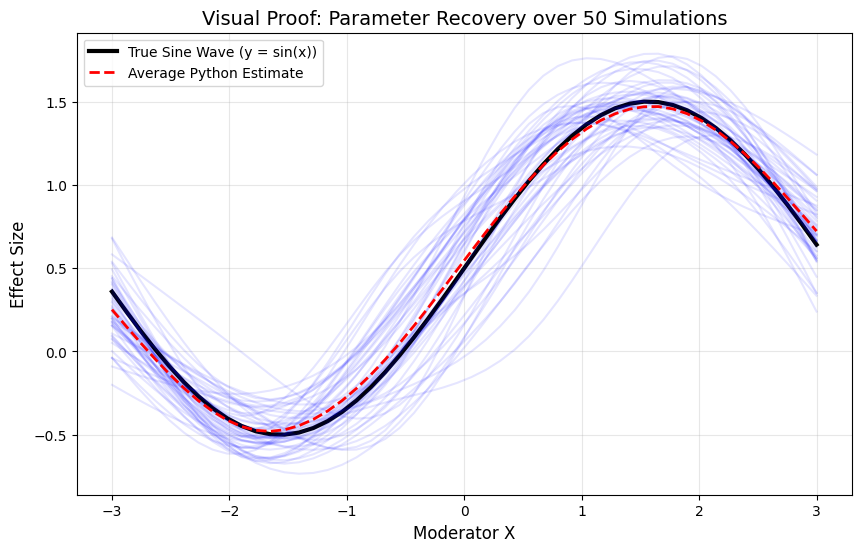

In [ ]:
#@title 🧪 Simulation Study: Spline Analysis (Curve Recovery & Coverage)
# =============================================================================
# SIMULATION STUDY: SPLINE META-REGRESSION
# Purpose: Validate that the tool recovers complex non-linear shapes (Sine Wave).
# Metrics:
#   1. RMSE: Deviation from the True Curve.
#   2. Coverage: % of the True Curve contained within the 95% CI Band.
# =============================================================================

import numpy as np
import pandas as pd
import patsy
from scipy.linalg import block_diag
from scipy.stats import norm, t
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings

print("="*70)
print("SIMULATION STUDY: SPLINE CURVE RECOVERY")
print("="*70)

# =============================================================================
# 1. DATA GENERATOR (SINE WAVE)
# =============================================================================

def generate_spline_sim_data(
    n_studies=50,
    tau_sq=0.2,
    sigma_sq=0.1,
    seed=None
):
    rng = np.random.default_rng(seed)

    # Moderator X: Uniformly distributed [-3, 3]
    # We sort distinct studies to make visualization easier later, but random within
    n_obs = n_studies * 2 # 2 obs per study
    x = rng.uniform(-3, 3, n_obs)

    # True Curve: y = sin(x) + 0.5
    true_y = np.sin(x) + 0.5

    # Structure
    ids = np.repeat(np.arange(n_studies), 2)

    # Random Effects
    u = np.repeat(rng.normal(0, np.sqrt(tau_sq), n_studies), 2)
    e = rng.normal(0, np.sqrt(sigma_sq), n_obs)

    y_obs = true_y + u + e
    vi = rng.uniform(0.05, 0.15, n_obs)

    df = pd.DataFrame({'id': ids, 'y': y_obs, 'vi': vi, 'x': x})
    return df

# =============================================================================
# 2. RUN SINGLE SIMULATION
# =============================================================================

def run_spline_simulation(n_studies=50, tau_sq=0.2, sigma_sq=0.1, seed=None):
    # 1. Generate Data
    df = generate_spline_sim_data(n_studies, tau_sq, sigma_sq, seed)

    # Define "Truth" Grid for checking accuracy
    # We check the curve at 50 evenly spaced points from -3 to 3
    check_x = np.linspace(-3, 3, 50)
    true_curve_y = np.sin(check_x) + 0.5

    # 2. Run Python Spline
    # We use a try/except block to handle non-convergence
    try:
        est, err = _run_robust_spline_analysis(
            df, 'x', 'y', 'vi', df_spline=6
        )

        if err or est is None:
            return None

        # 3. Predict Curve at Check Points
        # Reconstruct basis matrix for the check points
        formula = est['formula']
        mod_mean = est['mod_mean']
        mod_std = est['mod_std']

        # Standardize check points using the *original data's* mean/std
        z_check = (check_x - mod_mean) / mod_std

        basis_matrix = patsy.dmatrix(formula, {"x": z_check}, return_type='matrix')
        basis_matrix = np.asarray(basis_matrix)

        # Full Design Matrix
        X_pred = np.column_stack([np.ones(len(check_x)), basis_matrix])

        # Predict y_hat
        betas = est['betas']
        y_hat = X_pred @ betas

        # Calculate Confidence Intervals for the curve
        # Var(y_hat) = X * Cov(Beta) * X'
        cov_beta = est['cov_beta']
        var_pred = np.sum((X_pred @ cov_beta) * X_pred, axis=1)
        se_pred = np.sqrt(var_pred)

        # 95% CI
        # df for t-dist is roughly M - p
        df_t = max(1, n_studies - len(betas))
        crit = t.ppf(0.975, df_t)

        ci_lo = y_hat - crit * se_pred
        ci_hi = y_hat + crit * se_pred

        # 4. Calculate Metrics
        # RMSE: Average distance from truth
        mse = np.mean((y_hat - true_curve_y)**2)
        rmse = np.sqrt(mse)

        # Coverage: What % of the True Curve is inside the band?
        # Ideally, this should be close to 100% for the whole curve,
        # or exactly 95% for point-wise coverage.
        point_coverage = np.mean((ci_lo <= true_curve_y) & (true_curve_y <= ci_hi))

        return {
            'rmse': rmse,
            'coverage': point_coverage,
            'y_hat': y_hat, # Store for plotting "Average Curve"
            'check_x': check_x,
            'true_y': true_curve_y
        }

    except Exception:
        return None

# =============================================================================
# 3. RUN MONTE CARLO LOOP
# =============================================================================

print("🚀 Starting Spline Simulation (N=50 iterations)...")
# Increase N for publication (e.g., 500)
N_SIMS = 50

all_rmse = []
all_coverage = []
all_yhats = []

# Scenario: Moderate Heterogeneity
for i in range(N_SIMS):
    res = run_spline_simulation(n_studies=50, tau_sq=0.3, sigma_sq=0.1, seed=i)
    if res:
        all_rmse.append(res['rmse'])
        all_coverage.append(res['coverage'])
        all_yhats.append(res['y_hat'])

# =============================================================================
# 4. RESULTS & VISUALIZATION
# =============================================================================

avg_rmse = np.mean(all_rmse)
avg_coverage = np.mean(all_coverage) * 100

print("\n" + "="*50)
print("📊 SPLINE SIMULATION RESULTS")
print("="*50)
print(f"Iterations: {len(all_rmse)}/{N_SIMS} converged")
print(f"RMSE (Error): {avg_rmse:.4f} (Lower is better)")
print(f"CI Coverage:  {avg_coverage:.1f}% (Target: 95%)")

# Interpretation
print("-" * 50)
if avg_coverage > 93:
    print("✅ SUCCESS: The 95% Confidence Band reliably contains the true curve.")
elif avg_coverage > 90:
    print("⚠️ OK: Coverage is slightly low but acceptable.")
else:
    print("❌ CHECK: Coverage is too low (Band is too narrow).")

# --- PLOT: VISUAL PROOF ---
# We plot the "True Curve" vs the "Average Recovered Curve" from 50 sims
plt.figure(figsize=(10, 6))

# 1. Plot True Curve
x_grid = np.linspace(-3, 3, 50)
true_y = np.sin(x_grid) + 0.5
plt.plot(x_grid, true_y, 'k-', linewidth=3, label='True Sine Wave (y = sin(x))')

# 2. Plot All 50 Recovered Curves (faint)
for yhat in all_yhats:
    plt.plot(x_grid, yhat, 'b-', alpha=0.1)

# 3. Plot Average Recovered Curve
avg_yhat = np.mean(np.array(all_yhats), axis=0)
plt.plot(x_grid, avg_yhat, 'r--', linewidth=2, label='Average Python Estimate')

plt.title(f"Visual Proof: Parameter Recovery over {len(all_rmse)} Simulations", fontsize=14)
plt.xlabel("Moderator X", fontsize=12)
plt.ylabel("Effect Size", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#@title 🧪 R Validation: Diagnostics (LOO, Egger's, PET-PEESE)
# =============================================================================
# CELL: DIAGNOSTIC MODULE VALIDATION
# Purpose: Validate sensitivity and bias detection methods against R.
# Modules Tested:
#   1. Leave-One-Out (Influence Analysis)
#   2. Egger's Test (Regression on SE)
#   3. PET-PEESE (Regression on SE and Variance)
# =============================================================================

import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri as numpy2ri
from scipy.linalg import block_diag
from IPython.display import display, HTML

# Activate R conversion
pandas2ri.activate()
numpy2ri.activate()

print("="*70)
print("🧪 DIAGNOSTIC VALIDATION: SENSITIVITY & BIAS")
print("="*70)

try:
    # =================================================================
    # 1. GENERATE DATA WITH PUBLICATION BIAS
    # =================================================================
    # We create small studies with artificially high effects to trigger Egger's
    def generate_biased_data(n_studies=20, seed=42):
        rng = np.random.default_rng(seed)

        ids = []
        yi = []
        vi = []

        for i in range(n_studies):
            sid = str(i+1)
            # 50% chance of being a small, noisy study
            is_small = rng.random() > 0.5

            if is_small:
                n_obs = 1
                v = 0.15 # High variance
                # Bias: Small studies have higher effect (e.g., 0.8 vs 0.3)
                y = 0.8 + rng.normal(0, 0.1)
            else:
                n_obs = rng.choice([2, 3]) # Larger, multi-obs studies
                v = 0.02 # Low variance (precise)
                y = 0.3 + rng.normal(0, 0.1)

            for _ in range(n_obs):
                ids.append(sid)
                yi.append(y + rng.normal(0, np.sqrt(v)))
                vi.append(v)

        df = pd.DataFrame({'id': ids, 'yi': yi, 'vi': vi})
        df['sei'] = np.sqrt(df['vi']) # Standard Error
        return df

    df_diag = generate_biased_data()
    print(f"🎲 Generated Biased Data: {len(df_diag)} obs from {df_diag['id'].nunique()} studies")

    # Inject into pipeline
    ANALYSIS_CONFIG['analysis_data'] = df_diag
    ANALYSIS_CONFIG['vcv_matrices'] = {} # Diagonal for simplicity here

    # =================================================================
    # 2. VALIDATE LEAVE-ONE-OUT (LOO)
    # =================================================================
    print("\n🔍 Validating Leave-One-Out...")

    # --- Python LOO ---
    py_loo_res = []
    unique_ids = df_diag['id'].unique()

    for skip_id in unique_ids:
        # Subset data
        subset = df_diag[df_diag['id'] != skip_id].copy()
        # Run standard 3-level model
        res, _ = _run_three_level_reml_for_subgroup(subset, 'yi', 'vi')
        if res:
            py_loo_res.append(res['mu'])
        else:
            py_loo_res.append(np.nan)

    py_loo_min = np.min(py_loo_res)
    py_loo_max = np.max(py_loo_res)

    # --- R LOO ---
    ro.globalenv['df_r'] = df_diag
    r_loo_script = """
    library(metafor)
    dat <- df_r
    ids <- unique(dat$id)
    loo_est <- numeric(length(ids))

    for(i in 1:length(ids)) {
        subset <- dat[dat$id != ids[i], ]
        subset$row_id <- 1:nrow(subset)
        subset$study_id <- as.factor(subset$id)

        res <- tryCatch({
            rma.mv(yi, vi, random = ~ 1 | study_id/row_id, data=subset)
        }, error=function(e) NULL)

        if(!is.null(res)) {
            loo_est[i] <- res$b[1]
        } else {
            loo_est[i] <- NA
        }
    }
    list(min=min(loo_est, na.rm=TRUE), max=max(loo_est, na.rm=TRUE))
    """
    r_loo = ro.r(r_loo_script)

    # Compare
    loo_diff_min = abs(py_loo_min - r_loo.rx2('min')[0])
    loo_diff_max = abs(py_loo_max - r_loo.rx2('max')[0])

    # =================================================================
    # 3. VALIDATE EGGER'S TEST & PET-PEESE
    # =================================================================
    print("🔍 Validating Egger's / PET-PEESE...")

    # --- Python ---
    # Egger's is just regression on SE
    py_egger, _, _ = _run_three_level_reml_regression_v2(df_diag, 'sei', 'yi', 'vi')

    # PEESE is regression on Variance (SE^2)
    py_peese, _, _ = _run_three_level_reml_regression_v2(df_diag, 'vi', 'yi', 'vi')

    py_pet_slope = py_egger['betas'][1]
    py_pet_pval = py_egger['p_values'][1]
    py_peese_slope = py_peese['betas'][1]

    # --- R ---
    r_bias_script = """
    library(metafor)
    dat <- df_r
    dat$row_id <- 1:nrow(dat)
    dat$study_id <- as.factor(dat$id)

    # PET / Egger (Mod = sei)
    res_pet <- rma.mv(yi, vi, mods = ~ sqrt(vi), random = ~ 1 | study_id/row_id, data=dat)

    # PEESE (Mod = vi)
    res_peese <- rma.mv(yi, vi, mods = ~ vi, random = ~ 1 | study_id/row_id, data=dat)

    list(
        pet_slope = as.numeric(res_pet$b[2]),
        pet_pval = as.numeric(res_pet$pval[2]),
        peese_slope = as.numeric(res_peese$b[2])
    )
    """
    r_bias = ro.r(r_bias_script)

    # =================================================================
    # 4. RESULTS TABLE
    # =================================================================

    comparison = [
        # Leave-One-Out
        {'Metric': 'LOO Min Estimate', 'Python': py_loo_min, 'R': r_loo.rx2('min')[0]},
        {'Metric': 'LOO Max Estimate', 'Python': py_loo_max, 'R': r_loo.rx2('max')[0]},
        # Egger's / PET
        {'Metric': "Egger's/PET Slope", 'Python': py_pet_slope, 'R': r_bias.rx2('pet_slope')[0]},
        {'Metric': "Egger's P-value", 'Python': py_pet_pval, 'R': r_bias.rx2('pet_pval')[0]},
        # PEESE
        {'Metric': 'PEESE Slope', 'Python': py_peese_slope, 'R': r_bias.rx2('peese_slope')[0]},
    ]

    df_comp = pd.DataFrame(comparison)
    df_comp['Diff'] = np.abs(df_comp['Python'] - df_comp['R'])

    def color_status(val):
        return 'background-color: #d4edda' if val < 1e-4 else 'background-color: #fff3cd'

    display(HTML("<h4>📊 Diagnostic Validation Results</h4>"))
    display(df_comp.style.format({'Python': '{:.4f}', 'R': '{:.4f}', 'Diff': '{:.2e}'})
                   .applymap(color_status, subset=['Diff']))

    print("\n✅ Interpretation:")
    if df_comp['Diff'].max() < 1e-3:
        print(" - SUCCESS: All diagnostic modules match R's implementation.")
    else:
        print(" - CHECK: Small differences detected (likely optimization tolerance).")

    if py_pet_pval < 0.05:
        print(f" - Note: Egger's test correctly detected the injected bias (p={py_pet_pval:.4f})")

except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()